[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/main/tutorials/feature-use/global_local_modeling.ipynb)


Note: this Notebook needs updating.

# Global Local Model Example with Future Regressors
When fitting a single forecasting model with shared weights using a dataset composed of many time series, we can achieve what is known as a **global model**. It is specially useful in cases in which a single time series may not reflect the entire time series dynamics. In addition, global models provide better generalization and model size saving. In this notebook, we will build a global model using data from the hourly load of the ERCOT region.

When many time series share only "some behaviour" we will need a **global local model**. In the following notebook we will see an example of time series sharing behaviour/weights on all the components except from the trend and seasonality. Therefore, we will also build a global local model using data from the hourly load of the ERCOT region.

This notebook is an adaptation of `global_modeling.ipynb`.

In [1]:
if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed

set_random_seed(10)
set_log_level("ERROR", "INFO")

First, we load the data:

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_ercot = pd.read_csv(data_location + "multivariate/load_ercot_regions.csv")
df_ercot.head()

,ds,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST
0,2004-01-01 01:00:00,7225.09,877.79,1044.89,745.79,7124.21,1660.45,3639.12,654.61
1,2004-01-01 02:00:00,6994.25,850.75,1032.04,721.34,6854.58,1603.52,3495.16,639.88
2,2004-01-01 03:00:00,6717.42,831.63,1021.10,699.70,6639.48,1527.99,3322.70,623.42
3,2004-01-01 04:00:00,6554.27,823.56,1015.41,691.84,6492.39,1473.89,3201.72,613.49
4,2004-01-01 05:00:00,6511.19,823.38,1009.74,686.76,6452.26,1462.76,3163.74,613.32


We extract the name of the regions which will be later used in the model creation.

In [3]:
regions = list(df_ercot)[1:]

In [4]:
list(set(df_ercot.ds))[0]

'2004-04-17 07:00:00'

Global models can be enabled when the `df` input of the function has an additional column 'ID', which identifies the different time-series (besides the typical column 'ds', which has the timestamps, and column 'y', which contains the observed values of the time series). We select data from a three-year interval in our example (from 2004 to 2007).

In [5]:
df_global = pd.DataFrame()
for col in regions:
    aux = df_ercot[["ds", col]].copy(deep=True)  # select column associated with region
    aux = aux.iloc[:26301, :].copy(deep=True)  # selects data up to 26301 row (2004 to 2007 time stamps)
    aux = aux.rename(columns={col: "y"})  # rename column of data to 'y' which is compatible with Neural Prophet
    aux["ID"] = col
    df_global = pd.concat((df_global, aux))

We will modify one time series trend and one time series seasonality

In [6]:
import numpy as np

df_global["y"] = (
    np.where(df_global["ID"] == "COAST", -df_global["y"], df_global["y"])
    + 2 * df_global[df_global["ID"] == "COAST"].mean().y
)
# df_global["y"] = np.where(df_global["ID"] == "NORTH", df_global["y"] + 0.1 * df_global.index, df_global["y"])

df_global[df_global["ID"] == "NORTH"].plot()
df_global[df_global["ID"] == "COAST"].plot()

TypeError: Could not convert ['2004-01-01 01:00:002004-01-01 02:00:002004-01-01 03:00:002004-01-01 04:00:002004-01-01 05:00:002004-01-01 06:00:002004-01-01 07:00:002004-01-01 08:00:002004-01-01 09:00:002004-01-01 10:00:002004-01-01 11:00:002004-01-01 12:00:002004-01-01 13:00:002004-01-01 14:00:002004-01-01 15:00:002004-01-01 16:00:002004-01-01 17:00:002004-01-01 18:00:002004-01-01 19:00:002004-01-01 20:00:002004-01-01 21:00:002004-01-01 22:00:002004-01-01 23:00:002004-01-02 00:00:002004-01-02 01:00:002004-01-02 02:00:002004-01-02 03:00:002004-01-02 04:00:002004-01-02 05:00:002004-01-02 06:00:002004-01-02 07:00:002004-01-02 08:00:002004-01-02 09:00:002004-01-02 10:00:002004-01-02 11:00:002004-01-02 12:00:002004-01-02 13:00:002004-01-02 14:00:002004-01-02 15:00:002004-01-02 16:00:002004-01-02 17:00:002004-01-02 18:00:002004-01-02 19:00:002004-01-02 20:00:002004-01-02 21:00:002004-01-02 22:00:002004-01-02 23:00:002004-01-03 00:00:002004-01-03 01:00:002004-01-03 02:00:002004-01-03 03:00:002004-01-03 04:00:002004-01-03 05:00:002004-01-03 06:00:002004-01-03 07:00:002004-01-03 08:00:002004-01-03 09:00:002004-01-03 10:00:002004-01-03 11:00:002004-01-03 12:00:002004-01-03 13:00:002004-01-03 14:00:002004-01-03 15:00:002004-01-03 16:00:002004-01-03 17:00:002004-01-03 18:00:002004-01-03 19:00:002004-01-03 20:00:002004-01-03 21:00:002004-01-03 22:00:002004-01-03 23:00:002004-01-04 00:00:002004-01-04 01:00:002004-01-04 02:00:002004-01-04 03:00:002004-01-04 04:00:002004-01-04 05:00:002004-01-04 06:00:002004-01-04 07:00:002004-01-04 08:00:002004-01-04 09:00:002004-01-04 10:00:002004-01-04 11:00:002004-01-04 12:00:002004-01-04 13:00:002004-01-04 14:00:002004-01-04 15:00:002004-01-04 16:00:002004-01-04 17:00:002004-01-04 18:00:002004-01-04 19:00:002004-01-04 20:00:002004-01-04 21:00:002004-01-04 22:00:002004-01-04 23:00:002004-01-05 00:00:002004-01-05 01:00:002004-01-05 02:00:002004-01-05 03:00:002004-01-05 04:00:002004-01-05 05:00:002004-01-05 06:00:002004-01-05 07:00:002004-01-05 08:00:002004-01-05 09:00:002004-01-05 10:00:002004-01-05 11:00:002004-01-05 12:00:002004-01-05 13:00:002004-01-05 14:00:002004-01-05 15:00:002004-01-05 16:00:002004-01-05 17:00:002004-01-05 18:00:002004-01-05 19:00:002004-01-05 20:00:002004-01-05 21:00:002004-01-05 22:00:002004-01-05 23:00:002004-01-06 00:00:002004-01-06 01:00:002004-01-06 02:00:002004-01-06 03:00:002004-01-06 04:00:002004-01-06 05:00:002004-01-06 06:00:002004-01-06 07:00:002004-01-06 08:00:002004-01-06 09:00:002004-01-06 10:00:002004-01-06 11:00:002004-01-06 12:00:002004-01-06 13:00:002004-01-06 14:00:002004-01-06 15:00:002004-01-06 16:00:002004-01-06 17:00:002004-01-06 18:00:002004-01-06 19:00:002004-01-06 20:00:002004-01-06 21:00:002004-01-06 22:00:002004-01-06 23:00:002004-01-07 00:00:002004-01-07 01:00:002004-01-07 02:00:002004-01-07 03:00:002004-01-07 04:00:002004-01-07 05:00:002004-01-07 06:00:002004-01-07 07:00:002004-01-07 08:00:002004-01-07 09:00:002004-01-07 10:00:002004-01-07 11:00:002004-01-07 12:00:002004-01-07 13:00:002004-01-07 14:00:002004-01-07 15:00:002004-01-07 16:00:002004-01-07 17:00:002004-01-07 18:00:002004-01-07 19:00:002004-01-07 20:00:002004-01-07 21:00:002004-01-07 22:00:002004-01-07 23:00:002004-01-08 00:00:002004-01-08 01:00:002004-01-08 02:00:002004-01-08 03:00:002004-01-08 04:00:002004-01-08 05:00:002004-01-08 06:00:002004-01-08 07:00:002004-01-08 08:00:002004-01-08 09:00:002004-01-08 10:00:002004-01-08 11:00:002004-01-08 12:00:002004-01-08 13:00:002004-01-08 14:00:002004-01-08 15:00:002004-01-08 16:00:002004-01-08 17:00:002004-01-08 18:00:002004-01-08 19:00:002004-01-08 20:00:002004-01-08 21:00:002004-01-08 22:00:002004-01-08 23:00:002004-01-09 00:00:002004-01-09 01:00:002004-01-09 02:00:002004-01-09 03:00:002004-01-09 04:00:002004-01-09 05:00:002004-01-09 06:00:002004-01-09 07:00:002004-01-09 08:00:002004-01-09 09:00:002004-01-09 10:00:002004-01-09 11:00:002004-01-09 12:00:002004-01-09 13:00:002004-01-09 14:00:002004-01-09 15:00:002004-01-09 16:00:002004-01-09 17:00:002004-01-09 18:00:002004-01-09 19:00:002004-01-09 20:00:002004-01-09 21:00:002004-01-09 22:00:002004-01-09 23:00:002004-01-10 00:00:002004-01-10 01:00:002004-01-10 02:00:002004-01-10 03:00:002004-01-10 04:00:002004-01-10 05:00:002004-01-10 06:00:002004-01-10 07:00:002004-01-10 08:00:002004-01-10 09:00:002004-01-10 10:00:002004-01-10 11:00:002004-01-10 12:00:002004-01-10 13:00:002004-01-10 14:00:002004-01-10 15:00:002004-01-10 16:00:002004-01-10 17:00:002004-01-10 18:00:002004-01-10 19:00:002004-01-10 20:00:002004-01-10 21:00:002004-01-10 22:00:002004-01-10 23:00:002004-01-11 00:00:002004-01-11 01:00:002004-01-11 02:00:002004-01-11 03:00:002004-01-11 04:00:002004-01-11 05:00:002004-01-11 06:00:002004-01-11 07:00:002004-01-11 08:00:002004-01-11 09:00:002004-01-11 10:00:002004-01-11 11:00:002004-01-11 12:00:002004-01-11 13:00:002004-01-11 14:00:002004-01-11 15:00:002004-01-11 16:00:002004-01-11 17:00:002004-01-11 18:00:002004-01-11 19:00:002004-01-11 20:00:002004-01-11 21:00:002004-01-11 22:00:002004-01-11 23:00:002004-01-12 00:00:002004-01-12 01:00:002004-01-12 02:00:002004-01-12 03:00:002004-01-12 04:00:002004-01-12 05:00:002004-01-12 06:00:002004-01-12 07:00:002004-01-12 08:00:002004-01-12 09:00:002004-01-12 10:00:002004-01-12 11:00:002004-01-12 12:00:002004-01-12 13:00:002004-01-12 14:00:002004-01-12 15:00:002004-01-12 16:00:002004-01-12 17:00:002004-01-12 18:00:002004-01-12 19:00:002004-01-12 20:00:002004-01-12 21:00:002004-01-12 22:00:002004-01-12 23:00:002004-01-13 00:00:002004-01-13 01:00:002004-01-13 02:00:002004-01-13 03:00:002004-01-13 04:00:002004-01-13 05:00:002004-01-13 06:00:002004-01-13 07:00:002004-01-13 08:00:002004-01-13 09:00:002004-01-13 10:00:002004-01-13 11:00:002004-01-13 12:00:002004-01-13 13:00:002004-01-13 14:00:002004-01-13 15:00:002004-01-13 16:00:002004-01-13 17:00:002004-01-13 18:00:002004-01-13 19:00:002004-01-13 20:00:002004-01-13 21:00:002004-01-13 22:00:002004-01-13 23:00:002004-01-14 00:00:002004-01-14 01:00:002004-01-14 02:00:002004-01-14 03:00:002004-01-14 04:00:002004-01-14 05:00:002004-01-14 06:00:002004-01-14 07:00:002004-01-14 08:00:002004-01-14 09:00:002004-01-14 10:00:002004-01-14 11:00:002004-01-14 12:00:002004-01-14 13:00:002004-01-14 14:00:002004-01-14 15:00:002004-01-14 16:00:002004-01-14 17:00:002004-01-14 18:00:002004-01-14 19:00:002004-01-14 20:00:002004-01-14 21:00:002004-01-14 22:00:002004-01-14 23:00:002004-01-15 00:00:002004-01-15 01:00:002004-01-15 02:00:002004-01-15 03:00:002004-01-15 04:00:002004-01-15 05:00:002004-01-15 06:00:002004-01-15 07:00:002004-01-15 08:00:002004-01-15 09:00:002004-01-15 10:00:002004-01-15 11:00:002004-01-15 12:00:002004-01-15 13:00:002004-01-15 14:00:002004-01-15 15:00:002004-01-15 16:00:002004-01-15 17:00:002004-01-15 18:00:002004-01-15 19:00:002004-01-15 20:00:002004-01-15 21:00:002004-01-15 22:00:002004-01-15 23:00:002004-01-16 00:00:002004-01-16 01:00:002004-01-16 02:00:002004-01-16 03:00:002004-01-16 04:00:002004-01-16 05:00:002004-01-16 06:00:002004-01-16 07:00:002004-01-16 08:00:002004-01-16 09:00:002004-01-16 10:00:002004-01-16 11:00:002004-01-16 12:00:002004-01-16 13:00:002004-01-16 14:00:002004-01-16 15:00:002004-01-16 16:00:002004-01-16 17:00:002004-01-16 18:00:002004-01-16 19:00:002004-01-16 20:00:002004-01-16 21:00:002004-01-16 22:00:002004-01-16 23:00:002004-01-17 00:00:002004-01-17 01:00:002004-01-17 02:00:002004-01-17 03:00:002004-01-17 04:00:002004-01-17 05:00:002004-01-17 06:00:002004-01-17 07:00:002004-01-17 08:00:002004-01-17 09:00:002004-01-17 10:00:002004-01-17 11:00:002004-01-17 12:00:002004-01-17 13:00:002004-01-17 14:00:002004-01-17 15:00:002004-01-17 16:00:002004-01-17 17:00:002004-01-17 18:00:002004-01-17 19:00:002004-01-17 20:00:002004-01-17 21:00:002004-01-17 22:00:002004-01-17 23:00:002004-01-18 00:00:002004-01-18 01:00:002004-01-18 02:00:002004-01-18 03:00:002004-01-18 04:00:002004-01-18 05:00:002004-01-18 06:00:002004-01-18 07:00:002004-01-18 08:00:002004-01-18 09:00:002004-01-18 10:00:002004-01-18 11:00:002004-01-18 12:00:002004-01-18 13:00:002004-01-18 14:00:002004-01-18 15:00:002004-01-18 16:00:002004-01-18 17:00:002004-01-18 18:00:002004-01-18 19:00:002004-01-18 20:00:002004-01-18 21:00:002004-01-18 22:00:002004-01-18 23:00:002004-01-19 00:00:002004-01-19 01:00:002004-01-19 02:00:002004-01-19 03:00:002004-01-19 04:00:002004-01-19 05:00:002004-01-19 06:00:002004-01-19 07:00:002004-01-19 08:00:002004-01-19 09:00:002004-01-19 10:00:002004-01-19 11:00:002004-01-19 12:00:002004-01-19 13:00:002004-01-19 14:00:002004-01-19 15:00:002004-01-19 16:00:002004-01-19 17:00:002004-01-19 18:00:002004-01-19 19:00:002004-01-19 20:00:002004-01-19 21:00:002004-01-19 22:00:002004-01-19 23:00:002004-01-20 00:00:002004-01-20 01:00:002004-01-20 02:00:002004-01-20 03:00:002004-01-20 04:00:002004-01-20 05:00:002004-01-20 06:00:002004-01-20 07:00:002004-01-20 08:00:002004-01-20 09:00:002004-01-20 10:00:002004-01-20 11:00:002004-01-20 12:00:002004-01-20 13:00:002004-01-20 14:00:002004-01-20 15:00:002004-01-20 16:00:002004-01-20 17:00:002004-01-20 18:00:002004-01-20 19:00:002004-01-20 20:00:002004-01-20 21:00:002004-01-20 22:00:002004-01-20 23:00:002004-01-21 00:00:002004-01-21 01:00:002004-01-21 02:00:002004-01-21 03:00:002004-01-21 04:00:002004-01-21 05:00:002004-01-21 06:00:002004-01-21 07:00:002004-01-21 08:00:002004-01-21 09:00:002004-01-21 10:00:002004-01-21 11:00:002004-01-21 12:00:002004-01-21 13:00:002004-01-21 14:00:002004-01-21 15:00:002004-01-21 16:00:002004-01-21 17:00:002004-01-21 18:00:002004-01-21 19:00:002004-01-21 20:00:002004-01-21 21:00:002004-01-21 22:00:002004-01-21 23:00:002004-01-22 00:00:002004-01-22 01:00:002004-01-22 02:00:002004-01-22 03:00:002004-01-22 04:00:002004-01-22 05:00:002004-01-22 06:00:002004-01-22 07:00:002004-01-22 08:00:002004-01-22 09:00:002004-01-22 10:00:002004-01-22 11:00:002004-01-22 12:00:002004-01-22 13:00:002004-01-22 14:00:002004-01-22 15:00:002004-01-22 16:00:002004-01-22 17:00:002004-01-22 18:00:002004-01-22 19:00:002004-01-22 20:00:002004-01-22 21:00:002004-01-22 22:00:002004-01-22 23:00:002004-01-23 00:00:002004-01-23 01:00:002004-01-23 02:00:002004-01-23 03:00:002004-01-23 04:00:002004-01-23 05:00:002004-01-23 06:00:002004-01-23 07:00:002004-01-23 08:00:002004-01-23 09:00:002004-01-23 10:00:002004-01-23 11:00:002004-01-23 12:00:002004-01-23 13:00:002004-01-23 14:00:002004-01-23 15:00:002004-01-23 16:00:002004-01-23 17:00:002004-01-23 18:00:002004-01-23 19:00:002004-01-23 20:00:002004-01-23 21:00:002004-01-23 22:00:002004-01-23 23:00:002004-01-24 00:00:002004-01-24 01:00:002004-01-24 02:00:002004-01-24 03:00:002004-01-24 04:00:002004-01-24 05:00:002004-01-24 06:00:002004-01-24 07:00:002004-01-24 08:00:002004-01-24 09:00:002004-01-24 10:00:002004-01-24 11:00:002004-01-24 12:00:002004-01-24 13:00:002004-01-24 14:00:002004-01-24 15:00:002004-01-24 16:00:002004-01-24 17:00:002004-01-24 18:00:002004-01-24 19:00:002004-01-24 20:00:002004-01-24 21:00:002004-01-24 22:00:002004-01-24 23:00:002004-01-25 00:00:002004-01-25 01:00:002004-01-25 02:00:002004-01-25 03:00:002004-01-25 04:00:002004-01-25 05:00:002004-01-25 06:00:002004-01-25 07:00:002004-01-25 08:00:002004-01-25 09:00:002004-01-25 10:00:002004-01-25 11:00:002004-01-25 12:00:002004-01-25 13:00:002004-01-25 14:00:002004-01-25 15:00:002004-01-25 16:00:002004-01-25 17:00:002004-01-25 18:00:002004-01-25 19:00:002004-01-25 20:00:002004-01-25 21:00:002004-01-25 22:00:002004-01-25 23:00:002004-01-26 00:00:002004-01-26 01:00:002004-01-26 02:00:002004-01-26 03:00:002004-01-26 04:00:002004-01-26 05:00:002004-01-26 06:00:002004-01-26 07:00:002004-01-26 08:00:002004-01-26 09:00:002004-01-26 10:00:002004-01-26 11:00:002004-01-26 12:00:002004-01-26 13:00:002004-01-26 14:00:002004-01-26 15:00:002004-01-26 16:00:002004-01-26 17:00:002004-01-26 18:00:002004-01-26 19:00:002004-01-26 20:00:002004-01-26 21:00:002004-01-26 22:00:002004-01-26 23:00:002004-01-27 00:00:002004-01-27 01:00:002004-01-27 02:00:002004-01-27 03:00:002004-01-27 04:00:002004-01-27 05:00:002004-01-27 06:00:002004-01-27 07:00:002004-01-27 08:00:002004-01-27 09:00:002004-01-27 10:00:002004-01-27 11:00:002004-01-27 12:00:002004-01-27 13:00:002004-01-27 14:00:002004-01-27 15:00:002004-01-27 16:00:002004-01-27 17:00:002004-01-27 18:00:002004-01-27 19:00:002004-01-27 20:00:002004-01-27 21:00:002004-01-27 22:00:002004-01-27 23:00:002004-01-28 00:00:002004-01-28 01:00:002004-01-28 02:00:002004-01-28 03:00:002004-01-28 04:00:002004-01-28 05:00:002004-01-28 06:00:002004-01-28 07:00:002004-01-28 08:00:002004-01-28 09:00:002004-01-28 10:00:002004-01-28 11:00:002004-01-28 12:00:002004-01-28 13:00:002004-01-28 14:00:002004-01-28 15:00:002004-01-28 16:00:002004-01-28 17:00:002004-01-28 18:00:002004-01-28 19:00:002004-01-28 20:00:002004-01-28 21:00:002004-01-28 22:00:002004-01-28 23:00:002004-01-29 00:00:002004-01-29 01:00:002004-01-29 02:00:002004-01-29 03:00:002004-01-29 04:00:002004-01-29 05:00:002004-01-29 06:00:002004-01-29 07:00:002004-01-29 08:00:002004-01-29 09:00:002004-01-29 10:00:002004-01-29 11:00:002004-01-29 12:00:002004-01-29 13:00:002004-01-29 14:00:002004-01-29 15:00:002004-01-29 16:00:002004-01-29 17:00:002004-01-29 18:00:002004-01-29 19:00:002004-01-29 20:00:002004-01-29 21:00:002004-01-29 22:00:002004-01-29 23:00:002004-01-30 00:00:002004-01-30 01:00:002004-01-30 02:00:002004-01-30 03:00:002004-01-30 04:00:002004-01-30 05:00:002004-01-30 06:00:002004-01-30 07:00:002004-01-30 08:00:002004-01-30 09:00:002004-01-30 10:00:002004-01-30 11:00:002004-01-30 12:00:002004-01-30 13:00:002004-01-30 14:00:002004-01-30 15:00:002004-01-30 16:00:002004-01-30 17:00:002004-01-30 18:00:002004-01-30 19:00:002004-01-30 20:00:002004-01-30 21:00:002004-01-30 22:00:002004-01-30 23:00:002004-01-31 00:00:002004-01-31 01:00:002004-01-31 02:00:002004-01-31 03:00:002004-01-31 04:00:002004-01-31 05:00:002004-01-31 06:00:002004-01-31 07:00:002004-01-31 08:00:002004-01-31 09:00:002004-01-31 10:00:002004-01-31 11:00:002004-01-31 12:00:002004-01-31 13:00:002004-01-31 14:00:002004-01-31 15:00:002004-01-31 16:00:002004-01-31 17:00:002004-01-31 18:00:002004-01-31 19:00:002004-01-31 20:00:002004-01-31 21:00:002004-01-31 22:00:002004-01-31 23:00:002004-02-01 00:00:002004-02-01 01:00:002004-02-01 02:00:002004-02-01 03:00:002004-02-01 04:00:002004-02-01 05:00:002004-02-01 06:00:002004-02-01 07:00:002004-02-01 08:00:002004-02-01 09:00:002004-02-01 10:00:002004-02-01 11:00:002004-02-01 12:00:002004-02-01 13:00:002004-02-01 14:00:002004-02-01 15:00:002004-02-01 16:00:002004-02-01 17:00:002004-02-01 18:00:002004-02-01 19:00:002004-02-01 20:00:002004-02-01 21:00:002004-02-01 22:00:002004-02-01 23:00:002004-02-02 00:00:002004-02-02 01:00:002004-02-02 02:00:002004-02-02 03:00:002004-02-02 04:00:002004-02-02 05:00:002004-02-02 06:00:002004-02-02 07:00:002004-02-02 08:00:002004-02-02 09:00:002004-02-02 10:00:002004-02-02 11:00:002004-02-02 12:00:002004-02-02 13:00:002004-02-02 14:00:002004-02-02 15:00:002004-02-02 16:00:002004-02-02 17:00:002004-02-02 18:00:002004-02-02 19:00:002004-02-02 20:00:002004-02-02 21:00:002004-02-02 22:00:002004-02-02 23:00:002004-02-03 00:00:002004-02-03 01:00:002004-02-03 02:00:002004-02-03 03:00:002004-02-03 04:00:002004-02-03 05:00:002004-02-03 06:00:002004-02-03 07:00:002004-02-03 08:00:002004-02-03 09:00:002004-02-03 10:00:002004-02-03 11:00:002004-02-03 12:00:002004-02-03 13:00:002004-02-03 14:00:002004-02-03 15:00:002004-02-03 16:00:002004-02-03 17:00:002004-02-03 18:00:002004-02-03 19:00:002004-02-03 20:00:002004-02-03 21:00:002004-02-03 22:00:002004-02-03 23:00:002004-02-04 00:00:002004-02-04 01:00:002004-02-04 02:00:002004-02-04 03:00:002004-02-04 04:00:002004-02-04 05:00:002004-02-04 06:00:002004-02-04 07:00:002004-02-04 08:00:002004-02-04 09:00:002004-02-04 10:00:002004-02-04 11:00:002004-02-04 12:00:002004-02-04 13:00:002004-02-04 14:00:002004-02-04 15:00:002004-02-04 16:00:002004-02-04 17:00:002004-02-04 18:00:002004-02-04 19:00:002004-02-04 20:00:002004-02-04 21:00:002004-02-04 22:00:002004-02-04 23:00:002004-02-05 00:00:002004-02-05 01:00:002004-02-05 02:00:002004-02-05 03:00:002004-02-05 04:00:002004-02-05 05:00:002004-02-05 06:00:002004-02-05 07:00:002004-02-05 08:00:002004-02-05 09:00:002004-02-05 10:00:002004-02-05 11:00:002004-02-05 12:00:002004-02-05 13:00:002004-02-05 14:00:002004-02-05 15:00:002004-02-05 16:00:002004-02-05 17:00:002004-02-05 18:00:002004-02-05 19:00:002004-02-05 20:00:002004-02-05 21:00:002004-02-05 22:00:002004-02-05 23:00:002004-02-06 00:00:002004-02-06 01:00:002004-02-06 02:00:002004-02-06 03:00:002004-02-06 04:00:002004-02-06 05:00:002004-02-06 06:00:002004-02-06 07:00:002004-02-06 08:00:002004-02-06 09:00:002004-02-06 10:00:002004-02-06 11:00:002004-02-06 12:00:002004-02-06 13:00:002004-02-06 14:00:002004-02-06 15:00:002004-02-06 16:00:002004-02-06 17:00:002004-02-06 18:00:002004-02-06 19:00:002004-02-06 20:00:002004-02-06 21:00:002004-02-06 22:00:002004-02-06 23:00:002004-02-07 00:00:002004-02-07 01:00:002004-02-07 02:00:002004-02-07 03:00:002004-02-07 04:00:002004-02-07 05:00:002004-02-07 06:00:002004-02-07 07:00:002004-02-07 08:00:002004-02-07 09:00:002004-02-07 10:00:002004-02-07 11:00:002004-02-07 12:00:002004-02-07 13:00:002004-02-07 14:00:002004-02-07 15:00:002004-02-07 16:00:002004-02-07 17:00:002004-02-07 18:00:002004-02-07 19:00:002004-02-07 20:00:002004-02-07 21:00:002004-02-07 22:00:002004-02-07 23:00:002004-02-08 00:00:002004-02-08 01:00:002004-02-08 02:00:002004-02-08 03:00:002004-02-08 04:00:002004-02-08 05:00:002004-02-08 06:00:002004-02-08 07:00:002004-02-08 08:00:002004-02-08 09:00:002004-02-08 10:00:002004-02-08 11:00:002004-02-08 12:00:002004-02-08 13:00:002004-02-08 14:00:002004-02-08 15:00:002004-02-08 16:00:002004-02-08 17:00:002004-02-08 18:00:002004-02-08 19:00:002004-02-08 20:00:002004-02-08 21:00:002004-02-08 22:00:002004-02-08 23:00:002004-02-09 00:00:002004-02-09 01:00:002004-02-09 02:00:002004-02-09 03:00:002004-02-09 04:00:002004-02-09 05:00:002004-02-09 06:00:002004-02-09 07:00:002004-02-09 08:00:002004-02-09 09:00:002004-02-09 10:00:002004-02-09 11:00:002004-02-09 12:00:002004-02-09 13:00:002004-02-09 14:00:002004-02-09 15:00:002004-02-09 16:00:002004-02-09 17:00:002004-02-09 18:00:002004-02-09 19:00:002004-02-09 20:00:002004-02-09 21:00:002004-02-09 22:00:002004-02-09 23:00:002004-02-10 00:00:002004-02-10 01:00:002004-02-10 02:00:002004-02-10 03:00:002004-02-10 04:00:002004-02-10 05:00:002004-02-10 06:00:002004-02-10 07:00:002004-02-10 08:00:002004-02-10 09:00:002004-02-10 10:00:002004-02-10 11:00:002004-02-10 12:00:002004-02-10 13:00:002004-02-10 14:00:002004-02-10 15:00:002004-02-10 16:00:002004-02-10 17:00:002004-02-10 18:00:002004-02-10 19:00:002004-02-10 20:00:002004-02-10 21:00:002004-02-10 22:00:002004-02-10 23:00:002004-02-11 00:00:002004-02-11 01:00:002004-02-11 02:00:002004-02-11 03:00:002004-02-11 04:00:002004-02-11 05:00:002004-02-11 06:00:002004-02-11 07:00:002004-02-11 08:00:002004-02-11 09:00:002004-02-11 10:00:002004-02-11 11:00:002004-02-11 12:00:002004-02-11 13:00:002004-02-11 14:00:002004-02-11 15:00:002004-02-11 16:00:002004-02-11 17:00:002004-02-11 18:00:002004-02-11 19:00:002004-02-11 20:00:002004-02-11 21:00:002004-02-11 22:00:002004-02-11 23:00:002004-02-12 00:00:002004-02-12 01:00:002004-02-12 02:00:002004-02-12 03:00:002004-02-12 04:00:002004-02-12 05:00:002004-02-12 06:00:002004-02-12 07:00:002004-02-12 08:00:002004-02-12 09:00:002004-02-12 10:00:002004-02-12 11:00:002004-02-12 12:00:002004-02-12 13:00:002004-02-12 14:00:002004-02-12 15:00:002004-02-12 16:00:002004-02-12 17:00:002004-02-12 18:00:002004-02-12 19:00:002004-02-12 20:00:002004-02-12 21:00:002004-02-12 22:00:002004-02-12 23:00:002004-02-13 00:00:002004-02-13 01:00:002004-02-13 02:00:002004-02-13 03:00:002004-02-13 04:00:002004-02-13 05:00:002004-02-13 06:00:002004-02-13 07:00:002004-02-13 08:00:002004-02-13 09:00:002004-02-13 10:00:002004-02-13 11:00:002004-02-13 12:00:002004-02-13 13:00:002004-02-13 14:00:002004-02-13 15:00:002004-02-13 16:00:002004-02-13 17:00:002004-02-13 18:00:002004-02-13 19:00:002004-02-13 20:00:002004-02-13 21:00:002004-02-13 22:00:002004-02-13 23:00:002004-02-14 00:00:002004-02-14 01:00:002004-02-14 02:00:002004-02-14 03:00:002004-02-14 04:00:002004-02-14 05:00:002004-02-14 06:00:002004-02-14 07:00:002004-02-14 08:00:002004-02-14 09:00:002004-02-14 10:00:002004-02-14 11:00:002004-02-14 12:00:002004-02-14 13:00:002004-02-14 14:00:002004-02-14 15:00:002004-02-14 16:00:002004-02-14 17:00:002004-02-14 18:00:002004-02-14 19:00:002004-02-14 20:00:002004-02-14 21:00:002004-02-14 22:00:002004-02-14 23:00:002004-02-15 00:00:002004-02-15 01:00:002004-02-15 02:00:002004-02-15 03:00:002004-02-15 04:00:002004-02-15 05:00:002004-02-15 06:00:002004-02-15 07:00:002004-02-15 08:00:002004-02-15 09:00:002004-02-15 10:00:002004-02-15 11:00:002004-02-15 12:00:002004-02-15 13:00:002004-02-15 14:00:002004-02-15 15:00:002004-02-15 16:00:002004-02-15 17:00:002004-02-15 18:00:002004-02-15 19:00:002004-02-15 20:00:002004-02-15 21:00:002004-02-15 22:00:002004-02-15 23:00:002004-02-16 00:00:002004-02-16 01:00:002004-02-16 02:00:002004-02-16 03:00:002004-02-16 04:00:002004-02-16 05:00:002004-02-16 06:00:002004-02-16 07:00:002004-02-16 08:00:002004-02-16 09:00:002004-02-16 10:00:002004-02-16 11:00:002004-02-16 12:00:002004-02-16 13:00:002004-02-16 14:00:002004-02-16 15:00:002004-02-16 16:00:002004-02-16 17:00:002004-02-16 18:00:002004-02-16 19:00:002004-02-16 20:00:002004-02-16 21:00:002004-02-16 22:00:002004-02-16 23:00:002004-02-17 00:00:002004-02-17 01:00:002004-02-17 02:00:002004-02-17 03:00:002004-02-17 04:00:002004-02-17 05:00:002004-02-17 06:00:002004-02-17 07:00:002004-02-17 08:00:002004-02-17 09:00:002004-02-17 10:00:002004-02-17 11:00:002004-02-17 12:00:002004-02-17 13:00:002004-02-17 14:00:002004-02-17 15:00:002004-02-17 16:00:002004-02-17 17:00:002004-02-17 18:00:002004-02-17 19:00:002004-02-17 20:00:002004-02-17 21:00:002004-02-17 22:00:002004-02-17 23:00:002004-02-18 00:00:002004-02-18 01:00:002004-02-18 02:00:002004-02-18 03:00:002004-02-18 04:00:002004-02-18 05:00:002004-02-18 06:00:002004-02-18 07:00:002004-02-18 08:00:002004-02-18 09:00:002004-02-18 10:00:002004-02-18 11:00:002004-02-18 12:00:002004-02-18 13:00:002004-02-18 14:00:002004-02-18 15:00:002004-02-18 16:00:002004-02-18 17:00:002004-02-18 18:00:002004-02-18 19:00:002004-02-18 20:00:002004-02-18 21:00:002004-02-18 22:00:002004-02-18 23:00:002004-02-19 00:00:002004-02-19 01:00:002004-02-19 02:00:002004-02-19 03:00:002004-02-19 04:00:002004-02-19 05:00:002004-02-19 06:00:002004-02-19 07:00:002004-02-19 08:00:002004-02-19 09:00:002004-02-19 10:00:002004-02-19 11:00:002004-02-19 12:00:002004-02-19 13:00:002004-02-19 14:00:002004-02-19 15:00:002004-02-19 16:00:002004-02-19 17:00:002004-02-19 18:00:002004-02-19 19:00:002004-02-19 20:00:002004-02-19 21:00:002004-02-19 22:00:002004-02-19 23:00:002004-02-20 00:00:002004-02-20 01:00:002004-02-20 02:00:002004-02-20 03:00:002004-02-20 04:00:002004-02-20 05:00:002004-02-20 06:00:002004-02-20 07:00:002004-02-20 08:00:002004-02-20 09:00:002004-02-20 10:00:002004-02-20 11:00:002004-02-20 12:00:002004-02-20 13:00:002004-02-20 14:00:002004-02-20 15:00:002004-02-20 16:00:002004-02-20 17:00:002004-02-20 18:00:002004-02-20 19:00:002004-02-20 20:00:002004-02-20 21:00:002004-02-20 22:00:002004-02-20 23:00:002004-02-21 00:00:002004-02-21 01:00:002004-02-21 02:00:002004-02-21 03:00:002004-02-21 04:00:002004-02-21 05:00:002004-02-21 06:00:002004-02-21 07:00:002004-02-21 08:00:002004-02-21 09:00:002004-02-21 10:00:002004-02-21 11:00:002004-02-21 12:00:002004-02-21 13:00:002004-02-21 14:00:002004-02-21 15:00:002004-02-21 16:00:002004-02-21 17:00:002004-02-21 18:00:002004-02-21 19:00:002004-02-21 20:00:002004-02-21 21:00:002004-02-21 22:00:002004-02-21 23:00:002004-02-22 00:00:002004-02-22 01:00:002004-02-22 02:00:002004-02-22 03:00:002004-02-22 04:00:002004-02-22 05:00:002004-02-22 06:00:002004-02-22 07:00:002004-02-22 08:00:002004-02-22 09:00:002004-02-22 10:00:002004-02-22 11:00:002004-02-22 12:00:002004-02-22 13:00:002004-02-22 14:00:002004-02-22 15:00:002004-02-22 16:00:002004-02-22 17:00:002004-02-22 18:00:002004-02-22 19:00:002004-02-22 20:00:002004-02-22 21:00:002004-02-22 22:00:002004-02-22 23:00:002004-02-23 00:00:002004-02-23 01:00:002004-02-23 02:00:002004-02-23 03:00:002004-02-23 04:00:002004-02-23 05:00:002004-02-23 06:00:002004-02-23 07:00:002004-02-23 08:00:002004-02-23 09:00:002004-02-23 10:00:002004-02-23 11:00:002004-02-23 12:00:002004-02-23 13:00:002004-02-23 14:00:002004-02-23 15:00:002004-02-23 16:00:002004-02-23 17:00:002004-02-23 18:00:002004-02-23 19:00:002004-02-23 20:00:002004-02-23 21:00:002004-02-23 22:00:002004-02-23 23:00:002004-02-24 00:00:002004-02-24 01:00:002004-02-24 02:00:002004-02-24 03:00:002004-02-24 04:00:002004-02-24 05:00:002004-02-24 06:00:002004-02-24 07:00:002004-02-24 08:00:002004-02-24 09:00:002004-02-24 10:00:002004-02-24 11:00:002004-02-24 12:00:002004-02-24 13:00:002004-02-24 14:00:002004-02-24 15:00:002004-02-24 16:00:002004-02-24 17:00:002004-02-24 18:00:002004-02-24 19:00:002004-02-24 20:00:002004-02-24 21:00:002004-02-24 22:00:002004-02-24 23:00:002004-02-25 00:00:002004-02-25 01:00:002004-02-25 02:00:002004-02-25 03:00:002004-02-25 04:00:002004-02-25 05:00:002004-02-25 06:00:002004-02-25 07:00:002004-02-25 08:00:002004-02-25 09:00:002004-02-25 10:00:002004-02-25 11:00:002004-02-25 12:00:002004-02-25 13:00:002004-02-25 14:00:002004-02-25 15:00:002004-02-25 16:00:002004-02-25 17:00:002004-02-25 18:00:002004-02-25 19:00:002004-02-25 20:00:002004-02-25 21:00:002004-02-25 22:00:002004-02-25 23:00:002004-02-26 00:00:002004-02-26 01:00:002004-02-26 02:00:002004-02-26 03:00:002004-02-26 04:00:002004-02-26 05:00:002004-02-26 06:00:002004-02-26 07:00:002004-02-26 08:00:002004-02-26 09:00:002004-02-26 10:00:002004-02-26 11:00:002004-02-26 12:00:002004-02-26 13:00:002004-02-26 14:00:002004-02-26 15:00:002004-02-26 16:00:002004-02-26 17:00:002004-02-26 18:00:002004-02-26 19:00:002004-02-26 20:00:002004-02-26 21:00:002004-02-26 22:00:002004-02-26 23:00:002004-02-27 00:00:002004-02-27 01:00:002004-02-27 02:00:002004-02-27 03:00:002004-02-27 04:00:002004-02-27 05:00:002004-02-27 06:00:002004-02-27 07:00:002004-02-27 08:00:002004-02-27 09:00:002004-02-27 10:00:002004-02-27 11:00:002004-02-27 12:00:002004-02-27 13:00:002004-02-27 14:00:002004-02-27 15:00:002004-02-27 16:00:002004-02-27 17:00:002004-02-27 18:00:002004-02-27 19:00:002004-02-27 20:00:002004-02-27 21:00:002004-02-27 22:00:002004-02-27 23:00:002004-02-28 00:00:002004-02-28 01:00:002004-02-28 02:00:002004-02-28 03:00:002004-02-28 04:00:002004-02-28 05:00:002004-02-28 06:00:002004-02-28 07:00:002004-02-28 08:00:002004-02-28 09:00:002004-02-28 10:00:002004-02-28 11:00:002004-02-28 12:00:002004-02-28 13:00:002004-02-28 14:00:002004-02-28 15:00:002004-02-28 16:00:002004-02-28 17:00:002004-02-28 18:00:002004-02-28 19:00:002004-02-28 20:00:002004-02-28 21:00:002004-02-28 22:00:002004-02-28 23:00:002004-02-29 00:00:002004-02-29 01:00:002004-02-29 02:00:002004-02-29 03:00:002004-02-29 04:00:002004-02-29 05:00:002004-02-29 06:00:002004-02-29 07:00:002004-02-29 08:00:002004-02-29 09:00:002004-02-29 10:00:002004-02-29 11:00:002004-02-29 12:00:002004-02-29 13:00:002004-02-29 14:00:002004-02-29 15:00:002004-02-29 16:00:002004-02-29 17:00:002004-02-29 18:00:002004-02-29 19:00:002004-02-29 20:00:002004-02-29 21:00:002004-02-29 22:00:002004-02-29 23:00:002004-03-01 00:00:002004-03-01 01:00:002004-03-01 02:00:002004-03-01 03:00:002004-03-01 04:00:002004-03-01 05:00:002004-03-01 06:00:002004-03-01 07:00:002004-03-01 08:00:002004-03-01 09:00:002004-03-01 10:00:002004-03-01 11:00:002004-03-01 12:00:002004-03-01 13:00:002004-03-01 14:00:002004-03-01 15:00:002004-03-01 16:00:002004-03-01 17:00:002004-03-01 18:00:002004-03-01 19:00:002004-03-01 20:00:002004-03-01 21:00:002004-03-01 22:00:002004-03-01 23:00:002004-03-02 00:00:002004-03-02 01:00:002004-03-02 02:00:002004-03-02 03:00:002004-03-02 04:00:002004-03-02 05:00:002004-03-02 06:00:002004-03-02 07:00:002004-03-02 08:00:002004-03-02 09:00:002004-03-02 10:00:002004-03-02 11:00:002004-03-02 12:00:002004-03-02 13:00:002004-03-02 14:00:002004-03-02 15:00:002004-03-02 16:00:002004-03-02 17:00:002004-03-02 18:00:002004-03-02 19:00:002004-03-02 20:00:002004-03-02 21:00:002004-03-02 22:00:002004-03-02 23:00:002004-03-03 00:00:002004-03-03 01:00:002004-03-03 02:00:002004-03-03 03:00:002004-03-03 04:00:002004-03-03 05:00:002004-03-03 06:00:002004-03-03 07:00:002004-03-03 08:00:002004-03-03 09:00:002004-03-03 10:00:002004-03-03 11:00:002004-03-03 12:00:002004-03-03 13:00:002004-03-03 14:00:002004-03-03 15:00:002004-03-03 16:00:002004-03-03 17:00:002004-03-03 18:00:002004-03-03 19:00:002004-03-03 20:00:002004-03-03 21:00:002004-03-03 22:00:002004-03-03 23:00:002004-03-04 00:00:002004-03-04 01:00:002004-03-04 02:00:002004-03-04 03:00:002004-03-04 04:00:002004-03-04 05:00:002004-03-04 06:00:002004-03-04 07:00:002004-03-04 08:00:002004-03-04 09:00:002004-03-04 10:00:002004-03-04 11:00:002004-03-04 12:00:002004-03-04 13:00:002004-03-04 14:00:002004-03-04 15:00:002004-03-04 16:00:002004-03-04 17:00:002004-03-04 18:00:002004-03-04 19:00:002004-03-04 20:00:002004-03-04 21:00:002004-03-04 22:00:002004-03-04 23:00:002004-03-05 00:00:002004-03-05 01:00:002004-03-05 02:00:002004-03-05 03:00:002004-03-05 04:00:002004-03-05 05:00:002004-03-05 06:00:002004-03-05 07:00:002004-03-05 08:00:002004-03-05 09:00:002004-03-05 10:00:002004-03-05 11:00:002004-03-05 12:00:002004-03-05 13:00:002004-03-05 14:00:002004-03-05 15:00:002004-03-05 16:00:002004-03-05 17:00:002004-03-05 18:00:002004-03-05 19:00:002004-03-05 20:00:002004-03-05 21:00:002004-03-05 22:00:002004-03-05 23:00:002004-03-06 00:00:002004-03-06 01:00:002004-03-06 02:00:002004-03-06 03:00:002004-03-06 04:00:002004-03-06 05:00:002004-03-06 06:00:002004-03-06 07:00:002004-03-06 08:00:002004-03-06 09:00:002004-03-06 10:00:002004-03-06 11:00:002004-03-06 12:00:002004-03-06 13:00:002004-03-06 14:00:002004-03-06 15:00:002004-03-06 16:00:002004-03-06 17:00:002004-03-06 18:00:002004-03-06 19:00:002004-03-06 20:00:002004-03-06 21:00:002004-03-06 22:00:002004-03-06 23:00:002004-03-07 00:00:002004-03-07 01:00:002004-03-07 02:00:002004-03-07 03:00:002004-03-07 04:00:002004-03-07 05:00:002004-03-07 06:00:002004-03-07 07:00:002004-03-07 08:00:002004-03-07 09:00:002004-03-07 10:00:002004-03-07 11:00:002004-03-07 12:00:002004-03-07 13:00:002004-03-07 14:00:002004-03-07 15:00:002004-03-07 16:00:002004-03-07 17:00:002004-03-07 18:00:002004-03-07 19:00:002004-03-07 20:00:002004-03-07 21:00:002004-03-07 22:00:002004-03-07 23:00:002004-03-08 00:00:002004-03-08 01:00:002004-03-08 02:00:002004-03-08 03:00:002004-03-08 04:00:002004-03-08 05:00:002004-03-08 06:00:002004-03-08 07:00:002004-03-08 08:00:002004-03-08 09:00:002004-03-08 10:00:002004-03-08 11:00:002004-03-08 12:00:002004-03-08 13:00:002004-03-08 14:00:002004-03-08 15:00:002004-03-08 16:00:002004-03-08 17:00:002004-03-08 18:00:002004-03-08 19:00:002004-03-08 20:00:002004-03-08 21:00:002004-03-08 22:00:002004-03-08 23:00:002004-03-09 00:00:002004-03-09 01:00:002004-03-09 02:00:002004-03-09 03:00:002004-03-09 04:00:002004-03-09 05:00:002004-03-09 06:00:002004-03-09 07:00:002004-03-09 08:00:002004-03-09 09:00:002004-03-09 10:00:002004-03-09 11:00:002004-03-09 12:00:002004-03-09 13:00:002004-03-09 14:00:002004-03-09 15:00:002004-03-09 16:00:002004-03-09 17:00:002004-03-09 18:00:002004-03-09 19:00:002004-03-09 20:00:002004-03-09 21:00:002004-03-09 22:00:002004-03-09 23:00:002004-03-10 00:00:002004-03-10 01:00:002004-03-10 02:00:002004-03-10 03:00:002004-03-10 04:00:002004-03-10 05:00:002004-03-10 06:00:002004-03-10 07:00:002004-03-10 08:00:002004-03-10 09:00:002004-03-10 10:00:002004-03-10 11:00:002004-03-10 12:00:002004-03-10 13:00:002004-03-10 14:00:002004-03-10 15:00:002004-03-10 16:00:002004-03-10 17:00:002004-03-10 18:00:002004-03-10 19:00:002004-03-10 20:00:002004-03-10 21:00:002004-03-10 22:00:002004-03-10 23:00:002004-03-11 00:00:002004-03-11 01:00:002004-03-11 02:00:002004-03-11 03:00:002004-03-11 04:00:002004-03-11 05:00:002004-03-11 06:00:002004-03-11 07:00:002004-03-11 08:00:002004-03-11 09:00:002004-03-11 10:00:002004-03-11 11:00:002004-03-11 12:00:002004-03-11 13:00:002004-03-11 14:00:002004-03-11 15:00:002004-03-11 16:00:002004-03-11 17:00:002004-03-11 18:00:002004-03-11 19:00:002004-03-11 20:00:002004-03-11 21:00:002004-03-11 22:00:002004-03-11 23:00:002004-03-12 00:00:002004-03-12 01:00:002004-03-12 02:00:002004-03-12 03:00:002004-03-12 04:00:002004-03-12 05:00:002004-03-12 06:00:002004-03-12 07:00:002004-03-12 08:00:002004-03-12 09:00:002004-03-12 10:00:002004-03-12 11:00:002004-03-12 12:00:002004-03-12 13:00:002004-03-12 14:00:002004-03-12 15:00:002004-03-12 16:00:002004-03-12 17:00:002004-03-12 18:00:002004-03-12 19:00:002004-03-12 20:00:002004-03-12 21:00:002004-03-12 22:00:002004-03-12 23:00:002004-03-13 00:00:002004-03-13 01:00:002004-03-13 02:00:002004-03-13 03:00:002004-03-13 04:00:002004-03-13 05:00:002004-03-13 06:00:002004-03-13 07:00:002004-03-13 08:00:002004-03-13 09:00:002004-03-13 10:00:002004-03-13 11:00:002004-03-13 12:00:002004-03-13 13:00:002004-03-13 14:00:002004-03-13 15:00:002004-03-13 16:00:002004-03-13 17:00:002004-03-13 18:00:002004-03-13 19:00:002004-03-13 20:00:002004-03-13 21:00:002004-03-13 22:00:002004-03-13 23:00:002004-03-14 00:00:002004-03-14 01:00:002004-03-14 02:00:002004-03-14 03:00:002004-03-14 04:00:002004-03-14 05:00:002004-03-14 06:00:002004-03-14 07:00:002004-03-14 08:00:002004-03-14 09:00:002004-03-14 10:00:002004-03-14 11:00:002004-03-14 12:00:002004-03-14 13:00:002004-03-14 14:00:002004-03-14 15:00:002004-03-14 16:00:002004-03-14 17:00:002004-03-14 18:00:002004-03-14 19:00:002004-03-14 20:00:002004-03-14 21:00:002004-03-14 22:00:002004-03-14 23:00:002004-03-15 00:00:002004-03-15 01:00:002004-03-15 02:00:002004-03-15 03:00:002004-03-15 04:00:002004-03-15 05:00:002004-03-15 06:00:002004-03-15 07:00:002004-03-15 08:00:002004-03-15 09:00:002004-03-15 10:00:002004-03-15 11:00:002004-03-15 12:00:002004-03-15 13:00:002004-03-15 14:00:002004-03-15 15:00:002004-03-15 16:00:002004-03-15 17:00:002004-03-15 18:00:002004-03-15 19:00:002004-03-15 20:00:002004-03-15 21:00:002004-03-15 22:00:002004-03-15 23:00:002004-03-16 00:00:002004-03-16 01:00:002004-03-16 02:00:002004-03-16 03:00:002004-03-16 04:00:002004-03-16 05:00:002004-03-16 06:00:002004-03-16 07:00:002004-03-16 08:00:002004-03-16 09:00:002004-03-16 10:00:002004-03-16 11:00:002004-03-16 12:00:002004-03-16 13:00:002004-03-16 14:00:002004-03-16 15:00:002004-03-16 16:00:002004-03-16 17:00:002004-03-16 18:00:002004-03-16 19:00:002004-03-16 20:00:002004-03-16 21:00:002004-03-16 22:00:002004-03-16 23:00:002004-03-17 00:00:002004-03-17 01:00:002004-03-17 02:00:002004-03-17 03:00:002004-03-17 04:00:002004-03-17 05:00:002004-03-17 06:00:002004-03-17 07:00:002004-03-17 08:00:002004-03-17 09:00:002004-03-17 10:00:002004-03-17 11:00:002004-03-17 12:00:002004-03-17 13:00:002004-03-17 14:00:002004-03-17 15:00:002004-03-17 16:00:002004-03-17 17:00:002004-03-17 18:00:002004-03-17 19:00:002004-03-17 20:00:002004-03-17 21:00:002004-03-17 22:00:002004-03-17 23:00:002004-03-18 00:00:002004-03-18 01:00:002004-03-18 02:00:002004-03-18 03:00:002004-03-18 04:00:002004-03-18 05:00:002004-03-18 06:00:002004-03-18 07:00:002004-03-18 08:00:002004-03-18 09:00:002004-03-18 10:00:002004-03-18 11:00:002004-03-18 12:00:002004-03-18 13:00:002004-03-18 14:00:002004-03-18 15:00:002004-03-18 16:00:002004-03-18 17:00:002004-03-18 18:00:002004-03-18 19:00:002004-03-18 20:00:002004-03-18 21:00:002004-03-18 22:00:002004-03-18 23:00:002004-03-19 00:00:002004-03-19 01:00:002004-03-19 02:00:002004-03-19 03:00:002004-03-19 04:00:002004-03-19 05:00:002004-03-19 06:00:002004-03-19 07:00:002004-03-19 08:00:002004-03-19 09:00:002004-03-19 10:00:002004-03-19 11:00:002004-03-19 12:00:002004-03-19 13:00:002004-03-19 14:00:002004-03-19 15:00:002004-03-19 16:00:002004-03-19 17:00:002004-03-19 18:00:002004-03-19 19:00:002004-03-19 20:00:002004-03-19 21:00:002004-03-19 22:00:002004-03-19 23:00:002004-03-20 00:00:002004-03-20 01:00:002004-03-20 02:00:002004-03-20 03:00:002004-03-20 04:00:002004-03-20 05:00:002004-03-20 06:00:002004-03-20 07:00:002004-03-20 08:00:002004-03-20 09:00:002004-03-20 10:00:002004-03-20 11:00:002004-03-20 12:00:002004-03-20 13:00:002004-03-20 14:00:002004-03-20 15:00:002004-03-20 16:00:002004-03-20 17:00:002004-03-20 18:00:002004-03-20 19:00:002004-03-20 20:00:002004-03-20 21:00:002004-03-20 22:00:002004-03-20 23:00:002004-03-21 00:00:002004-03-21 01:00:002004-03-21 02:00:002004-03-21 03:00:002004-03-21 04:00:002004-03-21 05:00:002004-03-21 06:00:002004-03-21 07:00:002004-03-21 08:00:002004-03-21 09:00:002004-03-21 10:00:002004-03-21 11:00:002004-03-21 12:00:002004-03-21 13:00:002004-03-21 14:00:002004-03-21 15:00:002004-03-21 16:00:002004-03-21 17:00:002004-03-21 18:00:002004-03-21 19:00:002004-03-21 20:00:002004-03-21 21:00:002004-03-21 22:00:002004-03-21 23:00:002004-03-22 00:00:002004-03-22 01:00:002004-03-22 02:00:002004-03-22 03:00:002004-03-22 04:00:002004-03-22 05:00:002004-03-22 06:00:002004-03-22 07:00:002004-03-22 08:00:002004-03-22 09:00:002004-03-22 10:00:002004-03-22 11:00:002004-03-22 12:00:002004-03-22 13:00:002004-03-22 14:00:002004-03-22 15:00:002004-03-22 16:00:002004-03-22 17:00:002004-03-22 18:00:002004-03-22 19:00:002004-03-22 20:00:002004-03-22 21:00:002004-03-22 22:00:002004-03-22 23:00:002004-03-23 00:00:002004-03-23 01:00:002004-03-23 02:00:002004-03-23 03:00:002004-03-23 04:00:002004-03-23 05:00:002004-03-23 06:00:002004-03-23 07:00:002004-03-23 08:00:002004-03-23 09:00:002004-03-23 10:00:002004-03-23 11:00:002004-03-23 12:00:002004-03-23 13:00:002004-03-23 14:00:002004-03-23 15:00:002004-03-23 16:00:002004-03-23 17:00:002004-03-23 18:00:002004-03-23 19:00:002004-03-23 20:00:002004-03-23 21:00:002004-03-23 22:00:002004-03-23 23:00:002004-03-24 00:00:002004-03-24 01:00:002004-03-24 02:00:002004-03-24 03:00:002004-03-24 04:00:002004-03-24 05:00:002004-03-24 06:00:002004-03-24 07:00:002004-03-24 08:00:002004-03-24 09:00:002004-03-24 10:00:002004-03-24 11:00:002004-03-24 12:00:002004-03-24 13:00:002004-03-24 14:00:002004-03-24 15:00:002004-03-24 16:00:002004-03-24 17:00:002004-03-24 18:00:002004-03-24 19:00:002004-03-24 20:00:002004-03-24 21:00:002004-03-24 22:00:002004-03-24 23:00:002004-03-25 00:00:002004-03-25 01:00:002004-03-25 02:00:002004-03-25 03:00:002004-03-25 04:00:002004-03-25 05:00:002004-03-25 06:00:002004-03-25 07:00:002004-03-25 08:00:002004-03-25 09:00:002004-03-25 10:00:002004-03-25 11:00:002004-03-25 12:00:002004-03-25 13:00:002004-03-25 14:00:002004-03-25 15:00:002004-03-25 16:00:002004-03-25 17:00:002004-03-25 18:00:002004-03-25 19:00:002004-03-25 20:00:002004-03-25 21:00:002004-03-25 22:00:002004-03-25 23:00:002004-03-26 00:00:002004-03-26 01:00:002004-03-26 02:00:002004-03-26 03:00:002004-03-26 04:00:002004-03-26 05:00:002004-03-26 06:00:002004-03-26 07:00:002004-03-26 08:00:002004-03-26 09:00:002004-03-26 10:00:002004-03-26 11:00:002004-03-26 12:00:002004-03-26 13:00:002004-03-26 14:00:002004-03-26 15:00:002004-03-26 16:00:002004-03-26 17:00:002004-03-26 18:00:002004-03-26 19:00:002004-03-26 20:00:002004-03-26 21:00:002004-03-26 22:00:002004-03-26 23:00:002004-03-27 00:00:002004-03-27 01:00:002004-03-27 02:00:002004-03-27 03:00:002004-03-27 04:00:002004-03-27 05:00:002004-03-27 06:00:002004-03-27 07:00:002004-03-27 08:00:002004-03-27 09:00:002004-03-27 10:00:002004-03-27 11:00:002004-03-27 12:00:002004-03-27 13:00:002004-03-27 14:00:002004-03-27 15:00:002004-03-27 16:00:002004-03-27 17:00:002004-03-27 18:00:002004-03-27 19:00:002004-03-27 20:00:002004-03-27 21:00:002004-03-27 22:00:002004-03-27 23:00:002004-03-28 00:00:002004-03-28 01:00:002004-03-28 02:00:002004-03-28 03:00:002004-03-28 04:00:002004-03-28 05:00:002004-03-28 06:00:002004-03-28 07:00:002004-03-28 08:00:002004-03-28 09:00:002004-03-28 10:00:002004-03-28 11:00:002004-03-28 12:00:002004-03-28 13:00:002004-03-28 14:00:002004-03-28 15:00:002004-03-28 16:00:002004-03-28 17:00:002004-03-28 18:00:002004-03-28 19:00:002004-03-28 20:00:002004-03-28 21:00:002004-03-28 22:00:002004-03-28 23:00:002004-03-29 00:00:002004-03-29 01:00:002004-03-29 02:00:002004-03-29 03:00:002004-03-29 04:00:002004-03-29 05:00:002004-03-29 06:00:002004-03-29 07:00:002004-03-29 08:00:002004-03-29 09:00:002004-03-29 10:00:002004-03-29 11:00:002004-03-29 12:00:002004-03-29 13:00:002004-03-29 14:00:002004-03-29 15:00:002004-03-29 16:00:002004-03-29 17:00:002004-03-29 18:00:002004-03-29 19:00:002004-03-29 20:00:002004-03-29 21:00:002004-03-29 22:00:002004-03-29 23:00:002004-03-30 00:00:002004-03-30 01:00:002004-03-30 02:00:002004-03-30 03:00:002004-03-30 04:00:002004-03-30 05:00:002004-03-30 06:00:002004-03-30 07:00:002004-03-30 08:00:002004-03-30 09:00:002004-03-30 10:00:002004-03-30 11:00:002004-03-30 12:00:002004-03-30 13:00:002004-03-30 14:00:002004-03-30 15:00:002004-03-30 16:00:002004-03-30 17:00:002004-03-30 18:00:002004-03-30 19:00:002004-03-30 20:00:002004-03-30 21:00:002004-03-30 22:00:002004-03-30 23:00:002004-03-31 00:00:002004-03-31 01:00:002004-03-31 02:00:002004-03-31 03:00:002004-03-31 04:00:002004-03-31 05:00:002004-03-31 06:00:002004-03-31 07:00:002004-03-31 08:00:002004-03-31 09:00:002004-03-31 10:00:002004-03-31 11:00:002004-03-31 12:00:002004-03-31 13:00:002004-03-31 14:00:002004-03-31 15:00:002004-03-31 16:00:002004-03-31 17:00:002004-03-31 18:00:002004-03-31 19:00:002004-03-31 20:00:002004-03-31 21:00:002004-03-31 22:00:002004-03-31 23:00:002004-04-01 00:00:002004-04-01 01:00:002004-04-01 02:00:002004-04-01 03:00:002004-04-01 04:00:002004-04-01 05:00:002004-04-01 06:00:002004-04-01 07:00:002004-04-01 08:00:002004-04-01 09:00:002004-04-01 10:00:002004-04-01 11:00:002004-04-01 12:00:002004-04-01 13:00:002004-04-01 14:00:002004-04-01 15:00:002004-04-01 16:00:002004-04-01 17:00:002004-04-01 18:00:002004-04-01 19:00:002004-04-01 20:00:002004-04-01 21:00:002004-04-01 22:00:002004-04-01 23:00:002004-04-02 00:00:002004-04-02 01:00:002004-04-02 02:00:002004-04-02 03:00:002004-04-02 04:00:002004-04-02 05:00:002004-04-02 06:00:002004-04-02 07:00:002004-04-02 08:00:002004-04-02 09:00:002004-04-02 10:00:002004-04-02 11:00:002004-04-02 12:00:002004-04-02 13:00:002004-04-02 14:00:002004-04-02 15:00:002004-04-02 16:00:002004-04-02 17:00:002004-04-02 18:00:002004-04-02 19:00:002004-04-02 20:00:002004-04-02 21:00:002004-04-02 22:00:002004-04-02 23:00:002004-04-03 00:00:002004-04-03 01:00:002004-04-03 02:00:002004-04-03 03:00:002004-04-03 04:00:002004-04-03 05:00:002004-04-03 06:00:002004-04-03 07:00:002004-04-03 08:00:002004-04-03 09:00:002004-04-03 10:00:002004-04-03 11:00:002004-04-03 12:00:002004-04-03 13:00:002004-04-03 14:00:002004-04-03 15:00:002004-04-03 16:00:002004-04-03 17:00:002004-04-03 18:00:002004-04-03 19:00:002004-04-03 20:00:002004-04-03 21:00:002004-04-03 22:00:002004-04-03 23:00:002004-04-04 00:00:002004-04-04 01:00:002004-04-04 03:00:002004-04-04 04:00:002004-04-04 05:00:002004-04-04 06:00:002004-04-04 07:00:002004-04-04 08:00:002004-04-04 09:00:002004-04-04 10:00:002004-04-04 11:00:002004-04-04 12:00:002004-04-04 13:00:002004-04-04 14:00:002004-04-04 15:00:002004-04-04 16:00:002004-04-04 17:00:002004-04-04 18:00:002004-04-04 19:00:002004-04-04 20:00:002004-04-04 21:00:002004-04-04 22:00:002004-04-04 23:00:002004-04-05 00:00:002004-04-05 01:00:002004-04-05 02:00:002004-04-05 03:00:002004-04-05 04:00:002004-04-05 05:00:002004-04-05 06:00:002004-04-05 07:00:002004-04-05 08:00:002004-04-05 09:00:002004-04-05 10:00:002004-04-05 11:00:002004-04-05 12:00:002004-04-05 13:00:002004-04-05 14:00:002004-04-05 15:00:002004-04-05 16:00:002004-04-05 17:00:002004-04-05 18:00:002004-04-05 19:00:002004-04-05 20:00:002004-04-05 21:00:002004-04-05 22:00:002004-04-05 23:00:002004-04-06 00:00:002004-04-06 01:00:002004-04-06 02:00:002004-04-06 03:00:002004-04-06 04:00:002004-04-06 05:00:002004-04-06 06:00:002004-04-06 07:00:002004-04-06 08:00:002004-04-06 09:00:002004-04-06 10:00:002004-04-06 11:00:002004-04-06 12:00:002004-04-06 13:00:002004-04-06 14:00:002004-04-06 15:00:002004-04-06 16:00:002004-04-06 17:00:002004-04-06 18:00:002004-04-06 19:00:002004-04-06 20:00:002004-04-06 21:00:002004-04-06 22:00:002004-04-06 23:00:002004-04-07 00:00:002004-04-07 01:00:002004-04-07 02:00:002004-04-07 03:00:002004-04-07 04:00:002004-04-07 05:00:002004-04-07 06:00:002004-04-07 07:00:002004-04-07 08:00:002004-04-07 09:00:002004-04-07 10:00:002004-04-07 11:00:002004-04-07 12:00:002004-04-07 13:00:002004-04-07 14:00:002004-04-07 15:00:002004-04-07 16:00:002004-04-07 17:00:002004-04-07 18:00:002004-04-07 19:00:002004-04-07 20:00:002004-04-07 21:00:002004-04-07 22:00:002004-04-07 23:00:002004-04-08 00:00:002004-04-08 01:00:002004-04-08 02:00:002004-04-08 03:00:002004-04-08 04:00:002004-04-08 05:00:002004-04-08 06:00:002004-04-08 07:00:002004-04-08 08:00:002004-04-08 09:00:002004-04-08 10:00:002004-04-08 11:00:002004-04-08 12:00:002004-04-08 13:00:002004-04-08 14:00:002004-04-08 15:00:002004-04-08 16:00:002004-04-08 17:00:002004-04-08 18:00:002004-04-08 19:00:002004-04-08 20:00:002004-04-08 21:00:002004-04-08 22:00:002004-04-08 23:00:002004-04-09 00:00:002004-04-09 01:00:002004-04-09 02:00:002004-04-09 03:00:002004-04-09 04:00:002004-04-09 05:00:002004-04-09 06:00:002004-04-09 07:00:002004-04-09 08:00:002004-04-09 09:00:002004-04-09 10:00:002004-04-09 11:00:002004-04-09 12:00:002004-04-09 13:00:002004-04-09 14:00:002004-04-09 15:00:002004-04-09 16:00:002004-04-09 17:00:002004-04-09 18:00:002004-04-09 19:00:002004-04-09 20:00:002004-04-09 21:00:002004-04-09 22:00:002004-04-09 23:00:002004-04-10 00:00:002004-04-10 01:00:002004-04-10 02:00:002004-04-10 03:00:002004-04-10 04:00:002004-04-10 05:00:002004-04-10 06:00:002004-04-10 07:00:002004-04-10 08:00:002004-04-10 09:00:002004-04-10 10:00:002004-04-10 11:00:002004-04-10 12:00:002004-04-10 13:00:002004-04-10 14:00:002004-04-10 15:00:002004-04-10 16:00:002004-04-10 17:00:002004-04-10 18:00:002004-04-10 19:00:002004-04-10 20:00:002004-04-10 21:00:002004-04-10 22:00:002004-04-10 23:00:002004-04-11 00:00:002004-04-11 01:00:002004-04-11 02:00:002004-04-11 03:00:002004-04-11 04:00:002004-04-11 05:00:002004-04-11 06:00:002004-04-11 07:00:002004-04-11 08:00:002004-04-11 09:00:002004-04-11 10:00:002004-04-11 11:00:002004-04-11 12:00:002004-04-11 13:00:002004-04-11 14:00:002004-04-11 15:00:002004-04-11 16:00:002004-04-11 17:00:002004-04-11 18:00:002004-04-11 19:00:002004-04-11 20:00:002004-04-11 21:00:002004-04-11 22:00:002004-04-11 23:00:002004-04-12 00:00:002004-04-12 01:00:002004-04-12 02:00:002004-04-12 03:00:002004-04-12 04:00:002004-04-12 05:00:002004-04-12 06:00:002004-04-12 07:00:002004-04-12 08:00:002004-04-12 09:00:002004-04-12 10:00:002004-04-12 11:00:002004-04-12 12:00:002004-04-12 13:00:002004-04-12 14:00:002004-04-12 15:00:002004-04-12 16:00:002004-04-12 17:00:002004-04-12 18:00:002004-04-12 19:00:002004-04-12 20:00:002004-04-12 21:00:002004-04-12 22:00:002004-04-12 23:00:002004-04-13 00:00:002004-04-13 01:00:002004-04-13 02:00:002004-04-13 03:00:002004-04-13 04:00:002004-04-13 05:00:002004-04-13 06:00:002004-04-13 07:00:002004-04-13 08:00:002004-04-13 09:00:002004-04-13 10:00:002004-04-13 11:00:002004-04-13 12:00:002004-04-13 13:00:002004-04-13 14:00:002004-04-13 15:00:002004-04-13 16:00:002004-04-13 17:00:002004-04-13 18:00:002004-04-13 19:00:002004-04-13 20:00:002004-04-13 21:00:002004-04-13 22:00:002004-04-13 23:00:002004-04-14 00:00:002004-04-14 01:00:002004-04-14 02:00:002004-04-14 03:00:002004-04-14 04:00:002004-04-14 05:00:002004-04-14 06:00:002004-04-14 07:00:002004-04-14 08:00:002004-04-14 09:00:002004-04-14 10:00:002004-04-14 11:00:002004-04-14 12:00:002004-04-14 13:00:002004-04-14 14:00:002004-04-14 15:00:002004-04-14 16:00:002004-04-14 17:00:002004-04-14 18:00:002004-04-14 19:00:002004-04-14 20:00:002004-04-14 21:00:002004-04-14 22:00:002004-04-14 23:00:002004-04-15 00:00:002004-04-15 01:00:002004-04-15 02:00:002004-04-15 03:00:002004-04-15 04:00:002004-04-15 05:00:002004-04-15 06:00:002004-04-15 07:00:002004-04-15 08:00:002004-04-15 09:00:002004-04-15 10:00:002004-04-15 11:00:002004-04-15 12:00:002004-04-15 13:00:002004-04-15 14:00:002004-04-15 15:00:002004-04-15 16:00:002004-04-15 17:00:002004-04-15 18:00:002004-04-15 19:00:002004-04-15 20:00:002004-04-15 21:00:002004-04-15 22:00:002004-04-15 23:00:002004-04-16 00:00:002004-04-16 01:00:002004-04-16 02:00:002004-04-16 03:00:002004-04-16 04:00:002004-04-16 05:00:002004-04-16 06:00:002004-04-16 07:00:002004-04-16 08:00:002004-04-16 09:00:002004-04-16 10:00:002004-04-16 11:00:002004-04-16 12:00:002004-04-16 13:00:002004-04-16 14:00:002004-04-16 15:00:002004-04-16 16:00:002004-04-16 17:00:002004-04-16 18:00:002004-04-16 19:00:002004-04-16 20:00:002004-04-16 21:00:002004-04-16 22:00:002004-04-16 23:00:002004-04-17 00:00:002004-04-17 01:00:002004-04-17 02:00:002004-04-17 03:00:002004-04-17 04:00:002004-04-17 05:00:002004-04-17 06:00:002004-04-17 07:00:002004-04-17 08:00:002004-04-17 09:00:002004-04-17 10:00:002004-04-17 11:00:002004-04-17 12:00:002004-04-17 13:00:002004-04-17 14:00:002004-04-17 15:00:002004-04-17 16:00:002004-04-17 17:00:002004-04-17 18:00:002004-04-17 19:00:002004-04-17 20:00:002004-04-17 21:00:002004-04-17 22:00:002004-04-17 23:00:002004-04-18 00:00:002004-04-18 01:00:002004-04-18 02:00:002004-04-18 03:00:002004-04-18 04:00:002004-04-18 05:00:002004-04-18 06:00:002004-04-18 07:00:002004-04-18 08:00:002004-04-18 09:00:002004-04-18 10:00:002004-04-18 11:00:002004-04-18 12:00:002004-04-18 13:00:002004-04-18 14:00:002004-04-18 15:00:002004-04-18 16:00:002004-04-18 17:00:002004-04-18 18:00:002004-04-18 19:00:002004-04-18 20:00:002004-04-18 21:00:002004-04-18 22:00:002004-04-18 23:00:002004-04-19 00:00:002004-04-19 01:00:002004-04-19 02:00:002004-04-19 03:00:002004-04-19 04:00:002004-04-19 05:00:002004-04-19 06:00:002004-04-19 07:00:002004-04-19 08:00:002004-04-19 09:00:002004-04-19 10:00:002004-04-19 11:00:002004-04-19 12:00:002004-04-19 13:00:002004-04-19 14:00:002004-04-19 15:00:002004-04-19 16:00:002004-04-19 17:00:002004-04-19 18:00:002004-04-19 19:00:002004-04-19 20:00:002004-04-19 21:00:002004-04-19 22:00:002004-04-19 23:00:002004-04-20 00:00:002004-04-20 01:00:002004-04-20 02:00:002004-04-20 03:00:002004-04-20 04:00:002004-04-20 05:00:002004-04-20 06:00:002004-04-20 07:00:002004-04-20 08:00:002004-04-20 09:00:002004-04-20 10:00:002004-04-20 11:00:002004-04-20 12:00:002004-04-20 13:00:002004-04-20 14:00:002004-04-20 15:00:002004-04-20 16:00:002004-04-20 17:00:002004-04-20 18:00:002004-04-20 19:00:002004-04-20 20:00:002004-04-20 21:00:002004-04-20 22:00:002004-04-20 23:00:002004-04-21 00:00:002004-04-21 01:00:002004-04-21 02:00:002004-04-21 03:00:002004-04-21 04:00:002004-04-21 05:00:002004-04-21 06:00:002004-04-21 07:00:002004-04-21 08:00:002004-04-21 09:00:002004-04-21 10:00:002004-04-21 11:00:002004-04-21 12:00:002004-04-21 13:00:002004-04-21 14:00:002004-04-21 15:00:002004-04-21 16:00:002004-04-21 17:00:002004-04-21 18:00:002004-04-21 19:00:002004-04-21 20:00:002004-04-21 21:00:002004-04-21 22:00:002004-04-21 23:00:002004-04-22 00:00:002004-04-22 01:00:002004-04-22 02:00:002004-04-22 03:00:002004-04-22 04:00:002004-04-22 05:00:002004-04-22 06:00:002004-04-22 07:00:002004-04-22 08:00:002004-04-22 09:00:002004-04-22 10:00:002004-04-22 11:00:002004-04-22 12:00:002004-04-22 13:00:002004-04-22 14:00:002004-04-22 15:00:002004-04-22 16:00:002004-04-22 17:00:002004-04-22 18:00:002004-04-22 19:00:002004-04-22 20:00:002004-04-22 21:00:002004-04-22 22:00:002004-04-22 23:00:002004-04-23 00:00:002004-04-23 01:00:002004-04-23 02:00:002004-04-23 03:00:002004-04-23 04:00:002004-04-23 05:00:002004-04-23 06:00:002004-04-23 07:00:002004-04-23 08:00:002004-04-23 09:00:002004-04-23 10:00:002004-04-23 11:00:002004-04-23 12:00:002004-04-23 13:00:002004-04-23 14:00:002004-04-23 15:00:002004-04-23 16:00:002004-04-23 17:00:002004-04-23 18:00:002004-04-23 19:00:002004-04-23 20:00:002004-04-23 21:00:002004-04-23 22:00:002004-04-23 23:00:002004-04-24 00:00:002004-04-24 01:00:002004-04-24 02:00:002004-04-24 03:00:002004-04-24 04:00:002004-04-24 05:00:002004-04-24 06:00:002004-04-24 07:00:002004-04-24 08:00:002004-04-24 09:00:002004-04-24 10:00:002004-04-24 11:00:002004-04-24 12:00:002004-04-24 13:00:002004-04-24 14:00:002004-04-24 15:00:002004-04-24 16:00:002004-04-24 17:00:002004-04-24 18:00:002004-04-24 19:00:002004-04-24 20:00:002004-04-24 21:00:002004-04-24 22:00:002004-04-24 23:00:002004-04-25 00:00:002004-04-25 01:00:002004-04-25 02:00:002004-04-25 03:00:002004-04-25 04:00:002004-04-25 05:00:002004-04-25 06:00:002004-04-25 07:00:002004-04-25 08:00:002004-04-25 09:00:002004-04-25 10:00:002004-04-25 11:00:002004-04-25 12:00:002004-04-25 13:00:002004-04-25 14:00:002004-04-25 15:00:002004-04-25 16:00:002004-04-25 17:00:002004-04-25 18:00:002004-04-25 19:00:002004-04-25 20:00:002004-04-25 21:00:002004-04-25 22:00:002004-04-25 23:00:002004-04-26 00:00:002004-04-26 01:00:002004-04-26 02:00:002004-04-26 03:00:002004-04-26 04:00:002004-04-26 05:00:002004-04-26 06:00:002004-04-26 07:00:002004-04-26 08:00:002004-04-26 09:00:002004-04-26 10:00:002004-04-26 11:00:002004-04-26 12:00:002004-04-26 13:00:002004-04-26 14:00:002004-04-26 15:00:002004-04-26 16:00:002004-04-26 17:00:002004-04-26 18:00:002004-04-26 19:00:002004-04-26 20:00:002004-04-26 21:00:002004-04-26 22:00:002004-04-26 23:00:002004-04-27 00:00:002004-04-27 01:00:002004-04-27 02:00:002004-04-27 03:00:002004-04-27 04:00:002004-04-27 05:00:002004-04-27 06:00:002004-04-27 07:00:002004-04-27 08:00:002004-04-27 09:00:002004-04-27 10:00:002004-04-27 11:00:002004-04-27 12:00:002004-04-27 13:00:002004-04-27 14:00:002004-04-27 15:00:002004-04-27 16:00:002004-04-27 17:00:002004-04-27 18:00:002004-04-27 19:00:002004-04-27 20:00:002004-04-27 21:00:002004-04-27 22:00:002004-04-27 23:00:002004-04-28 00:00:002004-04-28 01:00:002004-04-28 02:00:002004-04-28 03:00:002004-04-28 04:00:002004-04-28 05:00:002004-04-28 06:00:002004-04-28 07:00:002004-04-28 08:00:002004-04-28 09:00:002004-04-28 10:00:002004-04-28 11:00:002004-04-28 12:00:002004-04-28 13:00:002004-04-28 14:00:002004-04-28 15:00:002004-04-28 16:00:002004-04-28 17:00:002004-04-28 18:00:002004-04-28 19:00:002004-04-28 20:00:002004-04-28 21:00:002004-04-28 22:00:002004-04-28 23:00:002004-04-29 00:00:002004-04-29 01:00:002004-04-29 02:00:002004-04-29 03:00:002004-04-29 04:00:002004-04-29 05:00:002004-04-29 06:00:002004-04-29 07:00:002004-04-29 08:00:002004-04-29 09:00:002004-04-29 10:00:002004-04-29 11:00:002004-04-29 12:00:002004-04-29 13:00:002004-04-29 14:00:002004-04-29 15:00:002004-04-29 16:00:002004-04-29 17:00:002004-04-29 18:00:002004-04-29 19:00:002004-04-29 20:00:002004-04-29 21:00:002004-04-29 22:00:002004-04-29 23:00:002004-04-30 00:00:002004-04-30 01:00:002004-04-30 02:00:002004-04-30 03:00:002004-04-30 04:00:002004-04-30 05:00:002004-04-30 06:00:002004-04-30 07:00:002004-04-30 08:00:002004-04-30 09:00:002004-04-30 10:00:002004-04-30 11:00:002004-04-30 12:00:002004-04-30 13:00:002004-04-30 14:00:002004-04-30 15:00:002004-04-30 16:00:002004-04-30 17:00:002004-04-30 18:00:002004-04-30 19:00:002004-04-30 20:00:002004-04-30 21:00:002004-04-30 22:00:002004-04-30 23:00:002004-05-01 00:00:002004-05-01 01:00:002004-05-01 02:00:002004-05-01 03:00:002004-05-01 04:00:002004-05-01 05:00:002004-05-01 06:00:002004-05-01 07:00:002004-05-01 08:00:002004-05-01 09:00:002004-05-01 10:00:002004-05-01 11:00:002004-05-01 12:00:002004-05-01 13:00:002004-05-01 14:00:002004-05-01 15:00:002004-05-01 16:00:002004-05-01 17:00:002004-05-01 18:00:002004-05-01 19:00:002004-05-01 20:00:002004-05-01 21:00:002004-05-01 22:00:002004-05-01 23:00:002004-05-02 00:00:002004-05-02 01:00:002004-05-02 02:00:002004-05-02 03:00:002004-05-02 04:00:002004-05-02 05:00:002004-05-02 06:00:002004-05-02 07:00:002004-05-02 08:00:002004-05-02 09:00:002004-05-02 10:00:002004-05-02 11:00:002004-05-02 12:00:002004-05-02 13:00:002004-05-02 14:00:002004-05-02 15:00:002004-05-02 16:00:002004-05-02 17:00:002004-05-02 18:00:002004-05-02 19:00:002004-05-02 20:00:002004-05-02 21:00:002004-05-02 22:00:002004-05-02 23:00:002004-05-03 00:00:002004-05-03 01:00:002004-05-03 02:00:002004-05-03 03:00:002004-05-03 04:00:002004-05-03 05:00:002004-05-03 06:00:002004-05-03 07:00:002004-05-03 08:00:002004-05-03 09:00:002004-05-03 10:00:002004-05-03 11:00:002004-05-03 12:00:002004-05-03 13:00:002004-05-03 14:00:002004-05-03 15:00:002004-05-03 16:00:002004-05-03 17:00:002004-05-03 18:00:002004-05-03 19:00:002004-05-03 20:00:002004-05-03 21:00:002004-05-03 22:00:002004-05-03 23:00:002004-05-04 00:00:002004-05-04 01:00:002004-05-04 02:00:002004-05-04 03:00:002004-05-04 04:00:002004-05-04 05:00:002004-05-04 06:00:002004-05-04 07:00:002004-05-04 08:00:002004-05-04 09:00:002004-05-04 10:00:002004-05-04 11:00:002004-05-04 12:00:002004-05-04 13:00:002004-05-04 14:00:002004-05-04 15:00:002004-05-04 16:00:002004-05-04 17:00:002004-05-04 18:00:002004-05-04 19:00:002004-05-04 20:00:002004-05-04 21:00:002004-05-04 22:00:002004-05-04 23:00:002004-05-05 00:00:002004-05-05 01:00:002004-05-05 02:00:002004-05-05 03:00:002004-05-05 04:00:002004-05-05 05:00:002004-05-05 06:00:002004-05-05 07:00:002004-05-05 08:00:002004-05-05 09:00:002004-05-05 10:00:002004-05-05 11:00:002004-05-05 12:00:002004-05-05 13:00:002004-05-05 14:00:002004-05-05 15:00:002004-05-05 16:00:002004-05-05 17:00:002004-05-05 18:00:002004-05-05 19:00:002004-05-05 20:00:002004-05-05 21:00:002004-05-05 22:00:002004-05-05 23:00:002004-05-06 00:00:002004-05-06 01:00:002004-05-06 02:00:002004-05-06 03:00:002004-05-06 04:00:002004-05-06 05:00:002004-05-06 06:00:002004-05-06 07:00:002004-05-06 08:00:002004-05-06 09:00:002004-05-06 10:00:002004-05-06 11:00:002004-05-06 12:00:002004-05-06 13:00:002004-05-06 14:00:002004-05-06 15:00:002004-05-06 16:00:002004-05-06 17:00:002004-05-06 18:00:002004-05-06 19:00:002004-05-06 20:00:002004-05-06 21:00:002004-05-06 22:00:002004-05-06 23:00:002004-05-07 00:00:002004-05-07 01:00:002004-05-07 02:00:002004-05-07 03:00:002004-05-07 04:00:002004-05-07 05:00:002004-05-07 06:00:002004-05-07 07:00:002004-05-07 08:00:002004-05-07 09:00:002004-05-07 10:00:002004-05-07 11:00:002004-05-07 12:00:002004-05-07 13:00:002004-05-07 14:00:002004-05-07 15:00:002004-05-07 16:00:002004-05-07 17:00:002004-05-07 18:00:002004-05-07 19:00:002004-05-07 20:00:002004-05-07 21:00:002004-05-07 22:00:002004-05-07 23:00:002004-05-08 00:00:002004-05-08 01:00:002004-05-08 02:00:002004-05-08 03:00:002004-05-08 04:00:002004-05-08 05:00:002004-05-08 06:00:002004-05-08 07:00:002004-05-08 08:00:002004-05-08 09:00:002004-05-08 10:00:002004-05-08 11:00:002004-05-08 12:00:002004-05-08 13:00:002004-05-08 14:00:002004-05-08 15:00:002004-05-08 16:00:002004-05-08 17:00:002004-05-08 18:00:002004-05-08 19:00:002004-05-08 20:00:002004-05-08 21:00:002004-05-08 22:00:002004-05-08 23:00:002004-05-09 00:00:002004-05-09 01:00:002004-05-09 02:00:002004-05-09 03:00:002004-05-09 04:00:002004-05-09 05:00:002004-05-09 06:00:002004-05-09 07:00:002004-05-09 08:00:002004-05-09 09:00:002004-05-09 10:00:002004-05-09 11:00:002004-05-09 12:00:002004-05-09 13:00:002004-05-09 14:00:002004-05-09 15:00:002004-05-09 16:00:002004-05-09 17:00:002004-05-09 18:00:002004-05-09 19:00:002004-05-09 20:00:002004-05-09 21:00:002004-05-09 22:00:002004-05-09 23:00:002004-05-10 00:00:002004-05-10 01:00:002004-05-10 02:00:002004-05-10 03:00:002004-05-10 04:00:002004-05-10 05:00:002004-05-10 06:00:002004-05-10 07:00:002004-05-10 08:00:002004-05-10 09:00:002004-05-10 10:00:002004-05-10 11:00:002004-05-10 12:00:002004-05-10 13:00:002004-05-10 14:00:002004-05-10 15:00:002004-05-10 16:00:002004-05-10 17:00:002004-05-10 18:00:002004-05-10 19:00:002004-05-10 20:00:002004-05-10 21:00:002004-05-10 22:00:002004-05-10 23:00:002004-05-11 00:00:002004-05-11 01:00:002004-05-11 02:00:002004-05-11 03:00:002004-05-11 04:00:002004-05-11 05:00:002004-05-11 06:00:002004-05-11 07:00:002004-05-11 08:00:002004-05-11 09:00:002004-05-11 10:00:002004-05-11 11:00:002004-05-11 12:00:002004-05-11 13:00:002004-05-11 14:00:002004-05-11 15:00:002004-05-11 16:00:002004-05-11 17:00:002004-05-11 18:00:002004-05-11 19:00:002004-05-11 20:00:002004-05-11 21:00:002004-05-11 22:00:002004-05-11 23:00:002004-05-12 00:00:002004-05-12 01:00:002004-05-12 02:00:002004-05-12 03:00:002004-05-12 04:00:002004-05-12 05:00:002004-05-12 06:00:002004-05-12 07:00:002004-05-12 08:00:002004-05-12 09:00:002004-05-12 10:00:002004-05-12 11:00:002004-05-12 12:00:002004-05-12 13:00:002004-05-12 14:00:002004-05-12 15:00:002004-05-12 16:00:002004-05-12 17:00:002004-05-12 18:00:002004-05-12 19:00:002004-05-12 20:00:002004-05-12 21:00:002004-05-12 22:00:002004-05-12 23:00:002004-05-13 00:00:002004-05-13 01:00:002004-05-13 02:00:002004-05-13 03:00:002004-05-13 04:00:002004-05-13 05:00:002004-05-13 06:00:002004-05-13 07:00:002004-05-13 08:00:002004-05-13 09:00:002004-05-13 10:00:002004-05-13 11:00:002004-05-13 12:00:002004-05-13 13:00:002004-05-13 14:00:002004-05-13 15:00:002004-05-13 16:00:002004-05-13 17:00:002004-05-13 18:00:002004-05-13 19:00:002004-05-13 20:00:002004-05-13 21:00:002004-05-13 22:00:002004-05-13 23:00:002004-05-14 00:00:002004-05-14 01:00:002004-05-14 02:00:002004-05-14 03:00:002004-05-14 04:00:002004-05-14 05:00:002004-05-14 06:00:002004-05-14 07:00:002004-05-14 08:00:002004-05-14 09:00:002004-05-14 10:00:002004-05-14 11:00:002004-05-14 12:00:002004-05-14 13:00:002004-05-14 14:00:002004-05-14 15:00:002004-05-14 16:00:002004-05-14 17:00:002004-05-14 18:00:002004-05-14 19:00:002004-05-14 20:00:002004-05-14 21:00:002004-05-14 22:00:002004-05-14 23:00:002004-05-15 00:00:002004-05-15 01:00:002004-05-15 02:00:002004-05-15 03:00:002004-05-15 04:00:002004-05-15 05:00:002004-05-15 06:00:002004-05-15 07:00:002004-05-15 08:00:002004-05-15 09:00:002004-05-15 10:00:002004-05-15 11:00:002004-05-15 12:00:002004-05-15 13:00:002004-05-15 14:00:002004-05-15 15:00:002004-05-15 16:00:002004-05-15 17:00:002004-05-15 18:00:002004-05-15 19:00:002004-05-15 20:00:002004-05-15 21:00:002004-05-15 22:00:002004-05-15 23:00:002004-05-16 00:00:002004-05-16 01:00:002004-05-16 02:00:002004-05-16 03:00:002004-05-16 04:00:002004-05-16 05:00:002004-05-16 06:00:002004-05-16 07:00:002004-05-16 08:00:002004-05-16 09:00:002004-05-16 10:00:002004-05-16 11:00:002004-05-16 12:00:002004-05-16 13:00:002004-05-16 14:00:002004-05-16 15:00:002004-05-16 16:00:002004-05-16 17:00:002004-05-16 18:00:002004-05-16 19:00:002004-05-16 20:00:002004-05-16 21:00:002004-05-16 22:00:002004-05-16 23:00:002004-05-17 00:00:002004-05-17 01:00:002004-05-17 02:00:002004-05-17 03:00:002004-05-17 04:00:002004-05-17 05:00:002004-05-17 06:00:002004-05-17 07:00:002004-05-17 08:00:002004-05-17 09:00:002004-05-17 10:00:002004-05-17 11:00:002004-05-17 12:00:002004-05-17 13:00:002004-05-17 14:00:002004-05-17 15:00:002004-05-17 16:00:002004-05-17 17:00:002004-05-17 18:00:002004-05-17 19:00:002004-05-17 20:00:002004-05-17 21:00:002004-05-17 22:00:002004-05-17 23:00:002004-05-18 00:00:002004-05-18 01:00:002004-05-18 02:00:002004-05-18 03:00:002004-05-18 04:00:002004-05-18 05:00:002004-05-18 06:00:002004-05-18 07:00:002004-05-18 08:00:002004-05-18 09:00:002004-05-18 10:00:002004-05-18 11:00:002004-05-18 12:00:002004-05-18 13:00:002004-05-18 14:00:002004-05-18 15:00:002004-05-18 16:00:002004-05-18 17:00:002004-05-18 18:00:002004-05-18 19:00:002004-05-18 20:00:002004-05-18 21:00:002004-05-18 22:00:002004-05-18 23:00:002004-05-19 00:00:002004-05-19 01:00:002004-05-19 02:00:002004-05-19 03:00:002004-05-19 04:00:002004-05-19 05:00:002004-05-19 06:00:002004-05-19 07:00:002004-05-19 08:00:002004-05-19 09:00:002004-05-19 10:00:002004-05-19 11:00:002004-05-19 12:00:002004-05-19 13:00:002004-05-19 14:00:002004-05-19 15:00:002004-05-19 16:00:002004-05-19 17:00:002004-05-19 18:00:002004-05-19 19:00:002004-05-19 20:00:002004-05-19 21:00:002004-05-19 22:00:002004-05-19 23:00:002004-05-20 00:00:002004-05-20 01:00:002004-05-20 02:00:002004-05-20 03:00:002004-05-20 04:00:002004-05-20 05:00:002004-05-20 06:00:002004-05-20 07:00:002004-05-20 08:00:002004-05-20 09:00:002004-05-20 10:00:002004-05-20 11:00:002004-05-20 12:00:002004-05-20 13:00:002004-05-20 14:00:002004-05-20 15:00:002004-05-20 16:00:002004-05-20 17:00:002004-05-20 18:00:002004-05-20 19:00:002004-05-20 20:00:002004-05-20 21:00:002004-05-20 22:00:002004-05-20 23:00:002004-05-21 00:00:002004-05-21 01:00:002004-05-21 02:00:002004-05-21 03:00:002004-05-21 04:00:002004-05-21 05:00:002004-05-21 06:00:002004-05-21 07:00:002004-05-21 08:00:002004-05-21 09:00:002004-05-21 10:00:002004-05-21 11:00:002004-05-21 12:00:002004-05-21 13:00:002004-05-21 14:00:002004-05-21 15:00:002004-05-21 16:00:002004-05-21 17:00:002004-05-21 18:00:002004-05-21 19:00:002004-05-21 20:00:002004-05-21 21:00:002004-05-21 22:00:002004-05-21 23:00:002004-05-22 00:00:002004-05-22 01:00:002004-05-22 02:00:002004-05-22 03:00:002004-05-22 04:00:002004-05-22 05:00:002004-05-22 06:00:002004-05-22 07:00:002004-05-22 08:00:002004-05-22 09:00:002004-05-22 10:00:002004-05-22 11:00:002004-05-22 12:00:002004-05-22 13:00:002004-05-22 14:00:002004-05-22 15:00:002004-05-22 16:00:002004-05-22 17:00:002004-05-22 18:00:002004-05-22 19:00:002004-05-22 20:00:002004-05-22 21:00:002004-05-22 22:00:002004-05-22 23:00:002004-05-23 00:00:002004-05-23 01:00:002004-05-23 02:00:002004-05-23 03:00:002004-05-23 04:00:002004-05-23 05:00:002004-05-23 06:00:002004-05-23 07:00:002004-05-23 08:00:002004-05-23 09:00:002004-05-23 10:00:002004-05-23 11:00:002004-05-23 12:00:002004-05-23 13:00:002004-05-23 14:00:002004-05-23 15:00:002004-05-23 16:00:002004-05-23 17:00:002004-05-23 18:00:002004-05-23 19:00:002004-05-23 20:00:002004-05-23 21:00:002004-05-23 22:00:002004-05-23 23:00:002004-05-24 00:00:002004-05-24 01:00:002004-05-24 02:00:002004-05-24 03:00:002004-05-24 04:00:002004-05-24 05:00:002004-05-24 06:00:002004-05-24 07:00:002004-05-24 08:00:002004-05-24 09:00:002004-05-24 10:00:002004-05-24 11:00:002004-05-24 12:00:002004-05-24 13:00:002004-05-24 14:00:002004-05-24 15:00:002004-05-24 16:00:002004-05-24 17:00:002004-05-24 18:00:002004-05-24 19:00:002004-05-24 20:00:002004-05-24 21:00:002004-05-24 22:00:002004-05-24 23:00:002004-05-25 00:00:002004-05-25 01:00:002004-05-25 02:00:002004-05-25 03:00:002004-05-25 04:00:002004-05-25 05:00:002004-05-25 06:00:002004-05-25 07:00:002004-05-25 08:00:002004-05-25 09:00:002004-05-25 10:00:002004-05-25 11:00:002004-05-25 12:00:002004-05-25 13:00:002004-05-25 14:00:002004-05-25 15:00:002004-05-25 16:00:002004-05-25 17:00:002004-05-25 18:00:002004-05-25 19:00:002004-05-25 20:00:002004-05-25 21:00:002004-05-25 22:00:002004-05-25 23:00:002004-05-26 00:00:002004-05-26 01:00:002004-05-26 02:00:002004-05-26 03:00:002004-05-26 04:00:002004-05-26 05:00:002004-05-26 06:00:002004-05-26 07:00:002004-05-26 08:00:002004-05-26 09:00:002004-05-26 10:00:002004-05-26 11:00:002004-05-26 12:00:002004-05-26 13:00:002004-05-26 14:00:002004-05-26 15:00:002004-05-26 16:00:002004-05-26 17:00:002004-05-26 18:00:002004-05-26 19:00:002004-05-26 20:00:002004-05-26 21:00:002004-05-26 22:00:002004-05-26 23:00:002004-05-27 00:00:002004-05-27 01:00:002004-05-27 02:00:002004-05-27 03:00:002004-05-27 04:00:002004-05-27 05:00:002004-05-27 06:00:002004-05-27 07:00:002004-05-27 08:00:002004-05-27 09:00:002004-05-27 10:00:002004-05-27 11:00:002004-05-27 12:00:002004-05-27 13:00:002004-05-27 14:00:002004-05-27 15:00:002004-05-27 16:00:002004-05-27 17:00:002004-05-27 18:00:002004-05-27 19:00:002004-05-27 20:00:002004-05-27 21:00:002004-05-27 22:00:002004-05-27 23:00:002004-05-28 00:00:002004-05-28 01:00:002004-05-28 02:00:002004-05-28 03:00:002004-05-28 04:00:002004-05-28 05:00:002004-05-28 06:00:002004-05-28 07:00:002004-05-28 08:00:002004-05-28 09:00:002004-05-28 10:00:002004-05-28 11:00:002004-05-28 12:00:002004-05-28 13:00:002004-05-28 14:00:002004-05-28 15:00:002004-05-28 16:00:002004-05-28 17:00:002004-05-28 18:00:002004-05-28 19:00:002004-05-28 20:00:002004-05-28 21:00:002004-05-28 22:00:002004-05-28 23:00:002004-05-29 00:00:002004-05-29 01:00:002004-05-29 02:00:002004-05-29 03:00:002004-05-29 04:00:002004-05-29 05:00:002004-05-29 06:00:002004-05-29 07:00:002004-05-29 08:00:002004-05-29 09:00:002004-05-29 10:00:002004-05-29 11:00:002004-05-29 12:00:002004-05-29 13:00:002004-05-29 14:00:002004-05-29 15:00:002004-05-29 16:00:002004-05-29 17:00:002004-05-29 18:00:002004-05-29 19:00:002004-05-29 20:00:002004-05-29 21:00:002004-05-29 22:00:002004-05-29 23:00:002004-05-30 00:00:002004-05-30 01:00:002004-05-30 02:00:002004-05-30 03:00:002004-05-30 04:00:002004-05-30 05:00:002004-05-30 06:00:002004-05-30 07:00:002004-05-30 08:00:002004-05-30 09:00:002004-05-30 10:00:002004-05-30 11:00:002004-05-30 12:00:002004-05-30 13:00:002004-05-30 14:00:002004-05-30 15:00:002004-05-30 16:00:002004-05-30 17:00:002004-05-30 18:00:002004-05-30 19:00:002004-05-30 20:00:002004-05-30 21:00:002004-05-30 22:00:002004-05-30 23:00:002004-05-31 00:00:002004-05-31 01:00:002004-05-31 02:00:002004-05-31 03:00:002004-05-31 04:00:002004-05-31 05:00:002004-05-31 06:00:002004-05-31 07:00:002004-05-31 08:00:002004-05-31 09:00:002004-05-31 10:00:002004-05-31 11:00:002004-05-31 12:00:002004-05-31 13:00:002004-05-31 14:00:002004-05-31 15:00:002004-05-31 16:00:002004-05-31 17:00:002004-05-31 18:00:002004-05-31 19:00:002004-05-31 20:00:002004-05-31 21:00:002004-05-31 22:00:002004-05-31 23:00:002004-06-01 00:00:002004-06-01 01:00:002004-06-01 02:00:002004-06-01 03:00:002004-06-01 04:00:002004-06-01 05:00:002004-06-01 06:00:002004-06-01 07:00:002004-06-01 08:00:002004-06-01 09:00:002004-06-01 10:00:002004-06-01 11:00:002004-06-01 12:00:002004-06-01 13:00:002004-06-01 14:00:002004-06-01 15:00:002004-06-01 16:00:002004-06-01 17:00:002004-06-01 18:00:002004-06-01 19:00:002004-06-01 20:00:002004-06-01 21:00:002004-06-01 22:00:002004-06-01 23:00:002004-06-02 00:00:002004-06-02 01:00:002004-06-02 02:00:002004-06-02 03:00:002004-06-02 04:00:002004-06-02 05:00:002004-06-02 06:00:002004-06-02 07:00:002004-06-02 08:00:002004-06-02 09:00:002004-06-02 10:00:002004-06-02 11:00:002004-06-02 12:00:002004-06-02 13:00:002004-06-02 14:00:002004-06-02 15:00:002004-06-02 16:00:002004-06-02 17:00:002004-06-02 18:00:002004-06-02 19:00:002004-06-02 20:00:002004-06-02 21:00:002004-06-02 22:00:002004-06-02 23:00:002004-06-03 00:00:002004-06-03 01:00:002004-06-03 02:00:002004-06-03 03:00:002004-06-03 04:00:002004-06-03 05:00:002004-06-03 06:00:002004-06-03 07:00:002004-06-03 08:00:002004-06-03 09:00:002004-06-03 10:00:002004-06-03 11:00:002004-06-03 12:00:002004-06-03 13:00:002004-06-03 14:00:002004-06-03 15:00:002004-06-03 16:00:002004-06-03 17:00:002004-06-03 18:00:002004-06-03 19:00:002004-06-03 20:00:002004-06-03 21:00:002004-06-03 22:00:002004-06-03 23:00:002004-06-04 00:00:002004-06-04 01:00:002004-06-04 02:00:002004-06-04 03:00:002004-06-04 04:00:002004-06-04 05:00:002004-06-04 06:00:002004-06-04 07:00:002004-06-04 08:00:002004-06-04 09:00:002004-06-04 10:00:002004-06-04 11:00:002004-06-04 12:00:002004-06-04 13:00:002004-06-04 14:00:002004-06-04 15:00:002004-06-04 16:00:002004-06-04 17:00:002004-06-04 18:00:002004-06-04 19:00:002004-06-04 20:00:002004-06-04 21:00:002004-06-04 22:00:002004-06-04 23:00:002004-06-05 00:00:002004-06-05 01:00:002004-06-05 02:00:002004-06-05 03:00:002004-06-05 04:00:002004-06-05 05:00:002004-06-05 06:00:002004-06-05 07:00:002004-06-05 08:00:002004-06-05 09:00:002004-06-05 10:00:002004-06-05 11:00:002004-06-05 12:00:002004-06-05 13:00:002004-06-05 14:00:002004-06-05 15:00:002004-06-05 16:00:002004-06-05 17:00:002004-06-05 18:00:002004-06-05 19:00:002004-06-05 20:00:002004-06-05 21:00:002004-06-05 22:00:002004-06-05 23:00:002004-06-06 00:00:002004-06-06 01:00:002004-06-06 02:00:002004-06-06 03:00:002004-06-06 04:00:002004-06-06 05:00:002004-06-06 06:00:002004-06-06 07:00:002004-06-06 08:00:002004-06-06 09:00:002004-06-06 10:00:002004-06-06 11:00:002004-06-06 12:00:002004-06-06 13:00:002004-06-06 14:00:002004-06-06 15:00:002004-06-06 16:00:002004-06-06 17:00:002004-06-06 18:00:002004-06-06 19:00:002004-06-06 20:00:002004-06-06 21:00:002004-06-06 22:00:002004-06-06 23:00:002004-06-07 00:00:002004-06-07 01:00:002004-06-07 02:00:002004-06-07 03:00:002004-06-07 04:00:002004-06-07 05:00:002004-06-07 06:00:002004-06-07 07:00:002004-06-07 08:00:002004-06-07 09:00:002004-06-07 10:00:002004-06-07 11:00:002004-06-07 12:00:002004-06-07 13:00:002004-06-07 14:00:002004-06-07 15:00:002004-06-07 16:00:002004-06-07 17:00:002004-06-07 18:00:002004-06-07 19:00:002004-06-07 20:00:002004-06-07 21:00:002004-06-07 22:00:002004-06-07 23:00:002004-06-08 00:00:002004-06-08 01:00:002004-06-08 02:00:002004-06-08 03:00:002004-06-08 04:00:002004-06-08 05:00:002004-06-08 06:00:002004-06-08 07:00:002004-06-08 08:00:002004-06-08 09:00:002004-06-08 10:00:002004-06-08 11:00:002004-06-08 12:00:002004-06-08 13:00:002004-06-08 14:00:002004-06-08 15:00:002004-06-08 16:00:002004-06-08 17:00:002004-06-08 18:00:002004-06-08 19:00:002004-06-08 20:00:002004-06-08 21:00:002004-06-08 22:00:002004-06-08 23:00:002004-06-09 00:00:002004-06-09 01:00:002004-06-09 02:00:002004-06-09 03:00:002004-06-09 04:00:002004-06-09 05:00:002004-06-09 06:00:002004-06-09 07:00:002004-06-09 08:00:002004-06-09 09:00:002004-06-09 10:00:002004-06-09 11:00:002004-06-09 12:00:002004-06-09 13:00:002004-06-09 14:00:002004-06-09 15:00:002004-06-09 16:00:002004-06-09 17:00:002004-06-09 18:00:002004-06-09 19:00:002004-06-09 20:00:002004-06-09 21:00:002004-06-09 22:00:002004-06-09 23:00:002004-06-10 00:00:002004-06-10 01:00:002004-06-10 02:00:002004-06-10 03:00:002004-06-10 04:00:002004-06-10 05:00:002004-06-10 06:00:002004-06-10 07:00:002004-06-10 08:00:002004-06-10 09:00:002004-06-10 10:00:002004-06-10 11:00:002004-06-10 12:00:002004-06-10 13:00:002004-06-10 14:00:002004-06-10 15:00:002004-06-10 16:00:002004-06-10 17:00:002004-06-10 18:00:002004-06-10 19:00:002004-06-10 20:00:002004-06-10 21:00:002004-06-10 22:00:002004-06-10 23:00:002004-06-11 00:00:002004-06-11 01:00:002004-06-11 02:00:002004-06-11 03:00:002004-06-11 04:00:002004-06-11 05:00:002004-06-11 06:00:002004-06-11 07:00:002004-06-11 08:00:002004-06-11 09:00:002004-06-11 10:00:002004-06-11 11:00:002004-06-11 12:00:002004-06-11 13:00:002004-06-11 14:00:002004-06-11 15:00:002004-06-11 16:00:002004-06-11 17:00:002004-06-11 18:00:002004-06-11 19:00:002004-06-11 20:00:002004-06-11 21:00:002004-06-11 22:00:002004-06-11 23:00:002004-06-12 00:00:002004-06-12 01:00:002004-06-12 02:00:002004-06-12 03:00:002004-06-12 04:00:002004-06-12 05:00:002004-06-12 06:00:002004-06-12 07:00:002004-06-12 08:00:002004-06-12 09:00:002004-06-12 10:00:002004-06-12 11:00:002004-06-12 12:00:002004-06-12 13:00:002004-06-12 14:00:002004-06-12 15:00:002004-06-12 16:00:002004-06-12 17:00:002004-06-12 18:00:002004-06-12 19:00:002004-06-12 20:00:002004-06-12 21:00:002004-06-12 22:00:002004-06-12 23:00:002004-06-13 00:00:002004-06-13 01:00:002004-06-13 02:00:002004-06-13 03:00:002004-06-13 04:00:002004-06-13 05:00:002004-06-13 06:00:002004-06-13 07:00:002004-06-13 08:00:002004-06-13 09:00:002004-06-13 10:00:002004-06-13 11:00:002004-06-13 12:00:002004-06-13 13:00:002004-06-13 14:00:002004-06-13 15:00:002004-06-13 16:00:002004-06-13 17:00:002004-06-13 18:00:002004-06-13 19:00:002004-06-13 20:00:002004-06-13 21:00:002004-06-13 22:00:002004-06-13 23:00:002004-06-14 00:00:002004-06-14 01:00:002004-06-14 02:00:002004-06-14 03:00:002004-06-14 04:00:002004-06-14 05:00:002004-06-14 06:00:002004-06-14 07:00:002004-06-14 08:00:002004-06-14 09:00:002004-06-14 10:00:002004-06-14 11:00:002004-06-14 12:00:002004-06-14 13:00:002004-06-14 14:00:002004-06-14 15:00:002004-06-14 16:00:002004-06-14 17:00:002004-06-14 18:00:002004-06-14 19:00:002004-06-14 20:00:002004-06-14 21:00:002004-06-14 22:00:002004-06-14 23:00:002004-06-15 00:00:002004-06-15 01:00:002004-06-15 02:00:002004-06-15 03:00:002004-06-15 04:00:002004-06-15 05:00:002004-06-15 06:00:002004-06-15 07:00:002004-06-15 08:00:002004-06-15 09:00:002004-06-15 10:00:002004-06-15 11:00:002004-06-15 12:00:002004-06-15 13:00:002004-06-15 14:00:002004-06-15 15:00:002004-06-15 16:00:002004-06-15 17:00:002004-06-15 18:00:002004-06-15 19:00:002004-06-15 20:00:002004-06-15 21:00:002004-06-15 22:00:002004-06-15 23:00:002004-06-16 00:00:002004-06-16 01:00:002004-06-16 02:00:002004-06-16 03:00:002004-06-16 04:00:002004-06-16 05:00:002004-06-16 06:00:002004-06-16 07:00:002004-06-16 08:00:002004-06-16 09:00:002004-06-16 10:00:002004-06-16 11:00:002004-06-16 12:00:002004-06-16 13:00:002004-06-16 14:00:002004-06-16 15:00:002004-06-16 16:00:002004-06-16 17:00:002004-06-16 18:00:002004-06-16 19:00:002004-06-16 20:00:002004-06-16 21:00:002004-06-16 22:00:002004-06-16 23:00:002004-06-17 00:00:002004-06-17 01:00:002004-06-17 02:00:002004-06-17 03:00:002004-06-17 04:00:002004-06-17 05:00:002004-06-17 06:00:002004-06-17 07:00:002004-06-17 08:00:002004-06-17 09:00:002004-06-17 10:00:002004-06-17 11:00:002004-06-17 12:00:002004-06-17 13:00:002004-06-17 14:00:002004-06-17 15:00:002004-06-17 16:00:002004-06-17 17:00:002004-06-17 18:00:002004-06-17 19:00:002004-06-17 20:00:002004-06-17 21:00:002004-06-17 22:00:002004-06-17 23:00:002004-06-18 00:00:002004-06-18 01:00:002004-06-18 02:00:002004-06-18 03:00:002004-06-18 04:00:002004-06-18 05:00:002004-06-18 06:00:002004-06-18 07:00:002004-06-18 08:00:002004-06-18 09:00:002004-06-18 10:00:002004-06-18 11:00:002004-06-18 12:00:002004-06-18 13:00:002004-06-18 14:00:002004-06-18 15:00:002004-06-18 16:00:002004-06-18 17:00:002004-06-18 18:00:002004-06-18 19:00:002004-06-18 20:00:002004-06-18 21:00:002004-06-18 22:00:002004-06-18 23:00:002004-06-19 00:00:002004-06-19 01:00:002004-06-19 02:00:002004-06-19 03:00:002004-06-19 04:00:002004-06-19 05:00:002004-06-19 06:00:002004-06-19 07:00:002004-06-19 08:00:002004-06-19 09:00:002004-06-19 10:00:002004-06-19 11:00:002004-06-19 12:00:002004-06-19 13:00:002004-06-19 14:00:002004-06-19 15:00:002004-06-19 16:00:002004-06-19 17:00:002004-06-19 18:00:002004-06-19 19:00:002004-06-19 20:00:002004-06-19 21:00:002004-06-19 22:00:002004-06-19 23:00:002004-06-20 00:00:002004-06-20 01:00:002004-06-20 02:00:002004-06-20 03:00:002004-06-20 04:00:002004-06-20 05:00:002004-06-20 06:00:002004-06-20 07:00:002004-06-20 08:00:002004-06-20 09:00:002004-06-20 10:00:002004-06-20 11:00:002004-06-20 12:00:002004-06-20 13:00:002004-06-20 14:00:002004-06-20 15:00:002004-06-20 16:00:002004-06-20 17:00:002004-06-20 18:00:002004-06-20 19:00:002004-06-20 20:00:002004-06-20 21:00:002004-06-20 22:00:002004-06-20 23:00:002004-06-21 00:00:002004-06-21 01:00:002004-06-21 02:00:002004-06-21 03:00:002004-06-21 04:00:002004-06-21 05:00:002004-06-21 06:00:002004-06-21 07:00:002004-06-21 08:00:002004-06-21 09:00:002004-06-21 10:00:002004-06-21 11:00:002004-06-21 12:00:002004-06-21 13:00:002004-06-21 14:00:002004-06-21 15:00:002004-06-21 16:00:002004-06-21 17:00:002004-06-21 18:00:002004-06-21 19:00:002004-06-21 20:00:002004-06-21 21:00:002004-06-21 22:00:002004-06-21 23:00:002004-06-22 00:00:002004-06-22 01:00:002004-06-22 02:00:002004-06-22 03:00:002004-06-22 04:00:002004-06-22 05:00:002004-06-22 06:00:002004-06-22 07:00:002004-06-22 08:00:002004-06-22 09:00:002004-06-22 10:00:002004-06-22 11:00:002004-06-22 12:00:002004-06-22 13:00:002004-06-22 14:00:002004-06-22 15:00:002004-06-22 16:00:002004-06-22 17:00:002004-06-22 18:00:002004-06-22 19:00:002004-06-22 20:00:002004-06-22 21:00:002004-06-22 22:00:002004-06-22 23:00:002004-06-23 00:00:002004-06-23 01:00:002004-06-23 02:00:002004-06-23 03:00:002004-06-23 04:00:002004-06-23 05:00:002004-06-23 06:00:002004-06-23 07:00:002004-06-23 08:00:002004-06-23 09:00:002004-06-23 10:00:002004-06-23 11:00:002004-06-23 12:00:002004-06-23 13:00:002004-06-23 14:00:002004-06-23 15:00:002004-06-23 16:00:002004-06-23 17:00:002004-06-23 18:00:002004-06-23 19:00:002004-06-23 20:00:002004-06-23 21:00:002004-06-23 22:00:002004-06-23 23:00:002004-06-24 00:00:002004-06-24 01:00:002004-06-24 02:00:002004-06-24 03:00:002004-06-24 04:00:002004-06-24 05:00:002004-06-24 06:00:002004-06-24 07:00:002004-06-24 08:00:002004-06-24 09:00:002004-06-24 10:00:002004-06-24 11:00:002004-06-24 12:00:002004-06-24 13:00:002004-06-24 14:00:002004-06-24 15:00:002004-06-24 16:00:002004-06-24 17:00:002004-06-24 18:00:002004-06-24 19:00:002004-06-24 20:00:002004-06-24 21:00:002004-06-24 22:00:002004-06-24 23:00:002004-06-25 00:00:002004-06-25 01:00:002004-06-25 02:00:002004-06-25 03:00:002004-06-25 04:00:002004-06-25 05:00:002004-06-25 06:00:002004-06-25 07:00:002004-06-25 08:00:002004-06-25 09:00:002004-06-25 10:00:002004-06-25 11:00:002004-06-25 12:00:002004-06-25 13:00:002004-06-25 14:00:002004-06-25 15:00:002004-06-25 16:00:002004-06-25 17:00:002004-06-25 18:00:002004-06-25 19:00:002004-06-25 20:00:002004-06-25 21:00:002004-06-25 22:00:002004-06-25 23:00:002004-06-26 00:00:002004-06-26 01:00:002004-06-26 02:00:002004-06-26 03:00:002004-06-26 04:00:002004-06-26 05:00:002004-06-26 06:00:002004-06-26 07:00:002004-06-26 08:00:002004-06-26 09:00:002004-06-26 10:00:002004-06-26 11:00:002004-06-26 12:00:002004-06-26 13:00:002004-06-26 14:00:002004-06-26 15:00:002004-06-26 16:00:002004-06-26 17:00:002004-06-26 18:00:002004-06-26 19:00:002004-06-26 20:00:002004-06-26 21:00:002004-06-26 22:00:002004-06-26 23:00:002004-06-27 00:00:002004-06-27 01:00:002004-06-27 02:00:002004-06-27 03:00:002004-06-27 04:00:002004-06-27 05:00:002004-06-27 06:00:002004-06-27 07:00:002004-06-27 08:00:002004-06-27 09:00:002004-06-27 10:00:002004-06-27 11:00:002004-06-27 12:00:002004-06-27 13:00:002004-06-27 14:00:002004-06-27 15:00:002004-06-27 16:00:002004-06-27 17:00:002004-06-27 18:00:002004-06-27 19:00:002004-06-27 20:00:002004-06-27 21:00:002004-06-27 22:00:002004-06-27 23:00:002004-06-28 00:00:002004-06-28 01:00:002004-06-28 02:00:002004-06-28 03:00:002004-06-28 04:00:002004-06-28 05:00:002004-06-28 06:00:002004-06-28 07:00:002004-06-28 08:00:002004-06-28 09:00:002004-06-28 10:00:002004-06-28 11:00:002004-06-28 12:00:002004-06-28 13:00:002004-06-28 14:00:002004-06-28 15:00:002004-06-28 16:00:002004-06-28 17:00:002004-06-28 18:00:002004-06-28 19:00:002004-06-28 20:00:002004-06-28 21:00:002004-06-28 22:00:002004-06-28 23:00:002004-06-29 00:00:002004-06-29 01:00:002004-06-29 02:00:002004-06-29 03:00:002004-06-29 04:00:002004-06-29 05:00:002004-06-29 06:00:002004-06-29 07:00:002004-06-29 08:00:002004-06-29 09:00:002004-06-29 10:00:002004-06-29 11:00:002004-06-29 12:00:002004-06-29 13:00:002004-06-29 14:00:002004-06-29 15:00:002004-06-29 16:00:002004-06-29 17:00:002004-06-29 18:00:002004-06-29 19:00:002004-06-29 20:00:002004-06-29 21:00:002004-06-29 22:00:002004-06-29 23:00:002004-06-30 00:00:002004-06-30 01:00:002004-06-30 02:00:002004-06-30 03:00:002004-06-30 04:00:002004-06-30 05:00:002004-06-30 06:00:002004-06-30 07:00:002004-06-30 08:00:002004-06-30 09:00:002004-06-30 10:00:002004-06-30 11:00:002004-06-30 12:00:002004-06-30 13:00:002004-06-30 14:00:002004-06-30 15:00:002004-06-30 16:00:002004-06-30 17:00:002004-06-30 18:00:002004-06-30 19:00:002004-06-30 20:00:002004-06-30 21:00:002004-06-30 22:00:002004-06-30 23:00:002004-07-01 00:00:002004-07-01 01:00:002004-07-01 02:00:002004-07-01 03:00:002004-07-01 04:00:002004-07-01 05:00:002004-07-01 06:00:002004-07-01 07:00:002004-07-01 08:00:002004-07-01 09:00:002004-07-01 10:00:002004-07-01 11:00:002004-07-01 12:00:002004-07-01 13:00:002004-07-01 14:00:002004-07-01 15:00:002004-07-01 16:00:002004-07-01 17:00:002004-07-01 18:00:002004-07-01 19:00:002004-07-01 20:00:002004-07-01 21:00:002004-07-01 22:00:002004-07-01 23:00:002004-07-02 00:00:002004-07-02 01:00:002004-07-02 02:00:002004-07-02 03:00:002004-07-02 04:00:002004-07-02 05:00:002004-07-02 06:00:002004-07-02 07:00:002004-07-02 08:00:002004-07-02 09:00:002004-07-02 10:00:002004-07-02 11:00:002004-07-02 12:00:002004-07-02 13:00:002004-07-02 14:00:002004-07-02 15:00:002004-07-02 16:00:002004-07-02 17:00:002004-07-02 18:00:002004-07-02 19:00:002004-07-02 20:00:002004-07-02 21:00:002004-07-02 22:00:002004-07-02 23:00:002004-07-03 00:00:002004-07-03 01:00:002004-07-03 02:00:002004-07-03 03:00:002004-07-03 04:00:002004-07-03 05:00:002004-07-03 06:00:002004-07-03 07:00:002004-07-03 08:00:002004-07-03 09:00:002004-07-03 10:00:002004-07-03 11:00:002004-07-03 12:00:002004-07-03 13:00:002004-07-03 14:00:002004-07-03 15:00:002004-07-03 16:00:002004-07-03 17:00:002004-07-03 18:00:002004-07-03 19:00:002004-07-03 20:00:002004-07-03 21:00:002004-07-03 22:00:002004-07-03 23:00:002004-07-04 00:00:002004-07-04 01:00:002004-07-04 02:00:002004-07-04 03:00:002004-07-04 04:00:002004-07-04 05:00:002004-07-04 06:00:002004-07-04 07:00:002004-07-04 08:00:002004-07-04 09:00:002004-07-04 10:00:002004-07-04 11:00:002004-07-04 12:00:002004-07-04 13:00:002004-07-04 14:00:002004-07-04 15:00:002004-07-04 16:00:002004-07-04 17:00:002004-07-04 18:00:002004-07-04 19:00:002004-07-04 20:00:002004-07-04 21:00:002004-07-04 22:00:002004-07-04 23:00:002004-07-05 00:00:002004-07-05 01:00:002004-07-05 02:00:002004-07-05 03:00:002004-07-05 04:00:002004-07-05 05:00:002004-07-05 06:00:002004-07-05 07:00:002004-07-05 08:00:002004-07-05 09:00:002004-07-05 10:00:002004-07-05 11:00:002004-07-05 12:00:002004-07-05 13:00:002004-07-05 14:00:002004-07-05 15:00:002004-07-05 16:00:002004-07-05 17:00:002004-07-05 18:00:002004-07-05 19:00:002004-07-05 20:00:002004-07-05 21:00:002004-07-05 22:00:002004-07-05 23:00:002004-07-06 00:00:002004-07-06 01:00:002004-07-06 02:00:002004-07-06 03:00:002004-07-06 04:00:002004-07-06 05:00:002004-07-06 06:00:002004-07-06 07:00:002004-07-06 08:00:002004-07-06 09:00:002004-07-06 10:00:002004-07-06 11:00:002004-07-06 12:00:002004-07-06 13:00:002004-07-06 14:00:002004-07-06 15:00:002004-07-06 16:00:002004-07-06 17:00:002004-07-06 18:00:002004-07-06 19:00:002004-07-06 20:00:002004-07-06 21:00:002004-07-06 22:00:002004-07-06 23:00:002004-07-07 00:00:002004-07-07 01:00:002004-07-07 02:00:002004-07-07 03:00:002004-07-07 04:00:002004-07-07 05:00:002004-07-07 06:00:002004-07-07 07:00:002004-07-07 08:00:002004-07-07 09:00:002004-07-07 10:00:002004-07-07 11:00:002004-07-07 12:00:002004-07-07 13:00:002004-07-07 14:00:002004-07-07 15:00:002004-07-07 16:00:002004-07-07 17:00:002004-07-07 18:00:002004-07-07 19:00:002004-07-07 20:00:002004-07-07 21:00:002004-07-07 22:00:002004-07-07 23:00:002004-07-08 00:00:002004-07-08 01:00:002004-07-08 02:00:002004-07-08 03:00:002004-07-08 04:00:002004-07-08 05:00:002004-07-08 06:00:002004-07-08 07:00:002004-07-08 08:00:002004-07-08 09:00:002004-07-08 10:00:002004-07-08 11:00:002004-07-08 12:00:002004-07-08 13:00:002004-07-08 14:00:002004-07-08 15:00:002004-07-08 16:00:002004-07-08 17:00:002004-07-08 18:00:002004-07-08 19:00:002004-07-08 20:00:002004-07-08 21:00:002004-07-08 22:00:002004-07-08 23:00:002004-07-09 00:00:002004-07-09 01:00:002004-07-09 02:00:002004-07-09 03:00:002004-07-09 04:00:002004-07-09 05:00:002004-07-09 06:00:002004-07-09 07:00:002004-07-09 08:00:002004-07-09 09:00:002004-07-09 10:00:002004-07-09 11:00:002004-07-09 12:00:002004-07-09 13:00:002004-07-09 14:00:002004-07-09 15:00:002004-07-09 16:00:002004-07-09 17:00:002004-07-09 18:00:002004-07-09 19:00:002004-07-09 20:00:002004-07-09 21:00:002004-07-09 22:00:002004-07-09 23:00:002004-07-10 00:00:002004-07-10 01:00:002004-07-10 02:00:002004-07-10 03:00:002004-07-10 04:00:002004-07-10 05:00:002004-07-10 06:00:002004-07-10 07:00:002004-07-10 08:00:002004-07-10 09:00:002004-07-10 10:00:002004-07-10 11:00:002004-07-10 12:00:002004-07-10 13:00:002004-07-10 14:00:002004-07-10 15:00:002004-07-10 16:00:002004-07-10 17:00:002004-07-10 18:00:002004-07-10 19:00:002004-07-10 20:00:002004-07-10 21:00:002004-07-10 22:00:002004-07-10 23:00:002004-07-11 00:00:002004-07-11 01:00:002004-07-11 02:00:002004-07-11 03:00:002004-07-11 04:00:002004-07-11 05:00:002004-07-11 06:00:002004-07-11 07:00:002004-07-11 08:00:002004-07-11 09:00:002004-07-11 10:00:002004-07-11 11:00:002004-07-11 12:00:002004-07-11 13:00:002004-07-11 14:00:002004-07-11 15:00:002004-07-11 16:00:002004-07-11 17:00:002004-07-11 18:00:002004-07-11 19:00:002004-07-11 20:00:002004-07-11 21:00:002004-07-11 22:00:002004-07-11 23:00:002004-07-12 00:00:002004-07-12 01:00:002004-07-12 02:00:002004-07-12 03:00:002004-07-12 04:00:002004-07-12 05:00:002004-07-12 06:00:002004-07-12 07:00:002004-07-12 08:00:002004-07-12 09:00:002004-07-12 10:00:002004-07-12 11:00:002004-07-12 12:00:002004-07-12 13:00:002004-07-12 14:00:002004-07-12 15:00:002004-07-12 16:00:002004-07-12 17:00:002004-07-12 18:00:002004-07-12 19:00:002004-07-12 20:00:002004-07-12 21:00:002004-07-12 22:00:002004-07-12 23:00:002004-07-13 00:00:002004-07-13 01:00:002004-07-13 02:00:002004-07-13 03:00:002004-07-13 04:00:002004-07-13 05:00:002004-07-13 06:00:002004-07-13 07:00:002004-07-13 08:00:002004-07-13 09:00:002004-07-13 10:00:002004-07-13 11:00:002004-07-13 12:00:002004-07-13 13:00:002004-07-13 14:00:002004-07-13 15:00:002004-07-13 16:00:002004-07-13 17:00:002004-07-13 18:00:002004-07-13 19:00:002004-07-13 20:00:002004-07-13 21:00:002004-07-13 22:00:002004-07-13 23:00:002004-07-14 00:00:002004-07-14 01:00:002004-07-14 02:00:002004-07-14 03:00:002004-07-14 04:00:002004-07-14 05:00:002004-07-14 06:00:002004-07-14 07:00:002004-07-14 08:00:002004-07-14 09:00:002004-07-14 10:00:002004-07-14 11:00:002004-07-14 12:00:002004-07-14 13:00:002004-07-14 14:00:002004-07-14 15:00:002004-07-14 16:00:002004-07-14 17:00:002004-07-14 18:00:002004-07-14 19:00:002004-07-14 20:00:002004-07-14 21:00:002004-07-14 22:00:002004-07-14 23:00:002004-07-15 00:00:002004-07-15 01:00:002004-07-15 02:00:002004-07-15 03:00:002004-07-15 04:00:002004-07-15 05:00:002004-07-15 06:00:002004-07-15 07:00:002004-07-15 08:00:002004-07-15 09:00:002004-07-15 10:00:002004-07-15 11:00:002004-07-15 12:00:002004-07-15 13:00:002004-07-15 14:00:002004-07-15 15:00:002004-07-15 16:00:002004-07-15 17:00:002004-07-15 18:00:002004-07-15 19:00:002004-07-15 20:00:002004-07-15 21:00:002004-07-15 22:00:002004-07-15 23:00:002004-07-16 00:00:002004-07-16 01:00:002004-07-16 02:00:002004-07-16 03:00:002004-07-16 04:00:002004-07-16 05:00:002004-07-16 06:00:002004-07-16 07:00:002004-07-16 08:00:002004-07-16 09:00:002004-07-16 10:00:002004-07-16 11:00:002004-07-16 12:00:002004-07-16 13:00:002004-07-16 14:00:002004-07-16 15:00:002004-07-16 16:00:002004-07-16 17:00:002004-07-16 18:00:002004-07-16 19:00:002004-07-16 20:00:002004-07-16 21:00:002004-07-16 22:00:002004-07-16 23:00:002004-07-17 00:00:002004-07-17 01:00:002004-07-17 02:00:002004-07-17 03:00:002004-07-17 04:00:002004-07-17 05:00:002004-07-17 06:00:002004-07-17 07:00:002004-07-17 08:00:002004-07-17 09:00:002004-07-17 10:00:002004-07-17 11:00:002004-07-17 12:00:002004-07-17 13:00:002004-07-17 14:00:002004-07-17 15:00:002004-07-17 16:00:002004-07-17 17:00:002004-07-17 18:00:002004-07-17 19:00:002004-07-17 20:00:002004-07-17 21:00:002004-07-17 22:00:002004-07-17 23:00:002004-07-18 00:00:002004-07-18 01:00:002004-07-18 02:00:002004-07-18 03:00:002004-07-18 04:00:002004-07-18 05:00:002004-07-18 06:00:002004-07-18 07:00:002004-07-18 08:00:002004-07-18 09:00:002004-07-18 10:00:002004-07-18 11:00:002004-07-18 12:00:002004-07-18 13:00:002004-07-18 14:00:002004-07-18 15:00:002004-07-18 16:00:002004-07-18 17:00:002004-07-18 18:00:002004-07-18 19:00:002004-07-18 20:00:002004-07-18 21:00:002004-07-18 22:00:002004-07-18 23:00:002004-07-19 00:00:002004-07-19 01:00:002004-07-19 02:00:002004-07-19 03:00:002004-07-19 04:00:002004-07-19 05:00:002004-07-19 06:00:002004-07-19 07:00:002004-07-19 08:00:002004-07-19 09:00:002004-07-19 10:00:002004-07-19 11:00:002004-07-19 12:00:002004-07-19 13:00:002004-07-19 14:00:002004-07-19 15:00:002004-07-19 16:00:002004-07-19 17:00:002004-07-19 18:00:002004-07-19 19:00:002004-07-19 20:00:002004-07-19 21:00:002004-07-19 22:00:002004-07-19 23:00:002004-07-20 00:00:002004-07-20 01:00:002004-07-20 02:00:002004-07-20 03:00:002004-07-20 04:00:002004-07-20 05:00:002004-07-20 06:00:002004-07-20 07:00:002004-07-20 08:00:002004-07-20 09:00:002004-07-20 10:00:002004-07-20 11:00:002004-07-20 12:00:002004-07-20 13:00:002004-07-20 14:00:002004-07-20 15:00:002004-07-20 16:00:002004-07-20 17:00:002004-07-20 18:00:002004-07-20 19:00:002004-07-20 20:00:002004-07-20 21:00:002004-07-20 22:00:002004-07-20 23:00:002004-07-21 00:00:002004-07-21 01:00:002004-07-21 02:00:002004-07-21 03:00:002004-07-21 04:00:002004-07-21 05:00:002004-07-21 06:00:002004-07-21 07:00:002004-07-21 08:00:002004-07-21 09:00:002004-07-21 10:00:002004-07-21 11:00:002004-07-21 12:00:002004-07-21 13:00:002004-07-21 14:00:002004-07-21 15:00:002004-07-21 16:00:002004-07-21 17:00:002004-07-21 18:00:002004-07-21 19:00:002004-07-21 20:00:002004-07-21 21:00:002004-07-21 22:00:002004-07-21 23:00:002004-07-22 00:00:002004-07-22 01:00:002004-07-22 02:00:002004-07-22 03:00:002004-07-22 04:00:002004-07-22 05:00:002004-07-22 06:00:002004-07-22 07:00:002004-07-22 08:00:002004-07-22 09:00:002004-07-22 10:00:002004-07-22 11:00:002004-07-22 12:00:002004-07-22 13:00:002004-07-22 14:00:002004-07-22 15:00:002004-07-22 16:00:002004-07-22 17:00:002004-07-22 18:00:002004-07-22 19:00:002004-07-22 20:00:002004-07-22 21:00:002004-07-22 22:00:002004-07-22 23:00:002004-07-23 00:00:002004-07-23 01:00:002004-07-23 02:00:002004-07-23 03:00:002004-07-23 04:00:002004-07-23 05:00:002004-07-23 06:00:002004-07-23 07:00:002004-07-23 08:00:002004-07-23 09:00:002004-07-23 10:00:002004-07-23 11:00:002004-07-23 12:00:002004-07-23 13:00:002004-07-23 14:00:002004-07-23 15:00:002004-07-23 16:00:002004-07-23 17:00:002004-07-23 18:00:002004-07-23 19:00:002004-07-23 20:00:002004-07-23 21:00:002004-07-23 22:00:002004-07-23 23:00:002004-07-24 00:00:002004-07-24 01:00:002004-07-24 02:00:002004-07-24 03:00:002004-07-24 04:00:002004-07-24 05:00:002004-07-24 06:00:002004-07-24 07:00:002004-07-24 08:00:002004-07-24 09:00:002004-07-24 10:00:002004-07-24 11:00:002004-07-24 12:00:002004-07-24 13:00:002004-07-24 14:00:002004-07-24 15:00:002004-07-24 16:00:002004-07-24 17:00:002004-07-24 18:00:002004-07-24 19:00:002004-07-24 20:00:002004-07-24 21:00:002004-07-24 22:00:002004-07-24 23:00:002004-07-25 00:00:002004-07-25 01:00:002004-07-25 02:00:002004-07-25 03:00:002004-07-25 04:00:002004-07-25 05:00:002004-07-25 06:00:002004-07-25 07:00:002004-07-25 08:00:002004-07-25 09:00:002004-07-25 10:00:002004-07-25 11:00:002004-07-25 12:00:002004-07-25 13:00:002004-07-25 14:00:002004-07-25 15:00:002004-07-25 16:00:002004-07-25 17:00:002004-07-25 18:00:002004-07-25 19:00:002004-07-25 20:00:002004-07-25 21:00:002004-07-25 22:00:002004-07-25 23:00:002004-07-26 00:00:002004-07-26 01:00:002004-07-26 02:00:002004-07-26 03:00:002004-07-26 04:00:002004-07-26 05:00:002004-07-26 06:00:002004-07-26 07:00:002004-07-26 08:00:002004-07-26 09:00:002004-07-26 10:00:002004-07-26 11:00:002004-07-26 12:00:002004-07-26 13:00:002004-07-26 14:00:002004-07-26 15:00:002004-07-26 16:00:002004-07-26 17:00:002004-07-26 18:00:002004-07-26 19:00:002004-07-26 20:00:002004-07-26 21:00:002004-07-26 22:00:002004-07-26 23:00:002004-07-27 00:00:002004-07-27 01:00:002004-07-27 02:00:002004-07-27 03:00:002004-07-27 04:00:002004-07-27 05:00:002004-07-27 06:00:002004-07-27 07:00:002004-07-27 08:00:002004-07-27 09:00:002004-07-27 10:00:002004-07-27 11:00:002004-07-27 12:00:002004-07-27 13:00:002004-07-27 14:00:002004-07-27 15:00:002004-07-27 16:00:002004-07-27 17:00:002004-07-27 18:00:002004-07-27 19:00:002004-07-27 20:00:002004-07-27 21:00:002004-07-27 22:00:002004-07-27 23:00:002004-07-28 00:00:002004-07-28 01:00:002004-07-28 02:00:002004-07-28 03:00:002004-07-28 04:00:002004-07-28 05:00:002004-07-28 06:00:002004-07-28 07:00:002004-07-28 08:00:002004-07-28 09:00:002004-07-28 10:00:002004-07-28 11:00:002004-07-28 12:00:002004-07-28 13:00:002004-07-28 14:00:002004-07-28 15:00:002004-07-28 16:00:002004-07-28 17:00:002004-07-28 18:00:002004-07-28 19:00:002004-07-28 20:00:002004-07-28 21:00:002004-07-28 22:00:002004-07-28 23:00:002004-07-29 00:00:002004-07-29 01:00:002004-07-29 02:00:002004-07-29 03:00:002004-07-29 04:00:002004-07-29 05:00:002004-07-29 06:00:002004-07-29 07:00:002004-07-29 08:00:002004-07-29 09:00:002004-07-29 10:00:002004-07-29 11:00:002004-07-29 12:00:002004-07-29 13:00:002004-07-29 14:00:002004-07-29 15:00:002004-07-29 16:00:002004-07-29 17:00:002004-07-29 18:00:002004-07-29 19:00:002004-07-29 20:00:002004-07-29 21:00:002004-07-29 22:00:002004-07-29 23:00:002004-07-30 00:00:002004-07-30 01:00:002004-07-30 02:00:002004-07-30 03:00:002004-07-30 04:00:002004-07-30 05:00:002004-07-30 06:00:002004-07-30 07:00:002004-07-30 08:00:002004-07-30 09:00:002004-07-30 10:00:002004-07-30 11:00:002004-07-30 12:00:002004-07-30 13:00:002004-07-30 14:00:002004-07-30 15:00:002004-07-30 16:00:002004-07-30 17:00:002004-07-30 18:00:002004-07-30 19:00:002004-07-30 20:00:002004-07-30 21:00:002004-07-30 22:00:002004-07-30 23:00:002004-07-31 00:00:002004-07-31 01:00:002004-07-31 02:00:002004-07-31 03:00:002004-07-31 04:00:002004-07-31 05:00:002004-07-31 06:00:002004-07-31 07:00:002004-07-31 08:00:002004-07-31 09:00:002004-07-31 10:00:002004-07-31 11:00:002004-07-31 12:00:002004-07-31 13:00:002004-07-31 14:00:002004-07-31 15:00:002004-07-31 16:00:002004-07-31 17:00:002004-07-31 18:00:002004-07-31 19:00:002004-07-31 20:00:002004-07-31 21:00:002004-07-31 22:00:002004-07-31 23:00:002004-08-01 00:00:002004-08-01 01:00:002004-08-01 02:00:002004-08-01 03:00:002004-08-01 04:00:002004-08-01 05:00:002004-08-01 06:00:002004-08-01 07:00:002004-08-01 08:00:002004-08-01 09:00:002004-08-01 10:00:002004-08-01 11:00:002004-08-01 12:00:002004-08-01 13:00:002004-08-01 14:00:002004-08-01 15:00:002004-08-01 16:00:002004-08-01 17:00:002004-08-01 18:00:002004-08-01 19:00:002004-08-01 20:00:002004-08-01 21:00:002004-08-01 22:00:002004-08-01 23:00:002004-08-02 00:00:002004-08-02 01:00:002004-08-02 02:00:002004-08-02 03:00:002004-08-02 04:00:002004-08-02 05:00:002004-08-02 06:00:002004-08-02 07:00:002004-08-02 08:00:002004-08-02 09:00:002004-08-02 10:00:002004-08-02 11:00:002004-08-02 12:00:002004-08-02 13:00:002004-08-02 14:00:002004-08-02 15:00:002004-08-02 16:00:002004-08-02 17:00:002004-08-02 18:00:002004-08-02 19:00:002004-08-02 20:00:002004-08-02 21:00:002004-08-02 22:00:002004-08-02 23:00:002004-08-03 00:00:002004-08-03 01:00:002004-08-03 02:00:002004-08-03 03:00:002004-08-03 04:00:002004-08-03 05:00:002004-08-03 06:00:002004-08-03 07:00:002004-08-03 08:00:002004-08-03 09:00:002004-08-03 10:00:002004-08-03 11:00:002004-08-03 12:00:002004-08-03 13:00:002004-08-03 14:00:002004-08-03 15:00:002004-08-03 16:00:002004-08-03 17:00:002004-08-03 18:00:002004-08-03 19:00:002004-08-03 20:00:002004-08-03 21:00:002004-08-03 22:00:002004-08-03 23:00:002004-08-04 00:00:002004-08-04 01:00:002004-08-04 02:00:002004-08-04 03:00:002004-08-04 04:00:002004-08-04 05:00:002004-08-04 06:00:002004-08-04 07:00:002004-08-04 08:00:002004-08-04 09:00:002004-08-04 10:00:002004-08-04 11:00:002004-08-04 12:00:002004-08-04 13:00:002004-08-04 14:00:002004-08-04 15:00:002004-08-04 16:00:002004-08-04 17:00:002004-08-04 18:00:002004-08-04 19:00:002004-08-04 20:00:002004-08-04 21:00:002004-08-04 22:00:002004-08-04 23:00:002004-08-05 00:00:002004-08-05 01:00:002004-08-05 02:00:002004-08-05 03:00:002004-08-05 04:00:002004-08-05 05:00:002004-08-05 06:00:002004-08-05 07:00:002004-08-05 08:00:002004-08-05 09:00:002004-08-05 10:00:002004-08-05 11:00:002004-08-05 12:00:002004-08-05 13:00:002004-08-05 14:00:002004-08-05 15:00:002004-08-05 16:00:002004-08-05 17:00:002004-08-05 18:00:002004-08-05 19:00:002004-08-05 20:00:002004-08-05 21:00:002004-08-05 22:00:002004-08-05 23:00:002004-08-06 00:00:002004-08-06 01:00:002004-08-06 02:00:002004-08-06 03:00:002004-08-06 04:00:002004-08-06 05:00:002004-08-06 06:00:002004-08-06 07:00:002004-08-06 08:00:002004-08-06 09:00:002004-08-06 10:00:002004-08-06 11:00:002004-08-06 12:00:002004-08-06 13:00:002004-08-06 14:00:002004-08-06 15:00:002004-08-06 16:00:002004-08-06 17:00:002004-08-06 18:00:002004-08-06 19:00:002004-08-06 20:00:002004-08-06 21:00:002004-08-06 22:00:002004-08-06 23:00:002004-08-07 00:00:002004-08-07 01:00:002004-08-07 02:00:002004-08-07 03:00:002004-08-07 04:00:002004-08-07 05:00:002004-08-07 06:00:002004-08-07 07:00:002004-08-07 08:00:002004-08-07 09:00:002004-08-07 10:00:002004-08-07 11:00:002004-08-07 12:00:002004-08-07 13:00:002004-08-07 14:00:002004-08-07 15:00:002004-08-07 16:00:002004-08-07 17:00:002004-08-07 18:00:002004-08-07 19:00:002004-08-07 20:00:002004-08-07 21:00:002004-08-07 22:00:002004-08-07 23:00:002004-08-08 00:00:002004-08-08 01:00:002004-08-08 02:00:002004-08-08 03:00:002004-08-08 04:00:002004-08-08 05:00:002004-08-08 06:00:002004-08-08 07:00:002004-08-08 08:00:002004-08-08 09:00:002004-08-08 10:00:002004-08-08 11:00:002004-08-08 12:00:002004-08-08 13:00:002004-08-08 14:00:002004-08-08 15:00:002004-08-08 16:00:002004-08-08 17:00:002004-08-08 18:00:002004-08-08 19:00:002004-08-08 20:00:002004-08-08 21:00:002004-08-08 22:00:002004-08-08 23:00:002004-08-09 00:00:002004-08-09 01:00:002004-08-09 02:00:002004-08-09 03:00:002004-08-09 04:00:002004-08-09 05:00:002004-08-09 06:00:002004-08-09 07:00:002004-08-09 08:00:002004-08-09 09:00:002004-08-09 10:00:002004-08-09 11:00:002004-08-09 12:00:002004-08-09 13:00:002004-08-09 14:00:002004-08-09 15:00:002004-08-09 16:00:002004-08-09 17:00:002004-08-09 18:00:002004-08-09 19:00:002004-08-09 20:00:002004-08-09 21:00:002004-08-09 22:00:002004-08-09 23:00:002004-08-10 00:00:002004-08-10 01:00:002004-08-10 02:00:002004-08-10 03:00:002004-08-10 04:00:002004-08-10 05:00:002004-08-10 06:00:002004-08-10 07:00:002004-08-10 08:00:002004-08-10 09:00:002004-08-10 10:00:002004-08-10 11:00:002004-08-10 12:00:002004-08-10 13:00:002004-08-10 14:00:002004-08-10 15:00:002004-08-10 16:00:002004-08-10 17:00:002004-08-10 18:00:002004-08-10 19:00:002004-08-10 20:00:002004-08-10 21:00:002004-08-10 22:00:002004-08-10 23:00:002004-08-11 00:00:002004-08-11 01:00:002004-08-11 02:00:002004-08-11 03:00:002004-08-11 04:00:002004-08-11 05:00:002004-08-11 06:00:002004-08-11 07:00:002004-08-11 08:00:002004-08-11 09:00:002004-08-11 10:00:002004-08-11 11:00:002004-08-11 12:00:002004-08-11 13:00:002004-08-11 14:00:002004-08-11 15:00:002004-08-11 16:00:002004-08-11 17:00:002004-08-11 18:00:002004-08-11 19:00:002004-08-11 20:00:002004-08-11 21:00:002004-08-11 22:00:002004-08-11 23:00:002004-08-12 00:00:002004-08-12 01:00:002004-08-12 02:00:002004-08-12 03:00:002004-08-12 04:00:002004-08-12 05:00:002004-08-12 06:00:002004-08-12 07:00:002004-08-12 08:00:002004-08-12 09:00:002004-08-12 10:00:002004-08-12 11:00:002004-08-12 12:00:002004-08-12 13:00:002004-08-12 14:00:002004-08-12 15:00:002004-08-12 16:00:002004-08-12 17:00:002004-08-12 18:00:002004-08-12 19:00:002004-08-12 20:00:002004-08-12 21:00:002004-08-12 22:00:002004-08-12 23:00:002004-08-13 00:00:002004-08-13 01:00:002004-08-13 02:00:002004-08-13 03:00:002004-08-13 04:00:002004-08-13 05:00:002004-08-13 06:00:002004-08-13 07:00:002004-08-13 08:00:002004-08-13 09:00:002004-08-13 10:00:002004-08-13 11:00:002004-08-13 12:00:002004-08-13 13:00:002004-08-13 14:00:002004-08-13 15:00:002004-08-13 16:00:002004-08-13 17:00:002004-08-13 18:00:002004-08-13 19:00:002004-08-13 20:00:002004-08-13 21:00:002004-08-13 22:00:002004-08-13 23:00:002004-08-14 00:00:002004-08-14 01:00:002004-08-14 02:00:002004-08-14 03:00:002004-08-14 04:00:002004-08-14 05:00:002004-08-14 06:00:002004-08-14 07:00:002004-08-14 08:00:002004-08-14 09:00:002004-08-14 10:00:002004-08-14 11:00:002004-08-14 12:00:002004-08-14 13:00:002004-08-14 14:00:002004-08-14 15:00:002004-08-14 16:00:002004-08-14 17:00:002004-08-14 18:00:002004-08-14 19:00:002004-08-14 20:00:002004-08-14 21:00:002004-08-14 22:00:002004-08-14 23:00:002004-08-15 00:00:002004-08-15 01:00:002004-08-15 02:00:002004-08-15 03:00:002004-08-15 04:00:002004-08-15 05:00:002004-08-15 06:00:002004-08-15 07:00:002004-08-15 08:00:002004-08-15 09:00:002004-08-15 10:00:002004-08-15 11:00:002004-08-15 12:00:002004-08-15 13:00:002004-08-15 14:00:002004-08-15 15:00:002004-08-15 16:00:002004-08-15 17:00:002004-08-15 18:00:002004-08-15 19:00:002004-08-15 20:00:002004-08-15 21:00:002004-08-15 22:00:002004-08-15 23:00:002004-08-16 00:00:002004-08-16 01:00:002004-08-16 02:00:002004-08-16 03:00:002004-08-16 04:00:002004-08-16 05:00:002004-08-16 06:00:002004-08-16 07:00:002004-08-16 08:00:002004-08-16 09:00:002004-08-16 10:00:002004-08-16 11:00:002004-08-16 12:00:002004-08-16 13:00:002004-08-16 14:00:002004-08-16 15:00:002004-08-16 16:00:002004-08-16 17:00:002004-08-16 18:00:002004-08-16 19:00:002004-08-16 20:00:002004-08-16 21:00:002004-08-16 22:00:002004-08-16 23:00:002004-08-17 00:00:002004-08-17 01:00:002004-08-17 02:00:002004-08-17 03:00:002004-08-17 04:00:002004-08-17 05:00:002004-08-17 06:00:002004-08-17 07:00:002004-08-17 08:00:002004-08-17 09:00:002004-08-17 10:00:002004-08-17 11:00:002004-08-17 12:00:002004-08-17 13:00:002004-08-17 14:00:002004-08-17 15:00:002004-08-17 16:00:002004-08-17 17:00:002004-08-17 18:00:002004-08-17 19:00:002004-08-17 20:00:002004-08-17 21:00:002004-08-17 22:00:002004-08-17 23:00:002004-08-18 00:00:002004-08-18 01:00:002004-08-18 02:00:002004-08-18 03:00:002004-08-18 04:00:002004-08-18 05:00:002004-08-18 06:00:002004-08-18 07:00:002004-08-18 08:00:002004-08-18 09:00:002004-08-18 10:00:002004-08-18 11:00:002004-08-18 12:00:002004-08-18 13:00:002004-08-18 14:00:002004-08-18 15:00:002004-08-18 16:00:002004-08-18 17:00:002004-08-18 18:00:002004-08-18 19:00:002004-08-18 20:00:002004-08-18 21:00:002004-08-18 22:00:002004-08-18 23:00:002004-08-19 00:00:002004-08-19 01:00:002004-08-19 02:00:002004-08-19 03:00:002004-08-19 04:00:002004-08-19 05:00:002004-08-19 06:00:002004-08-19 07:00:002004-08-19 08:00:002004-08-19 09:00:002004-08-19 10:00:002004-08-19 11:00:002004-08-19 12:00:002004-08-19 13:00:002004-08-19 14:00:002004-08-19 15:00:002004-08-19 16:00:002004-08-19 17:00:002004-08-19 18:00:002004-08-19 19:00:002004-08-19 20:00:002004-08-19 21:00:002004-08-19 22:00:002004-08-19 23:00:002004-08-20 00:00:002004-08-20 01:00:002004-08-20 02:00:002004-08-20 03:00:002004-08-20 04:00:002004-08-20 05:00:002004-08-20 06:00:002004-08-20 07:00:002004-08-20 08:00:002004-08-20 09:00:002004-08-20 10:00:002004-08-20 11:00:002004-08-20 12:00:002004-08-20 13:00:002004-08-20 14:00:002004-08-20 15:00:002004-08-20 16:00:002004-08-20 17:00:002004-08-20 18:00:002004-08-20 19:00:002004-08-20 20:00:002004-08-20 21:00:002004-08-20 22:00:002004-08-20 23:00:002004-08-21 00:00:002004-08-21 01:00:002004-08-21 02:00:002004-08-21 03:00:002004-08-21 04:00:002004-08-21 05:00:002004-08-21 06:00:002004-08-21 07:00:002004-08-21 08:00:002004-08-21 09:00:002004-08-21 10:00:002004-08-21 11:00:002004-08-21 12:00:002004-08-21 13:00:002004-08-21 14:00:002004-08-21 15:00:002004-08-21 16:00:002004-08-21 17:00:002004-08-21 18:00:002004-08-21 19:00:002004-08-21 20:00:002004-08-21 21:00:002004-08-21 22:00:002004-08-21 23:00:002004-08-22 00:00:002004-08-22 01:00:002004-08-22 02:00:002004-08-22 03:00:002004-08-22 04:00:002004-08-22 05:00:002004-08-22 06:00:002004-08-22 07:00:002004-08-22 08:00:002004-08-22 09:00:002004-08-22 10:00:002004-08-22 11:00:002004-08-22 12:00:002004-08-22 13:00:002004-08-22 14:00:002004-08-22 15:00:002004-08-22 16:00:002004-08-22 17:00:002004-08-22 18:00:002004-08-22 19:00:002004-08-22 20:00:002004-08-22 21:00:002004-08-22 22:00:002004-08-22 23:00:002004-08-23 00:00:002004-08-23 01:00:002004-08-23 02:00:002004-08-23 03:00:002004-08-23 04:00:002004-08-23 05:00:002004-08-23 06:00:002004-08-23 07:00:002004-08-23 08:00:002004-08-23 09:00:002004-08-23 10:00:002004-08-23 11:00:002004-08-23 12:00:002004-08-23 13:00:002004-08-23 14:00:002004-08-23 15:00:002004-08-23 16:00:002004-08-23 17:00:002004-08-23 18:00:002004-08-23 19:00:002004-08-23 20:00:002004-08-23 21:00:002004-08-23 22:00:002004-08-23 23:00:002004-08-24 00:00:002004-08-24 01:00:002004-08-24 02:00:002004-08-24 03:00:002004-08-24 04:00:002004-08-24 05:00:002004-08-24 06:00:002004-08-24 07:00:002004-08-24 08:00:002004-08-24 09:00:002004-08-24 10:00:002004-08-24 11:00:002004-08-24 12:00:002004-08-24 13:00:002004-08-24 14:00:002004-08-24 15:00:002004-08-24 16:00:002004-08-24 17:00:002004-08-24 18:00:002004-08-24 19:00:002004-08-24 20:00:002004-08-24 21:00:002004-08-24 22:00:002004-08-24 23:00:002004-08-25 00:00:002004-08-25 01:00:002004-08-25 02:00:002004-08-25 03:00:002004-08-25 04:00:002004-08-25 05:00:002004-08-25 06:00:002004-08-25 07:00:002004-08-25 08:00:002004-08-25 09:00:002004-08-25 10:00:002004-08-25 11:00:002004-08-25 12:00:002004-08-25 13:00:002004-08-25 14:00:002004-08-25 15:00:002004-08-25 16:00:002004-08-25 17:00:002004-08-25 18:00:002004-08-25 19:00:002004-08-25 20:00:002004-08-25 21:00:002004-08-25 22:00:002004-08-25 23:00:002004-08-26 00:00:002004-08-26 01:00:002004-08-26 02:00:002004-08-26 03:00:002004-08-26 04:00:002004-08-26 05:00:002004-08-26 06:00:002004-08-26 07:00:002004-08-26 08:00:002004-08-26 09:00:002004-08-26 10:00:002004-08-26 11:00:002004-08-26 12:00:002004-08-26 13:00:002004-08-26 14:00:002004-08-26 15:00:002004-08-26 16:00:002004-08-26 17:00:002004-08-26 18:00:002004-08-26 19:00:002004-08-26 20:00:002004-08-26 21:00:002004-08-26 22:00:002004-08-26 23:00:002004-08-27 00:00:002004-08-27 01:00:002004-08-27 02:00:002004-08-27 03:00:002004-08-27 04:00:002004-08-27 05:00:002004-08-27 06:00:002004-08-27 07:00:002004-08-27 08:00:002004-08-27 09:00:002004-08-27 10:00:002004-08-27 11:00:002004-08-27 12:00:002004-08-27 13:00:002004-08-27 14:00:002004-08-27 15:00:002004-08-27 16:00:002004-08-27 17:00:002004-08-27 18:00:002004-08-27 19:00:002004-08-27 20:00:002004-08-27 21:00:002004-08-27 22:00:002004-08-27 23:00:002004-08-28 00:00:002004-08-28 01:00:002004-08-28 02:00:002004-08-28 03:00:002004-08-28 04:00:002004-08-28 05:00:002004-08-28 06:00:002004-08-28 07:00:002004-08-28 08:00:002004-08-28 09:00:002004-08-28 10:00:002004-08-28 11:00:002004-08-28 12:00:002004-08-28 13:00:002004-08-28 14:00:002004-08-28 15:00:002004-08-28 16:00:002004-08-28 17:00:002004-08-28 18:00:002004-08-28 19:00:002004-08-28 20:00:002004-08-28 21:00:002004-08-28 22:00:002004-08-28 23:00:002004-08-29 00:00:002004-08-29 01:00:002004-08-29 02:00:002004-08-29 03:00:002004-08-29 04:00:002004-08-29 05:00:002004-08-29 06:00:002004-08-29 07:00:002004-08-29 08:00:002004-08-29 09:00:002004-08-29 10:00:002004-08-29 11:00:002004-08-29 12:00:002004-08-29 13:00:002004-08-29 14:00:002004-08-29 15:00:002004-08-29 16:00:002004-08-29 17:00:002004-08-29 18:00:002004-08-29 19:00:002004-08-29 20:00:002004-08-29 21:00:002004-08-29 22:00:002004-08-29 23:00:002004-08-30 00:00:002004-08-30 01:00:002004-08-30 02:00:002004-08-30 03:00:002004-08-30 04:00:002004-08-30 05:00:002004-08-30 06:00:002004-08-30 07:00:002004-08-30 08:00:002004-08-30 09:00:002004-08-30 10:00:002004-08-30 11:00:002004-08-30 12:00:002004-08-30 13:00:002004-08-30 14:00:002004-08-30 15:00:002004-08-30 16:00:002004-08-30 17:00:002004-08-30 18:00:002004-08-30 19:00:002004-08-30 20:00:002004-08-30 21:00:002004-08-30 22:00:002004-08-30 23:00:002004-08-31 00:00:002004-08-31 01:00:002004-08-31 02:00:002004-08-31 03:00:002004-08-31 04:00:002004-08-31 05:00:002004-08-31 06:00:002004-08-31 07:00:002004-08-31 08:00:002004-08-31 09:00:002004-08-31 10:00:002004-08-31 11:00:002004-08-31 12:00:002004-08-31 13:00:002004-08-31 14:00:002004-08-31 15:00:002004-08-31 16:00:002004-08-31 17:00:002004-08-31 18:00:002004-08-31 19:00:002004-08-31 20:00:002004-08-31 21:00:002004-08-31 22:00:002004-08-31 23:00:002004-09-01 00:00:002004-09-01 01:00:002004-09-01 02:00:002004-09-01 03:00:002004-09-01 04:00:002004-09-01 05:00:002004-09-01 06:00:002004-09-01 07:00:002004-09-01 08:00:002004-09-01 09:00:002004-09-01 10:00:002004-09-01 11:00:002004-09-01 12:00:002004-09-01 13:00:002004-09-01 14:00:002004-09-01 15:00:002004-09-01 16:00:002004-09-01 17:00:002004-09-01 18:00:002004-09-01 19:00:002004-09-01 20:00:002004-09-01 21:00:002004-09-01 22:00:002004-09-01 23:00:002004-09-02 00:00:002004-09-02 01:00:002004-09-02 02:00:002004-09-02 03:00:002004-09-02 04:00:002004-09-02 05:00:002004-09-02 06:00:002004-09-02 07:00:002004-09-02 08:00:002004-09-02 09:00:002004-09-02 10:00:002004-09-02 11:00:002004-09-02 12:00:002004-09-02 13:00:002004-09-02 14:00:002004-09-02 15:00:002004-09-02 16:00:002004-09-02 17:00:002004-09-02 18:00:002004-09-02 19:00:002004-09-02 20:00:002004-09-02 21:00:002004-09-02 22:00:002004-09-02 23:00:002004-09-03 00:00:002004-09-03 01:00:002004-09-03 02:00:002004-09-03 03:00:002004-09-03 04:00:002004-09-03 05:00:002004-09-03 06:00:002004-09-03 07:00:002004-09-03 08:00:002004-09-03 09:00:002004-09-03 10:00:002004-09-03 11:00:002004-09-03 12:00:002004-09-03 13:00:002004-09-03 14:00:002004-09-03 15:00:002004-09-03 16:00:002004-09-03 17:00:002004-09-03 18:00:002004-09-03 19:00:002004-09-03 20:00:002004-09-03 21:00:002004-09-03 22:00:002004-09-03 23:00:002004-09-04 00:00:002004-09-04 01:00:002004-09-04 02:00:002004-09-04 03:00:002004-09-04 04:00:002004-09-04 05:00:002004-09-04 06:00:002004-09-04 07:00:002004-09-04 08:00:002004-09-04 09:00:002004-09-04 10:00:002004-09-04 11:00:002004-09-04 12:00:002004-09-04 13:00:002004-09-04 14:00:002004-09-04 15:00:002004-09-04 16:00:002004-09-04 17:00:002004-09-04 18:00:002004-09-04 19:00:002004-09-04 20:00:002004-09-04 21:00:002004-09-04 22:00:002004-09-04 23:00:002004-09-05 00:00:002004-09-05 01:00:002004-09-05 02:00:002004-09-05 03:00:002004-09-05 04:00:002004-09-05 05:00:002004-09-05 06:00:002004-09-05 07:00:002004-09-05 08:00:002004-09-05 09:00:002004-09-05 10:00:002004-09-05 11:00:002004-09-05 12:00:002004-09-05 13:00:002004-09-05 14:00:002004-09-05 15:00:002004-09-05 16:00:002004-09-05 17:00:002004-09-05 18:00:002004-09-05 19:00:002004-09-05 20:00:002004-09-05 21:00:002004-09-05 22:00:002004-09-05 23:00:002004-09-06 00:00:002004-09-06 01:00:002004-09-06 02:00:002004-09-06 03:00:002004-09-06 04:00:002004-09-06 05:00:002004-09-06 06:00:002004-09-06 07:00:002004-09-06 08:00:002004-09-06 09:00:002004-09-06 10:00:002004-09-06 11:00:002004-09-06 12:00:002004-09-06 13:00:002004-09-06 14:00:002004-09-06 15:00:002004-09-06 16:00:002004-09-06 17:00:002004-09-06 18:00:002004-09-06 19:00:002004-09-06 20:00:002004-09-06 21:00:002004-09-06 22:00:002004-09-06 23:00:002004-09-07 00:00:002004-09-07 01:00:002004-09-07 02:00:002004-09-07 03:00:002004-09-07 04:00:002004-09-07 05:00:002004-09-07 06:00:002004-09-07 07:00:002004-09-07 08:00:002004-09-07 09:00:002004-09-07 10:00:002004-09-07 11:00:002004-09-07 12:00:002004-09-07 13:00:002004-09-07 14:00:002004-09-07 15:00:002004-09-07 16:00:002004-09-07 17:00:002004-09-07 18:00:002004-09-07 19:00:002004-09-07 20:00:002004-09-07 21:00:002004-09-07 22:00:002004-09-07 23:00:002004-09-08 00:00:002004-09-08 01:00:002004-09-08 02:00:002004-09-08 03:00:002004-09-08 04:00:002004-09-08 05:00:002004-09-08 06:00:002004-09-08 07:00:002004-09-08 08:00:002004-09-08 09:00:002004-09-08 10:00:002004-09-08 11:00:002004-09-08 12:00:002004-09-08 13:00:002004-09-08 14:00:002004-09-08 15:00:002004-09-08 16:00:002004-09-08 17:00:002004-09-08 18:00:002004-09-08 19:00:002004-09-08 20:00:002004-09-08 21:00:002004-09-08 22:00:002004-09-08 23:00:002004-09-09 00:00:002004-09-09 01:00:002004-09-09 02:00:002004-09-09 03:00:002004-09-09 04:00:002004-09-09 05:00:002004-09-09 06:00:002004-09-09 07:00:002004-09-09 08:00:002004-09-09 09:00:002004-09-09 10:00:002004-09-09 11:00:002004-09-09 12:00:002004-09-09 13:00:002004-09-09 14:00:002004-09-09 15:00:002004-09-09 16:00:002004-09-09 17:00:002004-09-09 18:00:002004-09-09 19:00:002004-09-09 20:00:002004-09-09 21:00:002004-09-09 22:00:002004-09-09 23:00:002004-09-10 00:00:002004-09-10 01:00:002004-09-10 02:00:002004-09-10 03:00:002004-09-10 04:00:002004-09-10 05:00:002004-09-10 06:00:002004-09-10 07:00:002004-09-10 08:00:002004-09-10 09:00:002004-09-10 10:00:002004-09-10 11:00:002004-09-10 12:00:002004-09-10 13:00:002004-09-10 14:00:002004-09-10 15:00:002004-09-10 16:00:002004-09-10 17:00:002004-09-10 18:00:002004-09-10 19:00:002004-09-10 20:00:002004-09-10 21:00:002004-09-10 22:00:002004-09-10 23:00:002004-09-11 00:00:002004-09-11 01:00:002004-09-11 02:00:002004-09-11 03:00:002004-09-11 04:00:002004-09-11 05:00:002004-09-11 06:00:002004-09-11 07:00:002004-09-11 08:00:002004-09-11 09:00:002004-09-11 10:00:002004-09-11 11:00:002004-09-11 12:00:002004-09-11 13:00:002004-09-11 14:00:002004-09-11 15:00:002004-09-11 16:00:002004-09-11 17:00:002004-09-11 18:00:002004-09-11 19:00:002004-09-11 20:00:002004-09-11 21:00:002004-09-11 22:00:002004-09-11 23:00:002004-09-12 00:00:002004-09-12 01:00:002004-09-12 02:00:002004-09-12 03:00:002004-09-12 04:00:002004-09-12 05:00:002004-09-12 06:00:002004-09-12 07:00:002004-09-12 08:00:002004-09-12 09:00:002004-09-12 10:00:002004-09-12 11:00:002004-09-12 12:00:002004-09-12 13:00:002004-09-12 14:00:002004-09-12 15:00:002004-09-12 16:00:002004-09-12 17:00:002004-09-12 18:00:002004-09-12 19:00:002004-09-12 20:00:002004-09-12 21:00:002004-09-12 22:00:002004-09-12 23:00:002004-09-13 00:00:002004-09-13 01:00:002004-09-13 02:00:002004-09-13 03:00:002004-09-13 04:00:002004-09-13 05:00:002004-09-13 06:00:002004-09-13 07:00:002004-09-13 08:00:002004-09-13 09:00:002004-09-13 10:00:002004-09-13 11:00:002004-09-13 12:00:002004-09-13 13:00:002004-09-13 14:00:002004-09-13 15:00:002004-09-13 16:00:002004-09-13 17:00:002004-09-13 18:00:002004-09-13 19:00:002004-09-13 20:00:002004-09-13 21:00:002004-09-13 22:00:002004-09-13 23:00:002004-09-14 00:00:002004-09-14 01:00:002004-09-14 02:00:002004-09-14 03:00:002004-09-14 04:00:002004-09-14 05:00:002004-09-14 06:00:002004-09-14 07:00:002004-09-14 08:00:002004-09-14 09:00:002004-09-14 10:00:002004-09-14 11:00:002004-09-14 12:00:002004-09-14 13:00:002004-09-14 14:00:002004-09-14 15:00:002004-09-14 16:00:002004-09-14 17:00:002004-09-14 18:00:002004-09-14 19:00:002004-09-14 20:00:002004-09-14 21:00:002004-09-14 22:00:002004-09-14 23:00:002004-09-15 00:00:002004-09-15 01:00:002004-09-15 02:00:002004-09-15 03:00:002004-09-15 04:00:002004-09-15 05:00:002004-09-15 06:00:002004-09-15 07:00:002004-09-15 08:00:002004-09-15 09:00:002004-09-15 10:00:002004-09-15 11:00:002004-09-15 12:00:002004-09-15 13:00:002004-09-15 14:00:002004-09-15 15:00:002004-09-15 16:00:002004-09-15 17:00:002004-09-15 18:00:002004-09-15 19:00:002004-09-15 20:00:002004-09-15 21:00:002004-09-15 22:00:002004-09-15 23:00:002004-09-16 00:00:002004-09-16 01:00:002004-09-16 02:00:002004-09-16 03:00:002004-09-16 04:00:002004-09-16 05:00:002004-09-16 06:00:002004-09-16 07:00:002004-09-16 08:00:002004-09-16 09:00:002004-09-16 10:00:002004-09-16 11:00:002004-09-16 12:00:002004-09-16 13:00:002004-09-16 14:00:002004-09-16 15:00:002004-09-16 16:00:002004-09-16 17:00:002004-09-16 18:00:002004-09-16 19:00:002004-09-16 20:00:002004-09-16 21:00:002004-09-16 22:00:002004-09-16 23:00:002004-09-17 00:00:002004-09-17 01:00:002004-09-17 02:00:002004-09-17 03:00:002004-09-17 04:00:002004-09-17 05:00:002004-09-17 06:00:002004-09-17 07:00:002004-09-17 08:00:002004-09-17 09:00:002004-09-17 10:00:002004-09-17 11:00:002004-09-17 12:00:002004-09-17 13:00:002004-09-17 14:00:002004-09-17 15:00:002004-09-17 16:00:002004-09-17 17:00:002004-09-17 18:00:002004-09-17 19:00:002004-09-17 20:00:002004-09-17 21:00:002004-09-17 22:00:002004-09-17 23:00:002004-09-18 00:00:002004-09-18 01:00:002004-09-18 02:00:002004-09-18 03:00:002004-09-18 04:00:002004-09-18 05:00:002004-09-18 06:00:002004-09-18 07:00:002004-09-18 08:00:002004-09-18 09:00:002004-09-18 10:00:002004-09-18 11:00:002004-09-18 12:00:002004-09-18 13:00:002004-09-18 14:00:002004-09-18 15:00:002004-09-18 16:00:002004-09-18 17:00:002004-09-18 18:00:002004-09-18 19:00:002004-09-18 20:00:002004-09-18 21:00:002004-09-18 22:00:002004-09-18 23:00:002004-09-19 00:00:002004-09-19 01:00:002004-09-19 02:00:002004-09-19 03:00:002004-09-19 04:00:002004-09-19 05:00:002004-09-19 06:00:002004-09-19 07:00:002004-09-19 08:00:002004-09-19 09:00:002004-09-19 10:00:002004-09-19 11:00:002004-09-19 12:00:002004-09-19 13:00:002004-09-19 14:00:002004-09-19 15:00:002004-09-19 16:00:002004-09-19 17:00:002004-09-19 18:00:002004-09-19 19:00:002004-09-19 20:00:002004-09-19 21:00:002004-09-19 22:00:002004-09-19 23:00:002004-09-20 00:00:002004-09-20 01:00:002004-09-20 02:00:002004-09-20 03:00:002004-09-20 04:00:002004-09-20 05:00:002004-09-20 06:00:002004-09-20 07:00:002004-09-20 08:00:002004-09-20 09:00:002004-09-20 10:00:002004-09-20 11:00:002004-09-20 12:00:002004-09-20 13:00:002004-09-20 14:00:002004-09-20 15:00:002004-09-20 16:00:002004-09-20 17:00:002004-09-20 18:00:002004-09-20 19:00:002004-09-20 20:00:002004-09-20 21:00:002004-09-20 22:00:002004-09-20 23:00:002004-09-21 00:00:002004-09-21 01:00:002004-09-21 02:00:002004-09-21 03:00:002004-09-21 04:00:002004-09-21 05:00:002004-09-21 06:00:002004-09-21 07:00:002004-09-21 08:00:002004-09-21 09:00:002004-09-21 10:00:002004-09-21 11:00:002004-09-21 12:00:002004-09-21 13:00:002004-09-21 14:00:002004-09-21 15:00:002004-09-21 16:00:002004-09-21 17:00:002004-09-21 18:00:002004-09-21 19:00:002004-09-21 20:00:002004-09-21 21:00:002004-09-21 22:00:002004-09-21 23:00:002004-09-22 00:00:002004-09-22 01:00:002004-09-22 02:00:002004-09-22 03:00:002004-09-22 04:00:002004-09-22 05:00:002004-09-22 06:00:002004-09-22 07:00:002004-09-22 08:00:002004-09-22 09:00:002004-09-22 10:00:002004-09-22 11:00:002004-09-22 12:00:002004-09-22 13:00:002004-09-22 14:00:002004-09-22 15:00:002004-09-22 16:00:002004-09-22 17:00:002004-09-22 18:00:002004-09-22 19:00:002004-09-22 20:00:002004-09-22 21:00:002004-09-22 22:00:002004-09-22 23:00:002004-09-23 00:00:002004-09-23 01:00:002004-09-23 02:00:002004-09-23 03:00:002004-09-23 04:00:002004-09-23 05:00:002004-09-23 06:00:002004-09-23 07:00:002004-09-23 08:00:002004-09-23 09:00:002004-09-23 10:00:002004-09-23 11:00:002004-09-23 12:00:002004-09-23 13:00:002004-09-23 14:00:002004-09-23 15:00:002004-09-23 16:00:002004-09-23 17:00:002004-09-23 18:00:002004-09-23 19:00:002004-09-23 20:00:002004-09-23 21:00:002004-09-23 22:00:002004-09-23 23:00:002004-09-24 00:00:002004-09-24 01:00:002004-09-24 02:00:002004-09-24 03:00:002004-09-24 04:00:002004-09-24 05:00:002004-09-24 06:00:002004-09-24 07:00:002004-09-24 08:00:002004-09-24 09:00:002004-09-24 10:00:002004-09-24 11:00:002004-09-24 12:00:002004-09-24 13:00:002004-09-24 14:00:002004-09-24 15:00:002004-09-24 16:00:002004-09-24 17:00:002004-09-24 18:00:002004-09-24 19:00:002004-09-24 20:00:002004-09-24 21:00:002004-09-24 22:00:002004-09-24 23:00:002004-09-25 00:00:002004-09-25 01:00:002004-09-25 02:00:002004-09-25 03:00:002004-09-25 04:00:002004-09-25 05:00:002004-09-25 06:00:002004-09-25 07:00:002004-09-25 08:00:002004-09-25 09:00:002004-09-25 10:00:002004-09-25 11:00:002004-09-25 12:00:002004-09-25 13:00:002004-09-25 14:00:002004-09-25 15:00:002004-09-25 16:00:002004-09-25 17:00:002004-09-25 18:00:002004-09-25 19:00:002004-09-25 20:00:002004-09-25 21:00:002004-09-25 22:00:002004-09-25 23:00:002004-09-26 00:00:002004-09-26 01:00:002004-09-26 02:00:002004-09-26 03:00:002004-09-26 04:00:002004-09-26 05:00:002004-09-26 06:00:002004-09-26 07:00:002004-09-26 08:00:002004-09-26 09:00:002004-09-26 10:00:002004-09-26 11:00:002004-09-26 12:00:002004-09-26 13:00:002004-09-26 14:00:002004-09-26 15:00:002004-09-26 16:00:002004-09-26 17:00:002004-09-26 18:00:002004-09-26 19:00:002004-09-26 20:00:002004-09-26 21:00:002004-09-26 22:00:002004-09-26 23:00:002004-09-27 00:00:002004-09-27 01:00:002004-09-27 02:00:002004-09-27 03:00:002004-09-27 04:00:002004-09-27 05:00:002004-09-27 06:00:002004-09-27 07:00:002004-09-27 08:00:002004-09-27 09:00:002004-09-27 10:00:002004-09-27 11:00:002004-09-27 12:00:002004-09-27 13:00:002004-09-27 14:00:002004-09-27 15:00:002004-09-27 16:00:002004-09-27 17:00:002004-09-27 18:00:002004-09-27 19:00:002004-09-27 20:00:002004-09-27 21:00:002004-09-27 22:00:002004-09-27 23:00:002004-09-28 00:00:002004-09-28 01:00:002004-09-28 02:00:002004-09-28 03:00:002004-09-28 04:00:002004-09-28 05:00:002004-09-28 06:00:002004-09-28 07:00:002004-09-28 08:00:002004-09-28 09:00:002004-09-28 10:00:002004-09-28 11:00:002004-09-28 12:00:002004-09-28 13:00:002004-09-28 14:00:002004-09-28 15:00:002004-09-28 16:00:002004-09-28 17:00:002004-09-28 18:00:002004-09-28 19:00:002004-09-28 20:00:002004-09-28 21:00:002004-09-28 22:00:002004-09-28 23:00:002004-09-29 00:00:002004-09-29 01:00:002004-09-29 02:00:002004-09-29 03:00:002004-09-29 04:00:002004-09-29 05:00:002004-09-29 06:00:002004-09-29 07:00:002004-09-29 08:00:002004-09-29 09:00:002004-09-29 10:00:002004-09-29 11:00:002004-09-29 12:00:002004-09-29 13:00:002004-09-29 14:00:002004-09-29 15:00:002004-09-29 16:00:002004-09-29 17:00:002004-09-29 18:00:002004-09-29 19:00:002004-09-29 20:00:002004-09-29 21:00:002004-09-29 22:00:002004-09-29 23:00:002004-09-30 00:00:002004-09-30 01:00:002004-09-30 02:00:002004-09-30 03:00:002004-09-30 04:00:002004-09-30 05:00:002004-09-30 06:00:002004-09-30 07:00:002004-09-30 08:00:002004-09-30 09:00:002004-09-30 10:00:002004-09-30 11:00:002004-09-30 12:00:002004-09-30 13:00:002004-09-30 14:00:002004-09-30 15:00:002004-09-30 16:00:002004-09-30 17:00:002004-09-30 18:00:002004-09-30 19:00:002004-09-30 20:00:002004-09-30 21:00:002004-09-30 22:00:002004-09-30 23:00:002004-10-01 00:00:002004-10-01 01:00:002004-10-01 02:00:002004-10-01 03:00:002004-10-01 04:00:002004-10-01 05:00:002004-10-01 06:00:002004-10-01 07:00:002004-10-01 08:00:002004-10-01 09:00:002004-10-01 10:00:002004-10-01 11:00:002004-10-01 12:00:002004-10-01 13:00:002004-10-01 14:00:002004-10-01 15:00:002004-10-01 16:00:002004-10-01 17:00:002004-10-01 18:00:002004-10-01 19:00:002004-10-01 20:00:002004-10-01 21:00:002004-10-01 22:00:002004-10-01 23:00:002004-10-02 00:00:002004-10-02 01:00:002004-10-02 02:00:002004-10-02 03:00:002004-10-02 04:00:002004-10-02 05:00:002004-10-02 06:00:002004-10-02 07:00:002004-10-02 08:00:002004-10-02 09:00:002004-10-02 10:00:002004-10-02 11:00:002004-10-02 12:00:002004-10-02 13:00:002004-10-02 14:00:002004-10-02 15:00:002004-10-02 16:00:002004-10-02 17:00:002004-10-02 18:00:002004-10-02 19:00:002004-10-02 20:00:002004-10-02 21:00:002004-10-02 22:00:002004-10-02 23:00:002004-10-03 00:00:002004-10-03 01:00:002004-10-03 02:00:002004-10-03 03:00:002004-10-03 04:00:002004-10-03 05:00:002004-10-03 06:00:002004-10-03 07:00:002004-10-03 08:00:002004-10-03 09:00:002004-10-03 10:00:002004-10-03 11:00:002004-10-03 12:00:002004-10-03 13:00:002004-10-03 14:00:002004-10-03 15:00:002004-10-03 16:00:002004-10-03 17:00:002004-10-03 18:00:002004-10-03 19:00:002004-10-03 20:00:002004-10-03 21:00:002004-10-03 22:00:002004-10-03 23:00:002004-10-04 00:00:002004-10-04 01:00:002004-10-04 02:00:002004-10-04 03:00:002004-10-04 04:00:002004-10-04 05:00:002004-10-04 06:00:002004-10-04 07:00:002004-10-04 08:00:002004-10-04 09:00:002004-10-04 10:00:002004-10-04 11:00:002004-10-04 12:00:002004-10-04 13:00:002004-10-04 14:00:002004-10-04 15:00:002004-10-04 16:00:002004-10-04 17:00:002004-10-04 18:00:002004-10-04 19:00:002004-10-04 20:00:002004-10-04 21:00:002004-10-04 22:00:002004-10-04 23:00:002004-10-05 00:00:002004-10-05 01:00:002004-10-05 02:00:002004-10-05 03:00:002004-10-05 04:00:002004-10-05 05:00:002004-10-05 06:00:002004-10-05 07:00:002004-10-05 08:00:002004-10-05 09:00:002004-10-05 10:00:002004-10-05 11:00:002004-10-05 12:00:002004-10-05 13:00:002004-10-05 14:00:002004-10-05 15:00:002004-10-05 16:00:002004-10-05 17:00:002004-10-05 18:00:002004-10-05 19:00:002004-10-05 20:00:002004-10-05 21:00:002004-10-05 22:00:002004-10-05 23:00:002004-10-06 00:00:002004-10-06 01:00:002004-10-06 02:00:002004-10-06 03:00:002004-10-06 04:00:002004-10-06 05:00:002004-10-06 06:00:002004-10-06 07:00:002004-10-06 08:00:002004-10-06 09:00:002004-10-06 10:00:002004-10-06 11:00:002004-10-06 12:00:002004-10-06 13:00:002004-10-06 14:00:002004-10-06 15:00:002004-10-06 16:00:002004-10-06 17:00:002004-10-06 18:00:002004-10-06 19:00:002004-10-06 20:00:002004-10-06 21:00:002004-10-06 22:00:002004-10-06 23:00:002004-10-07 00:00:002004-10-07 01:00:002004-10-07 02:00:002004-10-07 03:00:002004-10-07 04:00:002004-10-07 05:00:002004-10-07 06:00:002004-10-07 07:00:002004-10-07 08:00:002004-10-07 09:00:002004-10-07 10:00:002004-10-07 11:00:002004-10-07 12:00:002004-10-07 13:00:002004-10-07 14:00:002004-10-07 15:00:002004-10-07 16:00:002004-10-07 17:00:002004-10-07 18:00:002004-10-07 19:00:002004-10-07 20:00:002004-10-07 21:00:002004-10-07 22:00:002004-10-07 23:00:002004-10-08 00:00:002004-10-08 01:00:002004-10-08 02:00:002004-10-08 03:00:002004-10-08 04:00:002004-10-08 05:00:002004-10-08 06:00:002004-10-08 07:00:002004-10-08 08:00:002004-10-08 09:00:002004-10-08 10:00:002004-10-08 11:00:002004-10-08 12:00:002004-10-08 13:00:002004-10-08 14:00:002004-10-08 15:00:002004-10-08 16:00:002004-10-08 17:00:002004-10-08 18:00:002004-10-08 19:00:002004-10-08 20:00:002004-10-08 21:00:002004-10-08 22:00:002004-10-08 23:00:002004-10-09 00:00:002004-10-09 01:00:002004-10-09 02:00:002004-10-09 03:00:002004-10-09 04:00:002004-10-09 05:00:002004-10-09 06:00:002004-10-09 07:00:002004-10-09 08:00:002004-10-09 09:00:002004-10-09 10:00:002004-10-09 11:00:002004-10-09 12:00:002004-10-09 13:00:002004-10-09 14:00:002004-10-09 15:00:002004-10-09 16:00:002004-10-09 17:00:002004-10-09 18:00:002004-10-09 19:00:002004-10-09 20:00:002004-10-09 21:00:002004-10-09 22:00:002004-10-09 23:00:002004-10-10 00:00:002004-10-10 01:00:002004-10-10 02:00:002004-10-10 03:00:002004-10-10 04:00:002004-10-10 05:00:002004-10-10 06:00:002004-10-10 07:00:002004-10-10 08:00:002004-10-10 09:00:002004-10-10 10:00:002004-10-10 11:00:002004-10-10 12:00:002004-10-10 13:00:002004-10-10 14:00:002004-10-10 15:00:002004-10-10 16:00:002004-10-10 17:00:002004-10-10 18:00:002004-10-10 19:00:002004-10-10 20:00:002004-10-10 21:00:002004-10-10 22:00:002004-10-10 23:00:002004-10-11 00:00:002004-10-11 01:00:002004-10-11 02:00:002004-10-11 03:00:002004-10-11 04:00:002004-10-11 05:00:002004-10-11 06:00:002004-10-11 07:00:002004-10-11 08:00:002004-10-11 09:00:002004-10-11 10:00:002004-10-11 11:00:002004-10-11 12:00:002004-10-11 13:00:002004-10-11 14:00:002004-10-11 15:00:002004-10-11 16:00:002004-10-11 17:00:002004-10-11 18:00:002004-10-11 19:00:002004-10-11 20:00:002004-10-11 21:00:002004-10-11 22:00:002004-10-11 23:00:002004-10-12 00:00:002004-10-12 01:00:002004-10-12 02:00:002004-10-12 03:00:002004-10-12 04:00:002004-10-12 05:00:002004-10-12 06:00:002004-10-12 07:00:002004-10-12 08:00:002004-10-12 09:00:002004-10-12 10:00:002004-10-12 11:00:002004-10-12 12:00:002004-10-12 13:00:002004-10-12 14:00:002004-10-12 15:00:002004-10-12 16:00:002004-10-12 17:00:002004-10-12 18:00:002004-10-12 19:00:002004-10-12 20:00:002004-10-12 21:00:002004-10-12 22:00:002004-10-12 23:00:002004-10-13 00:00:002004-10-13 01:00:002004-10-13 02:00:002004-10-13 03:00:002004-10-13 04:00:002004-10-13 05:00:002004-10-13 06:00:002004-10-13 07:00:002004-10-13 08:00:002004-10-13 09:00:002004-10-13 10:00:002004-10-13 11:00:002004-10-13 12:00:002004-10-13 13:00:002004-10-13 14:00:002004-10-13 15:00:002004-10-13 16:00:002004-10-13 17:00:002004-10-13 18:00:002004-10-13 19:00:002004-10-13 20:00:002004-10-13 21:00:002004-10-13 22:00:002004-10-13 23:00:002004-10-14 00:00:002004-10-14 01:00:002004-10-14 02:00:002004-10-14 03:00:002004-10-14 04:00:002004-10-14 05:00:002004-10-14 06:00:002004-10-14 07:00:002004-10-14 08:00:002004-10-14 09:00:002004-10-14 10:00:002004-10-14 11:00:002004-10-14 12:00:002004-10-14 13:00:002004-10-14 14:00:002004-10-14 15:00:002004-10-14 16:00:002004-10-14 17:00:002004-10-14 18:00:002004-10-14 19:00:002004-10-14 20:00:002004-10-14 21:00:002004-10-14 22:00:002004-10-14 23:00:002004-10-15 00:00:002004-10-15 01:00:002004-10-15 02:00:002004-10-15 03:00:002004-10-15 04:00:002004-10-15 05:00:002004-10-15 06:00:002004-10-15 07:00:002004-10-15 08:00:002004-10-15 09:00:002004-10-15 10:00:002004-10-15 11:00:002004-10-15 12:00:002004-10-15 13:00:002004-10-15 14:00:002004-10-15 15:00:002004-10-15 16:00:002004-10-15 17:00:002004-10-15 18:00:002004-10-15 19:00:002004-10-15 20:00:002004-10-15 21:00:002004-10-15 22:00:002004-10-15 23:00:002004-10-16 00:00:002004-10-16 01:00:002004-10-16 02:00:002004-10-16 03:00:002004-10-16 04:00:002004-10-16 05:00:002004-10-16 06:00:002004-10-16 07:00:002004-10-16 08:00:002004-10-16 09:00:002004-10-16 10:00:002004-10-16 11:00:002004-10-16 12:00:002004-10-16 13:00:002004-10-16 14:00:002004-10-16 15:00:002004-10-16 16:00:002004-10-16 17:00:002004-10-16 18:00:002004-10-16 19:00:002004-10-16 20:00:002004-10-16 21:00:002004-10-16 22:00:002004-10-16 23:00:002004-10-17 00:00:002004-10-17 01:00:002004-10-17 02:00:002004-10-17 03:00:002004-10-17 04:00:002004-10-17 05:00:002004-10-17 06:00:002004-10-17 07:00:002004-10-17 08:00:002004-10-17 09:00:002004-10-17 10:00:002004-10-17 11:00:002004-10-17 12:00:002004-10-17 13:00:002004-10-17 14:00:002004-10-17 15:00:002004-10-17 16:00:002004-10-17 17:00:002004-10-17 18:00:002004-10-17 19:00:002004-10-17 20:00:002004-10-17 21:00:002004-10-17 22:00:002004-10-17 23:00:002004-10-18 00:00:002004-10-18 01:00:002004-10-18 02:00:002004-10-18 03:00:002004-10-18 04:00:002004-10-18 05:00:002004-10-18 06:00:002004-10-18 07:00:002004-10-18 08:00:002004-10-18 09:00:002004-10-18 10:00:002004-10-18 11:00:002004-10-18 12:00:002004-10-18 13:00:002004-10-18 14:00:002004-10-18 15:00:002004-10-18 16:00:002004-10-18 17:00:002004-10-18 18:00:002004-10-18 19:00:002004-10-18 20:00:002004-10-18 21:00:002004-10-18 22:00:002004-10-18 23:00:002004-10-19 00:00:002004-10-19 01:00:002004-10-19 02:00:002004-10-19 03:00:002004-10-19 04:00:002004-10-19 05:00:002004-10-19 06:00:002004-10-19 07:00:002004-10-19 08:00:002004-10-19 09:00:002004-10-19 10:00:002004-10-19 11:00:002004-10-19 12:00:002004-10-19 13:00:002004-10-19 14:00:002004-10-19 15:00:002004-10-19 16:00:002004-10-19 17:00:002004-10-19 18:00:002004-10-19 19:00:002004-10-19 20:00:002004-10-19 21:00:002004-10-19 22:00:002004-10-19 23:00:002004-10-20 00:00:002004-10-20 01:00:002004-10-20 02:00:002004-10-20 03:00:002004-10-20 04:00:002004-10-20 05:00:002004-10-20 06:00:002004-10-20 07:00:002004-10-20 08:00:002004-10-20 09:00:002004-10-20 10:00:002004-10-20 11:00:002004-10-20 12:00:002004-10-20 13:00:002004-10-20 14:00:002004-10-20 15:00:002004-10-20 16:00:002004-10-20 17:00:002004-10-20 18:00:002004-10-20 19:00:002004-10-20 20:00:002004-10-20 21:00:002004-10-20 22:00:002004-10-20 23:00:002004-10-21 00:00:002004-10-21 01:00:002004-10-21 02:00:002004-10-21 03:00:002004-10-21 04:00:002004-10-21 05:00:002004-10-21 06:00:002004-10-21 07:00:002004-10-21 08:00:002004-10-21 09:00:002004-10-21 10:00:002004-10-21 11:00:002004-10-21 12:00:002004-10-21 13:00:002004-10-21 14:00:002004-10-21 15:00:002004-10-21 16:00:002004-10-21 17:00:002004-10-21 18:00:002004-10-21 19:00:002004-10-21 20:00:002004-10-21 21:00:002004-10-21 22:00:002004-10-21 23:00:002004-10-22 00:00:002004-10-22 01:00:002004-10-22 02:00:002004-10-22 03:00:002004-10-22 04:00:002004-10-22 05:00:002004-10-22 06:00:002004-10-22 07:00:002004-10-22 08:00:002004-10-22 09:00:002004-10-22 10:00:002004-10-22 11:00:002004-10-22 12:00:002004-10-22 13:00:002004-10-22 14:00:002004-10-22 15:00:002004-10-22 16:00:002004-10-22 17:00:002004-10-22 18:00:002004-10-22 19:00:002004-10-22 20:00:002004-10-22 21:00:002004-10-22 22:00:002004-10-22 23:00:002004-10-23 00:00:002004-10-23 01:00:002004-10-23 02:00:002004-10-23 03:00:002004-10-23 04:00:002004-10-23 05:00:002004-10-23 06:00:002004-10-23 07:00:002004-10-23 08:00:002004-10-23 09:00:002004-10-23 10:00:002004-10-23 11:00:002004-10-23 12:00:002004-10-23 13:00:002004-10-23 14:00:002004-10-23 15:00:002004-10-23 16:00:002004-10-23 17:00:002004-10-23 18:00:002004-10-23 19:00:002004-10-23 20:00:002004-10-23 21:00:002004-10-23 22:00:002004-10-23 23:00:002004-10-24 00:00:002004-10-24 01:00:002004-10-24 02:00:002004-10-24 03:00:002004-10-24 04:00:002004-10-24 05:00:002004-10-24 06:00:002004-10-24 07:00:002004-10-24 08:00:002004-10-24 09:00:002004-10-24 10:00:002004-10-24 11:00:002004-10-24 12:00:002004-10-24 13:00:002004-10-24 14:00:002004-10-24 15:00:002004-10-24 16:00:002004-10-24 17:00:002004-10-24 18:00:002004-10-24 19:00:002004-10-24 20:00:002004-10-24 21:00:002004-10-24 22:00:002004-10-24 23:00:002004-10-25 00:00:002004-10-25 01:00:002004-10-25 02:00:002004-10-25 03:00:002004-10-25 04:00:002004-10-25 05:00:002004-10-25 06:00:002004-10-25 07:00:002004-10-25 08:00:002004-10-25 09:00:002004-10-25 10:00:002004-10-25 11:00:002004-10-25 12:00:002004-10-25 13:00:002004-10-25 14:00:002004-10-25 15:00:002004-10-25 16:00:002004-10-25 17:00:002004-10-25 18:00:002004-10-25 19:00:002004-10-25 20:00:002004-10-25 21:00:002004-10-25 22:00:002004-10-25 23:00:002004-10-26 00:00:002004-10-26 01:00:002004-10-26 02:00:002004-10-26 03:00:002004-10-26 04:00:002004-10-26 05:00:002004-10-26 06:00:002004-10-26 07:00:002004-10-26 08:00:002004-10-26 09:00:002004-10-26 10:00:002004-10-26 11:00:002004-10-26 12:00:002004-10-26 13:00:002004-10-26 14:00:002004-10-26 15:00:002004-10-26 16:00:002004-10-26 17:00:002004-10-26 18:00:002004-10-26 19:00:002004-10-26 20:00:002004-10-26 21:00:002004-10-26 22:00:002004-10-26 23:00:002004-10-27 00:00:002004-10-27 01:00:002004-10-27 02:00:002004-10-27 03:00:002004-10-27 04:00:002004-10-27 05:00:002004-10-27 06:00:002004-10-27 07:00:002004-10-27 08:00:002004-10-27 09:00:002004-10-27 10:00:002004-10-27 11:00:002004-10-27 12:00:002004-10-27 13:00:002004-10-27 14:00:002004-10-27 15:00:002004-10-27 16:00:002004-10-27 17:00:002004-10-27 18:00:002004-10-27 19:00:002004-10-27 20:00:002004-10-27 21:00:002004-10-27 22:00:002004-10-27 23:00:002004-10-28 00:00:002004-10-28 01:00:002004-10-28 02:00:002004-10-28 03:00:002004-10-28 04:00:002004-10-28 05:00:002004-10-28 06:00:002004-10-28 07:00:002004-10-28 08:00:002004-10-28 09:00:002004-10-28 10:00:002004-10-28 11:00:002004-10-28 12:00:002004-10-28 13:00:002004-10-28 14:00:002004-10-28 15:00:002004-10-28 16:00:002004-10-28 17:00:002004-10-28 18:00:002004-10-28 19:00:002004-10-28 20:00:002004-10-28 21:00:002004-10-28 22:00:002004-10-28 23:00:002004-10-29 00:00:002004-10-29 01:00:002004-10-29 02:00:002004-10-29 03:00:002004-10-29 04:00:002004-10-29 05:00:002004-10-29 06:00:002004-10-29 07:00:002004-10-29 08:00:002004-10-29 09:00:002004-10-29 10:00:002004-10-29 11:00:002004-10-29 12:00:002004-10-29 13:00:002004-10-29 14:00:002004-10-29 15:00:002004-10-29 16:00:002004-10-29 17:00:002004-10-29 18:00:002004-10-29 19:00:002004-10-29 20:00:002004-10-29 21:00:002004-10-29 22:00:002004-10-29 23:00:002004-10-30 00:00:002004-10-30 01:00:002004-10-30 02:00:002004-10-30 03:00:002004-10-30 04:00:002004-10-30 05:00:002004-10-30 06:00:002004-10-30 07:00:002004-10-30 08:00:002004-10-30 09:00:002004-10-30 10:00:002004-10-30 11:00:002004-10-30 12:00:002004-10-30 13:00:002004-10-30 14:00:002004-10-30 15:00:002004-10-30 16:00:002004-10-30 17:00:002004-10-30 18:00:002004-10-30 19:00:002004-10-30 20:00:002004-10-30 21:00:002004-10-30 22:00:002004-10-30 23:00:002004-10-31 00:00:002004-10-31 01:00:002004-10-31 02:00:002004-10-31 03:00:002004-10-31 04:00:002004-10-31 05:00:002004-10-31 06:00:002004-10-31 07:00:002004-10-31 08:00:002004-10-31 09:00:002004-10-31 10:00:002004-10-31 11:00:002004-10-31 12:00:002004-10-31 13:00:002004-10-31 14:00:002004-10-31 15:00:002004-10-31 16:00:002004-10-31 17:00:002004-10-31 18:00:002004-10-31 19:00:002004-10-31 20:00:002004-10-31 21:00:002004-10-31 22:00:002004-10-31 23:00:002004-11-01 00:00:002004-11-01 01:00:002004-11-01 02:00:002004-11-01 03:00:002004-11-01 04:00:002004-11-01 05:00:002004-11-01 06:00:002004-11-01 07:00:002004-11-01 08:00:002004-11-01 09:00:002004-11-01 10:00:002004-11-01 11:00:002004-11-01 12:00:002004-11-01 13:00:002004-11-01 14:00:002004-11-01 15:00:002004-11-01 16:00:002004-11-01 17:00:002004-11-01 18:00:002004-11-01 19:00:002004-11-01 20:00:002004-11-01 21:00:002004-11-01 22:00:002004-11-01 23:00:002004-11-02 00:00:002004-11-02 01:00:002004-11-02 02:00:002004-11-02 03:00:002004-11-02 04:00:002004-11-02 05:00:002004-11-02 06:00:002004-11-02 07:00:002004-11-02 08:00:002004-11-02 09:00:002004-11-02 10:00:002004-11-02 11:00:002004-11-02 12:00:002004-11-02 13:00:002004-11-02 14:00:002004-11-02 15:00:002004-11-02 16:00:002004-11-02 17:00:002004-11-02 18:00:002004-11-02 19:00:002004-11-02 20:00:002004-11-02 21:00:002004-11-02 22:00:002004-11-02 23:00:002004-11-03 00:00:002004-11-03 01:00:002004-11-03 02:00:002004-11-03 03:00:002004-11-03 04:00:002004-11-03 05:00:002004-11-03 06:00:002004-11-03 07:00:002004-11-03 08:00:002004-11-03 09:00:002004-11-03 10:00:002004-11-03 11:00:002004-11-03 12:00:002004-11-03 13:00:002004-11-03 14:00:002004-11-03 15:00:002004-11-03 16:00:002004-11-03 17:00:002004-11-03 18:00:002004-11-03 19:00:002004-11-03 20:00:002004-11-03 21:00:002004-11-03 22:00:002004-11-03 23:00:002004-11-04 00:00:002004-11-04 01:00:002004-11-04 02:00:002004-11-04 03:00:002004-11-04 04:00:002004-11-04 05:00:002004-11-04 06:00:002004-11-04 07:00:002004-11-04 08:00:002004-11-04 09:00:002004-11-04 10:00:002004-11-04 11:00:002004-11-04 12:00:002004-11-04 13:00:002004-11-04 14:00:002004-11-04 15:00:002004-11-04 16:00:002004-11-04 17:00:002004-11-04 18:00:002004-11-04 19:00:002004-11-04 20:00:002004-11-04 21:00:002004-11-04 22:00:002004-11-04 23:00:002004-11-05 00:00:002004-11-05 01:00:002004-11-05 02:00:002004-11-05 03:00:002004-11-05 04:00:002004-11-05 05:00:002004-11-05 06:00:002004-11-05 07:00:002004-11-05 08:00:002004-11-05 09:00:002004-11-05 10:00:002004-11-05 11:00:002004-11-05 12:00:002004-11-05 13:00:002004-11-05 14:00:002004-11-05 15:00:002004-11-05 16:00:002004-11-05 17:00:002004-11-05 18:00:002004-11-05 19:00:002004-11-05 20:00:002004-11-05 21:00:002004-11-05 22:00:002004-11-05 23:00:002004-11-06 00:00:002004-11-06 01:00:002004-11-06 02:00:002004-11-06 03:00:002004-11-06 04:00:002004-11-06 05:00:002004-11-06 06:00:002004-11-06 07:00:002004-11-06 08:00:002004-11-06 09:00:002004-11-06 10:00:002004-11-06 11:00:002004-11-06 12:00:002004-11-06 13:00:002004-11-06 14:00:002004-11-06 15:00:002004-11-06 16:00:002004-11-06 17:00:002004-11-06 18:00:002004-11-06 19:00:002004-11-06 20:00:002004-11-06 21:00:002004-11-06 22:00:002004-11-06 23:00:002004-11-07 00:00:002004-11-07 01:00:002004-11-07 02:00:002004-11-07 03:00:002004-11-07 04:00:002004-11-07 05:00:002004-11-07 06:00:002004-11-07 07:00:002004-11-07 08:00:002004-11-07 09:00:002004-11-07 10:00:002004-11-07 11:00:002004-11-07 12:00:002004-11-07 13:00:002004-11-07 14:00:002004-11-07 15:00:002004-11-07 16:00:002004-11-07 17:00:002004-11-07 18:00:002004-11-07 19:00:002004-11-07 20:00:002004-11-07 21:00:002004-11-07 22:00:002004-11-07 23:00:002004-11-08 00:00:002004-11-08 01:00:002004-11-08 02:00:002004-11-08 03:00:002004-11-08 04:00:002004-11-08 05:00:002004-11-08 06:00:002004-11-08 07:00:002004-11-08 08:00:002004-11-08 09:00:002004-11-08 10:00:002004-11-08 11:00:002004-11-08 12:00:002004-11-08 13:00:002004-11-08 14:00:002004-11-08 15:00:002004-11-08 16:00:002004-11-08 17:00:002004-11-08 18:00:002004-11-08 19:00:002004-11-08 20:00:002004-11-08 21:00:002004-11-08 22:00:002004-11-08 23:00:002004-11-09 00:00:002004-11-09 01:00:002004-11-09 02:00:002004-11-09 03:00:002004-11-09 04:00:002004-11-09 05:00:002004-11-09 06:00:002004-11-09 07:00:002004-11-09 08:00:002004-11-09 09:00:002004-11-09 10:00:002004-11-09 11:00:002004-11-09 12:00:002004-11-09 13:00:002004-11-09 14:00:002004-11-09 15:00:002004-11-09 16:00:002004-11-09 17:00:002004-11-09 18:00:002004-11-09 19:00:002004-11-09 20:00:002004-11-09 21:00:002004-11-09 22:00:002004-11-09 23:00:002004-11-10 00:00:002004-11-10 01:00:002004-11-10 02:00:002004-11-10 03:00:002004-11-10 04:00:002004-11-10 05:00:002004-11-10 06:00:002004-11-10 07:00:002004-11-10 08:00:002004-11-10 09:00:002004-11-10 10:00:002004-11-10 11:00:002004-11-10 12:00:002004-11-10 13:00:002004-11-10 14:00:002004-11-10 15:00:002004-11-10 16:00:002004-11-10 17:00:002004-11-10 18:00:002004-11-10 19:00:002004-11-10 20:00:002004-11-10 21:00:002004-11-10 22:00:002004-11-10 23:00:002004-11-11 00:00:002004-11-11 01:00:002004-11-11 02:00:002004-11-11 03:00:002004-11-11 04:00:002004-11-11 05:00:002004-11-11 06:00:002004-11-11 07:00:002004-11-11 08:00:002004-11-11 09:00:002004-11-11 10:00:002004-11-11 11:00:002004-11-11 12:00:002004-11-11 13:00:002004-11-11 14:00:002004-11-11 15:00:002004-11-11 16:00:002004-11-11 17:00:002004-11-11 18:00:002004-11-11 19:00:002004-11-11 20:00:002004-11-11 21:00:002004-11-11 22:00:002004-11-11 23:00:002004-11-12 00:00:002004-11-12 01:00:002004-11-12 02:00:002004-11-12 03:00:002004-11-12 04:00:002004-11-12 05:00:002004-11-12 06:00:002004-11-12 07:00:002004-11-12 08:00:002004-11-12 09:00:002004-11-12 10:00:002004-11-12 11:00:002004-11-12 12:00:002004-11-12 13:00:002004-11-12 14:00:002004-11-12 15:00:002004-11-12 16:00:002004-11-12 17:00:002004-11-12 18:00:002004-11-12 19:00:002004-11-12 20:00:002004-11-12 21:00:002004-11-12 22:00:002004-11-12 23:00:002004-11-13 00:00:002004-11-13 01:00:002004-11-13 02:00:002004-11-13 03:00:002004-11-13 04:00:002004-11-13 05:00:002004-11-13 06:00:002004-11-13 07:00:002004-11-13 08:00:002004-11-13 09:00:002004-11-13 10:00:002004-11-13 11:00:002004-11-13 12:00:002004-11-13 13:00:002004-11-13 14:00:002004-11-13 15:00:002004-11-13 16:00:002004-11-13 17:00:002004-11-13 18:00:002004-11-13 19:00:002004-11-13 20:00:002004-11-13 21:00:002004-11-13 22:00:002004-11-13 23:00:002004-11-14 00:00:002004-11-14 01:00:002004-11-14 02:00:002004-11-14 03:00:002004-11-14 04:00:002004-11-14 05:00:002004-11-14 06:00:002004-11-14 07:00:002004-11-14 08:00:002004-11-14 09:00:002004-11-14 10:00:002004-11-14 11:00:002004-11-14 12:00:002004-11-14 13:00:002004-11-14 14:00:002004-11-14 15:00:002004-11-14 16:00:002004-11-14 17:00:002004-11-14 18:00:002004-11-14 19:00:002004-11-14 20:00:002004-11-14 21:00:002004-11-14 22:00:002004-11-14 23:00:002004-11-15 00:00:002004-11-15 01:00:002004-11-15 02:00:002004-11-15 03:00:002004-11-15 04:00:002004-11-15 05:00:002004-11-15 06:00:002004-11-15 07:00:002004-11-15 08:00:002004-11-15 09:00:002004-11-15 10:00:002004-11-15 11:00:002004-11-15 12:00:002004-11-15 13:00:002004-11-15 14:00:002004-11-15 15:00:002004-11-15 16:00:002004-11-15 17:00:002004-11-15 18:00:002004-11-15 19:00:002004-11-15 20:00:002004-11-15 21:00:002004-11-15 22:00:002004-11-15 23:00:002004-11-16 00:00:002004-11-16 01:00:002004-11-16 02:00:002004-11-16 03:00:002004-11-16 04:00:002004-11-16 05:00:002004-11-16 06:00:002004-11-16 07:00:002004-11-16 08:00:002004-11-16 09:00:002004-11-16 10:00:002004-11-16 11:00:002004-11-16 12:00:002004-11-16 13:00:002004-11-16 14:00:002004-11-16 15:00:002004-11-16 16:00:002004-11-16 17:00:002004-11-16 18:00:002004-11-16 19:00:002004-11-16 20:00:002004-11-16 21:00:002004-11-16 22:00:002004-11-16 23:00:002004-11-17 00:00:002004-11-17 01:00:002004-11-17 02:00:002004-11-17 03:00:002004-11-17 04:00:002004-11-17 05:00:002004-11-17 06:00:002004-11-17 07:00:002004-11-17 08:00:002004-11-17 09:00:002004-11-17 10:00:002004-11-17 11:00:002004-11-17 12:00:002004-11-17 13:00:002004-11-17 14:00:002004-11-17 15:00:002004-11-17 16:00:002004-11-17 17:00:002004-11-17 18:00:002004-11-17 19:00:002004-11-17 20:00:002004-11-17 21:00:002004-11-17 22:00:002004-11-17 23:00:002004-11-18 00:00:002004-11-18 01:00:002004-11-18 02:00:002004-11-18 03:00:002004-11-18 04:00:002004-11-18 05:00:002004-11-18 06:00:002004-11-18 07:00:002004-11-18 08:00:002004-11-18 09:00:002004-11-18 10:00:002004-11-18 11:00:002004-11-18 12:00:002004-11-18 13:00:002004-11-18 14:00:002004-11-18 15:00:002004-11-18 16:00:002004-11-18 17:00:002004-11-18 18:00:002004-11-18 19:00:002004-11-18 20:00:002004-11-18 21:00:002004-11-18 22:00:002004-11-18 23:00:002004-11-19 00:00:002004-11-19 01:00:002004-11-19 02:00:002004-11-19 03:00:002004-11-19 04:00:002004-11-19 05:00:002004-11-19 06:00:002004-11-19 07:00:002004-11-19 08:00:002004-11-19 09:00:002004-11-19 10:00:002004-11-19 11:00:002004-11-19 12:00:002004-11-19 13:00:002004-11-19 14:00:002004-11-19 15:00:002004-11-19 16:00:002004-11-19 17:00:002004-11-19 18:00:002004-11-19 19:00:002004-11-19 20:00:002004-11-19 21:00:002004-11-19 22:00:002004-11-19 23:00:002004-11-20 00:00:002004-11-20 01:00:002004-11-20 02:00:002004-11-20 03:00:002004-11-20 04:00:002004-11-20 05:00:002004-11-20 06:00:002004-11-20 07:00:002004-11-20 08:00:002004-11-20 09:00:002004-11-20 10:00:002004-11-20 11:00:002004-11-20 12:00:002004-11-20 13:00:002004-11-20 14:00:002004-11-20 15:00:002004-11-20 16:00:002004-11-20 17:00:002004-11-20 18:00:002004-11-20 19:00:002004-11-20 20:00:002004-11-20 21:00:002004-11-20 22:00:002004-11-20 23:00:002004-11-21 00:00:002004-11-21 01:00:002004-11-21 02:00:002004-11-21 03:00:002004-11-21 04:00:002004-11-21 05:00:002004-11-21 06:00:002004-11-21 07:00:002004-11-21 08:00:002004-11-21 09:00:002004-11-21 10:00:002004-11-21 11:00:002004-11-21 12:00:002004-11-21 13:00:002004-11-21 14:00:002004-11-21 15:00:002004-11-21 16:00:002004-11-21 17:00:002004-11-21 18:00:002004-11-21 19:00:002004-11-21 20:00:002004-11-21 21:00:002004-11-21 22:00:002004-11-21 23:00:002004-11-22 00:00:002004-11-22 01:00:002004-11-22 02:00:002004-11-22 03:00:002004-11-22 04:00:002004-11-22 05:00:002004-11-22 06:00:002004-11-22 07:00:002004-11-22 08:00:002004-11-22 09:00:002004-11-22 10:00:002004-11-22 11:00:002004-11-22 12:00:002004-11-22 13:00:002004-11-22 14:00:002004-11-22 15:00:002004-11-22 16:00:002004-11-22 17:00:002004-11-22 18:00:002004-11-22 19:00:002004-11-22 20:00:002004-11-22 21:00:002004-11-22 22:00:002004-11-22 23:00:002004-11-23 00:00:002004-11-23 01:00:002004-11-23 02:00:002004-11-23 03:00:002004-11-23 04:00:002004-11-23 05:00:002004-11-23 06:00:002004-11-23 07:00:002004-11-23 08:00:002004-11-23 09:00:002004-11-23 10:00:002004-11-23 11:00:002004-11-23 12:00:002004-11-23 13:00:002004-11-23 14:00:002004-11-23 15:00:002004-11-23 16:00:002004-11-23 17:00:002004-11-23 18:00:002004-11-23 19:00:002004-11-23 20:00:002004-11-23 21:00:002004-11-23 22:00:002004-11-23 23:00:002004-11-24 00:00:002004-11-24 01:00:002004-11-24 02:00:002004-11-24 03:00:002004-11-24 04:00:002004-11-24 05:00:002004-11-24 06:00:002004-11-24 07:00:002004-11-24 08:00:002004-11-24 09:00:002004-11-24 10:00:002004-11-24 11:00:002004-11-24 12:00:002004-11-24 13:00:002004-11-24 14:00:002004-11-24 15:00:002004-11-24 16:00:002004-11-24 17:00:002004-11-24 18:00:002004-11-24 19:00:002004-11-24 20:00:002004-11-24 21:00:002004-11-24 22:00:002004-11-24 23:00:002004-11-25 00:00:002004-11-25 01:00:002004-11-25 02:00:002004-11-25 03:00:002004-11-25 04:00:002004-11-25 05:00:002004-11-25 06:00:002004-11-25 07:00:002004-11-25 08:00:002004-11-25 09:00:002004-11-25 10:00:002004-11-25 11:00:002004-11-25 12:00:002004-11-25 13:00:002004-11-25 14:00:002004-11-25 15:00:002004-11-25 16:00:002004-11-25 17:00:002004-11-25 18:00:002004-11-25 19:00:002004-11-25 20:00:002004-11-25 21:00:002004-11-25 22:00:002004-11-25 23:00:002004-11-26 00:00:002004-11-26 01:00:002004-11-26 02:00:002004-11-26 03:00:002004-11-26 04:00:002004-11-26 05:00:002004-11-26 06:00:002004-11-26 07:00:002004-11-26 08:00:002004-11-26 09:00:002004-11-26 10:00:002004-11-26 11:00:002004-11-26 12:00:002004-11-26 13:00:002004-11-26 14:00:002004-11-26 15:00:002004-11-26 16:00:002004-11-26 17:00:002004-11-26 18:00:002004-11-26 19:00:002004-11-26 20:00:002004-11-26 21:00:002004-11-26 22:00:002004-11-26 23:00:002004-11-27 00:00:002004-11-27 01:00:002004-11-27 02:00:002004-11-27 03:00:002004-11-27 04:00:002004-11-27 05:00:002004-11-27 06:00:002004-11-27 07:00:002004-11-27 08:00:002004-11-27 09:00:002004-11-27 10:00:002004-11-27 11:00:002004-11-27 12:00:002004-11-27 13:00:002004-11-27 14:00:002004-11-27 15:00:002004-11-27 16:00:002004-11-27 17:00:002004-11-27 18:00:002004-11-27 19:00:002004-11-27 20:00:002004-11-27 21:00:002004-11-27 22:00:002004-11-27 23:00:002004-11-28 00:00:002004-11-28 01:00:002004-11-28 02:00:002004-11-28 03:00:002004-11-28 04:00:002004-11-28 05:00:002004-11-28 06:00:002004-11-28 07:00:002004-11-28 08:00:002004-11-28 09:00:002004-11-28 10:00:002004-11-28 11:00:002004-11-28 12:00:002004-11-28 13:00:002004-11-28 14:00:002004-11-28 15:00:002004-11-28 16:00:002004-11-28 17:00:002004-11-28 18:00:002004-11-28 19:00:002004-11-28 20:00:002004-11-28 21:00:002004-11-28 22:00:002004-11-28 23:00:002004-11-29 00:00:002004-11-29 01:00:002004-11-29 02:00:002004-11-29 03:00:002004-11-29 04:00:002004-11-29 05:00:002004-11-29 06:00:002004-11-29 07:00:002004-11-29 08:00:002004-11-29 09:00:002004-11-29 10:00:002004-11-29 11:00:002004-11-29 12:00:002004-11-29 13:00:002004-11-29 14:00:002004-11-29 15:00:002004-11-29 16:00:002004-11-29 17:00:002004-11-29 18:00:002004-11-29 19:00:002004-11-29 20:00:002004-11-29 21:00:002004-11-29 22:00:002004-11-29 23:00:002004-11-30 00:00:002004-11-30 01:00:002004-11-30 02:00:002004-11-30 03:00:002004-11-30 04:00:002004-11-30 05:00:002004-11-30 06:00:002004-11-30 07:00:002004-11-30 08:00:002004-11-30 09:00:002004-11-30 10:00:002004-11-30 11:00:002004-11-30 12:00:002004-11-30 13:00:002004-11-30 14:00:002004-11-30 15:00:002004-11-30 16:00:002004-11-30 17:00:002004-11-30 18:00:002004-11-30 19:00:002004-11-30 20:00:002004-11-30 21:00:002004-11-30 22:00:002004-11-30 23:00:002004-12-01 00:00:002004-12-01 01:00:002004-12-01 02:00:002004-12-01 03:00:002004-12-01 04:00:002004-12-01 05:00:002004-12-01 06:00:002004-12-01 07:00:002004-12-01 08:00:002004-12-01 09:00:002004-12-01 10:00:002004-12-01 11:00:002004-12-01 12:00:002004-12-01 13:00:002004-12-01 14:00:002004-12-01 15:00:002004-12-01 16:00:002004-12-01 17:00:002004-12-01 18:00:002004-12-01 19:00:002004-12-01 20:00:002004-12-01 21:00:002004-12-01 22:00:002004-12-01 23:00:002004-12-02 00:00:002004-12-02 01:00:002004-12-02 02:00:002004-12-02 03:00:002004-12-02 04:00:002004-12-02 05:00:002004-12-02 06:00:002004-12-02 07:00:002004-12-02 08:00:002004-12-02 09:00:002004-12-02 10:00:002004-12-02 11:00:002004-12-02 12:00:002004-12-02 13:00:002004-12-02 14:00:002004-12-02 15:00:002004-12-02 16:00:002004-12-02 17:00:002004-12-02 18:00:002004-12-02 19:00:002004-12-02 20:00:002004-12-02 21:00:002004-12-02 22:00:002004-12-02 23:00:002004-12-03 00:00:002004-12-03 01:00:002004-12-03 02:00:002004-12-03 03:00:002004-12-03 04:00:002004-12-03 05:00:002004-12-03 06:00:002004-12-03 07:00:002004-12-03 08:00:002004-12-03 09:00:002004-12-03 10:00:002004-12-03 11:00:002004-12-03 12:00:002004-12-03 13:00:002004-12-03 14:00:002004-12-03 15:00:002004-12-03 16:00:002004-12-03 17:00:002004-12-03 18:00:002004-12-03 19:00:002004-12-03 20:00:002004-12-03 21:00:002004-12-03 22:00:002004-12-03 23:00:002004-12-04 00:00:002004-12-04 01:00:002004-12-04 02:00:002004-12-04 03:00:002004-12-04 04:00:002004-12-04 05:00:002004-12-04 06:00:002004-12-04 07:00:002004-12-04 08:00:002004-12-04 09:00:002004-12-04 10:00:002004-12-04 11:00:002004-12-04 12:00:002004-12-04 13:00:002004-12-04 14:00:002004-12-04 15:00:002004-12-04 16:00:002004-12-04 17:00:002004-12-04 18:00:002004-12-04 19:00:002004-12-04 20:00:002004-12-04 21:00:002004-12-04 22:00:002004-12-04 23:00:002004-12-05 00:00:002004-12-05 01:00:002004-12-05 02:00:002004-12-05 03:00:002004-12-05 04:00:002004-12-05 05:00:002004-12-05 06:00:002004-12-05 07:00:002004-12-05 08:00:002004-12-05 09:00:002004-12-05 10:00:002004-12-05 11:00:002004-12-05 12:00:002004-12-05 13:00:002004-12-05 14:00:002004-12-05 15:00:002004-12-05 16:00:002004-12-05 17:00:002004-12-05 18:00:002004-12-05 19:00:002004-12-05 20:00:002004-12-05 21:00:002004-12-05 22:00:002004-12-05 23:00:002004-12-06 00:00:002004-12-06 01:00:002004-12-06 02:00:002004-12-06 03:00:002004-12-06 04:00:002004-12-06 05:00:002004-12-06 06:00:002004-12-06 07:00:002004-12-06 08:00:002004-12-06 09:00:002004-12-06 10:00:002004-12-06 11:00:002004-12-06 12:00:002004-12-06 13:00:002004-12-06 14:00:002004-12-06 15:00:002004-12-06 16:00:002004-12-06 17:00:002004-12-06 18:00:002004-12-06 19:00:002004-12-06 20:00:002004-12-06 21:00:002004-12-06 22:00:002004-12-06 23:00:002004-12-07 00:00:002004-12-07 01:00:002004-12-07 02:00:002004-12-07 03:00:002004-12-07 04:00:002004-12-07 05:00:002004-12-07 06:00:002004-12-07 07:00:002004-12-07 08:00:002004-12-07 09:00:002004-12-07 10:00:002004-12-07 11:00:002004-12-07 12:00:002004-12-07 13:00:002004-12-07 14:00:002004-12-07 15:00:002004-12-07 16:00:002004-12-07 17:00:002004-12-07 18:00:002004-12-07 19:00:002004-12-07 20:00:002004-12-07 21:00:002004-12-07 22:00:002004-12-07 23:00:002004-12-08 00:00:002004-12-08 01:00:002004-12-08 02:00:002004-12-08 03:00:002004-12-08 04:00:002004-12-08 05:00:002004-12-08 06:00:002004-12-08 07:00:002004-12-08 08:00:002004-12-08 09:00:002004-12-08 10:00:002004-12-08 11:00:002004-12-08 12:00:002004-12-08 13:00:002004-12-08 14:00:002004-12-08 15:00:002004-12-08 16:00:002004-12-08 17:00:002004-12-08 18:00:002004-12-08 19:00:002004-12-08 20:00:002004-12-08 21:00:002004-12-08 22:00:002004-12-08 23:00:002004-12-09 00:00:002004-12-09 01:00:002004-12-09 02:00:002004-12-09 03:00:002004-12-09 04:00:002004-12-09 05:00:002004-12-09 06:00:002004-12-09 07:00:002004-12-09 08:00:002004-12-09 09:00:002004-12-09 10:00:002004-12-09 11:00:002004-12-09 12:00:002004-12-09 13:00:002004-12-09 14:00:002004-12-09 15:00:002004-12-09 16:00:002004-12-09 17:00:002004-12-09 18:00:002004-12-09 19:00:002004-12-09 20:00:002004-12-09 21:00:002004-12-09 22:00:002004-12-09 23:00:002004-12-10 00:00:002004-12-10 01:00:002004-12-10 02:00:002004-12-10 03:00:002004-12-10 04:00:002004-12-10 05:00:002004-12-10 06:00:002004-12-10 07:00:002004-12-10 08:00:002004-12-10 09:00:002004-12-10 10:00:002004-12-10 11:00:002004-12-10 12:00:002004-12-10 13:00:002004-12-10 14:00:002004-12-10 15:00:002004-12-10 16:00:002004-12-10 17:00:002004-12-10 18:00:002004-12-10 19:00:002004-12-10 20:00:002004-12-10 21:00:002004-12-10 22:00:002004-12-10 23:00:002004-12-11 00:00:002004-12-11 01:00:002004-12-11 02:00:002004-12-11 03:00:002004-12-11 04:00:002004-12-11 05:00:002004-12-11 06:00:002004-12-11 07:00:002004-12-11 08:00:002004-12-11 09:00:002004-12-11 10:00:002004-12-11 11:00:002004-12-11 12:00:002004-12-11 13:00:002004-12-11 14:00:002004-12-11 15:00:002004-12-11 16:00:002004-12-11 17:00:002004-12-11 18:00:002004-12-11 19:00:002004-12-11 20:00:002004-12-11 21:00:002004-12-11 22:00:002004-12-11 23:00:002004-12-12 00:00:002004-12-12 01:00:002004-12-12 02:00:002004-12-12 03:00:002004-12-12 04:00:002004-12-12 05:00:002004-12-12 06:00:002004-12-12 07:00:002004-12-12 08:00:002004-12-12 09:00:002004-12-12 10:00:002004-12-12 11:00:002004-12-12 12:00:002004-12-12 13:00:002004-12-12 14:00:002004-12-12 15:00:002004-12-12 16:00:002004-12-12 17:00:002004-12-12 18:00:002004-12-12 19:00:002004-12-12 20:00:002004-12-12 21:00:002004-12-12 22:00:002004-12-12 23:00:002004-12-13 00:00:002004-12-13 01:00:002004-12-13 02:00:002004-12-13 03:00:002004-12-13 04:00:002004-12-13 05:00:002004-12-13 06:00:002004-12-13 07:00:002004-12-13 08:00:002004-12-13 09:00:002004-12-13 10:00:002004-12-13 11:00:002004-12-13 12:00:002004-12-13 13:00:002004-12-13 14:00:002004-12-13 15:00:002004-12-13 16:00:002004-12-13 17:00:002004-12-13 18:00:002004-12-13 19:00:002004-12-13 20:00:002004-12-13 21:00:002004-12-13 22:00:002004-12-13 23:00:002004-12-14 00:00:002004-12-14 01:00:002004-12-14 02:00:002004-12-14 03:00:002004-12-14 04:00:002004-12-14 05:00:002004-12-14 06:00:002004-12-14 07:00:002004-12-14 08:00:002004-12-14 09:00:002004-12-14 10:00:002004-12-14 11:00:002004-12-14 12:00:002004-12-14 13:00:002004-12-14 14:00:002004-12-14 15:00:002004-12-14 16:00:002004-12-14 17:00:002004-12-14 18:00:002004-12-14 19:00:002004-12-14 20:00:002004-12-14 21:00:002004-12-14 22:00:002004-12-14 23:00:002004-12-15 00:00:002004-12-15 01:00:002004-12-15 02:00:002004-12-15 03:00:002004-12-15 04:00:002004-12-15 05:00:002004-12-15 06:00:002004-12-15 07:00:002004-12-15 08:00:002004-12-15 09:00:002004-12-15 10:00:002004-12-15 11:00:002004-12-15 12:00:002004-12-15 13:00:002004-12-15 14:00:002004-12-15 15:00:002004-12-15 16:00:002004-12-15 17:00:002004-12-15 18:00:002004-12-15 19:00:002004-12-15 20:00:002004-12-15 21:00:002004-12-15 22:00:002004-12-15 23:00:002004-12-16 00:00:002004-12-16 01:00:002004-12-16 02:00:002004-12-16 03:00:002004-12-16 04:00:002004-12-16 05:00:002004-12-16 06:00:002004-12-16 07:00:002004-12-16 08:00:002004-12-16 09:00:002004-12-16 10:00:002004-12-16 11:00:002004-12-16 12:00:002004-12-16 13:00:002004-12-16 14:00:002004-12-16 15:00:002004-12-16 16:00:002004-12-16 17:00:002004-12-16 18:00:002004-12-16 19:00:002004-12-16 20:00:002004-12-16 21:00:002004-12-16 22:00:002004-12-16 23:00:002004-12-17 00:00:002004-12-17 01:00:002004-12-17 02:00:002004-12-17 03:00:002004-12-17 04:00:002004-12-17 05:00:002004-12-17 06:00:002004-12-17 07:00:002004-12-17 08:00:002004-12-17 09:00:002004-12-17 10:00:002004-12-17 11:00:002004-12-17 12:00:002004-12-17 13:00:002004-12-17 14:00:002004-12-17 15:00:002004-12-17 16:00:002004-12-17 17:00:002004-12-17 18:00:002004-12-17 19:00:002004-12-17 20:00:002004-12-17 21:00:002004-12-17 22:00:002004-12-17 23:00:002004-12-18 00:00:002004-12-18 01:00:002004-12-18 02:00:002004-12-18 03:00:002004-12-18 04:00:002004-12-18 05:00:002004-12-18 06:00:002004-12-18 07:00:002004-12-18 08:00:002004-12-18 09:00:002004-12-18 10:00:002004-12-18 11:00:002004-12-18 12:00:002004-12-18 13:00:002004-12-18 14:00:002004-12-18 15:00:002004-12-18 16:00:002004-12-18 17:00:002004-12-18 18:00:002004-12-18 19:00:002004-12-18 20:00:002004-12-18 21:00:002004-12-18 22:00:002004-12-18 23:00:002004-12-19 00:00:002004-12-19 01:00:002004-12-19 02:00:002004-12-19 03:00:002004-12-19 04:00:002004-12-19 05:00:002004-12-19 06:00:002004-12-19 07:00:002004-12-19 08:00:002004-12-19 09:00:002004-12-19 10:00:002004-12-19 11:00:002004-12-19 12:00:002004-12-19 13:00:002004-12-19 14:00:002004-12-19 15:00:002004-12-19 16:00:002004-12-19 17:00:002004-12-19 18:00:002004-12-19 19:00:002004-12-19 20:00:002004-12-19 21:00:002004-12-19 22:00:002004-12-19 23:00:002004-12-20 00:00:002004-12-20 01:00:002004-12-20 02:00:002004-12-20 03:00:002004-12-20 04:00:002004-12-20 05:00:002004-12-20 06:00:002004-12-20 07:00:002004-12-20 08:00:002004-12-20 09:00:002004-12-20 10:00:002004-12-20 11:00:002004-12-20 12:00:002004-12-20 13:00:002004-12-20 14:00:002004-12-20 15:00:002004-12-20 16:00:002004-12-20 17:00:002004-12-20 18:00:002004-12-20 19:00:002004-12-20 20:00:002004-12-20 21:00:002004-12-20 22:00:002004-12-20 23:00:002004-12-21 00:00:002004-12-21 01:00:002004-12-21 02:00:002004-12-21 03:00:002004-12-21 04:00:002004-12-21 05:00:002004-12-21 06:00:002004-12-21 07:00:002004-12-21 08:00:002004-12-21 09:00:002004-12-21 10:00:002004-12-21 11:00:002004-12-21 12:00:002004-12-21 13:00:002004-12-21 14:00:002004-12-21 15:00:002004-12-21 16:00:002004-12-21 17:00:002004-12-21 18:00:002004-12-21 19:00:002004-12-21 20:00:002004-12-21 21:00:002004-12-21 22:00:002004-12-21 23:00:002004-12-22 00:00:002004-12-22 01:00:002004-12-22 02:00:002004-12-22 03:00:002004-12-22 04:00:002004-12-22 05:00:002004-12-22 06:00:002004-12-22 07:00:002004-12-22 08:00:002004-12-22 09:00:002004-12-22 10:00:002004-12-22 11:00:002004-12-22 12:00:002004-12-22 13:00:002004-12-22 14:00:002004-12-22 15:00:002004-12-22 16:00:002004-12-22 17:00:002004-12-22 18:00:002004-12-22 19:00:002004-12-22 20:00:002004-12-22 21:00:002004-12-22 22:00:002004-12-22 23:00:002004-12-23 00:00:002004-12-23 01:00:002004-12-23 02:00:002004-12-23 03:00:002004-12-23 04:00:002004-12-23 05:00:002004-12-23 06:00:002004-12-23 07:00:002004-12-23 08:00:002004-12-23 09:00:002004-12-23 10:00:002004-12-23 11:00:002004-12-23 12:00:002004-12-23 13:00:002004-12-23 14:00:002004-12-23 15:00:002004-12-23 16:00:002004-12-23 17:00:002004-12-23 18:00:002004-12-23 19:00:002004-12-23 20:00:002004-12-23 21:00:002004-12-23 22:00:002004-12-23 23:00:002004-12-24 00:00:002004-12-24 01:00:002004-12-24 02:00:002004-12-24 03:00:002004-12-24 04:00:002004-12-24 05:00:002004-12-24 06:00:002004-12-24 07:00:002004-12-24 08:00:002004-12-24 09:00:002004-12-24 10:00:002004-12-24 11:00:002004-12-24 12:00:002004-12-24 13:00:002004-12-24 14:00:002004-12-24 15:00:002004-12-24 16:00:002004-12-24 17:00:002004-12-24 18:00:002004-12-24 19:00:002004-12-24 20:00:002004-12-24 21:00:002004-12-24 22:00:002004-12-24 23:00:002004-12-25 00:00:002004-12-25 01:00:002004-12-25 02:00:002004-12-25 03:00:002004-12-25 04:00:002004-12-25 05:00:002004-12-25 06:00:002004-12-25 07:00:002004-12-25 08:00:002004-12-25 09:00:002004-12-25 10:00:002004-12-25 11:00:002004-12-25 12:00:002004-12-25 13:00:002004-12-25 14:00:002004-12-25 15:00:002004-12-25 16:00:002004-12-25 17:00:002004-12-25 18:00:002004-12-25 19:00:002004-12-25 20:00:002004-12-25 21:00:002004-12-25 22:00:002004-12-25 23:00:002004-12-26 00:00:002004-12-26 01:00:002004-12-26 02:00:002004-12-26 03:00:002004-12-26 04:00:002004-12-26 05:00:002004-12-26 06:00:002004-12-26 07:00:002004-12-26 08:00:002004-12-26 09:00:002004-12-26 10:00:002004-12-26 11:00:002004-12-26 12:00:002004-12-26 13:00:002004-12-26 14:00:002004-12-26 15:00:002004-12-26 16:00:002004-12-26 17:00:002004-12-26 18:00:002004-12-26 19:00:002004-12-26 20:00:002004-12-26 21:00:002004-12-26 22:00:002004-12-26 23:00:002004-12-27 00:00:002004-12-27 01:00:002004-12-27 02:00:002004-12-27 03:00:002004-12-27 04:00:002004-12-27 05:00:002004-12-27 06:00:002004-12-27 07:00:002004-12-27 08:00:002004-12-27 09:00:002004-12-27 10:00:002004-12-27 11:00:002004-12-27 12:00:002004-12-27 13:00:002004-12-27 14:00:002004-12-27 15:00:002004-12-27 16:00:002004-12-27 17:00:002004-12-27 18:00:002004-12-27 19:00:002004-12-27 20:00:002004-12-27 21:00:002004-12-27 22:00:002004-12-27 23:00:002004-12-28 00:00:002004-12-28 01:00:002004-12-28 02:00:002004-12-28 03:00:002004-12-28 04:00:002004-12-28 05:00:002004-12-28 06:00:002004-12-28 07:00:002004-12-28 08:00:002004-12-28 09:00:002004-12-28 10:00:002004-12-28 11:00:002004-12-28 12:00:002004-12-28 13:00:002004-12-28 14:00:002004-12-28 15:00:002004-12-28 16:00:002004-12-28 17:00:002004-12-28 18:00:002004-12-28 19:00:002004-12-28 20:00:002004-12-28 21:00:002004-12-28 22:00:002004-12-28 23:00:002004-12-29 00:00:002004-12-29 01:00:002004-12-29 02:00:002004-12-29 03:00:002004-12-29 04:00:002004-12-29 05:00:002004-12-29 06:00:002004-12-29 07:00:002004-12-29 08:00:002004-12-29 09:00:002004-12-29 10:00:002004-12-29 11:00:002004-12-29 12:00:002004-12-29 13:00:002004-12-29 14:00:002004-12-29 15:00:002004-12-29 16:00:002004-12-29 17:00:002004-12-29 18:00:002004-12-29 19:00:002004-12-29 20:00:002004-12-29 21:00:002004-12-29 22:00:002004-12-29 23:00:002004-12-30 00:00:002004-12-30 01:00:002004-12-30 02:00:002004-12-30 03:00:002004-12-30 04:00:002004-12-30 05:00:002004-12-30 06:00:002004-12-30 07:00:002004-12-30 08:00:002004-12-30 09:00:002004-12-30 10:00:002004-12-30 11:00:002004-12-30 12:00:002004-12-30 13:00:002004-12-30 14:00:002004-12-30 15:00:002004-12-30 16:00:002004-12-30 17:00:002004-12-30 18:00:002004-12-30 19:00:002004-12-30 20:00:002004-12-30 21:00:002004-12-30 22:00:002004-12-30 23:00:002004-12-31 00:00:002004-12-31 01:00:002004-12-31 02:00:002004-12-31 03:00:002004-12-31 04:00:002004-12-31 05:00:002004-12-31 06:00:002004-12-31 07:00:002004-12-31 08:00:002004-12-31 09:00:002004-12-31 10:00:002004-12-31 11:00:002004-12-31 12:00:002004-12-31 13:00:002004-12-31 14:00:002004-12-31 15:00:002004-12-31 16:00:002004-12-31 17:00:002004-12-31 18:00:002004-12-31 19:00:002004-12-31 20:00:002004-12-31 21:00:002004-12-31 22:00:002004-12-31 23:00:002005-01-01 00:00:002005-01-01 01:00:002005-01-01 02:00:002005-01-01 03:00:002005-01-01 04:00:002005-01-01 05:00:002005-01-01 06:00:002005-01-01 07:00:002005-01-01 08:00:002005-01-01 09:00:002005-01-01 10:00:002005-01-01 11:00:002005-01-01 12:00:002005-01-01 13:00:002005-01-01 14:00:002005-01-01 15:00:002005-01-01 16:00:002005-01-01 17:00:002005-01-01 18:00:002005-01-01 19:00:002005-01-01 20:00:002005-01-01 21:00:002005-01-01 22:00:002005-01-01 23:00:002005-01-02 00:00:002005-01-02 01:00:002005-01-02 02:00:002005-01-02 03:00:002005-01-02 04:00:002005-01-02 05:00:002005-01-02 06:00:002005-01-02 07:00:002005-01-02 08:00:002005-01-02 09:00:002005-01-02 10:00:002005-01-02 11:00:002005-01-02 12:00:002005-01-02 13:00:002005-01-02 14:00:002005-01-02 15:00:002005-01-02 16:00:002005-01-02 17:00:002005-01-02 18:00:002005-01-02 19:00:002005-01-02 20:00:002005-01-02 21:00:002005-01-02 22:00:002005-01-02 23:00:002005-01-03 00:00:002005-01-03 01:00:002005-01-03 02:00:002005-01-03 03:00:002005-01-03 04:00:002005-01-03 05:00:002005-01-03 06:00:002005-01-03 07:00:002005-01-03 08:00:002005-01-03 09:00:002005-01-03 10:00:002005-01-03 11:00:002005-01-03 12:00:002005-01-03 13:00:002005-01-03 14:00:002005-01-03 15:00:002005-01-03 16:00:002005-01-03 17:00:002005-01-03 18:00:002005-01-03 19:00:002005-01-03 20:00:002005-01-03 21:00:002005-01-03 22:00:002005-01-03 23:00:002005-01-04 00:00:002005-01-04 01:00:002005-01-04 02:00:002005-01-04 03:00:002005-01-04 04:00:002005-01-04 05:00:002005-01-04 06:00:002005-01-04 07:00:002005-01-04 08:00:002005-01-04 09:00:002005-01-04 10:00:002005-01-04 11:00:002005-01-04 12:00:002005-01-04 13:00:002005-01-04 14:00:002005-01-04 15:00:002005-01-04 16:00:002005-01-04 17:00:002005-01-04 18:00:002005-01-04 19:00:002005-01-04 20:00:002005-01-04 21:00:002005-01-04 22:00:002005-01-04 23:00:002005-01-05 00:00:002005-01-05 01:00:002005-01-05 02:00:002005-01-05 03:00:002005-01-05 04:00:002005-01-05 05:00:002005-01-05 06:00:002005-01-05 07:00:002005-01-05 08:00:002005-01-05 09:00:002005-01-05 10:00:002005-01-05 11:00:002005-01-05 12:00:002005-01-05 13:00:002005-01-05 14:00:002005-01-05 15:00:002005-01-05 16:00:002005-01-05 17:00:002005-01-05 18:00:002005-01-05 19:00:002005-01-05 20:00:002005-01-05 21:00:002005-01-05 22:00:002005-01-05 23:00:002005-01-06 00:00:002005-01-06 01:00:002005-01-06 02:00:002005-01-06 03:00:002005-01-06 04:00:002005-01-06 05:00:002005-01-06 06:00:002005-01-06 07:00:002005-01-06 08:00:002005-01-06 09:00:002005-01-06 10:00:002005-01-06 11:00:002005-01-06 12:00:002005-01-06 13:00:002005-01-06 14:00:002005-01-06 15:00:002005-01-06 16:00:002005-01-06 17:00:002005-01-06 18:00:002005-01-06 19:00:002005-01-06 20:00:002005-01-06 21:00:002005-01-06 22:00:002005-01-06 23:00:002005-01-07 00:00:002005-01-07 01:00:002005-01-07 02:00:002005-01-07 03:00:002005-01-07 04:00:002005-01-07 05:00:002005-01-07 06:00:002005-01-07 07:00:002005-01-07 08:00:002005-01-07 09:00:002005-01-07 10:00:002005-01-07 11:00:002005-01-07 12:00:002005-01-07 13:00:002005-01-07 14:00:002005-01-07 15:00:002005-01-07 16:00:002005-01-07 17:00:002005-01-07 18:00:002005-01-07 19:00:002005-01-07 20:00:002005-01-07 21:00:002005-01-07 22:00:002005-01-07 23:00:002005-01-08 00:00:002005-01-08 01:00:002005-01-08 02:00:002005-01-08 03:00:002005-01-08 04:00:002005-01-08 05:00:002005-01-08 06:00:002005-01-08 07:00:002005-01-08 08:00:002005-01-08 09:00:002005-01-08 10:00:002005-01-08 11:00:002005-01-08 12:00:002005-01-08 13:00:002005-01-08 14:00:002005-01-08 15:00:002005-01-08 16:00:002005-01-08 17:00:002005-01-08 18:00:002005-01-08 19:00:002005-01-08 20:00:002005-01-08 21:00:002005-01-08 22:00:002005-01-08 23:00:002005-01-09 00:00:002005-01-09 01:00:002005-01-09 02:00:002005-01-09 03:00:002005-01-09 04:00:002005-01-09 05:00:002005-01-09 06:00:002005-01-09 07:00:002005-01-09 08:00:002005-01-09 09:00:002005-01-09 10:00:002005-01-09 11:00:002005-01-09 12:00:002005-01-09 13:00:002005-01-09 14:00:002005-01-09 15:00:002005-01-09 16:00:002005-01-09 17:00:002005-01-09 18:00:002005-01-09 19:00:002005-01-09 20:00:002005-01-09 21:00:002005-01-09 22:00:002005-01-09 23:00:002005-01-10 00:00:002005-01-10 01:00:002005-01-10 02:00:002005-01-10 03:00:002005-01-10 04:00:002005-01-10 05:00:002005-01-10 06:00:002005-01-10 07:00:002005-01-10 08:00:002005-01-10 09:00:002005-01-10 10:00:002005-01-10 11:00:002005-01-10 12:00:002005-01-10 13:00:002005-01-10 14:00:002005-01-10 15:00:002005-01-10 16:00:002005-01-10 17:00:002005-01-10 18:00:002005-01-10 19:00:002005-01-10 20:00:002005-01-10 21:00:002005-01-10 22:00:002005-01-10 23:00:002005-01-11 00:00:002005-01-11 01:00:002005-01-11 02:00:002005-01-11 03:00:002005-01-11 04:00:002005-01-11 05:00:002005-01-11 06:00:002005-01-11 07:00:002005-01-11 08:00:002005-01-11 09:00:002005-01-11 10:00:002005-01-11 11:00:002005-01-11 12:00:002005-01-11 13:00:002005-01-11 14:00:002005-01-11 15:00:002005-01-11 16:00:002005-01-11 17:00:002005-01-11 18:00:002005-01-11 19:00:002005-01-11 20:00:002005-01-11 21:00:002005-01-11 22:00:002005-01-11 23:00:002005-01-12 00:00:002005-01-12 01:00:002005-01-12 02:00:002005-01-12 03:00:002005-01-12 04:00:002005-01-12 05:00:002005-01-12 06:00:002005-01-12 07:00:002005-01-12 08:00:002005-01-12 09:00:002005-01-12 10:00:002005-01-12 11:00:002005-01-12 12:00:002005-01-12 13:00:002005-01-12 14:00:002005-01-12 15:00:002005-01-12 16:00:002005-01-12 17:00:002005-01-12 18:00:002005-01-12 19:00:002005-01-12 20:00:002005-01-12 21:00:002005-01-12 22:00:002005-01-12 23:00:002005-01-13 00:00:002005-01-13 01:00:002005-01-13 02:00:002005-01-13 03:00:002005-01-13 04:00:002005-01-13 05:00:002005-01-13 06:00:002005-01-13 07:00:002005-01-13 08:00:002005-01-13 09:00:002005-01-13 10:00:002005-01-13 11:00:002005-01-13 12:00:002005-01-13 13:00:002005-01-13 14:00:002005-01-13 15:00:002005-01-13 16:00:002005-01-13 17:00:002005-01-13 18:00:002005-01-13 19:00:002005-01-13 20:00:002005-01-13 21:00:002005-01-13 22:00:002005-01-13 23:00:002005-01-14 00:00:002005-01-14 01:00:002005-01-14 02:00:002005-01-14 03:00:002005-01-14 04:00:002005-01-14 05:00:002005-01-14 06:00:002005-01-14 07:00:002005-01-14 08:00:002005-01-14 09:00:002005-01-14 10:00:002005-01-14 11:00:002005-01-14 12:00:002005-01-14 13:00:002005-01-14 14:00:002005-01-14 15:00:002005-01-14 16:00:002005-01-14 17:00:002005-01-14 18:00:002005-01-14 19:00:002005-01-14 20:00:002005-01-14 21:00:002005-01-14 22:00:002005-01-14 23:00:002005-01-15 00:00:002005-01-15 01:00:002005-01-15 02:00:002005-01-15 03:00:002005-01-15 04:00:002005-01-15 05:00:002005-01-15 06:00:002005-01-15 07:00:002005-01-15 08:00:002005-01-15 09:00:002005-01-15 10:00:002005-01-15 11:00:002005-01-15 12:00:002005-01-15 13:00:002005-01-15 14:00:002005-01-15 15:00:002005-01-15 16:00:002005-01-15 17:00:002005-01-15 18:00:002005-01-15 19:00:002005-01-15 20:00:002005-01-15 21:00:002005-01-15 22:00:002005-01-15 23:00:002005-01-16 00:00:002005-01-16 01:00:002005-01-16 02:00:002005-01-16 03:00:002005-01-16 04:00:002005-01-16 05:00:002005-01-16 06:00:002005-01-16 07:00:002005-01-16 08:00:002005-01-16 09:00:002005-01-16 10:00:002005-01-16 11:00:002005-01-16 12:00:002005-01-16 13:00:002005-01-16 14:00:002005-01-16 15:00:002005-01-16 16:00:002005-01-16 17:00:002005-01-16 18:00:002005-01-16 19:00:002005-01-16 20:00:002005-01-16 21:00:002005-01-16 22:00:002005-01-16 23:00:002005-01-17 00:00:002005-01-17 01:00:002005-01-17 02:00:002005-01-17 03:00:002005-01-17 04:00:002005-01-17 05:00:002005-01-17 06:00:002005-01-17 07:00:002005-01-17 08:00:002005-01-17 09:00:002005-01-17 10:00:002005-01-17 11:00:002005-01-17 12:00:002005-01-17 13:00:002005-01-17 14:00:002005-01-17 15:00:002005-01-17 16:00:002005-01-17 17:00:002005-01-17 18:00:002005-01-17 19:00:002005-01-17 20:00:002005-01-17 21:00:002005-01-17 22:00:002005-01-17 23:00:002005-01-18 00:00:002005-01-18 01:00:002005-01-18 02:00:002005-01-18 03:00:002005-01-18 04:00:002005-01-18 05:00:002005-01-18 06:00:002005-01-18 07:00:002005-01-18 08:00:002005-01-18 09:00:002005-01-18 10:00:002005-01-18 11:00:002005-01-18 12:00:002005-01-18 13:00:002005-01-18 14:00:002005-01-18 15:00:002005-01-18 16:00:002005-01-18 17:00:002005-01-18 18:00:002005-01-18 19:00:002005-01-18 20:00:002005-01-18 21:00:002005-01-18 22:00:002005-01-18 23:00:002005-01-19 00:00:002005-01-19 01:00:002005-01-19 02:00:002005-01-19 03:00:002005-01-19 04:00:002005-01-19 05:00:002005-01-19 06:00:002005-01-19 07:00:002005-01-19 08:00:002005-01-19 09:00:002005-01-19 10:00:002005-01-19 11:00:002005-01-19 12:00:002005-01-19 13:00:002005-01-19 14:00:002005-01-19 15:00:002005-01-19 16:00:002005-01-19 17:00:002005-01-19 18:00:002005-01-19 19:00:002005-01-19 20:00:002005-01-19 21:00:002005-01-19 22:00:002005-01-19 23:00:002005-01-20 00:00:002005-01-20 01:00:002005-01-20 02:00:002005-01-20 03:00:002005-01-20 04:00:002005-01-20 05:00:002005-01-20 06:00:002005-01-20 07:00:002005-01-20 08:00:002005-01-20 09:00:002005-01-20 10:00:002005-01-20 11:00:002005-01-20 12:00:002005-01-20 13:00:002005-01-20 14:00:002005-01-20 15:00:002005-01-20 16:00:002005-01-20 17:00:002005-01-20 18:00:002005-01-20 19:00:002005-01-20 20:00:002005-01-20 21:00:002005-01-20 22:00:002005-01-20 23:00:002005-01-21 00:00:002005-01-21 01:00:002005-01-21 02:00:002005-01-21 03:00:002005-01-21 04:00:002005-01-21 05:00:002005-01-21 06:00:002005-01-21 07:00:002005-01-21 08:00:002005-01-21 09:00:002005-01-21 10:00:002005-01-21 11:00:002005-01-21 12:00:002005-01-21 13:00:002005-01-21 14:00:002005-01-21 15:00:002005-01-21 16:00:002005-01-21 17:00:002005-01-21 18:00:002005-01-21 19:00:002005-01-21 20:00:002005-01-21 21:00:002005-01-21 22:00:002005-01-21 23:00:002005-01-22 00:00:002005-01-22 01:00:002005-01-22 02:00:002005-01-22 03:00:002005-01-22 04:00:002005-01-22 05:00:002005-01-22 06:00:002005-01-22 07:00:002005-01-22 08:00:002005-01-22 09:00:002005-01-22 10:00:002005-01-22 11:00:002005-01-22 12:00:002005-01-22 13:00:002005-01-22 14:00:002005-01-22 15:00:002005-01-22 16:00:002005-01-22 17:00:002005-01-22 18:00:002005-01-22 19:00:002005-01-22 20:00:002005-01-22 21:00:002005-01-22 22:00:002005-01-22 23:00:002005-01-23 00:00:002005-01-23 01:00:002005-01-23 02:00:002005-01-23 03:00:002005-01-23 04:00:002005-01-23 05:00:002005-01-23 06:00:002005-01-23 07:00:002005-01-23 08:00:002005-01-23 09:00:002005-01-23 10:00:002005-01-23 11:00:002005-01-23 12:00:002005-01-23 13:00:002005-01-23 14:00:002005-01-23 15:00:002005-01-23 16:00:002005-01-23 17:00:002005-01-23 18:00:002005-01-23 19:00:002005-01-23 20:00:002005-01-23 21:00:002005-01-23 22:00:002005-01-23 23:00:002005-01-24 00:00:002005-01-24 01:00:002005-01-24 02:00:002005-01-24 03:00:002005-01-24 04:00:002005-01-24 05:00:002005-01-24 06:00:002005-01-24 07:00:002005-01-24 08:00:002005-01-24 09:00:002005-01-24 10:00:002005-01-24 11:00:002005-01-24 12:00:002005-01-24 13:00:002005-01-24 14:00:002005-01-24 15:00:002005-01-24 16:00:002005-01-24 17:00:002005-01-24 18:00:002005-01-24 19:00:002005-01-24 20:00:002005-01-24 21:00:002005-01-24 22:00:002005-01-24 23:00:002005-01-25 00:00:002005-01-25 01:00:002005-01-25 02:00:002005-01-25 03:00:002005-01-25 04:00:002005-01-25 05:00:002005-01-25 06:00:002005-01-25 07:00:002005-01-25 08:00:002005-01-25 09:00:002005-01-25 10:00:002005-01-25 11:00:002005-01-25 12:00:002005-01-25 13:00:002005-01-25 14:00:002005-01-25 15:00:002005-01-25 16:00:002005-01-25 17:00:002005-01-25 18:00:002005-01-25 19:00:002005-01-25 20:00:002005-01-25 21:00:002005-01-25 22:00:002005-01-25 23:00:002005-01-26 00:00:002005-01-26 01:00:002005-01-26 02:00:002005-01-26 03:00:002005-01-26 04:00:002005-01-26 05:00:002005-01-26 06:00:002005-01-26 07:00:002005-01-26 08:00:002005-01-26 09:00:002005-01-26 10:00:002005-01-26 11:00:002005-01-26 12:00:002005-01-26 13:00:002005-01-26 14:00:002005-01-26 15:00:002005-01-26 16:00:002005-01-26 17:00:002005-01-26 18:00:002005-01-26 19:00:002005-01-26 20:00:002005-01-26 21:00:002005-01-26 22:00:002005-01-26 23:00:002005-01-27 00:00:002005-01-27 01:00:002005-01-27 02:00:002005-01-27 03:00:002005-01-27 04:00:002005-01-27 05:00:002005-01-27 06:00:002005-01-27 07:00:002005-01-27 08:00:002005-01-27 09:00:002005-01-27 10:00:002005-01-27 11:00:002005-01-27 12:00:002005-01-27 13:00:002005-01-27 14:00:002005-01-27 15:00:002005-01-27 16:00:002005-01-27 17:00:002005-01-27 18:00:002005-01-27 19:00:002005-01-27 20:00:002005-01-27 21:00:002005-01-27 22:00:002005-01-27 23:00:002005-01-28 00:00:002005-01-28 01:00:002005-01-28 02:00:002005-01-28 03:00:002005-01-28 04:00:002005-01-28 05:00:002005-01-28 06:00:002005-01-28 07:00:002005-01-28 08:00:002005-01-28 09:00:002005-01-28 10:00:002005-01-28 11:00:002005-01-28 12:00:002005-01-28 13:00:002005-01-28 14:00:002005-01-28 15:00:002005-01-28 16:00:002005-01-28 17:00:002005-01-28 18:00:002005-01-28 19:00:002005-01-28 20:00:002005-01-28 21:00:002005-01-28 22:00:002005-01-28 23:00:002005-01-29 00:00:002005-01-29 01:00:002005-01-29 02:00:002005-01-29 03:00:002005-01-29 04:00:002005-01-29 05:00:002005-01-29 06:00:002005-01-29 07:00:002005-01-29 08:00:002005-01-29 09:00:002005-01-29 10:00:002005-01-29 11:00:002005-01-29 12:00:002005-01-29 13:00:002005-01-29 14:00:002005-01-29 15:00:002005-01-29 16:00:002005-01-29 17:00:002005-01-29 18:00:002005-01-29 19:00:002005-01-29 20:00:002005-01-29 21:00:002005-01-29 22:00:002005-01-29 23:00:002005-01-30 00:00:002005-01-30 01:00:002005-01-30 02:00:002005-01-30 03:00:002005-01-30 04:00:002005-01-30 05:00:002005-01-30 06:00:002005-01-30 07:00:002005-01-30 08:00:002005-01-30 09:00:002005-01-30 10:00:002005-01-30 11:00:002005-01-30 12:00:002005-01-30 13:00:002005-01-30 14:00:002005-01-30 15:00:002005-01-30 16:00:002005-01-30 17:00:002005-01-30 18:00:002005-01-30 19:00:002005-01-30 20:00:002005-01-30 21:00:002005-01-30 22:00:002005-01-30 23:00:002005-01-31 00:00:002005-01-31 01:00:002005-01-31 02:00:002005-01-31 03:00:002005-01-31 04:00:002005-01-31 05:00:002005-01-31 06:00:002005-01-31 07:00:002005-01-31 08:00:002005-01-31 09:00:002005-01-31 10:00:002005-01-31 11:00:002005-01-31 12:00:002005-01-31 13:00:002005-01-31 14:00:002005-01-31 15:00:002005-01-31 16:00:002005-01-31 17:00:002005-01-31 18:00:002005-01-31 19:00:002005-01-31 20:00:002005-01-31 21:00:002005-01-31 22:00:002005-01-31 23:00:002005-02-01 00:00:002005-02-01 01:00:002005-02-01 02:00:002005-02-01 03:00:002005-02-01 04:00:002005-02-01 05:00:002005-02-01 06:00:002005-02-01 07:00:002005-02-01 08:00:002005-02-01 09:00:002005-02-01 10:00:002005-02-01 11:00:002005-02-01 12:00:002005-02-01 13:00:002005-02-01 14:00:002005-02-01 15:00:002005-02-01 16:00:002005-02-01 17:00:002005-02-01 18:00:002005-02-01 19:00:002005-02-01 20:00:002005-02-01 21:00:002005-02-01 22:00:002005-02-01 23:00:002005-02-02 00:00:002005-02-02 01:00:002005-02-02 02:00:002005-02-02 03:00:002005-02-02 04:00:002005-02-02 05:00:002005-02-02 06:00:002005-02-02 07:00:002005-02-02 08:00:002005-02-02 09:00:002005-02-02 10:00:002005-02-02 11:00:002005-02-02 12:00:002005-02-02 13:00:002005-02-02 14:00:002005-02-02 15:00:002005-02-02 16:00:002005-02-02 17:00:002005-02-02 18:00:002005-02-02 19:00:002005-02-02 20:00:002005-02-02 21:00:002005-02-02 22:00:002005-02-02 23:00:002005-02-03 00:00:002005-02-03 01:00:002005-02-03 02:00:002005-02-03 03:00:002005-02-03 04:00:002005-02-03 05:00:002005-02-03 06:00:002005-02-03 07:00:002005-02-03 08:00:002005-02-03 09:00:002005-02-03 10:00:002005-02-03 11:00:002005-02-03 12:00:002005-02-03 13:00:002005-02-03 14:00:002005-02-03 15:00:002005-02-03 16:00:002005-02-03 17:00:002005-02-03 18:00:002005-02-03 19:00:002005-02-03 20:00:002005-02-03 21:00:002005-02-03 22:00:002005-02-03 23:00:002005-02-04 00:00:002005-02-04 01:00:002005-02-04 02:00:002005-02-04 03:00:002005-02-04 04:00:002005-02-04 05:00:002005-02-04 06:00:002005-02-04 07:00:002005-02-04 08:00:002005-02-04 09:00:002005-02-04 10:00:002005-02-04 11:00:002005-02-04 12:00:002005-02-04 13:00:002005-02-04 14:00:002005-02-04 15:00:002005-02-04 16:00:002005-02-04 17:00:002005-02-04 18:00:002005-02-04 19:00:002005-02-04 20:00:002005-02-04 21:00:002005-02-04 22:00:002005-02-04 23:00:002005-02-05 00:00:002005-02-05 01:00:002005-02-05 02:00:002005-02-05 03:00:002005-02-05 04:00:002005-02-05 05:00:002005-02-05 06:00:002005-02-05 07:00:002005-02-05 08:00:002005-02-05 09:00:002005-02-05 10:00:002005-02-05 11:00:002005-02-05 12:00:002005-02-05 13:00:002005-02-05 14:00:002005-02-05 15:00:002005-02-05 16:00:002005-02-05 17:00:002005-02-05 18:00:002005-02-05 19:00:002005-02-05 20:00:002005-02-05 21:00:002005-02-05 22:00:002005-02-05 23:00:002005-02-06 00:00:002005-02-06 01:00:002005-02-06 02:00:002005-02-06 03:00:002005-02-06 04:00:002005-02-06 05:00:002005-02-06 06:00:002005-02-06 07:00:002005-02-06 08:00:002005-02-06 09:00:002005-02-06 10:00:002005-02-06 11:00:002005-02-06 12:00:002005-02-06 13:00:002005-02-06 14:00:002005-02-06 15:00:002005-02-06 16:00:002005-02-06 17:00:002005-02-06 18:00:002005-02-06 19:00:002005-02-06 20:00:002005-02-06 21:00:002005-02-06 22:00:002005-02-06 23:00:002005-02-07 00:00:002005-02-07 01:00:002005-02-07 02:00:002005-02-07 03:00:002005-02-07 04:00:002005-02-07 05:00:002005-02-07 06:00:002005-02-07 07:00:002005-02-07 08:00:002005-02-07 09:00:002005-02-07 10:00:002005-02-07 11:00:002005-02-07 12:00:002005-02-07 13:00:002005-02-07 14:00:002005-02-07 15:00:002005-02-07 16:00:002005-02-07 17:00:002005-02-07 18:00:002005-02-07 19:00:002005-02-07 20:00:002005-02-07 21:00:002005-02-07 22:00:002005-02-07 23:00:002005-02-08 00:00:002005-02-08 01:00:002005-02-08 02:00:002005-02-08 03:00:002005-02-08 04:00:002005-02-08 05:00:002005-02-08 06:00:002005-02-08 07:00:002005-02-08 08:00:002005-02-08 09:00:002005-02-08 10:00:002005-02-08 11:00:002005-02-08 12:00:002005-02-08 13:00:002005-02-08 14:00:002005-02-08 15:00:002005-02-08 16:00:002005-02-08 17:00:002005-02-08 18:00:002005-02-08 19:00:002005-02-08 20:00:002005-02-08 21:00:002005-02-08 22:00:002005-02-08 23:00:002005-02-09 00:00:002005-02-09 01:00:002005-02-09 02:00:002005-02-09 03:00:002005-02-09 04:00:002005-02-09 05:00:002005-02-09 06:00:002005-02-09 07:00:002005-02-09 08:00:002005-02-09 09:00:002005-02-09 10:00:002005-02-09 11:00:002005-02-09 12:00:002005-02-09 13:00:002005-02-09 14:00:002005-02-09 15:00:002005-02-09 16:00:002005-02-09 17:00:002005-02-09 18:00:002005-02-09 19:00:002005-02-09 20:00:002005-02-09 21:00:002005-02-09 22:00:002005-02-09 23:00:002005-02-10 00:00:002005-02-10 01:00:002005-02-10 02:00:002005-02-10 03:00:002005-02-10 04:00:002005-02-10 05:00:002005-02-10 06:00:002005-02-10 07:00:002005-02-10 08:00:002005-02-10 09:00:002005-02-10 10:00:002005-02-10 11:00:002005-02-10 12:00:002005-02-10 13:00:002005-02-10 14:00:002005-02-10 15:00:002005-02-10 16:00:002005-02-10 17:00:002005-02-10 18:00:002005-02-10 19:00:002005-02-10 20:00:002005-02-10 21:00:002005-02-10 22:00:002005-02-10 23:00:002005-02-11 00:00:002005-02-11 01:00:002005-02-11 02:00:002005-02-11 03:00:002005-02-11 04:00:002005-02-11 05:00:002005-02-11 06:00:002005-02-11 07:00:002005-02-11 08:00:002005-02-11 09:00:002005-02-11 10:00:002005-02-11 11:00:002005-02-11 12:00:002005-02-11 13:00:002005-02-11 14:00:002005-02-11 15:00:002005-02-11 16:00:002005-02-11 17:00:002005-02-11 18:00:002005-02-11 19:00:002005-02-11 20:00:002005-02-11 21:00:002005-02-11 22:00:002005-02-11 23:00:002005-02-12 00:00:002005-02-12 01:00:002005-02-12 02:00:002005-02-12 03:00:002005-02-12 04:00:002005-02-12 05:00:002005-02-12 06:00:002005-02-12 07:00:002005-02-12 08:00:002005-02-12 09:00:002005-02-12 10:00:002005-02-12 11:00:002005-02-12 12:00:002005-02-12 13:00:002005-02-12 14:00:002005-02-12 15:00:002005-02-12 16:00:002005-02-12 17:00:002005-02-12 18:00:002005-02-12 19:00:002005-02-12 20:00:002005-02-12 21:00:002005-02-12 22:00:002005-02-12 23:00:002005-02-13 00:00:002005-02-13 01:00:002005-02-13 02:00:002005-02-13 03:00:002005-02-13 04:00:002005-02-13 05:00:002005-02-13 06:00:002005-02-13 07:00:002005-02-13 08:00:002005-02-13 09:00:002005-02-13 10:00:002005-02-13 11:00:002005-02-13 12:00:002005-02-13 13:00:002005-02-13 14:00:002005-02-13 15:00:002005-02-13 16:00:002005-02-13 17:00:002005-02-13 18:00:002005-02-13 19:00:002005-02-13 20:00:002005-02-13 21:00:002005-02-13 22:00:002005-02-13 23:00:002005-02-14 00:00:002005-02-14 01:00:002005-02-14 02:00:002005-02-14 03:00:002005-02-14 04:00:002005-02-14 05:00:002005-02-14 06:00:002005-02-14 07:00:002005-02-14 08:00:002005-02-14 09:00:002005-02-14 10:00:002005-02-14 11:00:002005-02-14 12:00:002005-02-14 13:00:002005-02-14 14:00:002005-02-14 15:00:002005-02-14 16:00:002005-02-14 17:00:002005-02-14 18:00:002005-02-14 19:00:002005-02-14 20:00:002005-02-14 21:00:002005-02-14 22:00:002005-02-14 23:00:002005-02-15 00:00:002005-02-15 01:00:002005-02-15 02:00:002005-02-15 03:00:002005-02-15 04:00:002005-02-15 05:00:002005-02-15 06:00:002005-02-15 07:00:002005-02-15 08:00:002005-02-15 09:00:002005-02-15 10:00:002005-02-15 11:00:002005-02-15 12:00:002005-02-15 13:00:002005-02-15 14:00:002005-02-15 15:00:002005-02-15 16:00:002005-02-15 17:00:002005-02-15 18:00:002005-02-15 19:00:002005-02-15 20:00:002005-02-15 21:00:002005-02-15 22:00:002005-02-15 23:00:002005-02-16 00:00:002005-02-16 01:00:002005-02-16 02:00:002005-02-16 03:00:002005-02-16 04:00:002005-02-16 05:00:002005-02-16 06:00:002005-02-16 07:00:002005-02-16 08:00:002005-02-16 09:00:002005-02-16 10:00:002005-02-16 11:00:002005-02-16 12:00:002005-02-16 13:00:002005-02-16 14:00:002005-02-16 15:00:002005-02-16 16:00:002005-02-16 17:00:002005-02-16 18:00:002005-02-16 19:00:002005-02-16 20:00:002005-02-16 21:00:002005-02-16 22:00:002005-02-16 23:00:002005-02-17 00:00:002005-02-17 01:00:002005-02-17 02:00:002005-02-17 03:00:002005-02-17 04:00:002005-02-17 05:00:002005-02-17 06:00:002005-02-17 07:00:002005-02-17 08:00:002005-02-17 09:00:002005-02-17 10:00:002005-02-17 11:00:002005-02-17 12:00:002005-02-17 13:00:002005-02-17 14:00:002005-02-17 15:00:002005-02-17 16:00:002005-02-17 17:00:002005-02-17 18:00:002005-02-17 19:00:002005-02-17 20:00:002005-02-17 21:00:002005-02-17 22:00:002005-02-17 23:00:002005-02-18 00:00:002005-02-18 01:00:002005-02-18 02:00:002005-02-18 03:00:002005-02-18 04:00:002005-02-18 05:00:002005-02-18 06:00:002005-02-18 07:00:002005-02-18 08:00:002005-02-18 09:00:002005-02-18 10:00:002005-02-18 11:00:002005-02-18 12:00:002005-02-18 13:00:002005-02-18 14:00:002005-02-18 15:00:002005-02-18 16:00:002005-02-18 17:00:002005-02-18 18:00:002005-02-18 19:00:002005-02-18 20:00:002005-02-18 21:00:002005-02-18 22:00:002005-02-18 23:00:002005-02-19 00:00:002005-02-19 01:00:002005-02-19 02:00:002005-02-19 03:00:002005-02-19 04:00:002005-02-19 05:00:002005-02-19 06:00:002005-02-19 07:00:002005-02-19 08:00:002005-02-19 09:00:002005-02-19 10:00:002005-02-19 11:00:002005-02-19 12:00:002005-02-19 13:00:002005-02-19 14:00:002005-02-19 15:00:002005-02-19 16:00:002005-02-19 17:00:002005-02-19 18:00:002005-02-19 19:00:002005-02-19 20:00:002005-02-19 21:00:002005-02-19 22:00:002005-02-19 23:00:002005-02-20 00:00:002005-02-20 01:00:002005-02-20 02:00:002005-02-20 03:00:002005-02-20 04:00:002005-02-20 05:00:002005-02-20 06:00:002005-02-20 07:00:002005-02-20 08:00:002005-02-20 09:00:002005-02-20 10:00:002005-02-20 11:00:002005-02-20 12:00:002005-02-20 13:00:002005-02-20 14:00:002005-02-20 15:00:002005-02-20 16:00:002005-02-20 17:00:002005-02-20 18:00:002005-02-20 19:00:002005-02-20 20:00:002005-02-20 21:00:002005-02-20 22:00:002005-02-20 23:00:002005-02-21 00:00:002005-02-21 01:00:002005-02-21 02:00:002005-02-21 03:00:002005-02-21 04:00:002005-02-21 05:00:002005-02-21 06:00:002005-02-21 07:00:002005-02-21 08:00:002005-02-21 09:00:002005-02-21 10:00:002005-02-21 11:00:002005-02-21 12:00:002005-02-21 13:00:002005-02-21 14:00:002005-02-21 15:00:002005-02-21 16:00:002005-02-21 17:00:002005-02-21 18:00:002005-02-21 19:00:002005-02-21 20:00:002005-02-21 21:00:002005-02-21 22:00:002005-02-21 23:00:002005-02-22 00:00:002005-02-22 01:00:002005-02-22 02:00:002005-02-22 03:00:002005-02-22 04:00:002005-02-22 05:00:002005-02-22 06:00:002005-02-22 07:00:002005-02-22 08:00:002005-02-22 09:00:002005-02-22 10:00:002005-02-22 11:00:002005-02-22 12:00:002005-02-22 13:00:002005-02-22 14:00:002005-02-22 15:00:002005-02-22 16:00:002005-02-22 17:00:002005-02-22 18:00:002005-02-22 19:00:002005-02-22 20:00:002005-02-22 21:00:002005-02-22 22:00:002005-02-22 23:00:002005-02-23 00:00:002005-02-23 01:00:002005-02-23 02:00:002005-02-23 03:00:002005-02-23 04:00:002005-02-23 05:00:002005-02-23 06:00:002005-02-23 07:00:002005-02-23 08:00:002005-02-23 09:00:002005-02-23 10:00:002005-02-23 11:00:002005-02-23 12:00:002005-02-23 13:00:002005-02-23 14:00:002005-02-23 15:00:002005-02-23 16:00:002005-02-23 17:00:002005-02-23 18:00:002005-02-23 19:00:002005-02-23 20:00:002005-02-23 21:00:002005-02-23 22:00:002005-02-23 23:00:002005-02-24 00:00:002005-02-24 01:00:002005-02-24 02:00:002005-02-24 03:00:002005-02-24 04:00:002005-02-24 05:00:002005-02-24 06:00:002005-02-24 07:00:002005-02-24 08:00:002005-02-24 09:00:002005-02-24 10:00:002005-02-24 11:00:002005-02-24 12:00:002005-02-24 13:00:002005-02-24 14:00:002005-02-24 15:00:002005-02-24 16:00:002005-02-24 17:00:002005-02-24 18:00:002005-02-24 19:00:002005-02-24 20:00:002005-02-24 21:00:002005-02-24 22:00:002005-02-24 23:00:002005-02-25 00:00:002005-02-25 01:00:002005-02-25 02:00:002005-02-25 03:00:002005-02-25 04:00:002005-02-25 05:00:002005-02-25 06:00:002005-02-25 07:00:002005-02-25 08:00:002005-02-25 09:00:002005-02-25 10:00:002005-02-25 11:00:002005-02-25 12:00:002005-02-25 13:00:002005-02-25 14:00:002005-02-25 15:00:002005-02-25 16:00:002005-02-25 17:00:002005-02-25 18:00:002005-02-25 19:00:002005-02-25 20:00:002005-02-25 21:00:002005-02-25 22:00:002005-02-25 23:00:002005-02-26 00:00:002005-02-26 01:00:002005-02-26 02:00:002005-02-26 03:00:002005-02-26 04:00:002005-02-26 05:00:002005-02-26 06:00:002005-02-26 07:00:002005-02-26 08:00:002005-02-26 09:00:002005-02-26 10:00:002005-02-26 11:00:002005-02-26 12:00:002005-02-26 13:00:002005-02-26 14:00:002005-02-26 15:00:002005-02-26 16:00:002005-02-26 17:00:002005-02-26 18:00:002005-02-26 19:00:002005-02-26 20:00:002005-02-26 21:00:002005-02-26 22:00:002005-02-26 23:00:002005-02-27 00:00:002005-02-27 01:00:002005-02-27 02:00:002005-02-27 03:00:002005-02-27 04:00:002005-02-27 05:00:002005-02-27 06:00:002005-02-27 07:00:002005-02-27 08:00:002005-02-27 09:00:002005-02-27 10:00:002005-02-27 11:00:002005-02-27 12:00:002005-02-27 13:00:002005-02-27 14:00:002005-02-27 15:00:002005-02-27 16:00:002005-02-27 17:00:002005-02-27 18:00:002005-02-27 19:00:002005-02-27 20:00:002005-02-27 21:00:002005-02-27 22:00:002005-02-27 23:00:002005-02-28 00:00:002005-02-28 01:00:002005-02-28 02:00:002005-02-28 03:00:002005-02-28 04:00:002005-02-28 05:00:002005-02-28 06:00:002005-02-28 07:00:002005-02-28 08:00:002005-02-28 09:00:002005-02-28 10:00:002005-02-28 11:00:002005-02-28 12:00:002005-02-28 13:00:002005-02-28 14:00:002005-02-28 15:00:002005-02-28 16:00:002005-02-28 17:00:002005-02-28 18:00:002005-02-28 19:00:002005-02-28 20:00:002005-02-28 21:00:002005-02-28 22:00:002005-02-28 23:00:002005-03-01 00:00:002005-03-01 01:00:002005-03-01 02:00:002005-03-01 03:00:002005-03-01 04:00:002005-03-01 05:00:002005-03-01 06:00:002005-03-01 07:00:002005-03-01 08:00:002005-03-01 09:00:002005-03-01 10:00:002005-03-01 11:00:002005-03-01 12:00:002005-03-01 13:00:002005-03-01 14:00:002005-03-01 15:00:002005-03-01 16:00:002005-03-01 17:00:002005-03-01 18:00:002005-03-01 19:00:002005-03-01 20:00:002005-03-01 21:00:002005-03-01 22:00:002005-03-01 23:00:002005-03-02 00:00:002005-03-02 01:00:002005-03-02 02:00:002005-03-02 03:00:002005-03-02 04:00:002005-03-02 05:00:002005-03-02 06:00:002005-03-02 07:00:002005-03-02 08:00:002005-03-02 09:00:002005-03-02 10:00:002005-03-02 11:00:002005-03-02 12:00:002005-03-02 13:00:002005-03-02 14:00:002005-03-02 15:00:002005-03-02 16:00:002005-03-02 17:00:002005-03-02 18:00:002005-03-02 19:00:002005-03-02 20:00:002005-03-02 21:00:002005-03-02 22:00:002005-03-02 23:00:002005-03-03 00:00:002005-03-03 01:00:002005-03-03 02:00:002005-03-03 03:00:002005-03-03 04:00:002005-03-03 05:00:002005-03-03 06:00:002005-03-03 07:00:002005-03-03 08:00:002005-03-03 09:00:002005-03-03 10:00:002005-03-03 11:00:002005-03-03 12:00:002005-03-03 13:00:002005-03-03 14:00:002005-03-03 15:00:002005-03-03 16:00:002005-03-03 17:00:002005-03-03 18:00:002005-03-03 19:00:002005-03-03 20:00:002005-03-03 21:00:002005-03-03 22:00:002005-03-03 23:00:002005-03-04 00:00:002005-03-04 01:00:002005-03-04 02:00:002005-03-04 03:00:002005-03-04 04:00:002005-03-04 05:00:002005-03-04 06:00:002005-03-04 07:00:002005-03-04 08:00:002005-03-04 09:00:002005-03-04 10:00:002005-03-04 11:00:002005-03-04 12:00:002005-03-04 13:00:002005-03-04 14:00:002005-03-04 15:00:002005-03-04 16:00:002005-03-04 17:00:002005-03-04 18:00:002005-03-04 19:00:002005-03-04 20:00:002005-03-04 21:00:002005-03-04 22:00:002005-03-04 23:00:002005-03-05 00:00:002005-03-05 01:00:002005-03-05 02:00:002005-03-05 03:00:002005-03-05 04:00:002005-03-05 05:00:002005-03-05 06:00:002005-03-05 07:00:002005-03-05 08:00:002005-03-05 09:00:002005-03-05 10:00:002005-03-05 11:00:002005-03-05 12:00:002005-03-05 13:00:002005-03-05 14:00:002005-03-05 15:00:002005-03-05 16:00:002005-03-05 17:00:002005-03-05 18:00:002005-03-05 19:00:002005-03-05 20:00:002005-03-05 21:00:002005-03-05 22:00:002005-03-05 23:00:002005-03-06 00:00:002005-03-06 01:00:002005-03-06 02:00:002005-03-06 03:00:002005-03-06 04:00:002005-03-06 05:00:002005-03-06 06:00:002005-03-06 07:00:002005-03-06 08:00:002005-03-06 09:00:002005-03-06 10:00:002005-03-06 11:00:002005-03-06 12:00:002005-03-06 13:00:002005-03-06 14:00:002005-03-06 15:00:002005-03-06 16:00:002005-03-06 17:00:002005-03-06 18:00:002005-03-06 19:00:002005-03-06 20:00:002005-03-06 21:00:002005-03-06 22:00:002005-03-06 23:00:002005-03-07 00:00:002005-03-07 01:00:002005-03-07 02:00:002005-03-07 03:00:002005-03-07 04:00:002005-03-07 05:00:002005-03-07 06:00:002005-03-07 07:00:002005-03-07 08:00:002005-03-07 09:00:002005-03-07 10:00:002005-03-07 11:00:002005-03-07 12:00:002005-03-07 13:00:002005-03-07 14:00:002005-03-07 15:00:002005-03-07 16:00:002005-03-07 17:00:002005-03-07 18:00:002005-03-07 19:00:002005-03-07 20:00:002005-03-07 21:00:002005-03-07 22:00:002005-03-07 23:00:002005-03-08 00:00:002005-03-08 01:00:002005-03-08 02:00:002005-03-08 03:00:002005-03-08 04:00:002005-03-08 05:00:002005-03-08 06:00:002005-03-08 07:00:002005-03-08 08:00:002005-03-08 09:00:002005-03-08 10:00:002005-03-08 11:00:002005-03-08 12:00:002005-03-08 13:00:002005-03-08 14:00:002005-03-08 15:00:002005-03-08 16:00:002005-03-08 17:00:002005-03-08 18:00:002005-03-08 19:00:002005-03-08 20:00:002005-03-08 21:00:002005-03-08 22:00:002005-03-08 23:00:002005-03-09 00:00:002005-03-09 01:00:002005-03-09 02:00:002005-03-09 03:00:002005-03-09 04:00:002005-03-09 05:00:002005-03-09 06:00:002005-03-09 07:00:002005-03-09 08:00:002005-03-09 09:00:002005-03-09 10:00:002005-03-09 11:00:002005-03-09 12:00:002005-03-09 13:00:002005-03-09 14:00:002005-03-09 15:00:002005-03-09 16:00:002005-03-09 17:00:002005-03-09 18:00:002005-03-09 19:00:002005-03-09 20:00:002005-03-09 21:00:002005-03-09 22:00:002005-03-09 23:00:002005-03-10 00:00:002005-03-10 01:00:002005-03-10 02:00:002005-03-10 03:00:002005-03-10 04:00:002005-03-10 05:00:002005-03-10 06:00:002005-03-10 07:00:002005-03-10 08:00:002005-03-10 09:00:002005-03-10 10:00:002005-03-10 11:00:002005-03-10 12:00:002005-03-10 13:00:002005-03-10 14:00:002005-03-10 15:00:002005-03-10 16:00:002005-03-10 17:00:002005-03-10 18:00:002005-03-10 19:00:002005-03-10 20:00:002005-03-10 21:00:002005-03-10 22:00:002005-03-10 23:00:002005-03-11 00:00:002005-03-11 01:00:002005-03-11 02:00:002005-03-11 03:00:002005-03-11 04:00:002005-03-11 05:00:002005-03-11 06:00:002005-03-11 07:00:002005-03-11 08:00:002005-03-11 09:00:002005-03-11 10:00:002005-03-11 11:00:002005-03-11 12:00:002005-03-11 13:00:002005-03-11 14:00:002005-03-11 15:00:002005-03-11 16:00:002005-03-11 17:00:002005-03-11 18:00:002005-03-11 19:00:002005-03-11 20:00:002005-03-11 21:00:002005-03-11 22:00:002005-03-11 23:00:002005-03-12 00:00:002005-03-12 01:00:002005-03-12 02:00:002005-03-12 03:00:002005-03-12 04:00:002005-03-12 05:00:002005-03-12 06:00:002005-03-12 07:00:002005-03-12 08:00:002005-03-12 09:00:002005-03-12 10:00:002005-03-12 11:00:002005-03-12 12:00:002005-03-12 13:00:002005-03-12 14:00:002005-03-12 15:00:002005-03-12 16:00:002005-03-12 17:00:002005-03-12 18:00:002005-03-12 19:00:002005-03-12 20:00:002005-03-12 21:00:002005-03-12 22:00:002005-03-12 23:00:002005-03-13 00:00:002005-03-13 01:00:002005-03-13 02:00:002005-03-13 03:00:002005-03-13 04:00:002005-03-13 05:00:002005-03-13 06:00:002005-03-13 07:00:002005-03-13 08:00:002005-03-13 09:00:002005-03-13 10:00:002005-03-13 11:00:002005-03-13 12:00:002005-03-13 13:00:002005-03-13 14:00:002005-03-13 15:00:002005-03-13 16:00:002005-03-13 17:00:002005-03-13 18:00:002005-03-13 19:00:002005-03-13 20:00:002005-03-13 21:00:002005-03-13 22:00:002005-03-13 23:00:002005-03-14 00:00:002005-03-14 01:00:002005-03-14 02:00:002005-03-14 03:00:002005-03-14 04:00:002005-03-14 05:00:002005-03-14 06:00:002005-03-14 07:00:002005-03-14 08:00:002005-03-14 09:00:002005-03-14 10:00:002005-03-14 11:00:002005-03-14 12:00:002005-03-14 13:00:002005-03-14 14:00:002005-03-14 15:00:002005-03-14 16:00:002005-03-14 17:00:002005-03-14 18:00:002005-03-14 19:00:002005-03-14 20:00:002005-03-14 21:00:002005-03-14 22:00:002005-03-14 23:00:002005-03-15 00:00:002005-03-15 01:00:002005-03-15 02:00:002005-03-15 03:00:002005-03-15 04:00:002005-03-15 05:00:002005-03-15 06:00:002005-03-15 07:00:002005-03-15 08:00:002005-03-15 09:00:002005-03-15 10:00:002005-03-15 11:00:002005-03-15 12:00:002005-03-15 13:00:002005-03-15 14:00:002005-03-15 15:00:002005-03-15 16:00:002005-03-15 17:00:002005-03-15 18:00:002005-03-15 19:00:002005-03-15 20:00:002005-03-15 21:00:002005-03-15 22:00:002005-03-15 23:00:002005-03-16 00:00:002005-03-16 01:00:002005-03-16 02:00:002005-03-16 03:00:002005-03-16 04:00:002005-03-16 05:00:002005-03-16 06:00:002005-03-16 07:00:002005-03-16 08:00:002005-03-16 09:00:002005-03-16 10:00:002005-03-16 11:00:002005-03-16 12:00:002005-03-16 13:00:002005-03-16 14:00:002005-03-16 15:00:002005-03-16 16:00:002005-03-16 17:00:002005-03-16 18:00:002005-03-16 19:00:002005-03-16 20:00:002005-03-16 21:00:002005-03-16 22:00:002005-03-16 23:00:002005-03-17 00:00:002005-03-17 01:00:002005-03-17 02:00:002005-03-17 03:00:002005-03-17 04:00:002005-03-17 05:00:002005-03-17 06:00:002005-03-17 07:00:002005-03-17 08:00:002005-03-17 09:00:002005-03-17 10:00:002005-03-17 11:00:002005-03-17 12:00:002005-03-17 13:00:002005-03-17 14:00:002005-03-17 15:00:002005-03-17 16:00:002005-03-17 17:00:002005-03-17 18:00:002005-03-17 19:00:002005-03-17 20:00:002005-03-17 21:00:002005-03-17 22:00:002005-03-17 23:00:002005-03-18 00:00:002005-03-18 01:00:002005-03-18 02:00:002005-03-18 03:00:002005-03-18 04:00:002005-03-18 05:00:002005-03-18 06:00:002005-03-18 07:00:002005-03-18 08:00:002005-03-18 09:00:002005-03-18 10:00:002005-03-18 11:00:002005-03-18 12:00:002005-03-18 13:00:002005-03-18 14:00:002005-03-18 15:00:002005-03-18 16:00:002005-03-18 17:00:002005-03-18 18:00:002005-03-18 19:00:002005-03-18 20:00:002005-03-18 21:00:002005-03-18 22:00:002005-03-18 23:00:002005-03-19 00:00:002005-03-19 01:00:002005-03-19 02:00:002005-03-19 03:00:002005-03-19 04:00:002005-03-19 05:00:002005-03-19 06:00:002005-03-19 07:00:002005-03-19 08:00:002005-03-19 09:00:002005-03-19 10:00:002005-03-19 11:00:002005-03-19 12:00:002005-03-19 13:00:002005-03-19 14:00:002005-03-19 15:00:002005-03-19 16:00:002005-03-19 17:00:002005-03-19 18:00:002005-03-19 19:00:002005-03-19 20:00:002005-03-19 21:00:002005-03-19 22:00:002005-03-19 23:00:002005-03-20 00:00:002005-03-20 01:00:002005-03-20 02:00:002005-03-20 03:00:002005-03-20 04:00:002005-03-20 05:00:002005-03-20 06:00:002005-03-20 07:00:002005-03-20 08:00:002005-03-20 09:00:002005-03-20 10:00:002005-03-20 11:00:002005-03-20 12:00:002005-03-20 13:00:002005-03-20 14:00:002005-03-20 15:00:002005-03-20 16:00:002005-03-20 17:00:002005-03-20 18:00:002005-03-20 19:00:002005-03-20 20:00:002005-03-20 21:00:002005-03-20 22:00:002005-03-20 23:00:002005-03-21 00:00:002005-03-21 01:00:002005-03-21 02:00:002005-03-21 03:00:002005-03-21 04:00:002005-03-21 05:00:002005-03-21 06:00:002005-03-21 07:00:002005-03-21 08:00:002005-03-21 09:00:002005-03-21 10:00:002005-03-21 11:00:002005-03-21 12:00:002005-03-21 13:00:002005-03-21 14:00:002005-03-21 15:00:002005-03-21 16:00:002005-03-21 17:00:002005-03-21 18:00:002005-03-21 19:00:002005-03-21 20:00:002005-03-21 21:00:002005-03-21 22:00:002005-03-21 23:00:002005-03-22 00:00:002005-03-22 01:00:002005-03-22 02:00:002005-03-22 03:00:002005-03-22 04:00:002005-03-22 05:00:002005-03-22 06:00:002005-03-22 07:00:002005-03-22 08:00:002005-03-22 09:00:002005-03-22 10:00:002005-03-22 11:00:002005-03-22 12:00:002005-03-22 13:00:002005-03-22 14:00:002005-03-22 15:00:002005-03-22 16:00:002005-03-22 17:00:002005-03-22 18:00:002005-03-22 19:00:002005-03-22 20:00:002005-03-22 21:00:002005-03-22 22:00:002005-03-22 23:00:002005-03-23 00:00:002005-03-23 01:00:002005-03-23 02:00:002005-03-23 03:00:002005-03-23 04:00:002005-03-23 05:00:002005-03-23 06:00:002005-03-23 07:00:002005-03-23 08:00:002005-03-23 09:00:002005-03-23 10:00:002005-03-23 11:00:002005-03-23 12:00:002005-03-23 13:00:002005-03-23 14:00:002005-03-23 15:00:002005-03-23 16:00:002005-03-23 17:00:002005-03-23 18:00:002005-03-23 19:00:002005-03-23 20:00:002005-03-23 21:00:002005-03-23 22:00:002005-03-23 23:00:002005-03-24 00:00:002005-03-24 01:00:002005-03-24 02:00:002005-03-24 03:00:002005-03-24 04:00:002005-03-24 05:00:002005-03-24 06:00:002005-03-24 07:00:002005-03-24 08:00:002005-03-24 09:00:002005-03-24 10:00:002005-03-24 11:00:002005-03-24 12:00:002005-03-24 13:00:002005-03-24 14:00:002005-03-24 15:00:002005-03-24 16:00:002005-03-24 17:00:002005-03-24 18:00:002005-03-24 19:00:002005-03-24 20:00:002005-03-24 21:00:002005-03-24 22:00:002005-03-24 23:00:002005-03-25 00:00:002005-03-25 01:00:002005-03-25 02:00:002005-03-25 03:00:002005-03-25 04:00:002005-03-25 05:00:002005-03-25 06:00:002005-03-25 07:00:002005-03-25 08:00:002005-03-25 09:00:002005-03-25 10:00:002005-03-25 11:00:002005-03-25 12:00:002005-03-25 13:00:002005-03-25 14:00:002005-03-25 15:00:002005-03-25 16:00:002005-03-25 17:00:002005-03-25 18:00:002005-03-25 19:00:002005-03-25 20:00:002005-03-25 21:00:002005-03-25 22:00:002005-03-25 23:00:002005-03-26 00:00:002005-03-26 01:00:002005-03-26 02:00:002005-03-26 03:00:002005-03-26 04:00:002005-03-26 05:00:002005-03-26 06:00:002005-03-26 07:00:002005-03-26 08:00:002005-03-26 09:00:002005-03-26 10:00:002005-03-26 11:00:002005-03-26 12:00:002005-03-26 13:00:002005-03-26 14:00:002005-03-26 15:00:002005-03-26 16:00:002005-03-26 17:00:002005-03-26 18:00:002005-03-26 19:00:002005-03-26 20:00:002005-03-26 21:00:002005-03-26 22:00:002005-03-26 23:00:002005-03-27 00:00:002005-03-27 01:00:002005-03-27 02:00:002005-03-27 03:00:002005-03-27 04:00:002005-03-27 05:00:002005-03-27 06:00:002005-03-27 07:00:002005-03-27 08:00:002005-03-27 09:00:002005-03-27 10:00:002005-03-27 11:00:002005-03-27 12:00:002005-03-27 13:00:002005-03-27 14:00:002005-03-27 15:00:002005-03-27 16:00:002005-03-27 17:00:002005-03-27 18:00:002005-03-27 19:00:002005-03-27 20:00:002005-03-27 21:00:002005-03-27 22:00:002005-03-27 23:00:002005-03-28 00:00:002005-03-28 01:00:002005-03-28 02:00:002005-03-28 03:00:002005-03-28 04:00:002005-03-28 05:00:002005-03-28 06:00:002005-03-28 07:00:002005-03-28 08:00:002005-03-28 09:00:002005-03-28 10:00:002005-03-28 11:00:002005-03-28 12:00:002005-03-28 13:00:002005-03-28 14:00:002005-03-28 15:00:002005-03-28 16:00:002005-03-28 17:00:002005-03-28 18:00:002005-03-28 19:00:002005-03-28 20:00:002005-03-28 21:00:002005-03-28 22:00:002005-03-28 23:00:002005-03-29 00:00:002005-03-29 01:00:002005-03-29 02:00:002005-03-29 03:00:002005-03-29 04:00:002005-03-29 05:00:002005-03-29 06:00:002005-03-29 07:00:002005-03-29 08:00:002005-03-29 09:00:002005-03-29 10:00:002005-03-29 11:00:002005-03-29 12:00:002005-03-29 13:00:002005-03-29 14:00:002005-03-29 15:00:002005-03-29 16:00:002005-03-29 17:00:002005-03-29 18:00:002005-03-29 19:00:002005-03-29 20:00:002005-03-29 21:00:002005-03-29 22:00:002005-03-29 23:00:002005-03-30 00:00:002005-03-30 01:00:002005-03-30 02:00:002005-03-30 03:00:002005-03-30 04:00:002005-03-30 05:00:002005-03-30 06:00:002005-03-30 07:00:002005-03-30 08:00:002005-03-30 09:00:002005-03-30 10:00:002005-03-30 11:00:002005-03-30 12:00:002005-03-30 13:00:002005-03-30 14:00:002005-03-30 15:00:002005-03-30 16:00:002005-03-30 17:00:002005-03-30 18:00:002005-03-30 19:00:002005-03-30 20:00:002005-03-30 21:00:002005-03-30 22:00:002005-03-30 23:00:002005-03-31 00:00:002005-03-31 01:00:002005-03-31 02:00:002005-03-31 03:00:002005-03-31 04:00:002005-03-31 05:00:002005-03-31 06:00:002005-03-31 07:00:002005-03-31 08:00:002005-03-31 09:00:002005-03-31 10:00:002005-03-31 11:00:002005-03-31 12:00:002005-03-31 13:00:002005-03-31 14:00:002005-03-31 15:00:002005-03-31 16:00:002005-03-31 17:00:002005-03-31 18:00:002005-03-31 19:00:002005-03-31 20:00:002005-03-31 21:00:002005-03-31 22:00:002005-03-31 23:00:002005-04-01 00:00:002005-04-01 01:00:002005-04-01 02:00:002005-04-01 03:00:002005-04-01 04:00:002005-04-01 05:00:002005-04-01 06:00:002005-04-01 07:00:002005-04-01 08:00:002005-04-01 09:00:002005-04-01 10:00:002005-04-01 11:00:002005-04-01 12:00:002005-04-01 13:00:002005-04-01 14:00:002005-04-01 15:00:002005-04-01 16:00:002005-04-01 17:00:002005-04-01 18:00:002005-04-01 19:00:002005-04-01 20:00:002005-04-01 21:00:002005-04-01 22:00:002005-04-01 23:00:002005-04-02 00:00:002005-04-02 01:00:002005-04-02 02:00:002005-04-02 03:00:002005-04-02 04:00:002005-04-02 05:00:002005-04-02 06:00:002005-04-02 07:00:002005-04-02 08:00:002005-04-02 09:00:002005-04-02 10:00:002005-04-02 11:00:002005-04-02 12:00:002005-04-02 13:00:002005-04-02 14:00:002005-04-02 15:00:002005-04-02 16:00:002005-04-02 17:00:002005-04-02 18:00:002005-04-02 19:00:002005-04-02 20:00:002005-04-02 21:00:002005-04-02 22:00:002005-04-02 23:00:002005-04-03 00:00:002005-04-03 01:00:002005-04-03 03:00:002005-04-03 04:00:002005-04-03 05:00:002005-04-03 06:00:002005-04-03 07:00:002005-04-03 08:00:002005-04-03 09:00:002005-04-03 10:00:002005-04-03 11:00:002005-04-03 12:00:002005-04-03 13:00:002005-04-03 14:00:002005-04-03 15:00:002005-04-03 16:00:002005-04-03 17:00:002005-04-03 18:00:002005-04-03 19:00:002005-04-03 20:00:002005-04-03 21:00:002005-04-03 22:00:002005-04-03 23:00:002005-04-04 00:00:002005-04-04 01:00:002005-04-04 02:00:002005-04-04 03:00:002005-04-04 04:00:002005-04-04 05:00:002005-04-04 06:00:002005-04-04 07:00:002005-04-04 08:00:002005-04-04 09:00:002005-04-04 10:00:002005-04-04 11:00:002005-04-04 12:00:002005-04-04 13:00:002005-04-04 14:00:002005-04-04 15:00:002005-04-04 16:00:002005-04-04 17:00:002005-04-04 18:00:002005-04-04 19:00:002005-04-04 20:00:002005-04-04 21:00:002005-04-04 22:00:002005-04-04 23:00:002005-04-05 00:00:002005-04-05 01:00:002005-04-05 02:00:002005-04-05 03:00:002005-04-05 04:00:002005-04-05 05:00:002005-04-05 06:00:002005-04-05 07:00:002005-04-05 08:00:002005-04-05 09:00:002005-04-05 10:00:002005-04-05 11:00:002005-04-05 12:00:002005-04-05 13:00:002005-04-05 14:00:002005-04-05 15:00:002005-04-05 16:00:002005-04-05 17:00:002005-04-05 18:00:002005-04-05 19:00:002005-04-05 20:00:002005-04-05 21:00:002005-04-05 22:00:002005-04-05 23:00:002005-04-06 00:00:002005-04-06 01:00:002005-04-06 02:00:002005-04-06 03:00:002005-04-06 04:00:002005-04-06 05:00:002005-04-06 06:00:002005-04-06 07:00:002005-04-06 08:00:002005-04-06 09:00:002005-04-06 10:00:002005-04-06 11:00:002005-04-06 12:00:002005-04-06 13:00:002005-04-06 14:00:002005-04-06 15:00:002005-04-06 16:00:002005-04-06 17:00:002005-04-06 18:00:002005-04-06 19:00:002005-04-06 20:00:002005-04-06 21:00:002005-04-06 22:00:002005-04-06 23:00:002005-04-07 00:00:002005-04-07 01:00:002005-04-07 02:00:002005-04-07 03:00:002005-04-07 04:00:002005-04-07 05:00:002005-04-07 06:00:002005-04-07 07:00:002005-04-07 08:00:002005-04-07 09:00:002005-04-07 10:00:002005-04-07 11:00:002005-04-07 12:00:002005-04-07 13:00:002005-04-07 14:00:002005-04-07 15:00:002005-04-07 16:00:002005-04-07 17:00:002005-04-07 18:00:002005-04-07 19:00:002005-04-07 20:00:002005-04-07 21:00:002005-04-07 22:00:002005-04-07 23:00:002005-04-08 00:00:002005-04-08 01:00:002005-04-08 02:00:002005-04-08 03:00:002005-04-08 04:00:002005-04-08 05:00:002005-04-08 06:00:002005-04-08 07:00:002005-04-08 08:00:002005-04-08 09:00:002005-04-08 10:00:002005-04-08 11:00:002005-04-08 12:00:002005-04-08 13:00:002005-04-08 14:00:002005-04-08 15:00:002005-04-08 16:00:002005-04-08 17:00:002005-04-08 18:00:002005-04-08 19:00:002005-04-08 20:00:002005-04-08 21:00:002005-04-08 22:00:002005-04-08 23:00:002005-04-09 00:00:002005-04-09 01:00:002005-04-09 02:00:002005-04-09 03:00:002005-04-09 04:00:002005-04-09 05:00:002005-04-09 06:00:002005-04-09 07:00:002005-04-09 08:00:002005-04-09 09:00:002005-04-09 10:00:002005-04-09 11:00:002005-04-09 12:00:002005-04-09 13:00:002005-04-09 14:00:002005-04-09 15:00:002005-04-09 16:00:002005-04-09 17:00:002005-04-09 18:00:002005-04-09 19:00:002005-04-09 20:00:002005-04-09 21:00:002005-04-09 22:00:002005-04-09 23:00:002005-04-10 00:00:002005-04-10 01:00:002005-04-10 02:00:002005-04-10 03:00:002005-04-10 04:00:002005-04-10 05:00:002005-04-10 06:00:002005-04-10 07:00:002005-04-10 08:00:002005-04-10 09:00:002005-04-10 10:00:002005-04-10 11:00:002005-04-10 12:00:002005-04-10 13:00:002005-04-10 14:00:002005-04-10 15:00:002005-04-10 16:00:002005-04-10 17:00:002005-04-10 18:00:002005-04-10 19:00:002005-04-10 20:00:002005-04-10 21:00:002005-04-10 22:00:002005-04-10 23:00:002005-04-11 00:00:002005-04-11 01:00:002005-04-11 02:00:002005-04-11 03:00:002005-04-11 04:00:002005-04-11 05:00:002005-04-11 06:00:002005-04-11 07:00:002005-04-11 08:00:002005-04-11 09:00:002005-04-11 10:00:002005-04-11 11:00:002005-04-11 12:00:002005-04-11 13:00:002005-04-11 14:00:002005-04-11 15:00:002005-04-11 16:00:002005-04-11 17:00:002005-04-11 18:00:002005-04-11 19:00:002005-04-11 20:00:002005-04-11 21:00:002005-04-11 22:00:002005-04-11 23:00:002005-04-12 00:00:002005-04-12 01:00:002005-04-12 02:00:002005-04-12 03:00:002005-04-12 04:00:002005-04-12 05:00:002005-04-12 06:00:002005-04-12 07:00:002005-04-12 08:00:002005-04-12 09:00:002005-04-12 10:00:002005-04-12 11:00:002005-04-12 12:00:002005-04-12 13:00:002005-04-12 14:00:002005-04-12 15:00:002005-04-12 16:00:002005-04-12 17:00:002005-04-12 18:00:002005-04-12 19:00:002005-04-12 20:00:002005-04-12 21:00:002005-04-12 22:00:002005-04-12 23:00:002005-04-13 00:00:002005-04-13 01:00:002005-04-13 02:00:002005-04-13 03:00:002005-04-13 04:00:002005-04-13 05:00:002005-04-13 06:00:002005-04-13 07:00:002005-04-13 08:00:002005-04-13 09:00:002005-04-13 10:00:002005-04-13 11:00:002005-04-13 12:00:002005-04-13 13:00:002005-04-13 14:00:002005-04-13 15:00:002005-04-13 16:00:002005-04-13 17:00:002005-04-13 18:00:002005-04-13 19:00:002005-04-13 20:00:002005-04-13 21:00:002005-04-13 22:00:002005-04-13 23:00:002005-04-14 00:00:002005-04-14 01:00:002005-04-14 02:00:002005-04-14 03:00:002005-04-14 04:00:002005-04-14 05:00:002005-04-14 06:00:002005-04-14 07:00:002005-04-14 08:00:002005-04-14 09:00:002005-04-14 10:00:002005-04-14 11:00:002005-04-14 12:00:002005-04-14 13:00:002005-04-14 14:00:002005-04-14 15:00:002005-04-14 16:00:002005-04-14 17:00:002005-04-14 18:00:002005-04-14 19:00:002005-04-14 20:00:002005-04-14 21:00:002005-04-14 22:00:002005-04-14 23:00:002005-04-15 00:00:002005-04-15 01:00:002005-04-15 02:00:002005-04-15 03:00:002005-04-15 04:00:002005-04-15 05:00:002005-04-15 06:00:002005-04-15 07:00:002005-04-15 08:00:002005-04-15 09:00:002005-04-15 10:00:002005-04-15 11:00:002005-04-15 12:00:002005-04-15 13:00:002005-04-15 14:00:002005-04-15 15:00:002005-04-15 16:00:002005-04-15 17:00:002005-04-15 18:00:002005-04-15 19:00:002005-04-15 20:00:002005-04-15 21:00:002005-04-15 22:00:002005-04-15 23:00:002005-04-16 00:00:002005-04-16 01:00:002005-04-16 02:00:002005-04-16 03:00:002005-04-16 04:00:002005-04-16 05:00:002005-04-16 06:00:002005-04-16 07:00:002005-04-16 08:00:002005-04-16 09:00:002005-04-16 10:00:002005-04-16 11:00:002005-04-16 12:00:002005-04-16 13:00:002005-04-16 14:00:002005-04-16 15:00:002005-04-16 16:00:002005-04-16 17:00:002005-04-16 18:00:002005-04-16 19:00:002005-04-16 20:00:002005-04-16 21:00:002005-04-16 22:00:002005-04-16 23:00:002005-04-17 00:00:002005-04-17 01:00:002005-04-17 02:00:002005-04-17 03:00:002005-04-17 04:00:002005-04-17 05:00:002005-04-17 06:00:002005-04-17 07:00:002005-04-17 08:00:002005-04-17 09:00:002005-04-17 10:00:002005-04-17 11:00:002005-04-17 12:00:002005-04-17 13:00:002005-04-17 14:00:002005-04-17 15:00:002005-04-17 16:00:002005-04-17 17:00:002005-04-17 18:00:002005-04-17 19:00:002005-04-17 20:00:002005-04-17 21:00:002005-04-17 22:00:002005-04-17 23:00:002005-04-18 00:00:002005-04-18 01:00:002005-04-18 02:00:002005-04-18 03:00:002005-04-18 04:00:002005-04-18 05:00:002005-04-18 06:00:002005-04-18 07:00:002005-04-18 08:00:002005-04-18 09:00:002005-04-18 10:00:002005-04-18 11:00:002005-04-18 12:00:002005-04-18 13:00:002005-04-18 14:00:002005-04-18 15:00:002005-04-18 16:00:002005-04-18 17:00:002005-04-18 18:00:002005-04-18 19:00:002005-04-18 20:00:002005-04-18 21:00:002005-04-18 22:00:002005-04-18 23:00:002005-04-19 00:00:002005-04-19 01:00:002005-04-19 02:00:002005-04-19 03:00:002005-04-19 04:00:002005-04-19 05:00:002005-04-19 06:00:002005-04-19 07:00:002005-04-19 08:00:002005-04-19 09:00:002005-04-19 10:00:002005-04-19 11:00:002005-04-19 12:00:002005-04-19 13:00:002005-04-19 14:00:002005-04-19 15:00:002005-04-19 16:00:002005-04-19 17:00:002005-04-19 18:00:002005-04-19 19:00:002005-04-19 20:00:002005-04-19 21:00:002005-04-19 22:00:002005-04-19 23:00:002005-04-20 00:00:002005-04-20 01:00:002005-04-20 02:00:002005-04-20 03:00:002005-04-20 04:00:002005-04-20 05:00:002005-04-20 06:00:002005-04-20 07:00:002005-04-20 08:00:002005-04-20 09:00:002005-04-20 10:00:002005-04-20 11:00:002005-04-20 12:00:002005-04-20 13:00:002005-04-20 14:00:002005-04-20 15:00:002005-04-20 16:00:002005-04-20 17:00:002005-04-20 18:00:002005-04-20 19:00:002005-04-20 20:00:002005-04-20 21:00:002005-04-20 22:00:002005-04-20 23:00:002005-04-21 00:00:002005-04-21 01:00:002005-04-21 02:00:002005-04-21 03:00:002005-04-21 04:00:002005-04-21 05:00:002005-04-21 06:00:002005-04-21 07:00:002005-04-21 08:00:002005-04-21 09:00:002005-04-21 10:00:002005-04-21 11:00:002005-04-21 12:00:002005-04-21 13:00:002005-04-21 14:00:002005-04-21 15:00:002005-04-21 16:00:002005-04-21 17:00:002005-04-21 18:00:002005-04-21 19:00:002005-04-21 20:00:002005-04-21 21:00:002005-04-21 22:00:002005-04-21 23:00:002005-04-22 00:00:002005-04-22 01:00:002005-04-22 02:00:002005-04-22 03:00:002005-04-22 04:00:002005-04-22 05:00:002005-04-22 06:00:002005-04-22 07:00:002005-04-22 08:00:002005-04-22 09:00:002005-04-22 10:00:002005-04-22 11:00:002005-04-22 12:00:002005-04-22 13:00:002005-04-22 14:00:002005-04-22 15:00:002005-04-22 16:00:002005-04-22 17:00:002005-04-22 18:00:002005-04-22 19:00:002005-04-22 20:00:002005-04-22 21:00:002005-04-22 22:00:002005-04-22 23:00:002005-04-23 00:00:002005-04-23 01:00:002005-04-23 02:00:002005-04-23 03:00:002005-04-23 04:00:002005-04-23 05:00:002005-04-23 06:00:002005-04-23 07:00:002005-04-23 08:00:002005-04-23 09:00:002005-04-23 10:00:002005-04-23 11:00:002005-04-23 12:00:002005-04-23 13:00:002005-04-23 14:00:002005-04-23 15:00:002005-04-23 16:00:002005-04-23 17:00:002005-04-23 18:00:002005-04-23 19:00:002005-04-23 20:00:002005-04-23 21:00:002005-04-23 22:00:002005-04-23 23:00:002005-04-24 00:00:002005-04-24 01:00:002005-04-24 02:00:002005-04-24 03:00:002005-04-24 04:00:002005-04-24 05:00:002005-04-24 06:00:002005-04-24 07:00:002005-04-24 08:00:002005-04-24 09:00:002005-04-24 10:00:002005-04-24 11:00:002005-04-24 12:00:002005-04-24 13:00:002005-04-24 14:00:002005-04-24 15:00:002005-04-24 16:00:002005-04-24 17:00:002005-04-24 18:00:002005-04-24 19:00:002005-04-24 20:00:002005-04-24 21:00:002005-04-24 22:00:002005-04-24 23:00:002005-04-25 00:00:002005-04-25 01:00:002005-04-25 02:00:002005-04-25 03:00:002005-04-25 04:00:002005-04-25 05:00:002005-04-25 06:00:002005-04-25 07:00:002005-04-25 08:00:002005-04-25 09:00:002005-04-25 10:00:002005-04-25 11:00:002005-04-25 12:00:002005-04-25 13:00:002005-04-25 14:00:002005-04-25 15:00:002005-04-25 16:00:002005-04-25 17:00:002005-04-25 18:00:002005-04-25 19:00:002005-04-25 20:00:002005-04-25 21:00:002005-04-25 22:00:002005-04-25 23:00:002005-04-26 00:00:002005-04-26 01:00:002005-04-26 02:00:002005-04-26 03:00:002005-04-26 04:00:002005-04-26 05:00:002005-04-26 06:00:002005-04-26 07:00:002005-04-26 08:00:002005-04-26 09:00:002005-04-26 10:00:002005-04-26 11:00:002005-04-26 12:00:002005-04-26 13:00:002005-04-26 14:00:002005-04-26 15:00:002005-04-26 16:00:002005-04-26 17:00:002005-04-26 18:00:002005-04-26 19:00:002005-04-26 20:00:002005-04-26 21:00:002005-04-26 22:00:002005-04-26 23:00:002005-04-27 00:00:002005-04-27 01:00:002005-04-27 02:00:002005-04-27 03:00:002005-04-27 04:00:002005-04-27 05:00:002005-04-27 06:00:002005-04-27 07:00:002005-04-27 08:00:002005-04-27 09:00:002005-04-27 10:00:002005-04-27 11:00:002005-04-27 12:00:002005-04-27 13:00:002005-04-27 14:00:002005-04-27 15:00:002005-04-27 16:00:002005-04-27 17:00:002005-04-27 18:00:002005-04-27 19:00:002005-04-27 20:00:002005-04-27 21:00:002005-04-27 22:00:002005-04-27 23:00:002005-04-28 00:00:002005-04-28 01:00:002005-04-28 02:00:002005-04-28 03:00:002005-04-28 04:00:002005-04-28 05:00:002005-04-28 06:00:002005-04-28 07:00:002005-04-28 08:00:002005-04-28 09:00:002005-04-28 10:00:002005-04-28 11:00:002005-04-28 12:00:002005-04-28 13:00:002005-04-28 14:00:002005-04-28 15:00:002005-04-28 16:00:002005-04-28 17:00:002005-04-28 18:00:002005-04-28 19:00:002005-04-28 20:00:002005-04-28 21:00:002005-04-28 22:00:002005-04-28 23:00:002005-04-29 00:00:002005-04-29 01:00:002005-04-29 02:00:002005-04-29 03:00:002005-04-29 04:00:002005-04-29 05:00:002005-04-29 06:00:002005-04-29 07:00:002005-04-29 08:00:002005-04-29 09:00:002005-04-29 10:00:002005-04-29 11:00:002005-04-29 12:00:002005-04-29 13:00:002005-04-29 14:00:002005-04-29 15:00:002005-04-29 16:00:002005-04-29 17:00:002005-04-29 18:00:002005-04-29 19:00:002005-04-29 20:00:002005-04-29 21:00:002005-04-29 22:00:002005-04-29 23:00:002005-04-30 00:00:002005-04-30 01:00:002005-04-30 02:00:002005-04-30 03:00:002005-04-30 04:00:002005-04-30 05:00:002005-04-30 06:00:002005-04-30 07:00:002005-04-30 08:00:002005-04-30 09:00:002005-04-30 10:00:002005-04-30 11:00:002005-04-30 12:00:002005-04-30 13:00:002005-04-30 14:00:002005-04-30 15:00:002005-04-30 16:00:002005-04-30 17:00:002005-04-30 18:00:002005-04-30 19:00:002005-04-30 20:00:002005-04-30 21:00:002005-04-30 22:00:002005-04-30 23:00:002005-05-01 00:00:002005-05-01 01:00:002005-05-01 02:00:002005-05-01 03:00:002005-05-01 04:00:002005-05-01 05:00:002005-05-01 06:00:002005-05-01 07:00:002005-05-01 08:00:002005-05-01 09:00:002005-05-01 10:00:002005-05-01 11:00:002005-05-01 12:00:002005-05-01 13:00:002005-05-01 14:00:002005-05-01 15:00:002005-05-01 16:00:002005-05-01 17:00:002005-05-01 18:00:002005-05-01 19:00:002005-05-01 20:00:002005-05-01 21:00:002005-05-01 22:00:002005-05-01 23:00:002005-05-02 00:00:002005-05-02 01:00:002005-05-02 02:00:002005-05-02 03:00:002005-05-02 04:00:002005-05-02 05:00:002005-05-02 06:00:002005-05-02 07:00:002005-05-02 08:00:002005-05-02 09:00:002005-05-02 10:00:002005-05-02 11:00:002005-05-02 12:00:002005-05-02 13:00:002005-05-02 14:00:002005-05-02 15:00:002005-05-02 16:00:002005-05-02 17:00:002005-05-02 18:00:002005-05-02 19:00:002005-05-02 20:00:002005-05-02 21:00:002005-05-02 22:00:002005-05-02 23:00:002005-05-03 00:00:002005-05-03 01:00:002005-05-03 02:00:002005-05-03 03:00:002005-05-03 04:00:002005-05-03 05:00:002005-05-03 06:00:002005-05-03 07:00:002005-05-03 08:00:002005-05-03 09:00:002005-05-03 10:00:002005-05-03 11:00:002005-05-03 12:00:002005-05-03 13:00:002005-05-03 14:00:002005-05-03 15:00:002005-05-03 16:00:002005-05-03 17:00:002005-05-03 18:00:002005-05-03 19:00:002005-05-03 20:00:002005-05-03 21:00:002005-05-03 22:00:002005-05-03 23:00:002005-05-04 00:00:002005-05-04 01:00:002005-05-04 02:00:002005-05-04 03:00:002005-05-04 04:00:002005-05-04 05:00:002005-05-04 06:00:002005-05-04 07:00:002005-05-04 08:00:002005-05-04 09:00:002005-05-04 10:00:002005-05-04 11:00:002005-05-04 12:00:002005-05-04 13:00:002005-05-04 14:00:002005-05-04 15:00:002005-05-04 16:00:002005-05-04 17:00:002005-05-04 18:00:002005-05-04 19:00:002005-05-04 20:00:002005-05-04 21:00:002005-05-04 22:00:002005-05-04 23:00:002005-05-05 00:00:002005-05-05 01:00:002005-05-05 02:00:002005-05-05 03:00:002005-05-05 04:00:002005-05-05 05:00:002005-05-05 06:00:002005-05-05 07:00:002005-05-05 08:00:002005-05-05 09:00:002005-05-05 10:00:002005-05-05 11:00:002005-05-05 12:00:002005-05-05 13:00:002005-05-05 14:00:002005-05-05 15:00:002005-05-05 16:00:002005-05-05 17:00:002005-05-05 18:00:002005-05-05 19:00:002005-05-05 20:00:002005-05-05 21:00:002005-05-05 22:00:002005-05-05 23:00:002005-05-06 00:00:002005-05-06 01:00:002005-05-06 02:00:002005-05-06 03:00:002005-05-06 04:00:002005-05-06 05:00:002005-05-06 06:00:002005-05-06 07:00:002005-05-06 08:00:002005-05-06 09:00:002005-05-06 10:00:002005-05-06 11:00:002005-05-06 12:00:002005-05-06 13:00:002005-05-06 14:00:002005-05-06 15:00:002005-05-06 16:00:002005-05-06 17:00:002005-05-06 18:00:002005-05-06 19:00:002005-05-06 20:00:002005-05-06 21:00:002005-05-06 22:00:002005-05-06 23:00:002005-05-07 00:00:002005-05-07 01:00:002005-05-07 02:00:002005-05-07 03:00:002005-05-07 04:00:002005-05-07 05:00:002005-05-07 06:00:002005-05-07 07:00:002005-05-07 08:00:002005-05-07 09:00:002005-05-07 10:00:002005-05-07 11:00:002005-05-07 12:00:002005-05-07 13:00:002005-05-07 14:00:002005-05-07 15:00:002005-05-07 16:00:002005-05-07 17:00:002005-05-07 18:00:002005-05-07 19:00:002005-05-07 20:00:002005-05-07 21:00:002005-05-07 22:00:002005-05-07 23:00:002005-05-08 00:00:002005-05-08 01:00:002005-05-08 02:00:002005-05-08 03:00:002005-05-08 04:00:002005-05-08 05:00:002005-05-08 06:00:002005-05-08 07:00:002005-05-08 08:00:002005-05-08 09:00:002005-05-08 10:00:002005-05-08 11:00:002005-05-08 12:00:002005-05-08 13:00:002005-05-08 14:00:002005-05-08 15:00:002005-05-08 16:00:002005-05-08 17:00:002005-05-08 18:00:002005-05-08 19:00:002005-05-08 20:00:002005-05-08 21:00:002005-05-08 22:00:002005-05-08 23:00:002005-05-09 00:00:002005-05-09 01:00:002005-05-09 02:00:002005-05-09 03:00:002005-05-09 04:00:002005-05-09 05:00:002005-05-09 06:00:002005-05-09 07:00:002005-05-09 08:00:002005-05-09 09:00:002005-05-09 10:00:002005-05-09 11:00:002005-05-09 12:00:002005-05-09 13:00:002005-05-09 14:00:002005-05-09 15:00:002005-05-09 16:00:002005-05-09 17:00:002005-05-09 18:00:002005-05-09 19:00:002005-05-09 20:00:002005-05-09 21:00:002005-05-09 22:00:002005-05-09 23:00:002005-05-10 00:00:002005-05-10 01:00:002005-05-10 02:00:002005-05-10 03:00:002005-05-10 04:00:002005-05-10 05:00:002005-05-10 06:00:002005-05-10 07:00:002005-05-10 08:00:002005-05-10 09:00:002005-05-10 10:00:002005-05-10 11:00:002005-05-10 12:00:002005-05-10 13:00:002005-05-10 14:00:002005-05-10 15:00:002005-05-10 16:00:002005-05-10 17:00:002005-05-10 18:00:002005-05-10 19:00:002005-05-10 20:00:002005-05-10 21:00:002005-05-10 22:00:002005-05-10 23:00:002005-05-11 00:00:002005-05-11 01:00:002005-05-11 02:00:002005-05-11 03:00:002005-05-11 04:00:002005-05-11 05:00:002005-05-11 06:00:002005-05-11 07:00:002005-05-11 08:00:002005-05-11 09:00:002005-05-11 10:00:002005-05-11 11:00:002005-05-11 12:00:002005-05-11 13:00:002005-05-11 14:00:002005-05-11 15:00:002005-05-11 16:00:002005-05-11 17:00:002005-05-11 18:00:002005-05-11 19:00:002005-05-11 20:00:002005-05-11 21:00:002005-05-11 22:00:002005-05-11 23:00:002005-05-12 00:00:002005-05-12 01:00:002005-05-12 02:00:002005-05-12 03:00:002005-05-12 04:00:002005-05-12 05:00:002005-05-12 06:00:002005-05-12 07:00:002005-05-12 08:00:002005-05-12 09:00:002005-05-12 10:00:002005-05-12 11:00:002005-05-12 12:00:002005-05-12 13:00:002005-05-12 14:00:002005-05-12 15:00:002005-05-12 16:00:002005-05-12 17:00:002005-05-12 18:00:002005-05-12 19:00:002005-05-12 20:00:002005-05-12 21:00:002005-05-12 22:00:002005-05-12 23:00:002005-05-13 00:00:002005-05-13 01:00:002005-05-13 02:00:002005-05-13 03:00:002005-05-13 04:00:002005-05-13 05:00:002005-05-13 06:00:002005-05-13 07:00:002005-05-13 08:00:002005-05-13 09:00:002005-05-13 10:00:002005-05-13 11:00:002005-05-13 12:00:002005-05-13 13:00:002005-05-13 14:00:002005-05-13 15:00:002005-05-13 16:00:002005-05-13 17:00:002005-05-13 18:00:002005-05-13 19:00:002005-05-13 20:00:002005-05-13 21:00:002005-05-13 22:00:002005-05-13 23:00:002005-05-14 00:00:002005-05-14 01:00:002005-05-14 02:00:002005-05-14 03:00:002005-05-14 04:00:002005-05-14 05:00:002005-05-14 06:00:002005-05-14 07:00:002005-05-14 08:00:002005-05-14 09:00:002005-05-14 10:00:002005-05-14 11:00:002005-05-14 12:00:002005-05-14 13:00:002005-05-14 14:00:002005-05-14 15:00:002005-05-14 16:00:002005-05-14 17:00:002005-05-14 18:00:002005-05-14 19:00:002005-05-14 20:00:002005-05-14 21:00:002005-05-14 22:00:002005-05-14 23:00:002005-05-15 00:00:002005-05-15 01:00:002005-05-15 02:00:002005-05-15 03:00:002005-05-15 04:00:002005-05-15 05:00:002005-05-15 06:00:002005-05-15 07:00:002005-05-15 08:00:002005-05-15 09:00:002005-05-15 10:00:002005-05-15 11:00:002005-05-15 12:00:002005-05-15 13:00:002005-05-15 14:00:002005-05-15 15:00:002005-05-15 16:00:002005-05-15 17:00:002005-05-15 18:00:002005-05-15 19:00:002005-05-15 20:00:002005-05-15 21:00:002005-05-15 22:00:002005-05-15 23:00:002005-05-16 00:00:002005-05-16 01:00:002005-05-16 02:00:002005-05-16 03:00:002005-05-16 04:00:002005-05-16 05:00:002005-05-16 06:00:002005-05-16 07:00:002005-05-16 08:00:002005-05-16 09:00:002005-05-16 10:00:002005-05-16 11:00:002005-05-16 12:00:002005-05-16 13:00:002005-05-16 14:00:002005-05-16 15:00:002005-05-16 16:00:002005-05-16 17:00:002005-05-16 18:00:002005-05-16 19:00:002005-05-16 20:00:002005-05-16 21:00:002005-05-16 22:00:002005-05-16 23:00:002005-05-17 00:00:002005-05-17 01:00:002005-05-17 02:00:002005-05-17 03:00:002005-05-17 04:00:002005-05-17 05:00:002005-05-17 06:00:002005-05-17 07:00:002005-05-17 08:00:002005-05-17 09:00:002005-05-17 10:00:002005-05-17 11:00:002005-05-17 12:00:002005-05-17 13:00:002005-05-17 14:00:002005-05-17 15:00:002005-05-17 16:00:002005-05-17 17:00:002005-05-17 18:00:002005-05-17 19:00:002005-05-17 20:00:002005-05-17 21:00:002005-05-17 22:00:002005-05-17 23:00:002005-05-18 00:00:002005-05-18 01:00:002005-05-18 02:00:002005-05-18 03:00:002005-05-18 04:00:002005-05-18 05:00:002005-05-18 06:00:002005-05-18 07:00:002005-05-18 08:00:002005-05-18 09:00:002005-05-18 10:00:002005-05-18 11:00:002005-05-18 12:00:002005-05-18 13:00:002005-05-18 14:00:002005-05-18 15:00:002005-05-18 16:00:002005-05-18 17:00:002005-05-18 18:00:002005-05-18 19:00:002005-05-18 20:00:002005-05-18 21:00:002005-05-18 22:00:002005-05-18 23:00:002005-05-19 00:00:002005-05-19 01:00:002005-05-19 02:00:002005-05-19 03:00:002005-05-19 04:00:002005-05-19 05:00:002005-05-19 06:00:002005-05-19 07:00:002005-05-19 08:00:002005-05-19 09:00:002005-05-19 10:00:002005-05-19 11:00:002005-05-19 12:00:002005-05-19 13:00:002005-05-19 14:00:002005-05-19 15:00:002005-05-19 16:00:002005-05-19 17:00:002005-05-19 18:00:002005-05-19 19:00:002005-05-19 20:00:002005-05-19 21:00:002005-05-19 22:00:002005-05-19 23:00:002005-05-20 00:00:002005-05-20 01:00:002005-05-20 02:00:002005-05-20 03:00:002005-05-20 04:00:002005-05-20 05:00:002005-05-20 06:00:002005-05-20 07:00:002005-05-20 08:00:002005-05-20 09:00:002005-05-20 10:00:002005-05-20 11:00:002005-05-20 12:00:002005-05-20 13:00:002005-05-20 14:00:002005-05-20 15:00:002005-05-20 16:00:002005-05-20 17:00:002005-05-20 18:00:002005-05-20 19:00:002005-05-20 20:00:002005-05-20 21:00:002005-05-20 22:00:002005-05-20 23:00:002005-05-21 00:00:002005-05-21 01:00:002005-05-21 02:00:002005-05-21 03:00:002005-05-21 04:00:002005-05-21 05:00:002005-05-21 06:00:002005-05-21 07:00:002005-05-21 08:00:002005-05-21 09:00:002005-05-21 10:00:002005-05-21 11:00:002005-05-21 12:00:002005-05-21 13:00:002005-05-21 14:00:002005-05-21 15:00:002005-05-21 16:00:002005-05-21 17:00:002005-05-21 18:00:002005-05-21 19:00:002005-05-21 20:00:002005-05-21 21:00:002005-05-21 22:00:002005-05-21 23:00:002005-05-22 00:00:002005-05-22 01:00:002005-05-22 02:00:002005-05-22 03:00:002005-05-22 04:00:002005-05-22 05:00:002005-05-22 06:00:002005-05-22 07:00:002005-05-22 08:00:002005-05-22 09:00:002005-05-22 10:00:002005-05-22 11:00:002005-05-22 12:00:002005-05-22 13:00:002005-05-22 14:00:002005-05-22 15:00:002005-05-22 16:00:002005-05-22 17:00:002005-05-22 18:00:002005-05-22 19:00:002005-05-22 20:00:002005-05-22 21:00:002005-05-22 22:00:002005-05-22 23:00:002005-05-23 00:00:002005-05-23 01:00:002005-05-23 02:00:002005-05-23 03:00:002005-05-23 04:00:002005-05-23 05:00:002005-05-23 06:00:002005-05-23 07:00:002005-05-23 08:00:002005-05-23 09:00:002005-05-23 10:00:002005-05-23 11:00:002005-05-23 12:00:002005-05-23 13:00:002005-05-23 14:00:002005-05-23 15:00:002005-05-23 16:00:002005-05-23 17:00:002005-05-23 18:00:002005-05-23 19:00:002005-05-23 20:00:002005-05-23 21:00:002005-05-23 22:00:002005-05-23 23:00:002005-05-24 00:00:002005-05-24 01:00:002005-05-24 02:00:002005-05-24 03:00:002005-05-24 04:00:002005-05-24 05:00:002005-05-24 06:00:002005-05-24 07:00:002005-05-24 08:00:002005-05-24 09:00:002005-05-24 10:00:002005-05-24 11:00:002005-05-24 12:00:002005-05-24 13:00:002005-05-24 14:00:002005-05-24 15:00:002005-05-24 16:00:002005-05-24 17:00:002005-05-24 18:00:002005-05-24 19:00:002005-05-24 20:00:002005-05-24 21:00:002005-05-24 22:00:002005-05-24 23:00:002005-05-25 00:00:002005-05-25 01:00:002005-05-25 02:00:002005-05-25 03:00:002005-05-25 04:00:002005-05-25 05:00:002005-05-25 06:00:002005-05-25 07:00:002005-05-25 08:00:002005-05-25 09:00:002005-05-25 10:00:002005-05-25 11:00:002005-05-25 12:00:002005-05-25 13:00:002005-05-25 14:00:002005-05-25 15:00:002005-05-25 16:00:002005-05-25 17:00:002005-05-25 18:00:002005-05-25 19:00:002005-05-25 20:00:002005-05-25 21:00:002005-05-25 22:00:002005-05-25 23:00:002005-05-26 00:00:002005-05-26 01:00:002005-05-26 02:00:002005-05-26 03:00:002005-05-26 04:00:002005-05-26 05:00:002005-05-26 06:00:002005-05-26 07:00:002005-05-26 08:00:002005-05-26 09:00:002005-05-26 10:00:002005-05-26 11:00:002005-05-26 12:00:002005-05-26 13:00:002005-05-26 14:00:002005-05-26 15:00:002005-05-26 16:00:002005-05-26 17:00:002005-05-26 18:00:002005-05-26 19:00:002005-05-26 20:00:002005-05-26 21:00:002005-05-26 22:00:002005-05-26 23:00:002005-05-27 00:00:002005-05-27 01:00:002005-05-27 02:00:002005-05-27 03:00:002005-05-27 04:00:002005-05-27 05:00:002005-05-27 06:00:002005-05-27 07:00:002005-05-27 08:00:002005-05-27 09:00:002005-05-27 10:00:002005-05-27 11:00:002005-05-27 12:00:002005-05-27 13:00:002005-05-27 14:00:002005-05-27 15:00:002005-05-27 16:00:002005-05-27 17:00:002005-05-27 18:00:002005-05-27 19:00:002005-05-27 20:00:002005-05-27 21:00:002005-05-27 22:00:002005-05-27 23:00:002005-05-28 00:00:002005-05-28 01:00:002005-05-28 02:00:002005-05-28 03:00:002005-05-28 04:00:002005-05-28 05:00:002005-05-28 06:00:002005-05-28 07:00:002005-05-28 08:00:002005-05-28 09:00:002005-05-28 10:00:002005-05-28 11:00:002005-05-28 12:00:002005-05-28 13:00:002005-05-28 14:00:002005-05-28 15:00:002005-05-28 16:00:002005-05-28 17:00:002005-05-28 18:00:002005-05-28 19:00:002005-05-28 20:00:002005-05-28 21:00:002005-05-28 22:00:002005-05-28 23:00:002005-05-29 00:00:002005-05-29 01:00:002005-05-29 02:00:002005-05-29 03:00:002005-05-29 04:00:002005-05-29 05:00:002005-05-29 06:00:002005-05-29 07:00:002005-05-29 08:00:002005-05-29 09:00:002005-05-29 10:00:002005-05-29 11:00:002005-05-29 12:00:002005-05-29 13:00:002005-05-29 14:00:002005-05-29 15:00:002005-05-29 16:00:002005-05-29 17:00:002005-05-29 18:00:002005-05-29 19:00:002005-05-29 20:00:002005-05-29 21:00:002005-05-29 22:00:002005-05-29 23:00:002005-05-30 00:00:002005-05-30 01:00:002005-05-30 02:00:002005-05-30 03:00:002005-05-30 04:00:002005-05-30 05:00:002005-05-30 06:00:002005-05-30 07:00:002005-05-30 08:00:002005-05-30 09:00:002005-05-30 10:00:002005-05-30 11:00:002005-05-30 12:00:002005-05-30 13:00:002005-05-30 14:00:002005-05-30 15:00:002005-05-30 16:00:002005-05-30 17:00:002005-05-30 18:00:002005-05-30 19:00:002005-05-30 20:00:002005-05-30 21:00:002005-05-30 22:00:002005-05-30 23:00:002005-05-31 00:00:002005-05-31 01:00:002005-05-31 02:00:002005-05-31 03:00:002005-05-31 04:00:002005-05-31 05:00:002005-05-31 06:00:002005-05-31 07:00:002005-05-31 08:00:002005-05-31 09:00:002005-05-31 10:00:002005-05-31 11:00:002005-05-31 12:00:002005-05-31 13:00:002005-05-31 14:00:002005-05-31 15:00:002005-05-31 16:00:002005-05-31 17:00:002005-05-31 18:00:002005-05-31 19:00:002005-05-31 20:00:002005-05-31 21:00:002005-05-31 22:00:002005-05-31 23:00:002005-06-01 00:00:002005-06-01 01:00:002005-06-01 02:00:002005-06-01 03:00:002005-06-01 04:00:002005-06-01 05:00:002005-06-01 06:00:002005-06-01 07:00:002005-06-01 08:00:002005-06-01 09:00:002005-06-01 10:00:002005-06-01 11:00:002005-06-01 12:00:002005-06-01 13:00:002005-06-01 14:00:002005-06-01 15:00:002005-06-01 16:00:002005-06-01 17:00:002005-06-01 18:00:002005-06-01 19:00:002005-06-01 20:00:002005-06-01 21:00:002005-06-01 22:00:002005-06-01 23:00:002005-06-02 00:00:002005-06-02 01:00:002005-06-02 02:00:002005-06-02 03:00:002005-06-02 04:00:002005-06-02 05:00:002005-06-02 06:00:002005-06-02 07:00:002005-06-02 08:00:002005-06-02 09:00:002005-06-02 10:00:002005-06-02 11:00:002005-06-02 12:00:002005-06-02 13:00:002005-06-02 14:00:002005-06-02 15:00:002005-06-02 16:00:002005-06-02 17:00:002005-06-02 18:00:002005-06-02 19:00:002005-06-02 20:00:002005-06-02 21:00:002005-06-02 22:00:002005-06-02 23:00:002005-06-03 00:00:002005-06-03 01:00:002005-06-03 02:00:002005-06-03 03:00:002005-06-03 04:00:002005-06-03 05:00:002005-06-03 06:00:002005-06-03 07:00:002005-06-03 08:00:002005-06-03 09:00:002005-06-03 10:00:002005-06-03 11:00:002005-06-03 12:00:002005-06-03 13:00:002005-06-03 14:00:002005-06-03 15:00:002005-06-03 16:00:002005-06-03 17:00:002005-06-03 18:00:002005-06-03 19:00:002005-06-03 20:00:002005-06-03 21:00:002005-06-03 22:00:002005-06-03 23:00:002005-06-04 00:00:002005-06-04 01:00:002005-06-04 02:00:002005-06-04 03:00:002005-06-04 04:00:002005-06-04 05:00:002005-06-04 06:00:002005-06-04 07:00:002005-06-04 08:00:002005-06-04 09:00:002005-06-04 10:00:002005-06-04 11:00:002005-06-04 12:00:002005-06-04 13:00:002005-06-04 14:00:002005-06-04 15:00:002005-06-04 16:00:002005-06-04 17:00:002005-06-04 18:00:002005-06-04 19:00:002005-06-04 20:00:002005-06-04 21:00:002005-06-04 22:00:002005-06-04 23:00:002005-06-05 00:00:002005-06-05 01:00:002005-06-05 02:00:002005-06-05 03:00:002005-06-05 04:00:002005-06-05 05:00:002005-06-05 06:00:002005-06-05 07:00:002005-06-05 08:00:002005-06-05 09:00:002005-06-05 10:00:002005-06-05 11:00:002005-06-05 12:00:002005-06-05 13:00:002005-06-05 14:00:002005-06-05 15:00:002005-06-05 16:00:002005-06-05 17:00:002005-06-05 18:00:002005-06-05 19:00:002005-06-05 20:00:002005-06-05 21:00:002005-06-05 22:00:002005-06-05 23:00:002005-06-06 00:00:002005-06-06 01:00:002005-06-06 02:00:002005-06-06 03:00:002005-06-06 04:00:002005-06-06 05:00:002005-06-06 06:00:002005-06-06 07:00:002005-06-06 08:00:002005-06-06 09:00:002005-06-06 10:00:002005-06-06 11:00:002005-06-06 12:00:002005-06-06 13:00:002005-06-06 14:00:002005-06-06 15:00:002005-06-06 16:00:002005-06-06 17:00:002005-06-06 18:00:002005-06-06 19:00:002005-06-06 20:00:002005-06-06 21:00:002005-06-06 22:00:002005-06-06 23:00:002005-06-07 00:00:002005-06-07 01:00:002005-06-07 02:00:002005-06-07 03:00:002005-06-07 04:00:002005-06-07 05:00:002005-06-07 06:00:002005-06-07 07:00:002005-06-07 08:00:002005-06-07 09:00:002005-06-07 10:00:002005-06-07 11:00:002005-06-07 12:00:002005-06-07 13:00:002005-06-07 14:00:002005-06-07 15:00:002005-06-07 16:00:002005-06-07 17:00:002005-06-07 18:00:002005-06-07 19:00:002005-06-07 20:00:002005-06-07 21:00:002005-06-07 22:00:002005-06-07 23:00:002005-06-08 00:00:002005-06-08 01:00:002005-06-08 02:00:002005-06-08 03:00:002005-06-08 04:00:002005-06-08 05:00:002005-06-08 06:00:002005-06-08 07:00:002005-06-08 08:00:002005-06-08 09:00:002005-06-08 10:00:002005-06-08 11:00:002005-06-08 12:00:002005-06-08 13:00:002005-06-08 14:00:002005-06-08 15:00:002005-06-08 16:00:002005-06-08 17:00:002005-06-08 18:00:002005-06-08 19:00:002005-06-08 20:00:002005-06-08 21:00:002005-06-08 22:00:002005-06-08 23:00:002005-06-09 00:00:002005-06-09 01:00:002005-06-09 02:00:002005-06-09 03:00:002005-06-09 04:00:002005-06-09 05:00:002005-06-09 06:00:002005-06-09 07:00:002005-06-09 08:00:002005-06-09 09:00:002005-06-09 10:00:002005-06-09 11:00:002005-06-09 12:00:002005-06-09 13:00:002005-06-09 14:00:002005-06-09 15:00:002005-06-09 16:00:002005-06-09 17:00:002005-06-09 18:00:002005-06-09 19:00:002005-06-09 20:00:002005-06-09 21:00:002005-06-09 22:00:002005-06-09 23:00:002005-06-10 00:00:002005-06-10 01:00:002005-06-10 02:00:002005-06-10 03:00:002005-06-10 04:00:002005-06-10 05:00:002005-06-10 06:00:002005-06-10 07:00:002005-06-10 08:00:002005-06-10 09:00:002005-06-10 10:00:002005-06-10 11:00:002005-06-10 12:00:002005-06-10 13:00:002005-06-10 14:00:002005-06-10 15:00:002005-06-10 16:00:002005-06-10 17:00:002005-06-10 18:00:002005-06-10 19:00:002005-06-10 20:00:002005-06-10 21:00:002005-06-10 22:00:002005-06-10 23:00:002005-06-11 00:00:002005-06-11 01:00:002005-06-11 02:00:002005-06-11 03:00:002005-06-11 04:00:002005-06-11 05:00:002005-06-11 06:00:002005-06-11 07:00:002005-06-11 08:00:002005-06-11 09:00:002005-06-11 10:00:002005-06-11 11:00:002005-06-11 12:00:002005-06-11 13:00:002005-06-11 14:00:002005-06-11 15:00:002005-06-11 16:00:002005-06-11 17:00:002005-06-11 18:00:002005-06-11 19:00:002005-06-11 20:00:002005-06-11 21:00:002005-06-11 22:00:002005-06-11 23:00:002005-06-12 00:00:002005-06-12 01:00:002005-06-12 02:00:002005-06-12 03:00:002005-06-12 04:00:002005-06-12 05:00:002005-06-12 06:00:002005-06-12 07:00:002005-06-12 08:00:002005-06-12 09:00:002005-06-12 10:00:002005-06-12 11:00:002005-06-12 12:00:002005-06-12 13:00:002005-06-12 14:00:002005-06-12 15:00:002005-06-12 16:00:002005-06-12 17:00:002005-06-12 18:00:002005-06-12 19:00:002005-06-12 20:00:002005-06-12 21:00:002005-06-12 22:00:002005-06-12 23:00:002005-06-13 00:00:002005-06-13 01:00:002005-06-13 02:00:002005-06-13 03:00:002005-06-13 04:00:002005-06-13 05:00:002005-06-13 06:00:002005-06-13 07:00:002005-06-13 08:00:002005-06-13 09:00:002005-06-13 10:00:002005-06-13 11:00:002005-06-13 12:00:002005-06-13 13:00:002005-06-13 14:00:002005-06-13 15:00:002005-06-13 16:00:002005-06-13 17:00:002005-06-13 18:00:002005-06-13 19:00:002005-06-13 20:00:002005-06-13 21:00:002005-06-13 22:00:002005-06-13 23:00:002005-06-14 00:00:002005-06-14 01:00:002005-06-14 02:00:002005-06-14 03:00:002005-06-14 04:00:002005-06-14 05:00:002005-06-14 06:00:002005-06-14 07:00:002005-06-14 08:00:002005-06-14 09:00:002005-06-14 10:00:002005-06-14 11:00:002005-06-14 12:00:002005-06-14 13:00:002005-06-14 14:00:002005-06-14 15:00:002005-06-14 16:00:002005-06-14 17:00:002005-06-14 18:00:002005-06-14 19:00:002005-06-14 20:00:002005-06-14 21:00:002005-06-14 22:00:002005-06-14 23:00:002005-06-15 00:00:002005-06-15 01:00:002005-06-15 02:00:002005-06-15 03:00:002005-06-15 04:00:002005-06-15 05:00:002005-06-15 06:00:002005-06-15 07:00:002005-06-15 08:00:002005-06-15 09:00:002005-06-15 10:00:002005-06-15 11:00:002005-06-15 12:00:002005-06-15 13:00:002005-06-15 14:00:002005-06-15 15:00:002005-06-15 16:00:002005-06-15 17:00:002005-06-15 18:00:002005-06-15 19:00:002005-06-15 20:00:002005-06-15 21:00:002005-06-15 22:00:002005-06-15 23:00:002005-06-16 00:00:002005-06-16 01:00:002005-06-16 02:00:002005-06-16 03:00:002005-06-16 04:00:002005-06-16 05:00:002005-06-16 06:00:002005-06-16 07:00:002005-06-16 08:00:002005-06-16 09:00:002005-06-16 10:00:002005-06-16 11:00:002005-06-16 12:00:002005-06-16 13:00:002005-06-16 14:00:002005-06-16 15:00:002005-06-16 16:00:002005-06-16 17:00:002005-06-16 18:00:002005-06-16 19:00:002005-06-16 20:00:002005-06-16 21:00:002005-06-16 22:00:002005-06-16 23:00:002005-06-17 00:00:002005-06-17 01:00:002005-06-17 02:00:002005-06-17 03:00:002005-06-17 04:00:002005-06-17 05:00:002005-06-17 06:00:002005-06-17 07:00:002005-06-17 08:00:002005-06-17 09:00:002005-06-17 10:00:002005-06-17 11:00:002005-06-17 12:00:002005-06-17 13:00:002005-06-17 14:00:002005-06-17 15:00:002005-06-17 16:00:002005-06-17 17:00:002005-06-17 18:00:002005-06-17 19:00:002005-06-17 20:00:002005-06-17 21:00:002005-06-17 22:00:002005-06-17 23:00:002005-06-18 00:00:002005-06-18 01:00:002005-06-18 02:00:002005-06-18 03:00:002005-06-18 04:00:002005-06-18 05:00:002005-06-18 06:00:002005-06-18 07:00:002005-06-18 08:00:002005-06-18 09:00:002005-06-18 10:00:002005-06-18 11:00:002005-06-18 12:00:002005-06-18 13:00:002005-06-18 14:00:002005-06-18 15:00:002005-06-18 16:00:002005-06-18 17:00:002005-06-18 18:00:002005-06-18 19:00:002005-06-18 20:00:002005-06-18 21:00:002005-06-18 22:00:002005-06-18 23:00:002005-06-19 00:00:002005-06-19 01:00:002005-06-19 02:00:002005-06-19 03:00:002005-06-19 04:00:002005-06-19 05:00:002005-06-19 06:00:002005-06-19 07:00:002005-06-19 08:00:002005-06-19 09:00:002005-06-19 10:00:002005-06-19 11:00:002005-06-19 12:00:002005-06-19 13:00:002005-06-19 14:00:002005-06-19 15:00:002005-06-19 16:00:002005-06-19 17:00:002005-06-19 18:00:002005-06-19 19:00:002005-06-19 20:00:002005-06-19 21:00:002005-06-19 22:00:002005-06-19 23:00:002005-06-20 00:00:002005-06-20 01:00:002005-06-20 02:00:002005-06-20 03:00:002005-06-20 04:00:002005-06-20 05:00:002005-06-20 06:00:002005-06-20 07:00:002005-06-20 08:00:002005-06-20 09:00:002005-06-20 10:00:002005-06-20 11:00:002005-06-20 12:00:002005-06-20 13:00:002005-06-20 14:00:002005-06-20 15:00:002005-06-20 16:00:002005-06-20 17:00:002005-06-20 18:00:002005-06-20 19:00:002005-06-20 20:00:002005-06-20 21:00:002005-06-20 22:00:002005-06-20 23:00:002005-06-21 00:00:002005-06-21 01:00:002005-06-21 02:00:002005-06-21 03:00:002005-06-21 04:00:002005-06-21 05:00:002005-06-21 06:00:002005-06-21 07:00:002005-06-21 08:00:002005-06-21 09:00:002005-06-21 10:00:002005-06-21 11:00:002005-06-21 12:00:002005-06-21 13:00:002005-06-21 14:00:002005-06-21 15:00:002005-06-21 16:00:002005-06-21 17:00:002005-06-21 18:00:002005-06-21 19:00:002005-06-21 20:00:002005-06-21 21:00:002005-06-21 22:00:002005-06-21 23:00:002005-06-22 00:00:002005-06-22 01:00:002005-06-22 02:00:002005-06-22 03:00:002005-06-22 04:00:002005-06-22 05:00:002005-06-22 06:00:002005-06-22 07:00:002005-06-22 08:00:002005-06-22 09:00:002005-06-22 10:00:002005-06-22 11:00:002005-06-22 12:00:002005-06-22 13:00:002005-06-22 14:00:002005-06-22 15:00:002005-06-22 16:00:002005-06-22 17:00:002005-06-22 18:00:002005-06-22 19:00:002005-06-22 20:00:002005-06-22 21:00:002005-06-22 22:00:002005-06-22 23:00:002005-06-23 00:00:002005-06-23 01:00:002005-06-23 02:00:002005-06-23 03:00:002005-06-23 04:00:002005-06-23 05:00:002005-06-23 06:00:002005-06-23 07:00:002005-06-23 08:00:002005-06-23 09:00:002005-06-23 10:00:002005-06-23 11:00:002005-06-23 12:00:002005-06-23 13:00:002005-06-23 14:00:002005-06-23 15:00:002005-06-23 16:00:002005-06-23 17:00:002005-06-23 18:00:002005-06-23 19:00:002005-06-23 20:00:002005-06-23 21:00:002005-06-23 22:00:002005-06-23 23:00:002005-06-24 00:00:002005-06-24 01:00:002005-06-24 02:00:002005-06-24 03:00:002005-06-24 04:00:002005-06-24 05:00:002005-06-24 06:00:002005-06-24 07:00:002005-06-24 08:00:002005-06-24 09:00:002005-06-24 10:00:002005-06-24 11:00:002005-06-24 12:00:002005-06-24 13:00:002005-06-24 14:00:002005-06-24 15:00:002005-06-24 16:00:002005-06-24 17:00:002005-06-24 18:00:002005-06-24 19:00:002005-06-24 20:00:002005-06-24 21:00:002005-06-24 22:00:002005-06-24 23:00:002005-06-25 00:00:002005-06-25 01:00:002005-06-25 02:00:002005-06-25 03:00:002005-06-25 04:00:002005-06-25 05:00:002005-06-25 06:00:002005-06-25 07:00:002005-06-25 08:00:002005-06-25 09:00:002005-06-25 10:00:002005-06-25 11:00:002005-06-25 12:00:002005-06-25 13:00:002005-06-25 14:00:002005-06-25 15:00:002005-06-25 16:00:002005-06-25 17:00:002005-06-25 18:00:002005-06-25 19:00:002005-06-25 20:00:002005-06-25 21:00:002005-06-25 22:00:002005-06-25 23:00:002005-06-26 00:00:002005-06-26 01:00:002005-06-26 02:00:002005-06-26 03:00:002005-06-26 04:00:002005-06-26 05:00:002005-06-26 06:00:002005-06-26 07:00:002005-06-26 08:00:002005-06-26 09:00:002005-06-26 10:00:002005-06-26 11:00:002005-06-26 12:00:002005-06-26 13:00:002005-06-26 14:00:002005-06-26 15:00:002005-06-26 16:00:002005-06-26 17:00:002005-06-26 18:00:002005-06-26 19:00:002005-06-26 20:00:002005-06-26 21:00:002005-06-26 22:00:002005-06-26 23:00:002005-06-27 00:00:002005-06-27 01:00:002005-06-27 02:00:002005-06-27 03:00:002005-06-27 04:00:002005-06-27 05:00:002005-06-27 06:00:002005-06-27 07:00:002005-06-27 08:00:002005-06-27 09:00:002005-06-27 10:00:002005-06-27 11:00:002005-06-27 12:00:002005-06-27 13:00:002005-06-27 14:00:002005-06-27 15:00:002005-06-27 16:00:002005-06-27 17:00:002005-06-27 18:00:002005-06-27 19:00:002005-06-27 20:00:002005-06-27 21:00:002005-06-27 22:00:002005-06-27 23:00:002005-06-28 00:00:002005-06-28 01:00:002005-06-28 02:00:002005-06-28 03:00:002005-06-28 04:00:002005-06-28 05:00:002005-06-28 06:00:002005-06-28 07:00:002005-06-28 08:00:002005-06-28 09:00:002005-06-28 10:00:002005-06-28 11:00:002005-06-28 12:00:002005-06-28 13:00:002005-06-28 14:00:002005-06-28 15:00:002005-06-28 16:00:002005-06-28 17:00:002005-06-28 18:00:002005-06-28 19:00:002005-06-28 20:00:002005-06-28 21:00:002005-06-28 22:00:002005-06-28 23:00:002005-06-29 00:00:002005-06-29 01:00:002005-06-29 02:00:002005-06-29 03:00:002005-06-29 04:00:002005-06-29 05:00:002005-06-29 06:00:002005-06-29 07:00:002005-06-29 08:00:002005-06-29 09:00:002005-06-29 10:00:002005-06-29 11:00:002005-06-29 12:00:002005-06-29 13:00:002005-06-29 14:00:002005-06-29 15:00:002005-06-29 16:00:002005-06-29 17:00:002005-06-29 18:00:002005-06-29 19:00:002005-06-29 20:00:002005-06-29 21:00:002005-06-29 22:00:002005-06-29 23:00:002005-06-30 00:00:002005-06-30 01:00:002005-06-30 02:00:002005-06-30 03:00:002005-06-30 04:00:002005-06-30 05:00:002005-06-30 06:00:002005-06-30 07:00:002005-06-30 08:00:002005-06-30 09:00:002005-06-30 10:00:002005-06-30 11:00:002005-06-30 12:00:002005-06-30 13:00:002005-06-30 14:00:002005-06-30 15:00:002005-06-30 16:00:002005-06-30 17:00:002005-06-30 18:00:002005-06-30 19:00:002005-06-30 20:00:002005-06-30 21:00:002005-06-30 22:00:002005-06-30 23:00:002005-07-01 00:00:002005-07-01 01:00:002005-07-01 02:00:002005-07-01 03:00:002005-07-01 04:00:002005-07-01 05:00:002005-07-01 06:00:002005-07-01 07:00:002005-07-01 08:00:002005-07-01 09:00:002005-07-01 10:00:002005-07-01 11:00:002005-07-01 12:00:002005-07-01 13:00:002005-07-01 14:00:002005-07-01 15:00:002005-07-01 16:00:002005-07-01 17:00:002005-07-01 18:00:002005-07-01 19:00:002005-07-01 20:00:002005-07-01 21:00:002005-07-01 22:00:002005-07-01 23:00:002005-07-02 00:00:002005-07-02 01:00:002005-07-02 02:00:002005-07-02 03:00:002005-07-02 04:00:002005-07-02 05:00:002005-07-02 06:00:002005-07-02 07:00:002005-07-02 08:00:002005-07-02 09:00:002005-07-02 10:00:002005-07-02 11:00:002005-07-02 12:00:002005-07-02 13:00:002005-07-02 14:00:002005-07-02 15:00:002005-07-02 16:00:002005-07-02 17:00:002005-07-02 18:00:002005-07-02 19:00:002005-07-02 20:00:002005-07-02 21:00:002005-07-02 22:00:002005-07-02 23:00:002005-07-03 00:00:002005-07-03 01:00:002005-07-03 02:00:002005-07-03 03:00:002005-07-03 04:00:002005-07-03 05:00:002005-07-03 06:00:002005-07-03 07:00:002005-07-03 08:00:002005-07-03 09:00:002005-07-03 10:00:002005-07-03 11:00:002005-07-03 12:00:002005-07-03 13:00:002005-07-03 14:00:002005-07-03 15:00:002005-07-03 16:00:002005-07-03 17:00:002005-07-03 18:00:002005-07-03 19:00:002005-07-03 20:00:002005-07-03 21:00:002005-07-03 22:00:002005-07-03 23:00:002005-07-04 00:00:002005-07-04 01:00:002005-07-04 02:00:002005-07-04 03:00:002005-07-04 04:00:002005-07-04 05:00:002005-07-04 06:00:002005-07-04 07:00:002005-07-04 08:00:002005-07-04 09:00:002005-07-04 10:00:002005-07-04 11:00:002005-07-04 12:00:002005-07-04 13:00:002005-07-04 14:00:002005-07-04 15:00:002005-07-04 16:00:002005-07-04 17:00:002005-07-04 18:00:002005-07-04 19:00:002005-07-04 20:00:002005-07-04 21:00:002005-07-04 22:00:002005-07-04 23:00:002005-07-05 00:00:002005-07-05 01:00:002005-07-05 02:00:002005-07-05 03:00:002005-07-05 04:00:002005-07-05 05:00:002005-07-05 06:00:002005-07-05 07:00:002005-07-05 08:00:002005-07-05 09:00:002005-07-05 10:00:002005-07-05 11:00:002005-07-05 12:00:002005-07-05 13:00:002005-07-05 14:00:002005-07-05 15:00:002005-07-05 16:00:002005-07-05 17:00:002005-07-05 18:00:002005-07-05 19:00:002005-07-05 20:00:002005-07-05 21:00:002005-07-05 22:00:002005-07-05 23:00:002005-07-06 00:00:002005-07-06 01:00:002005-07-06 02:00:002005-07-06 03:00:002005-07-06 04:00:002005-07-06 05:00:002005-07-06 06:00:002005-07-06 07:00:002005-07-06 08:00:002005-07-06 09:00:002005-07-06 10:00:002005-07-06 11:00:002005-07-06 12:00:002005-07-06 13:00:002005-07-06 14:00:002005-07-06 15:00:002005-07-06 16:00:002005-07-06 17:00:002005-07-06 18:00:002005-07-06 19:00:002005-07-06 20:00:002005-07-06 21:00:002005-07-06 22:00:002005-07-06 23:00:002005-07-07 00:00:002005-07-07 01:00:002005-07-07 02:00:002005-07-07 03:00:002005-07-07 04:00:002005-07-07 05:00:002005-07-07 06:00:002005-07-07 07:00:002005-07-07 08:00:002005-07-07 09:00:002005-07-07 10:00:002005-07-07 11:00:002005-07-07 12:00:002005-07-07 13:00:002005-07-07 14:00:002005-07-07 15:00:002005-07-07 16:00:002005-07-07 17:00:002005-07-07 18:00:002005-07-07 19:00:002005-07-07 20:00:002005-07-07 21:00:002005-07-07 22:00:002005-07-07 23:00:002005-07-08 00:00:002005-07-08 01:00:002005-07-08 02:00:002005-07-08 03:00:002005-07-08 04:00:002005-07-08 05:00:002005-07-08 06:00:002005-07-08 07:00:002005-07-08 08:00:002005-07-08 09:00:002005-07-08 10:00:002005-07-08 11:00:002005-07-08 12:00:002005-07-08 13:00:002005-07-08 14:00:002005-07-08 15:00:002005-07-08 16:00:002005-07-08 17:00:002005-07-08 18:00:002005-07-08 19:00:002005-07-08 20:00:002005-07-08 21:00:002005-07-08 22:00:002005-07-08 23:00:002005-07-09 00:00:002005-07-09 01:00:002005-07-09 02:00:002005-07-09 03:00:002005-07-09 04:00:002005-07-09 05:00:002005-07-09 06:00:002005-07-09 07:00:002005-07-09 08:00:002005-07-09 09:00:002005-07-09 10:00:002005-07-09 11:00:002005-07-09 12:00:002005-07-09 13:00:002005-07-09 14:00:002005-07-09 15:00:002005-07-09 16:00:002005-07-09 17:00:002005-07-09 18:00:002005-07-09 19:00:002005-07-09 20:00:002005-07-09 21:00:002005-07-09 22:00:002005-07-09 23:00:002005-07-10 00:00:002005-07-10 01:00:002005-07-10 02:00:002005-07-10 03:00:002005-07-10 04:00:002005-07-10 05:00:002005-07-10 06:00:002005-07-10 07:00:002005-07-10 08:00:002005-07-10 09:00:002005-07-10 10:00:002005-07-10 11:00:002005-07-10 12:00:002005-07-10 13:00:002005-07-10 14:00:002005-07-10 15:00:002005-07-10 16:00:002005-07-10 17:00:002005-07-10 18:00:002005-07-10 19:00:002005-07-10 20:00:002005-07-10 21:00:002005-07-10 22:00:002005-07-10 23:00:002005-07-11 00:00:002005-07-11 01:00:002005-07-11 02:00:002005-07-11 03:00:002005-07-11 04:00:002005-07-11 05:00:002005-07-11 06:00:002005-07-11 07:00:002005-07-11 08:00:002005-07-11 09:00:002005-07-11 10:00:002005-07-11 11:00:002005-07-11 12:00:002005-07-11 13:00:002005-07-11 14:00:002005-07-11 15:00:002005-07-11 16:00:002005-07-11 17:00:002005-07-11 18:00:002005-07-11 19:00:002005-07-11 20:00:002005-07-11 21:00:002005-07-11 22:00:002005-07-11 23:00:002005-07-12 00:00:002005-07-12 01:00:002005-07-12 02:00:002005-07-12 03:00:002005-07-12 04:00:002005-07-12 05:00:002005-07-12 06:00:002005-07-12 07:00:002005-07-12 08:00:002005-07-12 09:00:002005-07-12 10:00:002005-07-12 11:00:002005-07-12 12:00:002005-07-12 13:00:002005-07-12 14:00:002005-07-12 15:00:002005-07-12 16:00:002005-07-12 17:00:002005-07-12 18:00:002005-07-12 19:00:002005-07-12 20:00:002005-07-12 21:00:002005-07-12 22:00:002005-07-12 23:00:002005-07-13 00:00:002005-07-13 01:00:002005-07-13 02:00:002005-07-13 03:00:002005-07-13 04:00:002005-07-13 05:00:002005-07-13 06:00:002005-07-13 07:00:002005-07-13 08:00:002005-07-13 09:00:002005-07-13 10:00:002005-07-13 11:00:002005-07-13 12:00:002005-07-13 13:00:002005-07-13 14:00:002005-07-13 15:00:002005-07-13 16:00:002005-07-13 17:00:002005-07-13 18:00:002005-07-13 19:00:002005-07-13 20:00:002005-07-13 21:00:002005-07-13 22:00:002005-07-13 23:00:002005-07-14 00:00:002005-07-14 01:00:002005-07-14 02:00:002005-07-14 03:00:002005-07-14 04:00:002005-07-14 05:00:002005-07-14 06:00:002005-07-14 07:00:002005-07-14 08:00:002005-07-14 09:00:002005-07-14 10:00:002005-07-14 11:00:002005-07-14 12:00:002005-07-14 13:00:002005-07-14 14:00:002005-07-14 15:00:002005-07-14 16:00:002005-07-14 17:00:002005-07-14 18:00:002005-07-14 19:00:002005-07-14 20:00:002005-07-14 21:00:002005-07-14 22:00:002005-07-14 23:00:002005-07-15 00:00:002005-07-15 01:00:002005-07-15 02:00:002005-07-15 03:00:002005-07-15 04:00:002005-07-15 05:00:002005-07-15 06:00:002005-07-15 07:00:002005-07-15 08:00:002005-07-15 09:00:002005-07-15 10:00:002005-07-15 11:00:002005-07-15 12:00:002005-07-15 13:00:002005-07-15 14:00:002005-07-15 15:00:002005-07-15 16:00:002005-07-15 17:00:002005-07-15 18:00:002005-07-15 19:00:002005-07-15 20:00:002005-07-15 21:00:002005-07-15 22:00:002005-07-15 23:00:002005-07-16 00:00:002005-07-16 01:00:002005-07-16 02:00:002005-07-16 03:00:002005-07-16 04:00:002005-07-16 05:00:002005-07-16 06:00:002005-07-16 07:00:002005-07-16 08:00:002005-07-16 09:00:002005-07-16 10:00:002005-07-16 11:00:002005-07-16 12:00:002005-07-16 13:00:002005-07-16 14:00:002005-07-16 15:00:002005-07-16 16:00:002005-07-16 17:00:002005-07-16 18:00:002005-07-16 19:00:002005-07-16 20:00:002005-07-16 21:00:002005-07-16 22:00:002005-07-16 23:00:002005-07-17 00:00:002005-07-17 01:00:002005-07-17 02:00:002005-07-17 03:00:002005-07-17 04:00:002005-07-17 05:00:002005-07-17 06:00:002005-07-17 07:00:002005-07-17 08:00:002005-07-17 09:00:002005-07-17 10:00:002005-07-17 11:00:002005-07-17 12:00:002005-07-17 13:00:002005-07-17 14:00:002005-07-17 15:00:002005-07-17 16:00:002005-07-17 17:00:002005-07-17 18:00:002005-07-17 19:00:002005-07-17 20:00:002005-07-17 21:00:002005-07-17 22:00:002005-07-17 23:00:002005-07-18 00:00:002005-07-18 01:00:002005-07-18 02:00:002005-07-18 03:00:002005-07-18 04:00:002005-07-18 05:00:002005-07-18 06:00:002005-07-18 07:00:002005-07-18 08:00:002005-07-18 09:00:002005-07-18 10:00:002005-07-18 11:00:002005-07-18 12:00:002005-07-18 13:00:002005-07-18 14:00:002005-07-18 15:00:002005-07-18 16:00:002005-07-18 17:00:002005-07-18 18:00:002005-07-18 19:00:002005-07-18 20:00:002005-07-18 21:00:002005-07-18 22:00:002005-07-18 23:00:002005-07-19 00:00:002005-07-19 01:00:002005-07-19 02:00:002005-07-19 03:00:002005-07-19 04:00:002005-07-19 05:00:002005-07-19 06:00:002005-07-19 07:00:002005-07-19 08:00:002005-07-19 09:00:002005-07-19 10:00:002005-07-19 11:00:002005-07-19 12:00:002005-07-19 13:00:002005-07-19 14:00:002005-07-19 15:00:002005-07-19 16:00:002005-07-19 17:00:002005-07-19 18:00:002005-07-19 19:00:002005-07-19 20:00:002005-07-19 21:00:002005-07-19 22:00:002005-07-19 23:00:002005-07-20 00:00:002005-07-20 01:00:002005-07-20 02:00:002005-07-20 03:00:002005-07-20 04:00:002005-07-20 05:00:002005-07-20 06:00:002005-07-20 07:00:002005-07-20 08:00:002005-07-20 09:00:002005-07-20 10:00:002005-07-20 11:00:002005-07-20 12:00:002005-07-20 13:00:002005-07-20 14:00:002005-07-20 15:00:002005-07-20 16:00:002005-07-20 17:00:002005-07-20 18:00:002005-07-20 19:00:002005-07-20 20:00:002005-07-20 21:00:002005-07-20 22:00:002005-07-20 23:00:002005-07-21 00:00:002005-07-21 01:00:002005-07-21 02:00:002005-07-21 03:00:002005-07-21 04:00:002005-07-21 05:00:002005-07-21 06:00:002005-07-21 07:00:002005-07-21 08:00:002005-07-21 09:00:002005-07-21 10:00:002005-07-21 11:00:002005-07-21 12:00:002005-07-21 13:00:002005-07-21 14:00:002005-07-21 15:00:002005-07-21 16:00:002005-07-21 17:00:002005-07-21 18:00:002005-07-21 19:00:002005-07-21 20:00:002005-07-21 21:00:002005-07-21 22:00:002005-07-21 23:00:002005-07-22 00:00:002005-07-22 01:00:002005-07-22 02:00:002005-07-22 03:00:002005-07-22 04:00:002005-07-22 05:00:002005-07-22 06:00:002005-07-22 07:00:002005-07-22 08:00:002005-07-22 09:00:002005-07-22 10:00:002005-07-22 11:00:002005-07-22 12:00:002005-07-22 13:00:002005-07-22 14:00:002005-07-22 15:00:002005-07-22 16:00:002005-07-22 17:00:002005-07-22 18:00:002005-07-22 19:00:002005-07-22 20:00:002005-07-22 21:00:002005-07-22 22:00:002005-07-22 23:00:002005-07-23 00:00:002005-07-23 01:00:002005-07-23 02:00:002005-07-23 03:00:002005-07-23 04:00:002005-07-23 05:00:002005-07-23 06:00:002005-07-23 07:00:002005-07-23 08:00:002005-07-23 09:00:002005-07-23 10:00:002005-07-23 11:00:002005-07-23 12:00:002005-07-23 13:00:002005-07-23 14:00:002005-07-23 15:00:002005-07-23 16:00:002005-07-23 17:00:002005-07-23 18:00:002005-07-23 19:00:002005-07-23 20:00:002005-07-23 21:00:002005-07-23 22:00:002005-07-23 23:00:002005-07-24 00:00:002005-07-24 01:00:002005-07-24 02:00:002005-07-24 03:00:002005-07-24 04:00:002005-07-24 05:00:002005-07-24 06:00:002005-07-24 07:00:002005-07-24 08:00:002005-07-24 09:00:002005-07-24 10:00:002005-07-24 11:00:002005-07-24 12:00:002005-07-24 13:00:002005-07-24 14:00:002005-07-24 15:00:002005-07-24 16:00:002005-07-24 17:00:002005-07-24 18:00:002005-07-24 19:00:002005-07-24 20:00:002005-07-24 21:00:002005-07-24 22:00:002005-07-24 23:00:002005-07-25 00:00:002005-07-25 01:00:002005-07-25 02:00:002005-07-25 03:00:002005-07-25 04:00:002005-07-25 05:00:002005-07-25 06:00:002005-07-25 07:00:002005-07-25 08:00:002005-07-25 09:00:002005-07-25 10:00:002005-07-25 11:00:002005-07-25 12:00:002005-07-25 13:00:002005-07-25 14:00:002005-07-25 15:00:002005-07-25 16:00:002005-07-25 17:00:002005-07-25 18:00:002005-07-25 19:00:002005-07-25 20:00:002005-07-25 21:00:002005-07-25 22:00:002005-07-25 23:00:002005-07-26 00:00:002005-07-26 01:00:002005-07-26 02:00:002005-07-26 03:00:002005-07-26 04:00:002005-07-26 05:00:002005-07-26 06:00:002005-07-26 07:00:002005-07-26 08:00:002005-07-26 09:00:002005-07-26 10:00:002005-07-26 11:00:002005-07-26 12:00:002005-07-26 13:00:002005-07-26 14:00:002005-07-26 15:00:002005-07-26 16:00:002005-07-26 17:00:002005-07-26 18:00:002005-07-26 19:00:002005-07-26 20:00:002005-07-26 21:00:002005-07-26 22:00:002005-07-26 23:00:002005-07-27 00:00:002005-07-27 01:00:002005-07-27 02:00:002005-07-27 03:00:002005-07-27 04:00:002005-07-27 05:00:002005-07-27 06:00:002005-07-27 07:00:002005-07-27 08:00:002005-07-27 09:00:002005-07-27 10:00:002005-07-27 11:00:002005-07-27 12:00:002005-07-27 13:00:002005-07-27 14:00:002005-07-27 15:00:002005-07-27 16:00:002005-07-27 17:00:002005-07-27 18:00:002005-07-27 19:00:002005-07-27 20:00:002005-07-27 21:00:002005-07-27 22:00:002005-07-27 23:00:002005-07-28 00:00:002005-07-28 01:00:002005-07-28 02:00:002005-07-28 03:00:002005-07-28 04:00:002005-07-28 05:00:002005-07-28 06:00:002005-07-28 07:00:002005-07-28 08:00:002005-07-28 09:00:002005-07-28 10:00:002005-07-28 11:00:002005-07-28 12:00:002005-07-28 13:00:002005-07-28 14:00:002005-07-28 15:00:002005-07-28 16:00:002005-07-28 17:00:002005-07-28 18:00:002005-07-28 19:00:002005-07-28 20:00:002005-07-28 21:00:002005-07-28 22:00:002005-07-28 23:00:002005-07-29 00:00:002005-07-29 01:00:002005-07-29 02:00:002005-07-29 03:00:002005-07-29 04:00:002005-07-29 05:00:002005-07-29 06:00:002005-07-29 07:00:002005-07-29 08:00:002005-07-29 09:00:002005-07-29 10:00:002005-07-29 11:00:002005-07-29 12:00:002005-07-29 13:00:002005-07-29 14:00:002005-07-29 15:00:002005-07-29 16:00:002005-07-29 17:00:002005-07-29 18:00:002005-07-29 19:00:002005-07-29 20:00:002005-07-29 21:00:002005-07-29 22:00:002005-07-29 23:00:002005-07-30 00:00:002005-07-30 01:00:002005-07-30 02:00:002005-07-30 03:00:002005-07-30 04:00:002005-07-30 05:00:002005-07-30 06:00:002005-07-30 07:00:002005-07-30 08:00:002005-07-30 09:00:002005-07-30 10:00:002005-07-30 11:00:002005-07-30 12:00:002005-07-30 13:00:002005-07-30 14:00:002005-07-30 15:00:002005-07-30 16:00:002005-07-30 17:00:002005-07-30 18:00:002005-07-30 19:00:002005-07-30 20:00:002005-07-30 21:00:002005-07-30 22:00:002005-07-30 23:00:002005-07-31 00:00:002005-07-31 01:00:002005-07-31 02:00:002005-07-31 03:00:002005-07-31 04:00:002005-07-31 05:00:002005-07-31 06:00:002005-07-31 07:00:002005-07-31 08:00:002005-07-31 09:00:002005-07-31 10:00:002005-07-31 11:00:002005-07-31 12:00:002005-07-31 13:00:002005-07-31 14:00:002005-07-31 15:00:002005-07-31 16:00:002005-07-31 17:00:002005-07-31 18:00:002005-07-31 19:00:002005-07-31 20:00:002005-07-31 21:00:002005-07-31 22:00:002005-07-31 23:00:002005-08-01 00:00:002005-08-01 01:00:002005-08-01 02:00:002005-08-01 03:00:002005-08-01 04:00:002005-08-01 05:00:002005-08-01 06:00:002005-08-01 07:00:002005-08-01 08:00:002005-08-01 09:00:002005-08-01 10:00:002005-08-01 11:00:002005-08-01 12:00:002005-08-01 13:00:002005-08-01 14:00:002005-08-01 15:00:002005-08-01 16:00:002005-08-01 17:00:002005-08-01 18:00:002005-08-01 19:00:002005-08-01 20:00:002005-08-01 21:00:002005-08-01 22:00:002005-08-01 23:00:002005-08-02 00:00:002005-08-02 01:00:002005-08-02 02:00:002005-08-02 03:00:002005-08-02 04:00:002005-08-02 05:00:002005-08-02 06:00:002005-08-02 07:00:002005-08-02 08:00:002005-08-02 09:00:002005-08-02 10:00:002005-08-02 11:00:002005-08-02 12:00:002005-08-02 13:00:002005-08-02 14:00:002005-08-02 15:00:002005-08-02 16:00:002005-08-02 17:00:002005-08-02 18:00:002005-08-02 19:00:002005-08-02 20:00:002005-08-02 21:00:002005-08-02 22:00:002005-08-02 23:00:002005-08-03 00:00:002005-08-03 01:00:002005-08-03 02:00:002005-08-03 03:00:002005-08-03 04:00:002005-08-03 05:00:002005-08-03 06:00:002005-08-03 07:00:002005-08-03 08:00:002005-08-03 09:00:002005-08-03 10:00:002005-08-03 11:00:002005-08-03 12:00:002005-08-03 13:00:002005-08-03 14:00:002005-08-03 15:00:002005-08-03 16:00:002005-08-03 17:00:002005-08-03 18:00:002005-08-03 19:00:002005-08-03 20:00:002005-08-03 21:00:002005-08-03 22:00:002005-08-03 23:00:002005-08-04 00:00:002005-08-04 01:00:002005-08-04 02:00:002005-08-04 03:00:002005-08-04 04:00:002005-08-04 05:00:002005-08-04 06:00:002005-08-04 07:00:002005-08-04 08:00:002005-08-04 09:00:002005-08-04 10:00:002005-08-04 11:00:002005-08-04 12:00:002005-08-04 13:00:002005-08-04 14:00:002005-08-04 15:00:002005-08-04 16:00:002005-08-04 17:00:002005-08-04 18:00:002005-08-04 19:00:002005-08-04 20:00:002005-08-04 21:00:002005-08-04 22:00:002005-08-04 23:00:002005-08-05 00:00:002005-08-05 01:00:002005-08-05 02:00:002005-08-05 03:00:002005-08-05 04:00:002005-08-05 05:00:002005-08-05 06:00:002005-08-05 07:00:002005-08-05 08:00:002005-08-05 09:00:002005-08-05 10:00:002005-08-05 11:00:002005-08-05 12:00:002005-08-05 13:00:002005-08-05 14:00:002005-08-05 15:00:002005-08-05 16:00:002005-08-05 17:00:002005-08-05 18:00:002005-08-05 19:00:002005-08-05 20:00:002005-08-05 21:00:002005-08-05 22:00:002005-08-05 23:00:002005-08-06 00:00:002005-08-06 01:00:002005-08-06 02:00:002005-08-06 03:00:002005-08-06 04:00:002005-08-06 05:00:002005-08-06 06:00:002005-08-06 07:00:002005-08-06 08:00:002005-08-06 09:00:002005-08-06 10:00:002005-08-06 11:00:002005-08-06 12:00:002005-08-06 13:00:002005-08-06 14:00:002005-08-06 15:00:002005-08-06 16:00:002005-08-06 17:00:002005-08-06 18:00:002005-08-06 19:00:002005-08-06 20:00:002005-08-06 21:00:002005-08-06 22:00:002005-08-06 23:00:002005-08-07 00:00:002005-08-07 01:00:002005-08-07 02:00:002005-08-07 03:00:002005-08-07 04:00:002005-08-07 05:00:002005-08-07 06:00:002005-08-07 07:00:002005-08-07 08:00:002005-08-07 09:00:002005-08-07 10:00:002005-08-07 11:00:002005-08-07 12:00:002005-08-07 13:00:002005-08-07 14:00:002005-08-07 15:00:002005-08-07 16:00:002005-08-07 17:00:002005-08-07 18:00:002005-08-07 19:00:002005-08-07 20:00:002005-08-07 21:00:002005-08-07 22:00:002005-08-07 23:00:002005-08-08 00:00:002005-08-08 01:00:002005-08-08 02:00:002005-08-08 03:00:002005-08-08 04:00:002005-08-08 05:00:002005-08-08 06:00:002005-08-08 07:00:002005-08-08 08:00:002005-08-08 09:00:002005-08-08 10:00:002005-08-08 11:00:002005-08-08 12:00:002005-08-08 13:00:002005-08-08 14:00:002005-08-08 15:00:002005-08-08 16:00:002005-08-08 17:00:002005-08-08 18:00:002005-08-08 19:00:002005-08-08 20:00:002005-08-08 21:00:002005-08-08 22:00:002005-08-08 23:00:002005-08-09 00:00:002005-08-09 01:00:002005-08-09 02:00:002005-08-09 03:00:002005-08-09 04:00:002005-08-09 05:00:002005-08-09 06:00:002005-08-09 07:00:002005-08-09 08:00:002005-08-09 09:00:002005-08-09 10:00:002005-08-09 11:00:002005-08-09 12:00:002005-08-09 13:00:002005-08-09 14:00:002005-08-09 15:00:002005-08-09 16:00:002005-08-09 17:00:002005-08-09 18:00:002005-08-09 19:00:002005-08-09 20:00:002005-08-09 21:00:002005-08-09 22:00:002005-08-09 23:00:002005-08-10 00:00:002005-08-10 01:00:002005-08-10 02:00:002005-08-10 03:00:002005-08-10 04:00:002005-08-10 05:00:002005-08-10 06:00:002005-08-10 07:00:002005-08-10 08:00:002005-08-10 09:00:002005-08-10 10:00:002005-08-10 11:00:002005-08-10 12:00:002005-08-10 13:00:002005-08-10 14:00:002005-08-10 15:00:002005-08-10 16:00:002005-08-10 17:00:002005-08-10 18:00:002005-08-10 19:00:002005-08-10 20:00:002005-08-10 21:00:002005-08-10 22:00:002005-08-10 23:00:002005-08-11 00:00:002005-08-11 01:00:002005-08-11 02:00:002005-08-11 03:00:002005-08-11 04:00:002005-08-11 05:00:002005-08-11 06:00:002005-08-11 07:00:002005-08-11 08:00:002005-08-11 09:00:002005-08-11 10:00:002005-08-11 11:00:002005-08-11 12:00:002005-08-11 13:00:002005-08-11 14:00:002005-08-11 15:00:002005-08-11 16:00:002005-08-11 17:00:002005-08-11 18:00:002005-08-11 19:00:002005-08-11 20:00:002005-08-11 21:00:002005-08-11 22:00:002005-08-11 23:00:002005-08-12 00:00:002005-08-12 01:00:002005-08-12 02:00:002005-08-12 03:00:002005-08-12 04:00:002005-08-12 05:00:002005-08-12 06:00:002005-08-12 07:00:002005-08-12 08:00:002005-08-12 09:00:002005-08-12 10:00:002005-08-12 11:00:002005-08-12 12:00:002005-08-12 13:00:002005-08-12 14:00:002005-08-12 15:00:002005-08-12 16:00:002005-08-12 17:00:002005-08-12 18:00:002005-08-12 19:00:002005-08-12 20:00:002005-08-12 21:00:002005-08-12 22:00:002005-08-12 23:00:002005-08-13 00:00:002005-08-13 01:00:002005-08-13 02:00:002005-08-13 03:00:002005-08-13 04:00:002005-08-13 05:00:002005-08-13 06:00:002005-08-13 07:00:002005-08-13 08:00:002005-08-13 09:00:002005-08-13 10:00:002005-08-13 11:00:002005-08-13 12:00:002005-08-13 13:00:002005-08-13 14:00:002005-08-13 15:00:002005-08-13 16:00:002005-08-13 17:00:002005-08-13 18:00:002005-08-13 19:00:002005-08-13 20:00:002005-08-13 21:00:002005-08-13 22:00:002005-08-13 23:00:002005-08-14 00:00:002005-08-14 01:00:002005-08-14 02:00:002005-08-14 03:00:002005-08-14 04:00:002005-08-14 05:00:002005-08-14 06:00:002005-08-14 07:00:002005-08-14 08:00:002005-08-14 09:00:002005-08-14 10:00:002005-08-14 11:00:002005-08-14 12:00:002005-08-14 13:00:002005-08-14 14:00:002005-08-14 15:00:002005-08-14 16:00:002005-08-14 17:00:002005-08-14 18:00:002005-08-14 19:00:002005-08-14 20:00:002005-08-14 21:00:002005-08-14 22:00:002005-08-14 23:00:002005-08-15 00:00:002005-08-15 01:00:002005-08-15 02:00:002005-08-15 03:00:002005-08-15 04:00:002005-08-15 05:00:002005-08-15 06:00:002005-08-15 07:00:002005-08-15 08:00:002005-08-15 09:00:002005-08-15 10:00:002005-08-15 11:00:002005-08-15 12:00:002005-08-15 13:00:002005-08-15 14:00:002005-08-15 15:00:002005-08-15 16:00:002005-08-15 17:00:002005-08-15 18:00:002005-08-15 19:00:002005-08-15 20:00:002005-08-15 21:00:002005-08-15 22:00:002005-08-15 23:00:002005-08-16 00:00:002005-08-16 01:00:002005-08-16 02:00:002005-08-16 03:00:002005-08-16 04:00:002005-08-16 05:00:002005-08-16 06:00:002005-08-16 07:00:002005-08-16 08:00:002005-08-16 09:00:002005-08-16 10:00:002005-08-16 11:00:002005-08-16 12:00:002005-08-16 13:00:002005-08-16 14:00:002005-08-16 15:00:002005-08-16 16:00:002005-08-16 17:00:002005-08-16 18:00:002005-08-16 19:00:002005-08-16 20:00:002005-08-16 21:00:002005-08-16 22:00:002005-08-16 23:00:002005-08-17 00:00:002005-08-17 01:00:002005-08-17 02:00:002005-08-17 03:00:002005-08-17 04:00:002005-08-17 05:00:002005-08-17 06:00:002005-08-17 07:00:002005-08-17 08:00:002005-08-17 09:00:002005-08-17 10:00:002005-08-17 11:00:002005-08-17 12:00:002005-08-17 13:00:002005-08-17 14:00:002005-08-17 15:00:002005-08-17 16:00:002005-08-17 17:00:002005-08-17 18:00:002005-08-17 19:00:002005-08-17 20:00:002005-08-17 21:00:002005-08-17 22:00:002005-08-17 23:00:002005-08-18 00:00:002005-08-18 01:00:002005-08-18 02:00:002005-08-18 03:00:002005-08-18 04:00:002005-08-18 05:00:002005-08-18 06:00:002005-08-18 07:00:002005-08-18 08:00:002005-08-18 09:00:002005-08-18 10:00:002005-08-18 11:00:002005-08-18 12:00:002005-08-18 13:00:002005-08-18 14:00:002005-08-18 15:00:002005-08-18 16:00:002005-08-18 17:00:002005-08-18 18:00:002005-08-18 19:00:002005-08-18 20:00:002005-08-18 21:00:002005-08-18 22:00:002005-08-18 23:00:002005-08-19 00:00:002005-08-19 01:00:002005-08-19 02:00:002005-08-19 03:00:002005-08-19 04:00:002005-08-19 05:00:002005-08-19 06:00:002005-08-19 07:00:002005-08-19 08:00:002005-08-19 09:00:002005-08-19 10:00:002005-08-19 11:00:002005-08-19 12:00:002005-08-19 13:00:002005-08-19 14:00:002005-08-19 15:00:002005-08-19 16:00:002005-08-19 17:00:002005-08-19 18:00:002005-08-19 19:00:002005-08-19 20:00:002005-08-19 21:00:002005-08-19 22:00:002005-08-19 23:00:002005-08-20 00:00:002005-08-20 01:00:002005-08-20 02:00:002005-08-20 03:00:002005-08-20 04:00:002005-08-20 05:00:002005-08-20 06:00:002005-08-20 07:00:002005-08-20 08:00:002005-08-20 09:00:002005-08-20 10:00:002005-08-20 11:00:002005-08-20 12:00:002005-08-20 13:00:002005-08-20 14:00:002005-08-20 15:00:002005-08-20 16:00:002005-08-20 17:00:002005-08-20 18:00:002005-08-20 19:00:002005-08-20 20:00:002005-08-20 21:00:002005-08-20 22:00:002005-08-20 23:00:002005-08-21 00:00:002005-08-21 01:00:002005-08-21 02:00:002005-08-21 03:00:002005-08-21 04:00:002005-08-21 05:00:002005-08-21 06:00:002005-08-21 07:00:002005-08-21 08:00:002005-08-21 09:00:002005-08-21 10:00:002005-08-21 11:00:002005-08-21 12:00:002005-08-21 13:00:002005-08-21 14:00:002005-08-21 15:00:002005-08-21 16:00:002005-08-21 17:00:002005-08-21 18:00:002005-08-21 19:00:002005-08-21 20:00:002005-08-21 21:00:002005-08-21 22:00:002005-08-21 23:00:002005-08-22 00:00:002005-08-22 01:00:002005-08-22 02:00:002005-08-22 03:00:002005-08-22 04:00:002005-08-22 05:00:002005-08-22 06:00:002005-08-22 07:00:002005-08-22 08:00:002005-08-22 09:00:002005-08-22 10:00:002005-08-22 11:00:002005-08-22 12:00:002005-08-22 13:00:002005-08-22 14:00:002005-08-22 15:00:002005-08-22 16:00:002005-08-22 17:00:002005-08-22 18:00:002005-08-22 19:00:002005-08-22 20:00:002005-08-22 21:00:002005-08-22 22:00:002005-08-22 23:00:002005-08-23 00:00:002005-08-23 01:00:002005-08-23 02:00:002005-08-23 03:00:002005-08-23 04:00:002005-08-23 05:00:002005-08-23 06:00:002005-08-23 07:00:002005-08-23 08:00:002005-08-23 09:00:002005-08-23 10:00:002005-08-23 11:00:002005-08-23 12:00:002005-08-23 13:00:002005-08-23 14:00:002005-08-23 15:00:002005-08-23 16:00:002005-08-23 17:00:002005-08-23 18:00:002005-08-23 19:00:002005-08-23 20:00:002005-08-23 21:00:002005-08-23 22:00:002005-08-23 23:00:002005-08-24 00:00:002005-08-24 01:00:002005-08-24 02:00:002005-08-24 03:00:002005-08-24 04:00:002005-08-24 05:00:002005-08-24 06:00:002005-08-24 07:00:002005-08-24 08:00:002005-08-24 09:00:002005-08-24 10:00:002005-08-24 11:00:002005-08-24 12:00:002005-08-24 13:00:002005-08-24 14:00:002005-08-24 15:00:002005-08-24 16:00:002005-08-24 17:00:002005-08-24 18:00:002005-08-24 19:00:002005-08-24 20:00:002005-08-24 21:00:002005-08-24 22:00:002005-08-24 23:00:002005-08-25 00:00:002005-08-25 01:00:002005-08-25 02:00:002005-08-25 03:00:002005-08-25 04:00:002005-08-25 05:00:002005-08-25 06:00:002005-08-25 07:00:002005-08-25 08:00:002005-08-25 09:00:002005-08-25 10:00:002005-08-25 11:00:002005-08-25 12:00:002005-08-25 13:00:002005-08-25 14:00:002005-08-25 15:00:002005-08-25 16:00:002005-08-25 17:00:002005-08-25 18:00:002005-08-25 19:00:002005-08-25 20:00:002005-08-25 21:00:002005-08-25 22:00:002005-08-25 23:00:002005-08-26 00:00:002005-08-26 01:00:002005-08-26 02:00:002005-08-26 03:00:002005-08-26 04:00:002005-08-26 05:00:002005-08-26 06:00:002005-08-26 07:00:002005-08-26 08:00:002005-08-26 09:00:002005-08-26 10:00:002005-08-26 11:00:002005-08-26 12:00:002005-08-26 13:00:002005-08-26 14:00:002005-08-26 15:00:002005-08-26 16:00:002005-08-26 17:00:002005-08-26 18:00:002005-08-26 19:00:002005-08-26 20:00:002005-08-26 21:00:002005-08-26 22:00:002005-08-26 23:00:002005-08-27 00:00:002005-08-27 01:00:002005-08-27 02:00:002005-08-27 03:00:002005-08-27 04:00:002005-08-27 05:00:002005-08-27 06:00:002005-08-27 07:00:002005-08-27 08:00:002005-08-27 09:00:002005-08-27 10:00:002005-08-27 11:00:002005-08-27 12:00:002005-08-27 13:00:002005-08-27 14:00:002005-08-27 15:00:002005-08-27 16:00:002005-08-27 17:00:002005-08-27 18:00:002005-08-27 19:00:002005-08-27 20:00:002005-08-27 21:00:002005-08-27 22:00:002005-08-27 23:00:002005-08-28 00:00:002005-08-28 01:00:002005-08-28 02:00:002005-08-28 03:00:002005-08-28 04:00:002005-08-28 05:00:002005-08-28 06:00:002005-08-28 07:00:002005-08-28 08:00:002005-08-28 09:00:002005-08-28 10:00:002005-08-28 11:00:002005-08-28 12:00:002005-08-28 13:00:002005-08-28 14:00:002005-08-28 15:00:002005-08-28 16:00:002005-08-28 17:00:002005-08-28 18:00:002005-08-28 19:00:002005-08-28 20:00:002005-08-28 21:00:002005-08-28 22:00:002005-08-28 23:00:002005-08-29 00:00:002005-08-29 01:00:002005-08-29 02:00:002005-08-29 03:00:002005-08-29 04:00:002005-08-29 05:00:002005-08-29 06:00:002005-08-29 07:00:002005-08-29 08:00:002005-08-29 09:00:002005-08-29 10:00:002005-08-29 11:00:002005-08-29 12:00:002005-08-29 13:00:002005-08-29 14:00:002005-08-29 15:00:002005-08-29 16:00:002005-08-29 17:00:002005-08-29 18:00:002005-08-29 19:00:002005-08-29 20:00:002005-08-29 21:00:002005-08-29 22:00:002005-08-29 23:00:002005-08-30 00:00:002005-08-30 01:00:002005-08-30 02:00:002005-08-30 03:00:002005-08-30 04:00:002005-08-30 05:00:002005-08-30 06:00:002005-08-30 07:00:002005-08-30 08:00:002005-08-30 09:00:002005-08-30 10:00:002005-08-30 11:00:002005-08-30 12:00:002005-08-30 13:00:002005-08-30 14:00:002005-08-30 15:00:002005-08-30 16:00:002005-08-30 17:00:002005-08-30 18:00:002005-08-30 19:00:002005-08-30 20:00:002005-08-30 21:00:002005-08-30 22:00:002005-08-30 23:00:002005-08-31 00:00:002005-08-31 01:00:002005-08-31 02:00:002005-08-31 03:00:002005-08-31 04:00:002005-08-31 05:00:002005-08-31 06:00:002005-08-31 07:00:002005-08-31 08:00:002005-08-31 09:00:002005-08-31 10:00:002005-08-31 11:00:002005-08-31 12:00:002005-08-31 13:00:002005-08-31 14:00:002005-08-31 15:00:002005-08-31 16:00:002005-08-31 17:00:002005-08-31 18:00:002005-08-31 19:00:002005-08-31 20:00:002005-08-31 21:00:002005-08-31 22:00:002005-08-31 23:00:002005-09-01 00:00:002005-09-01 01:00:002005-09-01 02:00:002005-09-01 03:00:002005-09-01 04:00:002005-09-01 05:00:002005-09-01 06:00:002005-09-01 07:00:002005-09-01 08:00:002005-09-01 09:00:002005-09-01 10:00:002005-09-01 11:00:002005-09-01 12:00:002005-09-01 13:00:002005-09-01 14:00:002005-09-01 15:00:002005-09-01 16:00:002005-09-01 17:00:002005-09-01 18:00:002005-09-01 19:00:002005-09-01 20:00:002005-09-01 21:00:002005-09-01 22:00:002005-09-01 23:00:002005-09-02 00:00:002005-09-02 01:00:002005-09-02 02:00:002005-09-02 03:00:002005-09-02 04:00:002005-09-02 05:00:002005-09-02 06:00:002005-09-02 07:00:002005-09-02 08:00:002005-09-02 09:00:002005-09-02 10:00:002005-09-02 11:00:002005-09-02 12:00:002005-09-02 13:00:002005-09-02 14:00:002005-09-02 15:00:002005-09-02 16:00:002005-09-02 17:00:002005-09-02 18:00:002005-09-02 19:00:002005-09-02 20:00:002005-09-02 21:00:002005-09-02 22:00:002005-09-02 23:00:002005-09-03 00:00:002005-09-03 01:00:002005-09-03 02:00:002005-09-03 03:00:002005-09-03 04:00:002005-09-03 05:00:002005-09-03 06:00:002005-09-03 07:00:002005-09-03 08:00:002005-09-03 09:00:002005-09-03 10:00:002005-09-03 11:00:002005-09-03 12:00:002005-09-03 13:00:002005-09-03 14:00:002005-09-03 15:00:002005-09-03 16:00:002005-09-03 17:00:002005-09-03 18:00:002005-09-03 19:00:002005-09-03 20:00:002005-09-03 21:00:002005-09-03 22:00:002005-09-03 23:00:002005-09-04 00:00:002005-09-04 01:00:002005-09-04 02:00:002005-09-04 03:00:002005-09-04 04:00:002005-09-04 05:00:002005-09-04 06:00:002005-09-04 07:00:002005-09-04 08:00:002005-09-04 09:00:002005-09-04 10:00:002005-09-04 11:00:002005-09-04 12:00:002005-09-04 13:00:002005-09-04 14:00:002005-09-04 15:00:002005-09-04 16:00:002005-09-04 17:00:002005-09-04 18:00:002005-09-04 19:00:002005-09-04 20:00:002005-09-04 21:00:002005-09-04 22:00:002005-09-04 23:00:002005-09-05 00:00:002005-09-05 01:00:002005-09-05 02:00:002005-09-05 03:00:002005-09-05 04:00:002005-09-05 05:00:002005-09-05 06:00:002005-09-05 07:00:002005-09-05 08:00:002005-09-05 09:00:002005-09-05 10:00:002005-09-05 11:00:002005-09-05 12:00:002005-09-05 13:00:002005-09-05 14:00:002005-09-05 15:00:002005-09-05 16:00:002005-09-05 17:00:002005-09-05 18:00:002005-09-05 19:00:002005-09-05 20:00:002005-09-05 21:00:002005-09-05 22:00:002005-09-05 23:00:002005-09-06 00:00:002005-09-06 01:00:002005-09-06 02:00:002005-09-06 03:00:002005-09-06 04:00:002005-09-06 05:00:002005-09-06 06:00:002005-09-06 07:00:002005-09-06 08:00:002005-09-06 09:00:002005-09-06 10:00:002005-09-06 11:00:002005-09-06 12:00:002005-09-06 13:00:002005-09-06 14:00:002005-09-06 15:00:002005-09-06 16:00:002005-09-06 17:00:002005-09-06 18:00:002005-09-06 19:00:002005-09-06 20:00:002005-09-06 21:00:002005-09-06 22:00:002005-09-06 23:00:002005-09-07 00:00:002005-09-07 01:00:002005-09-07 02:00:002005-09-07 03:00:002005-09-07 04:00:002005-09-07 05:00:002005-09-07 06:00:002005-09-07 07:00:002005-09-07 08:00:002005-09-07 09:00:002005-09-07 10:00:002005-09-07 11:00:002005-09-07 12:00:002005-09-07 13:00:002005-09-07 14:00:002005-09-07 15:00:002005-09-07 16:00:002005-09-07 17:00:002005-09-07 18:00:002005-09-07 19:00:002005-09-07 20:00:002005-09-07 21:00:002005-09-07 22:00:002005-09-07 23:00:002005-09-08 00:00:002005-09-08 01:00:002005-09-08 02:00:002005-09-08 03:00:002005-09-08 04:00:002005-09-08 05:00:002005-09-08 06:00:002005-09-08 07:00:002005-09-08 08:00:002005-09-08 09:00:002005-09-08 10:00:002005-09-08 11:00:002005-09-08 12:00:002005-09-08 13:00:002005-09-08 14:00:002005-09-08 15:00:002005-09-08 16:00:002005-09-08 17:00:002005-09-08 18:00:002005-09-08 19:00:002005-09-08 20:00:002005-09-08 21:00:002005-09-08 22:00:002005-09-08 23:00:002005-09-09 00:00:002005-09-09 01:00:002005-09-09 02:00:002005-09-09 03:00:002005-09-09 04:00:002005-09-09 05:00:002005-09-09 06:00:002005-09-09 07:00:002005-09-09 08:00:002005-09-09 09:00:002005-09-09 10:00:002005-09-09 11:00:002005-09-09 12:00:002005-09-09 13:00:002005-09-09 14:00:002005-09-09 15:00:002005-09-09 16:00:002005-09-09 17:00:002005-09-09 18:00:002005-09-09 19:00:002005-09-09 20:00:002005-09-09 21:00:002005-09-09 22:00:002005-09-09 23:00:002005-09-10 00:00:002005-09-10 01:00:002005-09-10 02:00:002005-09-10 03:00:002005-09-10 04:00:002005-09-10 05:00:002005-09-10 06:00:002005-09-10 07:00:002005-09-10 08:00:002005-09-10 09:00:002005-09-10 10:00:002005-09-10 11:00:002005-09-10 12:00:002005-09-10 13:00:002005-09-10 14:00:002005-09-10 15:00:002005-09-10 16:00:002005-09-10 17:00:002005-09-10 18:00:002005-09-10 19:00:002005-09-10 20:00:002005-09-10 21:00:002005-09-10 22:00:002005-09-10 23:00:002005-09-11 00:00:002005-09-11 01:00:002005-09-11 02:00:002005-09-11 03:00:002005-09-11 04:00:002005-09-11 05:00:002005-09-11 06:00:002005-09-11 07:00:002005-09-11 08:00:002005-09-11 09:00:002005-09-11 10:00:002005-09-11 11:00:002005-09-11 12:00:002005-09-11 13:00:002005-09-11 14:00:002005-09-11 15:00:002005-09-11 16:00:002005-09-11 17:00:002005-09-11 18:00:002005-09-11 19:00:002005-09-11 20:00:002005-09-11 21:00:002005-09-11 22:00:002005-09-11 23:00:002005-09-12 00:00:002005-09-12 01:00:002005-09-12 02:00:002005-09-12 03:00:002005-09-12 04:00:002005-09-12 05:00:002005-09-12 06:00:002005-09-12 07:00:002005-09-12 08:00:002005-09-12 09:00:002005-09-12 10:00:002005-09-12 11:00:002005-09-12 12:00:002005-09-12 13:00:002005-09-12 14:00:002005-09-12 15:00:002005-09-12 16:00:002005-09-12 17:00:002005-09-12 18:00:002005-09-12 19:00:002005-09-12 20:00:002005-09-12 21:00:002005-09-12 22:00:002005-09-12 23:00:002005-09-13 00:00:002005-09-13 01:00:002005-09-13 02:00:002005-09-13 03:00:002005-09-13 04:00:002005-09-13 05:00:002005-09-13 06:00:002005-09-13 07:00:002005-09-13 08:00:002005-09-13 09:00:002005-09-13 10:00:002005-09-13 11:00:002005-09-13 12:00:002005-09-13 13:00:002005-09-13 14:00:002005-09-13 15:00:002005-09-13 16:00:002005-09-13 17:00:002005-09-13 18:00:002005-09-13 19:00:002005-09-13 20:00:002005-09-13 21:00:002005-09-13 22:00:002005-09-13 23:00:002005-09-14 00:00:002005-09-14 01:00:002005-09-14 02:00:002005-09-14 03:00:002005-09-14 04:00:002005-09-14 05:00:002005-09-14 06:00:002005-09-14 07:00:002005-09-14 08:00:002005-09-14 09:00:002005-09-14 10:00:002005-09-14 11:00:002005-09-14 12:00:002005-09-14 13:00:002005-09-14 14:00:002005-09-14 15:00:002005-09-14 16:00:002005-09-14 17:00:002005-09-14 18:00:002005-09-14 19:00:002005-09-14 20:00:002005-09-14 21:00:002005-09-14 22:00:002005-09-14 23:00:002005-09-15 00:00:002005-09-15 01:00:002005-09-15 02:00:002005-09-15 03:00:002005-09-15 04:00:002005-09-15 05:00:002005-09-15 06:00:002005-09-15 07:00:002005-09-15 08:00:002005-09-15 09:00:002005-09-15 10:00:002005-09-15 11:00:002005-09-15 12:00:002005-09-15 13:00:002005-09-15 14:00:002005-09-15 15:00:002005-09-15 16:00:002005-09-15 17:00:002005-09-15 18:00:002005-09-15 19:00:002005-09-15 20:00:002005-09-15 21:00:002005-09-15 22:00:002005-09-15 23:00:002005-09-16 00:00:002005-09-16 01:00:002005-09-16 02:00:002005-09-16 03:00:002005-09-16 04:00:002005-09-16 05:00:002005-09-16 06:00:002005-09-16 07:00:002005-09-16 08:00:002005-09-16 09:00:002005-09-16 10:00:002005-09-16 11:00:002005-09-16 12:00:002005-09-16 13:00:002005-09-16 14:00:002005-09-16 15:00:002005-09-16 16:00:002005-09-16 17:00:002005-09-16 18:00:002005-09-16 19:00:002005-09-16 20:00:002005-09-16 21:00:002005-09-16 22:00:002005-09-16 23:00:002005-09-17 00:00:002005-09-17 01:00:002005-09-17 02:00:002005-09-17 03:00:002005-09-17 04:00:002005-09-17 05:00:002005-09-17 06:00:002005-09-17 07:00:002005-09-17 08:00:002005-09-17 09:00:002005-09-17 10:00:002005-09-17 11:00:002005-09-17 12:00:002005-09-17 13:00:002005-09-17 14:00:002005-09-17 15:00:002005-09-17 16:00:002005-09-17 17:00:002005-09-17 18:00:002005-09-17 19:00:002005-09-17 20:00:002005-09-17 21:00:002005-09-17 22:00:002005-09-17 23:00:002005-09-18 00:00:002005-09-18 01:00:002005-09-18 02:00:002005-09-18 03:00:002005-09-18 04:00:002005-09-18 05:00:002005-09-18 06:00:002005-09-18 07:00:002005-09-18 08:00:002005-09-18 09:00:002005-09-18 10:00:002005-09-18 11:00:002005-09-18 12:00:002005-09-18 13:00:002005-09-18 14:00:002005-09-18 15:00:002005-09-18 16:00:002005-09-18 17:00:002005-09-18 18:00:002005-09-18 19:00:002005-09-18 20:00:002005-09-18 21:00:002005-09-18 22:00:002005-09-18 23:00:002005-09-19 00:00:002005-09-19 01:00:002005-09-19 02:00:002005-09-19 03:00:002005-09-19 04:00:002005-09-19 05:00:002005-09-19 06:00:002005-09-19 07:00:002005-09-19 08:00:002005-09-19 09:00:002005-09-19 10:00:002005-09-19 11:00:002005-09-19 12:00:002005-09-19 13:00:002005-09-19 14:00:002005-09-19 15:00:002005-09-19 16:00:002005-09-19 17:00:002005-09-19 18:00:002005-09-19 19:00:002005-09-19 20:00:002005-09-19 21:00:002005-09-19 22:00:002005-09-19 23:00:002005-09-20 00:00:002005-09-20 01:00:002005-09-20 02:00:002005-09-20 03:00:002005-09-20 04:00:002005-09-20 05:00:002005-09-20 06:00:002005-09-20 07:00:002005-09-20 08:00:002005-09-20 09:00:002005-09-20 10:00:002005-09-20 11:00:002005-09-20 12:00:002005-09-20 13:00:002005-09-20 14:00:002005-09-20 15:00:002005-09-20 16:00:002005-09-20 17:00:002005-09-20 18:00:002005-09-20 19:00:002005-09-20 20:00:002005-09-20 21:00:002005-09-20 22:00:002005-09-20 23:00:002005-09-21 00:00:002005-09-21 01:00:002005-09-21 02:00:002005-09-21 03:00:002005-09-21 04:00:002005-09-21 05:00:002005-09-21 06:00:002005-09-21 07:00:002005-09-21 08:00:002005-09-21 09:00:002005-09-21 10:00:002005-09-21 11:00:002005-09-21 12:00:002005-09-21 13:00:002005-09-21 14:00:002005-09-21 15:00:002005-09-21 16:00:002005-09-21 17:00:002005-09-21 18:00:002005-09-21 19:00:002005-09-21 20:00:002005-09-21 21:00:002005-09-21 22:00:002005-09-21 23:00:002005-09-22 00:00:002005-09-22 01:00:002005-09-22 02:00:002005-09-22 03:00:002005-09-22 04:00:002005-09-22 05:00:002005-09-22 06:00:002005-09-22 07:00:002005-09-22 08:00:002005-09-22 09:00:002005-09-22 10:00:002005-09-22 11:00:002005-09-22 12:00:002005-09-22 13:00:002005-09-22 14:00:002005-09-22 15:00:002005-09-22 16:00:002005-09-22 17:00:002005-09-22 18:00:002005-09-22 19:00:002005-09-22 20:00:002005-09-22 21:00:002005-09-22 22:00:002005-09-22 23:00:002005-09-23 00:00:002005-09-23 01:00:002005-09-23 02:00:002005-09-23 03:00:002005-09-23 04:00:002005-09-23 05:00:002005-09-23 06:00:002005-09-23 07:00:002005-09-23 08:00:002005-09-23 09:00:002005-09-23 10:00:002005-09-23 11:00:002005-09-23 12:00:002005-09-23 13:00:002005-09-23 14:00:002005-09-23 15:00:002005-09-23 16:00:002005-09-23 17:00:002005-09-23 18:00:002005-09-23 19:00:002005-09-23 20:00:002005-09-23 21:00:002005-09-23 22:00:002005-09-23 23:00:002005-09-24 00:00:002005-09-24 01:00:002005-09-24 02:00:002005-09-24 03:00:002005-09-24 04:00:002005-09-24 05:00:002005-09-24 06:00:002005-09-24 07:00:002005-09-24 08:00:002005-09-24 09:00:002005-09-24 10:00:002005-09-24 11:00:002005-09-24 12:00:002005-09-24 13:00:002005-09-24 14:00:002005-09-24 15:00:002005-09-24 16:00:002005-09-24 17:00:002005-09-24 18:00:002005-09-24 19:00:002005-09-24 20:00:002005-09-24 21:00:002005-09-24 22:00:002005-09-24 23:00:002005-09-25 00:00:002005-09-25 01:00:002005-09-25 02:00:002005-09-25 03:00:002005-09-25 04:00:002005-09-25 05:00:002005-09-25 06:00:002005-09-25 07:00:002005-09-25 08:00:002005-09-25 09:00:002005-09-25 10:00:002005-09-25 11:00:002005-09-25 12:00:002005-09-25 13:00:002005-09-25 14:00:002005-09-25 15:00:002005-09-25 16:00:002005-09-25 17:00:002005-09-25 18:00:002005-09-25 19:00:002005-09-25 20:00:002005-09-25 21:00:002005-09-25 22:00:002005-09-25 23:00:002005-09-26 00:00:002005-09-26 01:00:002005-09-26 02:00:002005-09-26 03:00:002005-09-26 04:00:002005-09-26 05:00:002005-09-26 06:00:002005-09-26 07:00:002005-09-26 08:00:002005-09-26 09:00:002005-09-26 10:00:002005-09-26 11:00:002005-09-26 12:00:002005-09-26 13:00:002005-09-26 14:00:002005-09-26 15:00:002005-09-26 16:00:002005-09-26 17:00:002005-09-26 18:00:002005-09-26 19:00:002005-09-26 20:00:002005-09-26 21:00:002005-09-26 22:00:002005-09-26 23:00:002005-09-27 00:00:002005-09-27 01:00:002005-09-27 02:00:002005-09-27 03:00:002005-09-27 04:00:002005-09-27 05:00:002005-09-27 06:00:002005-09-27 07:00:002005-09-27 08:00:002005-09-27 09:00:002005-09-27 10:00:002005-09-27 11:00:002005-09-27 12:00:002005-09-27 13:00:002005-09-27 14:00:002005-09-27 15:00:002005-09-27 16:00:002005-09-27 17:00:002005-09-27 18:00:002005-09-27 19:00:002005-09-27 20:00:002005-09-27 21:00:002005-09-27 22:00:002005-09-27 23:00:002005-09-28 00:00:002005-09-28 01:00:002005-09-28 02:00:002005-09-28 03:00:002005-09-28 04:00:002005-09-28 05:00:002005-09-28 06:00:002005-09-28 07:00:002005-09-28 08:00:002005-09-28 09:00:002005-09-28 10:00:002005-09-28 11:00:002005-09-28 12:00:002005-09-28 13:00:002005-09-28 14:00:002005-09-28 15:00:002005-09-28 16:00:002005-09-28 17:00:002005-09-28 18:00:002005-09-28 19:00:002005-09-28 20:00:002005-09-28 21:00:002005-09-28 22:00:002005-09-28 23:00:002005-09-29 00:00:002005-09-29 01:00:002005-09-29 02:00:002005-09-29 03:00:002005-09-29 04:00:002005-09-29 05:00:002005-09-29 06:00:002005-09-29 07:00:002005-09-29 08:00:002005-09-29 09:00:002005-09-29 10:00:002005-09-29 11:00:002005-09-29 12:00:002005-09-29 13:00:002005-09-29 14:00:002005-09-29 15:00:002005-09-29 16:00:002005-09-29 17:00:002005-09-29 18:00:002005-09-29 19:00:002005-09-29 20:00:002005-09-29 21:00:002005-09-29 22:00:002005-09-29 23:00:002005-09-30 00:00:002005-09-30 01:00:002005-09-30 02:00:002005-09-30 03:00:002005-09-30 04:00:002005-09-30 05:00:002005-09-30 06:00:002005-09-30 07:00:002005-09-30 08:00:002005-09-30 09:00:002005-09-30 10:00:002005-09-30 11:00:002005-09-30 12:00:002005-09-30 13:00:002005-09-30 14:00:002005-09-30 15:00:002005-09-30 16:00:002005-09-30 17:00:002005-09-30 18:00:002005-09-30 19:00:002005-09-30 20:00:002005-09-30 21:00:002005-09-30 22:00:002005-09-30 23:00:002005-10-01 00:00:002005-10-01 01:00:002005-10-01 02:00:002005-10-01 03:00:002005-10-01 04:00:002005-10-01 05:00:002005-10-01 06:00:002005-10-01 07:00:002005-10-01 08:00:002005-10-01 09:00:002005-10-01 10:00:002005-10-01 11:00:002005-10-01 12:00:002005-10-01 13:00:002005-10-01 14:00:002005-10-01 15:00:002005-10-01 16:00:002005-10-01 17:00:002005-10-01 18:00:002005-10-01 19:00:002005-10-01 20:00:002005-10-01 21:00:002005-10-01 22:00:002005-10-01 23:00:002005-10-02 00:00:002005-10-02 01:00:002005-10-02 02:00:002005-10-02 03:00:002005-10-02 04:00:002005-10-02 05:00:002005-10-02 06:00:002005-10-02 07:00:002005-10-02 08:00:002005-10-02 09:00:002005-10-02 10:00:002005-10-02 11:00:002005-10-02 12:00:002005-10-02 13:00:002005-10-02 14:00:002005-10-02 15:00:002005-10-02 16:00:002005-10-02 17:00:002005-10-02 18:00:002005-10-02 19:00:002005-10-02 20:00:002005-10-02 21:00:002005-10-02 22:00:002005-10-02 23:00:002005-10-03 00:00:002005-10-03 01:00:002005-10-03 02:00:002005-10-03 03:00:002005-10-03 04:00:002005-10-03 05:00:002005-10-03 06:00:002005-10-03 07:00:002005-10-03 08:00:002005-10-03 09:00:002005-10-03 10:00:002005-10-03 11:00:002005-10-03 12:00:002005-10-03 13:00:002005-10-03 14:00:002005-10-03 15:00:002005-10-03 16:00:002005-10-03 17:00:002005-10-03 18:00:002005-10-03 19:00:002005-10-03 20:00:002005-10-03 21:00:002005-10-03 22:00:002005-10-03 23:00:002005-10-04 00:00:002005-10-04 01:00:002005-10-04 02:00:002005-10-04 03:00:002005-10-04 04:00:002005-10-04 05:00:002005-10-04 06:00:002005-10-04 07:00:002005-10-04 08:00:002005-10-04 09:00:002005-10-04 10:00:002005-10-04 11:00:002005-10-04 12:00:002005-10-04 13:00:002005-10-04 14:00:002005-10-04 15:00:002005-10-04 16:00:002005-10-04 17:00:002005-10-04 18:00:002005-10-04 19:00:002005-10-04 20:00:002005-10-04 21:00:002005-10-04 22:00:002005-10-04 23:00:002005-10-05 00:00:002005-10-05 01:00:002005-10-05 02:00:002005-10-05 03:00:002005-10-05 04:00:002005-10-05 05:00:002005-10-05 06:00:002005-10-05 07:00:002005-10-05 08:00:002005-10-05 09:00:002005-10-05 10:00:002005-10-05 11:00:002005-10-05 12:00:002005-10-05 13:00:002005-10-05 14:00:002005-10-05 15:00:002005-10-05 16:00:002005-10-05 17:00:002005-10-05 18:00:002005-10-05 19:00:002005-10-05 20:00:002005-10-05 21:00:002005-10-05 22:00:002005-10-05 23:00:002005-10-06 00:00:002005-10-06 01:00:002005-10-06 02:00:002005-10-06 03:00:002005-10-06 04:00:002005-10-06 05:00:002005-10-06 06:00:002005-10-06 07:00:002005-10-06 08:00:002005-10-06 09:00:002005-10-06 10:00:002005-10-06 11:00:002005-10-06 12:00:002005-10-06 13:00:002005-10-06 14:00:002005-10-06 15:00:002005-10-06 16:00:002005-10-06 17:00:002005-10-06 18:00:002005-10-06 19:00:002005-10-06 20:00:002005-10-06 21:00:002005-10-06 22:00:002005-10-06 23:00:002005-10-07 00:00:002005-10-07 01:00:002005-10-07 02:00:002005-10-07 03:00:002005-10-07 04:00:002005-10-07 05:00:002005-10-07 06:00:002005-10-07 07:00:002005-10-07 08:00:002005-10-07 09:00:002005-10-07 10:00:002005-10-07 11:00:002005-10-07 12:00:002005-10-07 13:00:002005-10-07 14:00:002005-10-07 15:00:002005-10-07 16:00:002005-10-07 17:00:002005-10-07 18:00:002005-10-07 19:00:002005-10-07 20:00:002005-10-07 21:00:002005-10-07 22:00:002005-10-07 23:00:002005-10-08 00:00:002005-10-08 01:00:002005-10-08 02:00:002005-10-08 03:00:002005-10-08 04:00:002005-10-08 05:00:002005-10-08 06:00:002005-10-08 07:00:002005-10-08 08:00:002005-10-08 09:00:002005-10-08 10:00:002005-10-08 11:00:002005-10-08 12:00:002005-10-08 13:00:002005-10-08 14:00:002005-10-08 15:00:002005-10-08 16:00:002005-10-08 17:00:002005-10-08 18:00:002005-10-08 19:00:002005-10-08 20:00:002005-10-08 21:00:002005-10-08 22:00:002005-10-08 23:00:002005-10-09 00:00:002005-10-09 01:00:002005-10-09 02:00:002005-10-09 03:00:002005-10-09 04:00:002005-10-09 05:00:002005-10-09 06:00:002005-10-09 07:00:002005-10-09 08:00:002005-10-09 09:00:002005-10-09 10:00:002005-10-09 11:00:002005-10-09 12:00:002005-10-09 13:00:002005-10-09 14:00:002005-10-09 15:00:002005-10-09 16:00:002005-10-09 17:00:002005-10-09 18:00:002005-10-09 19:00:002005-10-09 20:00:002005-10-09 21:00:002005-10-09 22:00:002005-10-09 23:00:002005-10-10 00:00:002005-10-10 01:00:002005-10-10 02:00:002005-10-10 03:00:002005-10-10 04:00:002005-10-10 05:00:002005-10-10 06:00:002005-10-10 07:00:002005-10-10 08:00:002005-10-10 09:00:002005-10-10 10:00:002005-10-10 11:00:002005-10-10 12:00:002005-10-10 13:00:002005-10-10 14:00:002005-10-10 15:00:002005-10-10 16:00:002005-10-10 17:00:002005-10-10 18:00:002005-10-10 19:00:002005-10-10 20:00:002005-10-10 21:00:002005-10-10 22:00:002005-10-10 23:00:002005-10-11 00:00:002005-10-11 01:00:002005-10-11 02:00:002005-10-11 03:00:002005-10-11 04:00:002005-10-11 05:00:002005-10-11 06:00:002005-10-11 07:00:002005-10-11 08:00:002005-10-11 09:00:002005-10-11 10:00:002005-10-11 11:00:002005-10-11 12:00:002005-10-11 13:00:002005-10-11 14:00:002005-10-11 15:00:002005-10-11 16:00:002005-10-11 17:00:002005-10-11 18:00:002005-10-11 19:00:002005-10-11 20:00:002005-10-11 21:00:002005-10-11 22:00:002005-10-11 23:00:002005-10-12 00:00:002005-10-12 01:00:002005-10-12 02:00:002005-10-12 03:00:002005-10-12 04:00:002005-10-12 05:00:002005-10-12 06:00:002005-10-12 07:00:002005-10-12 08:00:002005-10-12 09:00:002005-10-12 10:00:002005-10-12 11:00:002005-10-12 12:00:002005-10-12 13:00:002005-10-12 14:00:002005-10-12 15:00:002005-10-12 16:00:002005-10-12 17:00:002005-10-12 18:00:002005-10-12 19:00:002005-10-12 20:00:002005-10-12 21:00:002005-10-12 22:00:002005-10-12 23:00:002005-10-13 00:00:002005-10-13 01:00:002005-10-13 02:00:002005-10-13 03:00:002005-10-13 04:00:002005-10-13 05:00:002005-10-13 06:00:002005-10-13 07:00:002005-10-13 08:00:002005-10-13 09:00:002005-10-13 10:00:002005-10-13 11:00:002005-10-13 12:00:002005-10-13 13:00:002005-10-13 14:00:002005-10-13 15:00:002005-10-13 16:00:002005-10-13 17:00:002005-10-13 18:00:002005-10-13 19:00:002005-10-13 20:00:002005-10-13 21:00:002005-10-13 22:00:002005-10-13 23:00:002005-10-14 00:00:002005-10-14 01:00:002005-10-14 02:00:002005-10-14 03:00:002005-10-14 04:00:002005-10-14 05:00:002005-10-14 06:00:002005-10-14 07:00:002005-10-14 08:00:002005-10-14 09:00:002005-10-14 10:00:002005-10-14 11:00:002005-10-14 12:00:002005-10-14 13:00:002005-10-14 14:00:002005-10-14 15:00:002005-10-14 16:00:002005-10-14 17:00:002005-10-14 18:00:002005-10-14 19:00:002005-10-14 20:00:002005-10-14 21:00:002005-10-14 22:00:002005-10-14 23:00:002005-10-15 00:00:002005-10-15 01:00:002005-10-15 02:00:002005-10-15 03:00:002005-10-15 04:00:002005-10-15 05:00:002005-10-15 06:00:002005-10-15 07:00:002005-10-15 08:00:002005-10-15 09:00:002005-10-15 10:00:002005-10-15 11:00:002005-10-15 12:00:002005-10-15 13:00:002005-10-15 14:00:002005-10-15 15:00:002005-10-15 16:00:002005-10-15 17:00:002005-10-15 18:00:002005-10-15 19:00:002005-10-15 20:00:002005-10-15 21:00:002005-10-15 22:00:002005-10-15 23:00:002005-10-16 00:00:002005-10-16 01:00:002005-10-16 02:00:002005-10-16 03:00:002005-10-16 04:00:002005-10-16 05:00:002005-10-16 06:00:002005-10-16 07:00:002005-10-16 08:00:002005-10-16 09:00:002005-10-16 10:00:002005-10-16 11:00:002005-10-16 12:00:002005-10-16 13:00:002005-10-16 14:00:002005-10-16 15:00:002005-10-16 16:00:002005-10-16 17:00:002005-10-16 18:00:002005-10-16 19:00:002005-10-16 20:00:002005-10-16 21:00:002005-10-16 22:00:002005-10-16 23:00:002005-10-17 00:00:002005-10-17 01:00:002005-10-17 02:00:002005-10-17 03:00:002005-10-17 04:00:002005-10-17 05:00:002005-10-17 06:00:002005-10-17 07:00:002005-10-17 08:00:002005-10-17 09:00:002005-10-17 10:00:002005-10-17 11:00:002005-10-17 12:00:002005-10-17 13:00:002005-10-17 14:00:002005-10-17 15:00:002005-10-17 16:00:002005-10-17 17:00:002005-10-17 18:00:002005-10-17 19:00:002005-10-17 20:00:002005-10-17 21:00:002005-10-17 22:00:002005-10-17 23:00:002005-10-18 00:00:002005-10-18 01:00:002005-10-18 02:00:002005-10-18 03:00:002005-10-18 04:00:002005-10-18 05:00:002005-10-18 06:00:002005-10-18 07:00:002005-10-18 08:00:002005-10-18 09:00:002005-10-18 10:00:002005-10-18 11:00:002005-10-18 12:00:002005-10-18 13:00:002005-10-18 14:00:002005-10-18 15:00:002005-10-18 16:00:002005-10-18 17:00:002005-10-18 18:00:002005-10-18 19:00:002005-10-18 20:00:002005-10-18 21:00:002005-10-18 22:00:002005-10-18 23:00:002005-10-19 00:00:002005-10-19 01:00:002005-10-19 02:00:002005-10-19 03:00:002005-10-19 04:00:002005-10-19 05:00:002005-10-19 06:00:002005-10-19 07:00:002005-10-19 08:00:002005-10-19 09:00:002005-10-19 10:00:002005-10-19 11:00:002005-10-19 12:00:002005-10-19 13:00:002005-10-19 14:00:002005-10-19 15:00:002005-10-19 16:00:002005-10-19 17:00:002005-10-19 18:00:002005-10-19 19:00:002005-10-19 20:00:002005-10-19 21:00:002005-10-19 22:00:002005-10-19 23:00:002005-10-20 00:00:002005-10-20 01:00:002005-10-20 02:00:002005-10-20 03:00:002005-10-20 04:00:002005-10-20 05:00:002005-10-20 06:00:002005-10-20 07:00:002005-10-20 08:00:002005-10-20 09:00:002005-10-20 10:00:002005-10-20 11:00:002005-10-20 12:00:002005-10-20 13:00:002005-10-20 14:00:002005-10-20 15:00:002005-10-20 16:00:002005-10-20 17:00:002005-10-20 18:00:002005-10-20 19:00:002005-10-20 20:00:002005-10-20 21:00:002005-10-20 22:00:002005-10-20 23:00:002005-10-21 00:00:002005-10-21 01:00:002005-10-21 02:00:002005-10-21 03:00:002005-10-21 04:00:002005-10-21 05:00:002005-10-21 06:00:002005-10-21 07:00:002005-10-21 08:00:002005-10-21 09:00:002005-10-21 10:00:002005-10-21 11:00:002005-10-21 12:00:002005-10-21 13:00:002005-10-21 14:00:002005-10-21 15:00:002005-10-21 16:00:002005-10-21 17:00:002005-10-21 18:00:002005-10-21 19:00:002005-10-21 20:00:002005-10-21 21:00:002005-10-21 22:00:002005-10-21 23:00:002005-10-22 00:00:002005-10-22 01:00:002005-10-22 02:00:002005-10-22 03:00:002005-10-22 04:00:002005-10-22 05:00:002005-10-22 06:00:002005-10-22 07:00:002005-10-22 08:00:002005-10-22 09:00:002005-10-22 10:00:002005-10-22 11:00:002005-10-22 12:00:002005-10-22 13:00:002005-10-22 14:00:002005-10-22 15:00:002005-10-22 16:00:002005-10-22 17:00:002005-10-22 18:00:002005-10-22 19:00:002005-10-22 20:00:002005-10-22 21:00:002005-10-22 22:00:002005-10-22 23:00:002005-10-23 00:00:002005-10-23 01:00:002005-10-23 02:00:002005-10-23 03:00:002005-10-23 04:00:002005-10-23 05:00:002005-10-23 06:00:002005-10-23 07:00:002005-10-23 08:00:002005-10-23 09:00:002005-10-23 10:00:002005-10-23 11:00:002005-10-23 12:00:002005-10-23 13:00:002005-10-23 14:00:002005-10-23 15:00:002005-10-23 16:00:002005-10-23 17:00:002005-10-23 18:00:002005-10-23 19:00:002005-10-23 20:00:002005-10-23 21:00:002005-10-23 22:00:002005-10-23 23:00:002005-10-24 00:00:002005-10-24 01:00:002005-10-24 02:00:002005-10-24 03:00:002005-10-24 04:00:002005-10-24 05:00:002005-10-24 06:00:002005-10-24 07:00:002005-10-24 08:00:002005-10-24 09:00:002005-10-24 10:00:002005-10-24 11:00:002005-10-24 12:00:002005-10-24 13:00:002005-10-24 14:00:002005-10-24 15:00:002005-10-24 16:00:002005-10-24 17:00:002005-10-24 18:00:002005-10-24 19:00:002005-10-24 20:00:002005-10-24 21:00:002005-10-24 22:00:002005-10-24 23:00:002005-10-25 00:00:002005-10-25 01:00:002005-10-25 02:00:002005-10-25 03:00:002005-10-25 04:00:002005-10-25 05:00:002005-10-25 06:00:002005-10-25 07:00:002005-10-25 08:00:002005-10-25 09:00:002005-10-25 10:00:002005-10-25 11:00:002005-10-25 12:00:002005-10-25 13:00:002005-10-25 14:00:002005-10-25 15:00:002005-10-25 16:00:002005-10-25 17:00:002005-10-25 18:00:002005-10-25 19:00:002005-10-25 20:00:002005-10-25 21:00:002005-10-25 22:00:002005-10-25 23:00:002005-10-26 00:00:002005-10-26 01:00:002005-10-26 02:00:002005-10-26 03:00:002005-10-26 04:00:002005-10-26 05:00:002005-10-26 06:00:002005-10-26 07:00:002005-10-26 08:00:002005-10-26 09:00:002005-10-26 10:00:002005-10-26 11:00:002005-10-26 12:00:002005-10-26 13:00:002005-10-26 14:00:002005-10-26 15:00:002005-10-26 16:00:002005-10-26 17:00:002005-10-26 18:00:002005-10-26 19:00:002005-10-26 20:00:002005-10-26 21:00:002005-10-26 22:00:002005-10-26 23:00:002005-10-27 00:00:002005-10-27 01:00:002005-10-27 02:00:002005-10-27 03:00:002005-10-27 04:00:002005-10-27 05:00:002005-10-27 06:00:002005-10-27 07:00:002005-10-27 08:00:002005-10-27 09:00:002005-10-27 10:00:002005-10-27 11:00:002005-10-27 12:00:002005-10-27 13:00:002005-10-27 14:00:002005-10-27 15:00:002005-10-27 16:00:002005-10-27 17:00:002005-10-27 18:00:002005-10-27 19:00:002005-10-27 20:00:002005-10-27 21:00:002005-10-27 22:00:002005-10-27 23:00:002005-10-28 00:00:002005-10-28 01:00:002005-10-28 02:00:002005-10-28 03:00:002005-10-28 04:00:002005-10-28 05:00:002005-10-28 06:00:002005-10-28 07:00:002005-10-28 08:00:002005-10-28 09:00:002005-10-28 10:00:002005-10-28 11:00:002005-10-28 12:00:002005-10-28 13:00:002005-10-28 14:00:002005-10-28 15:00:002005-10-28 16:00:002005-10-28 17:00:002005-10-28 18:00:002005-10-28 19:00:002005-10-28 20:00:002005-10-28 21:00:002005-10-28 22:00:002005-10-28 23:00:002005-10-29 00:00:002005-10-29 01:00:002005-10-29 02:00:002005-10-29 03:00:002005-10-29 04:00:002005-10-29 05:00:002005-10-29 06:00:002005-10-29 07:00:002005-10-29 08:00:002005-10-29 09:00:002005-10-29 10:00:002005-10-29 11:00:002005-10-29 12:00:002005-10-29 13:00:002005-10-29 14:00:002005-10-29 15:00:002005-10-29 16:00:002005-10-29 17:00:002005-10-29 18:00:002005-10-29 19:00:002005-10-29 20:00:002005-10-29 21:00:002005-10-29 22:00:002005-10-29 23:00:002005-10-30 00:00:002005-10-30 01:00:002005-10-30 02:00:002005-10-30 03:00:002005-10-30 04:00:002005-10-30 05:00:002005-10-30 06:00:002005-10-30 07:00:002005-10-30 08:00:002005-10-30 09:00:002005-10-30 10:00:002005-10-30 11:00:002005-10-30 12:00:002005-10-30 13:00:002005-10-30 14:00:002005-10-30 15:00:002005-10-30 16:00:002005-10-30 17:00:002005-10-30 18:00:002005-10-30 19:00:002005-10-30 20:00:002005-10-30 21:00:002005-10-30 22:00:002005-10-30 23:00:002005-10-31 00:00:002005-10-31 01:00:002005-10-31 02:00:002005-10-31 03:00:002005-10-31 04:00:002005-10-31 05:00:002005-10-31 06:00:002005-10-31 07:00:002005-10-31 08:00:002005-10-31 09:00:002005-10-31 10:00:002005-10-31 11:00:002005-10-31 12:00:002005-10-31 13:00:002005-10-31 14:00:002005-10-31 15:00:002005-10-31 16:00:002005-10-31 17:00:002005-10-31 18:00:002005-10-31 19:00:002005-10-31 20:00:002005-10-31 21:00:002005-10-31 22:00:002005-10-31 23:00:002005-11-01 00:00:002005-11-01 01:00:002005-11-01 02:00:002005-11-01 03:00:002005-11-01 04:00:002005-11-01 05:00:002005-11-01 06:00:002005-11-01 07:00:002005-11-01 08:00:002005-11-01 09:00:002005-11-01 10:00:002005-11-01 11:00:002005-11-01 12:00:002005-11-01 13:00:002005-11-01 14:00:002005-11-01 15:00:002005-11-01 16:00:002005-11-01 17:00:002005-11-01 18:00:002005-11-01 19:00:002005-11-01 20:00:002005-11-01 21:00:002005-11-01 22:00:002005-11-01 23:00:002005-11-02 00:00:002005-11-02 01:00:002005-11-02 02:00:002005-11-02 03:00:002005-11-02 04:00:002005-11-02 05:00:002005-11-02 06:00:002005-11-02 07:00:002005-11-02 08:00:002005-11-02 09:00:002005-11-02 10:00:002005-11-02 11:00:002005-11-02 12:00:002005-11-02 13:00:002005-11-02 14:00:002005-11-02 15:00:002005-11-02 16:00:002005-11-02 17:00:002005-11-02 18:00:002005-11-02 19:00:002005-11-02 20:00:002005-11-02 21:00:002005-11-02 22:00:002005-11-02 23:00:002005-11-03 00:00:002005-11-03 01:00:002005-11-03 02:00:002005-11-03 03:00:002005-11-03 04:00:002005-11-03 05:00:002005-11-03 06:00:002005-11-03 07:00:002005-11-03 08:00:002005-11-03 09:00:002005-11-03 10:00:002005-11-03 11:00:002005-11-03 12:00:002005-11-03 13:00:002005-11-03 14:00:002005-11-03 15:00:002005-11-03 16:00:002005-11-03 17:00:002005-11-03 18:00:002005-11-03 19:00:002005-11-03 20:00:002005-11-03 21:00:002005-11-03 22:00:002005-11-03 23:00:002005-11-04 00:00:002005-11-04 01:00:002005-11-04 02:00:002005-11-04 03:00:002005-11-04 04:00:002005-11-04 05:00:002005-11-04 06:00:002005-11-04 07:00:002005-11-04 08:00:002005-11-04 09:00:002005-11-04 10:00:002005-11-04 11:00:002005-11-04 12:00:002005-11-04 13:00:002005-11-04 14:00:002005-11-04 15:00:002005-11-04 16:00:002005-11-04 17:00:002005-11-04 18:00:002005-11-04 19:00:002005-11-04 20:00:002005-11-04 21:00:002005-11-04 22:00:002005-11-04 23:00:002005-11-05 00:00:002005-11-05 01:00:002005-11-05 02:00:002005-11-05 03:00:002005-11-05 04:00:002005-11-05 05:00:002005-11-05 06:00:002005-11-05 07:00:002005-11-05 08:00:002005-11-05 09:00:002005-11-05 10:00:002005-11-05 11:00:002005-11-05 12:00:002005-11-05 13:00:002005-11-05 14:00:002005-11-05 15:00:002005-11-05 16:00:002005-11-05 17:00:002005-11-05 18:00:002005-11-05 19:00:002005-11-05 20:00:002005-11-05 21:00:002005-11-05 22:00:002005-11-05 23:00:002005-11-06 00:00:002005-11-06 01:00:002005-11-06 02:00:002005-11-06 03:00:002005-11-06 04:00:002005-11-06 05:00:002005-11-06 06:00:002005-11-06 07:00:002005-11-06 08:00:002005-11-06 09:00:002005-11-06 10:00:002005-11-06 11:00:002005-11-06 12:00:002005-11-06 13:00:002005-11-06 14:00:002005-11-06 15:00:002005-11-06 16:00:002005-11-06 17:00:002005-11-06 18:00:002005-11-06 19:00:002005-11-06 20:00:002005-11-06 21:00:002005-11-06 22:00:002005-11-06 23:00:002005-11-07 00:00:002005-11-07 01:00:002005-11-07 02:00:002005-11-07 03:00:002005-11-07 04:00:002005-11-07 05:00:002005-11-07 06:00:002005-11-07 07:00:002005-11-07 08:00:002005-11-07 09:00:002005-11-07 10:00:002005-11-07 11:00:002005-11-07 12:00:002005-11-07 13:00:002005-11-07 14:00:002005-11-07 15:00:002005-11-07 16:00:002005-11-07 17:00:002005-11-07 18:00:002005-11-07 19:00:002005-11-07 20:00:002005-11-07 21:00:002005-11-07 22:00:002005-11-07 23:00:002005-11-08 00:00:002005-11-08 01:00:002005-11-08 02:00:002005-11-08 03:00:002005-11-08 04:00:002005-11-08 05:00:002005-11-08 06:00:002005-11-08 07:00:002005-11-08 08:00:002005-11-08 09:00:002005-11-08 10:00:002005-11-08 11:00:002005-11-08 12:00:002005-11-08 13:00:002005-11-08 14:00:002005-11-08 15:00:002005-11-08 16:00:002005-11-08 17:00:002005-11-08 18:00:002005-11-08 19:00:002005-11-08 20:00:002005-11-08 21:00:002005-11-08 22:00:002005-11-08 23:00:002005-11-09 00:00:002005-11-09 01:00:002005-11-09 02:00:002005-11-09 03:00:002005-11-09 04:00:002005-11-09 05:00:002005-11-09 06:00:002005-11-09 07:00:002005-11-09 08:00:002005-11-09 09:00:002005-11-09 10:00:002005-11-09 11:00:002005-11-09 12:00:002005-11-09 13:00:002005-11-09 14:00:002005-11-09 15:00:002005-11-09 16:00:002005-11-09 17:00:002005-11-09 18:00:002005-11-09 19:00:002005-11-09 20:00:002005-11-09 21:00:002005-11-09 22:00:002005-11-09 23:00:002005-11-10 00:00:002005-11-10 01:00:002005-11-10 02:00:002005-11-10 03:00:002005-11-10 04:00:002005-11-10 05:00:002005-11-10 06:00:002005-11-10 07:00:002005-11-10 08:00:002005-11-10 09:00:002005-11-10 10:00:002005-11-10 11:00:002005-11-10 12:00:002005-11-10 13:00:002005-11-10 14:00:002005-11-10 15:00:002005-11-10 16:00:002005-11-10 17:00:002005-11-10 18:00:002005-11-10 19:00:002005-11-10 20:00:002005-11-10 21:00:002005-11-10 22:00:002005-11-10 23:00:002005-11-11 00:00:002005-11-11 01:00:002005-11-11 02:00:002005-11-11 03:00:002005-11-11 04:00:002005-11-11 05:00:002005-11-11 06:00:002005-11-11 07:00:002005-11-11 08:00:002005-11-11 09:00:002005-11-11 10:00:002005-11-11 11:00:002005-11-11 12:00:002005-11-11 13:00:002005-11-11 14:00:002005-11-11 15:00:002005-11-11 16:00:002005-11-11 17:00:002005-11-11 18:00:002005-11-11 19:00:002005-11-11 20:00:002005-11-11 21:00:002005-11-11 22:00:002005-11-11 23:00:002005-11-12 00:00:002005-11-12 01:00:002005-11-12 02:00:002005-11-12 03:00:002005-11-12 04:00:002005-11-12 05:00:002005-11-12 06:00:002005-11-12 07:00:002005-11-12 08:00:002005-11-12 09:00:002005-11-12 10:00:002005-11-12 11:00:002005-11-12 12:00:002005-11-12 13:00:002005-11-12 14:00:002005-11-12 15:00:002005-11-12 16:00:002005-11-12 17:00:002005-11-12 18:00:002005-11-12 19:00:002005-11-12 20:00:002005-11-12 21:00:002005-11-12 22:00:002005-11-12 23:00:002005-11-13 00:00:002005-11-13 01:00:002005-11-13 02:00:002005-11-13 03:00:002005-11-13 04:00:002005-11-13 05:00:002005-11-13 06:00:002005-11-13 07:00:002005-11-13 08:00:002005-11-13 09:00:002005-11-13 10:00:002005-11-13 11:00:002005-11-13 12:00:002005-11-13 13:00:002005-11-13 14:00:002005-11-13 15:00:002005-11-13 16:00:002005-11-13 17:00:002005-11-13 18:00:002005-11-13 19:00:002005-11-13 20:00:002005-11-13 21:00:002005-11-13 22:00:002005-11-13 23:00:002005-11-14 00:00:002005-11-14 01:00:002005-11-14 02:00:002005-11-14 03:00:002005-11-14 04:00:002005-11-14 05:00:002005-11-14 06:00:002005-11-14 07:00:002005-11-14 08:00:002005-11-14 09:00:002005-11-14 10:00:002005-11-14 11:00:002005-11-14 12:00:002005-11-14 13:00:002005-11-14 14:00:002005-11-14 15:00:002005-11-14 16:00:002005-11-14 17:00:002005-11-14 18:00:002005-11-14 19:00:002005-11-14 20:00:002005-11-14 21:00:002005-11-14 22:00:002005-11-14 23:00:002005-11-15 00:00:002005-11-15 01:00:002005-11-15 02:00:002005-11-15 03:00:002005-11-15 04:00:002005-11-15 05:00:002005-11-15 06:00:002005-11-15 07:00:002005-11-15 08:00:002005-11-15 09:00:002005-11-15 10:00:002005-11-15 11:00:002005-11-15 12:00:002005-11-15 13:00:002005-11-15 14:00:002005-11-15 15:00:002005-11-15 16:00:002005-11-15 17:00:002005-11-15 18:00:002005-11-15 19:00:002005-11-15 20:00:002005-11-15 21:00:002005-11-15 22:00:002005-11-15 23:00:002005-11-16 00:00:002005-11-16 01:00:002005-11-16 02:00:002005-11-16 03:00:002005-11-16 04:00:002005-11-16 05:00:002005-11-16 06:00:002005-11-16 07:00:002005-11-16 08:00:002005-11-16 09:00:002005-11-16 10:00:002005-11-16 11:00:002005-11-16 12:00:002005-11-16 13:00:002005-11-16 14:00:002005-11-16 15:00:002005-11-16 16:00:002005-11-16 17:00:002005-11-16 18:00:002005-11-16 19:00:002005-11-16 20:00:002005-11-16 21:00:002005-11-16 22:00:002005-11-16 23:00:002005-11-17 00:00:002005-11-17 01:00:002005-11-17 02:00:002005-11-17 03:00:002005-11-17 04:00:002005-11-17 05:00:002005-11-17 06:00:002005-11-17 07:00:002005-11-17 08:00:002005-11-17 09:00:002005-11-17 10:00:002005-11-17 11:00:002005-11-17 12:00:002005-11-17 13:00:002005-11-17 14:00:002005-11-17 15:00:002005-11-17 16:00:002005-11-17 17:00:002005-11-17 18:00:002005-11-17 19:00:002005-11-17 20:00:002005-11-17 21:00:002005-11-17 22:00:002005-11-17 23:00:002005-11-18 00:00:002005-11-18 01:00:002005-11-18 02:00:002005-11-18 03:00:002005-11-18 04:00:002005-11-18 05:00:002005-11-18 06:00:002005-11-18 07:00:002005-11-18 08:00:002005-11-18 09:00:002005-11-18 10:00:002005-11-18 11:00:002005-11-18 12:00:002005-11-18 13:00:002005-11-18 14:00:002005-11-18 15:00:002005-11-18 16:00:002005-11-18 17:00:002005-11-18 18:00:002005-11-18 19:00:002005-11-18 20:00:002005-11-18 21:00:002005-11-18 22:00:002005-11-18 23:00:002005-11-19 00:00:002005-11-19 01:00:002005-11-19 02:00:002005-11-19 03:00:002005-11-19 04:00:002005-11-19 05:00:002005-11-19 06:00:002005-11-19 07:00:002005-11-19 08:00:002005-11-19 09:00:002005-11-19 10:00:002005-11-19 11:00:002005-11-19 12:00:002005-11-19 13:00:002005-11-19 14:00:002005-11-19 15:00:002005-11-19 16:00:002005-11-19 17:00:002005-11-19 18:00:002005-11-19 19:00:002005-11-19 20:00:002005-11-19 21:00:002005-11-19 22:00:002005-11-19 23:00:002005-11-20 00:00:002005-11-20 01:00:002005-11-20 02:00:002005-11-20 03:00:002005-11-20 04:00:002005-11-20 05:00:002005-11-20 06:00:002005-11-20 07:00:002005-11-20 08:00:002005-11-20 09:00:002005-11-20 10:00:002005-11-20 11:00:002005-11-20 12:00:002005-11-20 13:00:002005-11-20 14:00:002005-11-20 15:00:002005-11-20 16:00:002005-11-20 17:00:002005-11-20 18:00:002005-11-20 19:00:002005-11-20 20:00:002005-11-20 21:00:002005-11-20 22:00:002005-11-20 23:00:002005-11-21 00:00:002005-11-21 01:00:002005-11-21 02:00:002005-11-21 03:00:002005-11-21 04:00:002005-11-21 05:00:002005-11-21 06:00:002005-11-21 07:00:002005-11-21 08:00:002005-11-21 09:00:002005-11-21 10:00:002005-11-21 11:00:002005-11-21 12:00:002005-11-21 13:00:002005-11-21 14:00:002005-11-21 15:00:002005-11-21 16:00:002005-11-21 17:00:002005-11-21 18:00:002005-11-21 19:00:002005-11-21 20:00:002005-11-21 21:00:002005-11-21 22:00:002005-11-21 23:00:002005-11-22 00:00:002005-11-22 01:00:002005-11-22 02:00:002005-11-22 03:00:002005-11-22 04:00:002005-11-22 05:00:002005-11-22 06:00:002005-11-22 07:00:002005-11-22 08:00:002005-11-22 09:00:002005-11-22 10:00:002005-11-22 11:00:002005-11-22 12:00:002005-11-22 13:00:002005-11-22 14:00:002005-11-22 15:00:002005-11-22 16:00:002005-11-22 17:00:002005-11-22 18:00:002005-11-22 19:00:002005-11-22 20:00:002005-11-22 21:00:002005-11-22 22:00:002005-11-22 23:00:002005-11-23 00:00:002005-11-23 01:00:002005-11-23 02:00:002005-11-23 03:00:002005-11-23 04:00:002005-11-23 05:00:002005-11-23 06:00:002005-11-23 07:00:002005-11-23 08:00:002005-11-23 09:00:002005-11-23 10:00:002005-11-23 11:00:002005-11-23 12:00:002005-11-23 13:00:002005-11-23 14:00:002005-11-23 15:00:002005-11-23 16:00:002005-11-23 17:00:002005-11-23 18:00:002005-11-23 19:00:002005-11-23 20:00:002005-11-23 21:00:002005-11-23 22:00:002005-11-23 23:00:002005-11-24 00:00:002005-11-24 01:00:002005-11-24 02:00:002005-11-24 03:00:002005-11-24 04:00:002005-11-24 05:00:002005-11-24 06:00:002005-11-24 07:00:002005-11-24 08:00:002005-11-24 09:00:002005-11-24 10:00:002005-11-24 11:00:002005-11-24 12:00:002005-11-24 13:00:002005-11-24 14:00:002005-11-24 15:00:002005-11-24 16:00:002005-11-24 17:00:002005-11-24 18:00:002005-11-24 19:00:002005-11-24 20:00:002005-11-24 21:00:002005-11-24 22:00:002005-11-24 23:00:002005-11-25 00:00:002005-11-25 01:00:002005-11-25 02:00:002005-11-25 03:00:002005-11-25 04:00:002005-11-25 05:00:002005-11-25 06:00:002005-11-25 07:00:002005-11-25 08:00:002005-11-25 09:00:002005-11-25 10:00:002005-11-25 11:00:002005-11-25 12:00:002005-11-25 13:00:002005-11-25 14:00:002005-11-25 15:00:002005-11-25 16:00:002005-11-25 17:00:002005-11-25 18:00:002005-11-25 19:00:002005-11-25 20:00:002005-11-25 21:00:002005-11-25 22:00:002005-11-25 23:00:002005-11-26 00:00:002005-11-26 01:00:002005-11-26 02:00:002005-11-26 03:00:002005-11-26 04:00:002005-11-26 05:00:002005-11-26 06:00:002005-11-26 07:00:002005-11-26 08:00:002005-11-26 09:00:002005-11-26 10:00:002005-11-26 11:00:002005-11-26 12:00:002005-11-26 13:00:002005-11-26 14:00:002005-11-26 15:00:002005-11-26 16:00:002005-11-26 17:00:002005-11-26 18:00:002005-11-26 19:00:002005-11-26 20:00:002005-11-26 21:00:002005-11-26 22:00:002005-11-26 23:00:002005-11-27 00:00:002005-11-27 01:00:002005-11-27 02:00:002005-11-27 03:00:002005-11-27 04:00:002005-11-27 05:00:002005-11-27 06:00:002005-11-27 07:00:002005-11-27 08:00:002005-11-27 09:00:002005-11-27 10:00:002005-11-27 11:00:002005-11-27 12:00:002005-11-27 13:00:002005-11-27 14:00:002005-11-27 15:00:002005-11-27 16:00:002005-11-27 17:00:002005-11-27 18:00:002005-11-27 19:00:002005-11-27 20:00:002005-11-27 21:00:002005-11-27 22:00:002005-11-27 23:00:002005-11-28 00:00:002005-11-28 01:00:002005-11-28 02:00:002005-11-28 03:00:002005-11-28 04:00:002005-11-28 05:00:002005-11-28 06:00:002005-11-28 07:00:002005-11-28 08:00:002005-11-28 09:00:002005-11-28 10:00:002005-11-28 11:00:002005-11-28 12:00:002005-11-28 13:00:002005-11-28 14:00:002005-11-28 15:00:002005-11-28 16:00:002005-11-28 17:00:002005-11-28 18:00:002005-11-28 19:00:002005-11-28 20:00:002005-11-28 21:00:002005-11-28 22:00:002005-11-28 23:00:002005-11-29 00:00:002005-11-29 01:00:002005-11-29 02:00:002005-11-29 03:00:002005-11-29 04:00:002005-11-29 05:00:002005-11-29 06:00:002005-11-29 07:00:002005-11-29 08:00:002005-11-29 09:00:002005-11-29 10:00:002005-11-29 11:00:002005-11-29 12:00:002005-11-29 13:00:002005-11-29 14:00:002005-11-29 15:00:002005-11-29 16:00:002005-11-29 17:00:002005-11-29 18:00:002005-11-29 19:00:002005-11-29 20:00:002005-11-29 21:00:002005-11-29 22:00:002005-11-29 23:00:002005-11-30 00:00:002005-11-30 01:00:002005-11-30 02:00:002005-11-30 03:00:002005-11-30 04:00:002005-11-30 05:00:002005-11-30 06:00:002005-11-30 07:00:002005-11-30 08:00:002005-11-30 09:00:002005-11-30 10:00:002005-11-30 11:00:002005-11-30 12:00:002005-11-30 13:00:002005-11-30 14:00:002005-11-30 15:00:002005-11-30 16:00:002005-11-30 17:00:002005-11-30 18:00:002005-11-30 19:00:002005-11-30 20:00:002005-11-30 21:00:002005-11-30 22:00:002005-11-30 23:00:002005-12-01 00:00:002005-12-01 01:00:002005-12-01 02:00:002005-12-01 03:00:002005-12-01 04:00:002005-12-01 05:00:002005-12-01 06:00:002005-12-01 07:00:002005-12-01 08:00:002005-12-01 09:00:002005-12-01 10:00:002005-12-01 11:00:002005-12-01 12:00:002005-12-01 13:00:002005-12-01 14:00:002005-12-01 15:00:002005-12-01 16:00:002005-12-01 17:00:002005-12-01 18:00:002005-12-01 19:00:002005-12-01 20:00:002005-12-01 21:00:002005-12-01 22:00:002005-12-01 23:00:002005-12-02 00:00:002005-12-02 01:00:002005-12-02 02:00:002005-12-02 03:00:002005-12-02 04:00:002005-12-02 05:00:002005-12-02 06:00:002005-12-02 07:00:002005-12-02 08:00:002005-12-02 09:00:002005-12-02 10:00:002005-12-02 11:00:002005-12-02 12:00:002005-12-02 13:00:002005-12-02 14:00:002005-12-02 15:00:002005-12-02 16:00:002005-12-02 17:00:002005-12-02 18:00:002005-12-02 19:00:002005-12-02 20:00:002005-12-02 21:00:002005-12-02 22:00:002005-12-02 23:00:002005-12-03 00:00:002005-12-03 01:00:002005-12-03 02:00:002005-12-03 03:00:002005-12-03 04:00:002005-12-03 05:00:002005-12-03 06:00:002005-12-03 07:00:002005-12-03 08:00:002005-12-03 09:00:002005-12-03 10:00:002005-12-03 11:00:002005-12-03 12:00:002005-12-03 13:00:002005-12-03 14:00:002005-12-03 15:00:002005-12-03 16:00:002005-12-03 17:00:002005-12-03 18:00:002005-12-03 19:00:002005-12-03 20:00:002005-12-03 21:00:002005-12-03 22:00:002005-12-03 23:00:002005-12-04 00:00:002005-12-04 01:00:002005-12-04 02:00:002005-12-04 03:00:002005-12-04 04:00:002005-12-04 05:00:002005-12-04 06:00:002005-12-04 07:00:002005-12-04 08:00:002005-12-04 09:00:002005-12-04 10:00:002005-12-04 11:00:002005-12-04 12:00:002005-12-04 13:00:002005-12-04 14:00:002005-12-04 15:00:002005-12-04 16:00:002005-12-04 17:00:002005-12-04 18:00:002005-12-04 19:00:002005-12-04 20:00:002005-12-04 21:00:002005-12-04 22:00:002005-12-04 23:00:002005-12-05 00:00:002005-12-05 01:00:002005-12-05 02:00:002005-12-05 03:00:002005-12-05 04:00:002005-12-05 05:00:002005-12-05 06:00:002005-12-05 07:00:002005-12-05 08:00:002005-12-05 09:00:002005-12-05 10:00:002005-12-05 11:00:002005-12-05 12:00:002005-12-05 13:00:002005-12-05 14:00:002005-12-05 15:00:002005-12-05 16:00:002005-12-05 17:00:002005-12-05 18:00:002005-12-05 19:00:002005-12-05 20:00:002005-12-05 21:00:002005-12-05 22:00:002005-12-05 23:00:002005-12-06 00:00:002005-12-06 01:00:002005-12-06 02:00:002005-12-06 03:00:002005-12-06 04:00:002005-12-06 05:00:002005-12-06 06:00:002005-12-06 07:00:002005-12-06 08:00:002005-12-06 09:00:002005-12-06 10:00:002005-12-06 11:00:002005-12-06 12:00:002005-12-06 13:00:002005-12-06 14:00:002005-12-06 15:00:002005-12-06 16:00:002005-12-06 17:00:002005-12-06 18:00:002005-12-06 19:00:002005-12-06 20:00:002005-12-06 21:00:002005-12-06 22:00:002005-12-06 23:00:002005-12-07 00:00:002005-12-07 01:00:002005-12-07 02:00:002005-12-07 03:00:002005-12-07 04:00:002005-12-07 05:00:002005-12-07 06:00:002005-12-07 07:00:002005-12-07 08:00:002005-12-07 09:00:002005-12-07 10:00:002005-12-07 11:00:002005-12-07 12:00:002005-12-07 13:00:002005-12-07 14:00:002005-12-07 15:00:002005-12-07 16:00:002005-12-07 17:00:002005-12-07 18:00:002005-12-07 19:00:002005-12-07 20:00:002005-12-07 21:00:002005-12-07 22:00:002005-12-07 23:00:002005-12-08 00:00:002005-12-08 01:00:002005-12-08 02:00:002005-12-08 03:00:002005-12-08 04:00:002005-12-08 05:00:002005-12-08 06:00:002005-12-08 07:00:002005-12-08 08:00:002005-12-08 09:00:002005-12-08 10:00:002005-12-08 11:00:002005-12-08 12:00:002005-12-08 13:00:002005-12-08 14:00:002005-12-08 15:00:002005-12-08 16:00:002005-12-08 17:00:002005-12-08 18:00:002005-12-08 19:00:002005-12-08 20:00:002005-12-08 21:00:002005-12-08 22:00:002005-12-08 23:00:002005-12-09 00:00:002005-12-09 01:00:002005-12-09 02:00:002005-12-09 03:00:002005-12-09 04:00:002005-12-09 05:00:002005-12-09 06:00:002005-12-09 07:00:002005-12-09 08:00:002005-12-09 09:00:002005-12-09 10:00:002005-12-09 11:00:002005-12-09 12:00:002005-12-09 13:00:002005-12-09 14:00:002005-12-09 15:00:002005-12-09 16:00:002005-12-09 17:00:002005-12-09 18:00:002005-12-09 19:00:002005-12-09 20:00:002005-12-09 21:00:002005-12-09 22:00:002005-12-09 23:00:002005-12-10 00:00:002005-12-10 01:00:002005-12-10 02:00:002005-12-10 03:00:002005-12-10 04:00:002005-12-10 05:00:002005-12-10 06:00:002005-12-10 07:00:002005-12-10 08:00:002005-12-10 09:00:002005-12-10 10:00:002005-12-10 11:00:002005-12-10 12:00:002005-12-10 13:00:002005-12-10 14:00:002005-12-10 15:00:002005-12-10 16:00:002005-12-10 17:00:002005-12-10 18:00:002005-12-10 19:00:002005-12-10 20:00:002005-12-10 21:00:002005-12-10 22:00:002005-12-10 23:00:002005-12-11 00:00:002005-12-11 01:00:002005-12-11 02:00:002005-12-11 03:00:002005-12-11 04:00:002005-12-11 05:00:002005-12-11 06:00:002005-12-11 07:00:002005-12-11 08:00:002005-12-11 09:00:002005-12-11 10:00:002005-12-11 11:00:002005-12-11 12:00:002005-12-11 13:00:002005-12-11 14:00:002005-12-11 15:00:002005-12-11 16:00:002005-12-11 17:00:002005-12-11 18:00:002005-12-11 19:00:002005-12-11 20:00:002005-12-11 21:00:002005-12-11 22:00:002005-12-11 23:00:002005-12-12 00:00:002005-12-12 01:00:002005-12-12 02:00:002005-12-12 03:00:002005-12-12 04:00:002005-12-12 05:00:002005-12-12 06:00:002005-12-12 07:00:002005-12-12 08:00:002005-12-12 09:00:002005-12-12 10:00:002005-12-12 11:00:002005-12-12 12:00:002005-12-12 13:00:002005-12-12 14:00:002005-12-12 15:00:002005-12-12 16:00:002005-12-12 17:00:002005-12-12 18:00:002005-12-12 19:00:002005-12-12 20:00:002005-12-12 21:00:002005-12-12 22:00:002005-12-12 23:00:002005-12-13 00:00:002005-12-13 01:00:002005-12-13 02:00:002005-12-13 03:00:002005-12-13 04:00:002005-12-13 05:00:002005-12-13 06:00:002005-12-13 07:00:002005-12-13 08:00:002005-12-13 09:00:002005-12-13 10:00:002005-12-13 11:00:002005-12-13 12:00:002005-12-13 13:00:002005-12-13 14:00:002005-12-13 15:00:002005-12-13 16:00:002005-12-13 17:00:002005-12-13 18:00:002005-12-13 19:00:002005-12-13 20:00:002005-12-13 21:00:002005-12-13 22:00:002005-12-13 23:00:002005-12-14 00:00:002005-12-14 01:00:002005-12-14 02:00:002005-12-14 03:00:002005-12-14 04:00:002005-12-14 05:00:002005-12-14 06:00:002005-12-14 07:00:002005-12-14 08:00:002005-12-14 09:00:002005-12-14 10:00:002005-12-14 11:00:002005-12-14 12:00:002005-12-14 13:00:002005-12-14 14:00:002005-12-14 15:00:002005-12-14 16:00:002005-12-14 17:00:002005-12-14 18:00:002005-12-14 19:00:002005-12-14 20:00:002005-12-14 21:00:002005-12-14 22:00:002005-12-14 23:00:002005-12-15 00:00:002005-12-15 01:00:002005-12-15 02:00:002005-12-15 03:00:002005-12-15 04:00:002005-12-15 05:00:002005-12-15 06:00:002005-12-15 07:00:002005-12-15 08:00:002005-12-15 09:00:002005-12-15 10:00:002005-12-15 11:00:002005-12-15 12:00:002005-12-15 13:00:002005-12-15 14:00:002005-12-15 15:00:002005-12-15 16:00:002005-12-15 17:00:002005-12-15 18:00:002005-12-15 19:00:002005-12-15 20:00:002005-12-15 21:00:002005-12-15 22:00:002005-12-15 23:00:002005-12-16 00:00:002005-12-16 01:00:002005-12-16 02:00:002005-12-16 03:00:002005-12-16 04:00:002005-12-16 05:00:002005-12-16 06:00:002005-12-16 07:00:002005-12-16 08:00:002005-12-16 09:00:002005-12-16 10:00:002005-12-16 11:00:002005-12-16 12:00:002005-12-16 13:00:002005-12-16 14:00:002005-12-16 15:00:002005-12-16 16:00:002005-12-16 17:00:002005-12-16 18:00:002005-12-16 19:00:002005-12-16 20:00:002005-12-16 21:00:002005-12-16 22:00:002005-12-16 23:00:002005-12-17 00:00:002005-12-17 01:00:002005-12-17 02:00:002005-12-17 03:00:002005-12-17 04:00:002005-12-17 05:00:002005-12-17 06:00:002005-12-17 07:00:002005-12-17 08:00:002005-12-17 09:00:002005-12-17 10:00:002005-12-17 11:00:002005-12-17 12:00:002005-12-17 13:00:002005-12-17 14:00:002005-12-17 15:00:002005-12-17 16:00:002005-12-17 17:00:002005-12-17 18:00:002005-12-17 19:00:002005-12-17 20:00:002005-12-17 21:00:002005-12-17 22:00:002005-12-17 23:00:002005-12-18 00:00:002005-12-18 01:00:002005-12-18 02:00:002005-12-18 03:00:002005-12-18 04:00:002005-12-18 05:00:002005-12-18 06:00:002005-12-18 07:00:002005-12-18 08:00:002005-12-18 09:00:002005-12-18 10:00:002005-12-18 11:00:002005-12-18 12:00:002005-12-18 13:00:002005-12-18 14:00:002005-12-18 15:00:002005-12-18 16:00:002005-12-18 17:00:002005-12-18 18:00:002005-12-18 19:00:002005-12-18 20:00:002005-12-18 21:00:002005-12-18 22:00:002005-12-18 23:00:002005-12-19 00:00:002005-12-19 01:00:002005-12-19 02:00:002005-12-19 03:00:002005-12-19 04:00:002005-12-19 05:00:002005-12-19 06:00:002005-12-19 07:00:002005-12-19 08:00:002005-12-19 09:00:002005-12-19 10:00:002005-12-19 11:00:002005-12-19 12:00:002005-12-19 13:00:002005-12-19 14:00:002005-12-19 15:00:002005-12-19 16:00:002005-12-19 17:00:002005-12-19 18:00:002005-12-19 19:00:002005-12-19 20:00:002005-12-19 21:00:002005-12-19 22:00:002005-12-19 23:00:002005-12-20 00:00:002005-12-20 01:00:002005-12-20 02:00:002005-12-20 03:00:002005-12-20 04:00:002005-12-20 05:00:002005-12-20 06:00:002005-12-20 07:00:002005-12-20 08:00:002005-12-20 09:00:002005-12-20 10:00:002005-12-20 11:00:002005-12-20 12:00:002005-12-20 13:00:002005-12-20 14:00:002005-12-20 15:00:002005-12-20 16:00:002005-12-20 17:00:002005-12-20 18:00:002005-12-20 19:00:002005-12-20 20:00:002005-12-20 21:00:002005-12-20 22:00:002005-12-20 23:00:002005-12-21 00:00:002005-12-21 01:00:002005-12-21 02:00:002005-12-21 03:00:002005-12-21 04:00:002005-12-21 05:00:002005-12-21 06:00:002005-12-21 07:00:002005-12-21 08:00:002005-12-21 09:00:002005-12-21 10:00:002005-12-21 11:00:002005-12-21 12:00:002005-12-21 13:00:002005-12-21 14:00:002005-12-21 15:00:002005-12-21 16:00:002005-12-21 17:00:002005-12-21 18:00:002005-12-21 19:00:002005-12-21 20:00:002005-12-21 21:00:002005-12-21 22:00:002005-12-21 23:00:002005-12-22 00:00:002005-12-22 01:00:002005-12-22 02:00:002005-12-22 03:00:002005-12-22 04:00:002005-12-22 05:00:002005-12-22 06:00:002005-12-22 07:00:002005-12-22 08:00:002005-12-22 09:00:002005-12-22 10:00:002005-12-22 11:00:002005-12-22 12:00:002005-12-22 13:00:002005-12-22 14:00:002005-12-22 15:00:002005-12-22 16:00:002005-12-22 17:00:002005-12-22 18:00:002005-12-22 19:00:002005-12-22 20:00:002005-12-22 21:00:002005-12-22 22:00:002005-12-22 23:00:002005-12-23 00:00:002005-12-23 01:00:002005-12-23 02:00:002005-12-23 03:00:002005-12-23 04:00:002005-12-23 05:00:002005-12-23 06:00:002005-12-23 07:00:002005-12-23 08:00:002005-12-23 09:00:002005-12-23 10:00:002005-12-23 11:00:002005-12-23 12:00:002005-12-23 13:00:002005-12-23 14:00:002005-12-23 15:00:002005-12-23 16:00:002005-12-23 17:00:002005-12-23 18:00:002005-12-23 19:00:002005-12-23 20:00:002005-12-23 21:00:002005-12-23 22:00:002005-12-23 23:00:002005-12-24 00:00:002005-12-24 01:00:002005-12-24 02:00:002005-12-24 03:00:002005-12-24 04:00:002005-12-24 05:00:002005-12-24 06:00:002005-12-24 07:00:002005-12-24 08:00:002005-12-24 09:00:002005-12-24 10:00:002005-12-24 11:00:002005-12-24 12:00:002005-12-24 13:00:002005-12-24 14:00:002005-12-24 15:00:002005-12-24 16:00:002005-12-24 17:00:002005-12-24 18:00:002005-12-24 19:00:002005-12-24 20:00:002005-12-24 21:00:002005-12-24 22:00:002005-12-24 23:00:002005-12-25 00:00:002005-12-25 01:00:002005-12-25 02:00:002005-12-25 03:00:002005-12-25 04:00:002005-12-25 05:00:002005-12-25 06:00:002005-12-25 07:00:002005-12-25 08:00:002005-12-25 09:00:002005-12-25 10:00:002005-12-25 11:00:002005-12-25 12:00:002005-12-25 13:00:002005-12-25 14:00:002005-12-25 15:00:002005-12-25 16:00:002005-12-25 17:00:002005-12-25 18:00:002005-12-25 19:00:002005-12-25 20:00:002005-12-25 21:00:002005-12-25 22:00:002005-12-25 23:00:002005-12-26 00:00:002005-12-26 01:00:002005-12-26 02:00:002005-12-26 03:00:002005-12-26 04:00:002005-12-26 05:00:002005-12-26 06:00:002005-12-26 07:00:002005-12-26 08:00:002005-12-26 09:00:002005-12-26 10:00:002005-12-26 11:00:002005-12-26 12:00:002005-12-26 13:00:002005-12-26 14:00:002005-12-26 15:00:002005-12-26 16:00:002005-12-26 17:00:002005-12-26 18:00:002005-12-26 19:00:002005-12-26 20:00:002005-12-26 21:00:002005-12-26 22:00:002005-12-26 23:00:002005-12-27 00:00:002005-12-27 01:00:002005-12-27 02:00:002005-12-27 03:00:002005-12-27 04:00:002005-12-27 05:00:002005-12-27 06:00:002005-12-27 07:00:002005-12-27 08:00:002005-12-27 09:00:002005-12-27 10:00:002005-12-27 11:00:002005-12-27 12:00:002005-12-27 13:00:002005-12-27 14:00:002005-12-27 15:00:002005-12-27 16:00:002005-12-27 17:00:002005-12-27 18:00:002005-12-27 19:00:002005-12-27 20:00:002005-12-27 21:00:002005-12-27 22:00:002005-12-27 23:00:002005-12-28 00:00:002005-12-28 01:00:002005-12-28 02:00:002005-12-28 03:00:002005-12-28 04:00:002005-12-28 05:00:002005-12-28 06:00:002005-12-28 07:00:002005-12-28 08:00:002005-12-28 09:00:002005-12-28 10:00:002005-12-28 11:00:002005-12-28 12:00:002005-12-28 13:00:002005-12-28 14:00:002005-12-28 15:00:002005-12-28 16:00:002005-12-28 17:00:002005-12-28 18:00:002005-12-28 19:00:002005-12-28 20:00:002005-12-28 21:00:002005-12-28 22:00:002005-12-28 23:00:002005-12-29 00:00:002005-12-29 01:00:002005-12-29 02:00:002005-12-29 03:00:002005-12-29 04:00:002005-12-29 05:00:002005-12-29 06:00:002005-12-29 07:00:002005-12-29 08:00:002005-12-29 09:00:002005-12-29 10:00:002005-12-29 11:00:002005-12-29 12:00:002005-12-29 13:00:002005-12-29 14:00:002005-12-29 15:00:002005-12-29 16:00:002005-12-29 17:00:002005-12-29 18:00:002005-12-29 19:00:002005-12-29 20:00:002005-12-29 21:00:002005-12-29 22:00:002005-12-29 23:00:002005-12-30 00:00:002005-12-30 01:00:002005-12-30 02:00:002005-12-30 03:00:002005-12-30 04:00:002005-12-30 05:00:002005-12-30 06:00:002005-12-30 07:00:002005-12-30 08:00:002005-12-30 09:00:002005-12-30 10:00:002005-12-30 11:00:002005-12-30 12:00:002005-12-30 13:00:002005-12-30 14:00:002005-12-30 15:00:002005-12-30 16:00:002005-12-30 17:00:002005-12-30 18:00:002005-12-30 19:00:002005-12-30 20:00:002005-12-30 21:00:002005-12-30 22:00:002005-12-30 23:00:002005-12-31 00:00:002005-12-31 01:00:002005-12-31 02:00:002005-12-31 03:00:002005-12-31 04:00:002005-12-31 05:00:002005-12-31 06:00:002005-12-31 07:00:002005-12-31 08:00:002005-12-31 09:00:002005-12-31 10:00:002005-12-31 11:00:002005-12-31 12:00:002005-12-31 13:00:002005-12-31 14:00:002005-12-31 15:00:002005-12-31 16:00:002005-12-31 17:00:002005-12-31 18:00:002005-12-31 19:00:002005-12-31 20:00:002005-12-31 21:00:002005-12-31 22:00:002005-12-31 23:00:002006-01-01 00:00:002006-01-01 01:00:002006-01-01 02:00:002006-01-01 03:00:002006-01-01 04:00:002006-01-01 05:00:002006-01-01 06:00:002006-01-01 07:00:002006-01-01 08:00:002006-01-01 09:00:002006-01-01 10:00:002006-01-01 11:00:002006-01-01 12:00:002006-01-01 13:00:002006-01-01 14:00:002006-01-01 15:00:002006-01-01 16:00:002006-01-01 17:00:002006-01-01 18:00:002006-01-01 19:00:002006-01-01 20:00:002006-01-01 21:00:002006-01-01 22:00:002006-01-01 23:00:002006-01-02 00:00:002006-01-02 01:00:002006-01-02 02:00:002006-01-02 03:00:002006-01-02 04:00:002006-01-02 05:00:002006-01-02 06:00:002006-01-02 07:00:002006-01-02 08:00:002006-01-02 09:00:002006-01-02 10:00:002006-01-02 11:00:002006-01-02 12:00:002006-01-02 13:00:002006-01-02 14:00:002006-01-02 15:00:002006-01-02 16:00:002006-01-02 17:00:002006-01-02 18:00:002006-01-02 19:00:002006-01-02 20:00:002006-01-02 21:00:002006-01-02 22:00:002006-01-02 23:00:002006-01-03 00:00:002006-01-03 01:00:002006-01-03 02:00:002006-01-03 03:00:002006-01-03 04:00:002006-01-03 05:00:002006-01-03 06:00:002006-01-03 07:00:002006-01-03 08:00:002006-01-03 09:00:002006-01-03 10:00:002006-01-03 11:00:002006-01-03 12:00:002006-01-03 13:00:002006-01-03 14:00:002006-01-03 15:00:002006-01-03 16:00:002006-01-03 17:00:002006-01-03 18:00:002006-01-03 19:00:002006-01-03 20:00:002006-01-03 21:00:002006-01-03 22:00:002006-01-03 23:00:002006-01-04 00:00:002006-01-04 01:00:002006-01-04 02:00:002006-01-04 03:00:002006-01-04 04:00:002006-01-04 05:00:002006-01-04 06:00:002006-01-04 07:00:002006-01-04 08:00:002006-01-04 09:00:002006-01-04 10:00:002006-01-04 11:00:002006-01-04 12:00:002006-01-04 13:00:002006-01-04 14:00:002006-01-04 15:00:002006-01-04 16:00:002006-01-04 17:00:002006-01-04 18:00:002006-01-04 19:00:002006-01-04 20:00:002006-01-04 21:00:002006-01-04 22:00:002006-01-04 23:00:002006-01-05 00:00:002006-01-05 01:00:002006-01-05 02:00:002006-01-05 03:00:002006-01-05 04:00:002006-01-05 05:00:002006-01-05 06:00:002006-01-05 07:00:002006-01-05 08:00:002006-01-05 09:00:002006-01-05 10:00:002006-01-05 11:00:002006-01-05 12:00:002006-01-05 13:00:002006-01-05 14:00:002006-01-05 15:00:002006-01-05 16:00:002006-01-05 17:00:002006-01-05 18:00:002006-01-05 19:00:002006-01-05 20:00:002006-01-05 21:00:002006-01-05 22:00:002006-01-05 23:00:002006-01-06 00:00:002006-01-06 01:00:002006-01-06 02:00:002006-01-06 03:00:002006-01-06 04:00:002006-01-06 05:00:002006-01-06 06:00:002006-01-06 07:00:002006-01-06 08:00:002006-01-06 09:00:002006-01-06 10:00:002006-01-06 11:00:002006-01-06 12:00:002006-01-06 13:00:002006-01-06 14:00:002006-01-06 15:00:002006-01-06 16:00:002006-01-06 17:00:002006-01-06 18:00:002006-01-06 19:00:002006-01-06 20:00:002006-01-06 21:00:002006-01-06 22:00:002006-01-06 23:00:002006-01-07 00:00:002006-01-07 01:00:002006-01-07 02:00:002006-01-07 03:00:002006-01-07 04:00:002006-01-07 05:00:002006-01-07 06:00:002006-01-07 07:00:002006-01-07 08:00:002006-01-07 09:00:002006-01-07 10:00:002006-01-07 11:00:002006-01-07 12:00:002006-01-07 13:00:002006-01-07 14:00:002006-01-07 15:00:002006-01-07 16:00:002006-01-07 17:00:002006-01-07 18:00:002006-01-07 19:00:002006-01-07 20:00:002006-01-07 21:00:002006-01-07 22:00:002006-01-07 23:00:002006-01-08 00:00:002006-01-08 01:00:002006-01-08 02:00:002006-01-08 03:00:002006-01-08 04:00:002006-01-08 05:00:002006-01-08 06:00:002006-01-08 07:00:002006-01-08 08:00:002006-01-08 09:00:002006-01-08 10:00:002006-01-08 11:00:002006-01-08 12:00:002006-01-08 13:00:002006-01-08 14:00:002006-01-08 15:00:002006-01-08 16:00:002006-01-08 17:00:002006-01-08 18:00:002006-01-08 19:00:002006-01-08 20:00:002006-01-08 21:00:002006-01-08 22:00:002006-01-08 23:00:002006-01-09 00:00:002006-01-09 01:00:002006-01-09 02:00:002006-01-09 03:00:002006-01-09 04:00:002006-01-09 05:00:002006-01-09 06:00:002006-01-09 07:00:002006-01-09 08:00:002006-01-09 09:00:002006-01-09 10:00:002006-01-09 11:00:002006-01-09 12:00:002006-01-09 13:00:002006-01-09 14:00:002006-01-09 15:00:002006-01-09 16:00:002006-01-09 17:00:002006-01-09 18:00:002006-01-09 19:00:002006-01-09 20:00:002006-01-09 21:00:002006-01-09 22:00:002006-01-09 23:00:002006-01-10 00:00:002006-01-10 01:00:002006-01-10 02:00:002006-01-10 03:00:002006-01-10 04:00:002006-01-10 05:00:002006-01-10 06:00:002006-01-10 07:00:002006-01-10 08:00:002006-01-10 09:00:002006-01-10 10:00:002006-01-10 11:00:002006-01-10 12:00:002006-01-10 13:00:002006-01-10 14:00:002006-01-10 15:00:002006-01-10 16:00:002006-01-10 17:00:002006-01-10 18:00:002006-01-10 19:00:002006-01-10 20:00:002006-01-10 21:00:002006-01-10 22:00:002006-01-10 23:00:002006-01-11 00:00:002006-01-11 01:00:002006-01-11 02:00:002006-01-11 03:00:002006-01-11 04:00:002006-01-11 05:00:002006-01-11 06:00:002006-01-11 07:00:002006-01-11 08:00:002006-01-11 09:00:002006-01-11 10:00:002006-01-11 11:00:002006-01-11 12:00:002006-01-11 13:00:002006-01-11 14:00:002006-01-11 15:00:002006-01-11 16:00:002006-01-11 17:00:002006-01-11 18:00:002006-01-11 19:00:002006-01-11 20:00:002006-01-11 21:00:002006-01-11 22:00:002006-01-11 23:00:002006-01-12 00:00:002006-01-12 01:00:002006-01-12 02:00:002006-01-12 03:00:002006-01-12 04:00:002006-01-12 05:00:002006-01-12 06:00:002006-01-12 07:00:002006-01-12 08:00:002006-01-12 09:00:002006-01-12 10:00:002006-01-12 11:00:002006-01-12 12:00:002006-01-12 13:00:002006-01-12 14:00:002006-01-12 15:00:002006-01-12 16:00:002006-01-12 17:00:002006-01-12 18:00:002006-01-12 19:00:002006-01-12 20:00:002006-01-12 21:00:002006-01-12 22:00:002006-01-12 23:00:002006-01-13 00:00:002006-01-13 01:00:002006-01-13 02:00:002006-01-13 03:00:002006-01-13 04:00:002006-01-13 05:00:002006-01-13 06:00:002006-01-13 07:00:002006-01-13 08:00:002006-01-13 09:00:002006-01-13 10:00:002006-01-13 11:00:002006-01-13 12:00:002006-01-13 13:00:002006-01-13 14:00:002006-01-13 15:00:002006-01-13 16:00:002006-01-13 17:00:002006-01-13 18:00:002006-01-13 19:00:002006-01-13 20:00:002006-01-13 21:00:002006-01-13 22:00:002006-01-13 23:00:002006-01-14 00:00:002006-01-14 01:00:002006-01-14 02:00:002006-01-14 03:00:002006-01-14 04:00:002006-01-14 05:00:002006-01-14 06:00:002006-01-14 07:00:002006-01-14 08:00:002006-01-14 09:00:002006-01-14 10:00:002006-01-14 11:00:002006-01-14 12:00:002006-01-14 13:00:002006-01-14 14:00:002006-01-14 15:00:002006-01-14 16:00:002006-01-14 17:00:002006-01-14 18:00:002006-01-14 19:00:002006-01-14 20:00:002006-01-14 21:00:002006-01-14 22:00:002006-01-14 23:00:002006-01-15 00:00:002006-01-15 01:00:002006-01-15 02:00:002006-01-15 03:00:002006-01-15 04:00:002006-01-15 05:00:002006-01-15 06:00:002006-01-15 07:00:002006-01-15 08:00:002006-01-15 09:00:002006-01-15 10:00:002006-01-15 11:00:002006-01-15 12:00:002006-01-15 13:00:002006-01-15 14:00:002006-01-15 15:00:002006-01-15 16:00:002006-01-15 17:00:002006-01-15 18:00:002006-01-15 19:00:002006-01-15 20:00:002006-01-15 21:00:002006-01-15 22:00:002006-01-15 23:00:002006-01-16 00:00:002006-01-16 01:00:002006-01-16 02:00:002006-01-16 03:00:002006-01-16 04:00:002006-01-16 05:00:002006-01-16 06:00:002006-01-16 07:00:002006-01-16 08:00:002006-01-16 09:00:002006-01-16 10:00:002006-01-16 11:00:002006-01-16 12:00:002006-01-16 13:00:002006-01-16 14:00:002006-01-16 15:00:002006-01-16 16:00:002006-01-16 17:00:002006-01-16 18:00:002006-01-16 19:00:002006-01-16 20:00:002006-01-16 21:00:002006-01-16 22:00:002006-01-16 23:00:002006-01-17 00:00:002006-01-17 01:00:002006-01-17 02:00:002006-01-17 03:00:002006-01-17 04:00:002006-01-17 05:00:002006-01-17 06:00:002006-01-17 07:00:002006-01-17 08:00:002006-01-17 09:00:002006-01-17 10:00:002006-01-17 11:00:002006-01-17 12:00:002006-01-17 13:00:002006-01-17 14:00:002006-01-17 15:00:002006-01-17 16:00:002006-01-17 17:00:002006-01-17 18:00:002006-01-17 19:00:002006-01-17 20:00:002006-01-17 21:00:002006-01-17 22:00:002006-01-17 23:00:002006-01-18 00:00:002006-01-18 01:00:002006-01-18 02:00:002006-01-18 03:00:002006-01-18 04:00:002006-01-18 05:00:002006-01-18 06:00:002006-01-18 07:00:002006-01-18 08:00:002006-01-18 09:00:002006-01-18 10:00:002006-01-18 11:00:002006-01-18 12:00:002006-01-18 13:00:002006-01-18 14:00:002006-01-18 15:00:002006-01-18 16:00:002006-01-18 17:00:002006-01-18 18:00:002006-01-18 19:00:002006-01-18 20:00:002006-01-18 21:00:002006-01-18 22:00:002006-01-18 23:00:002006-01-19 00:00:002006-01-19 01:00:002006-01-19 02:00:002006-01-19 03:00:002006-01-19 04:00:002006-01-19 05:00:002006-01-19 06:00:002006-01-19 07:00:002006-01-19 08:00:002006-01-19 09:00:002006-01-19 10:00:002006-01-19 11:00:002006-01-19 12:00:002006-01-19 13:00:002006-01-19 14:00:002006-01-19 15:00:002006-01-19 16:00:002006-01-19 17:00:002006-01-19 18:00:002006-01-19 19:00:002006-01-19 20:00:002006-01-19 21:00:002006-01-19 22:00:002006-01-19 23:00:002006-01-20 00:00:002006-01-20 01:00:002006-01-20 02:00:002006-01-20 03:00:002006-01-20 04:00:002006-01-20 05:00:002006-01-20 06:00:002006-01-20 07:00:002006-01-20 08:00:002006-01-20 09:00:002006-01-20 10:00:002006-01-20 11:00:002006-01-20 12:00:002006-01-20 13:00:002006-01-20 14:00:002006-01-20 15:00:002006-01-20 16:00:002006-01-20 17:00:002006-01-20 18:00:002006-01-20 19:00:002006-01-20 20:00:002006-01-20 21:00:002006-01-20 22:00:002006-01-20 23:00:002006-01-21 00:00:002006-01-21 01:00:002006-01-21 02:00:002006-01-21 03:00:002006-01-21 04:00:002006-01-21 05:00:002006-01-21 06:00:002006-01-21 07:00:002006-01-21 08:00:002006-01-21 09:00:002006-01-21 10:00:002006-01-21 11:00:002006-01-21 12:00:002006-01-21 13:00:002006-01-21 14:00:002006-01-21 15:00:002006-01-21 16:00:002006-01-21 17:00:002006-01-21 18:00:002006-01-21 19:00:002006-01-21 20:00:002006-01-21 21:00:002006-01-21 22:00:002006-01-21 23:00:002006-01-22 00:00:002006-01-22 01:00:002006-01-22 02:00:002006-01-22 03:00:002006-01-22 04:00:002006-01-22 05:00:002006-01-22 06:00:002006-01-22 07:00:002006-01-22 08:00:002006-01-22 09:00:002006-01-22 10:00:002006-01-22 11:00:002006-01-22 12:00:002006-01-22 13:00:002006-01-22 14:00:002006-01-22 15:00:002006-01-22 16:00:002006-01-22 17:00:002006-01-22 18:00:002006-01-22 19:00:002006-01-22 20:00:002006-01-22 21:00:002006-01-22 22:00:002006-01-22 23:00:002006-01-23 00:00:002006-01-23 01:00:002006-01-23 02:00:002006-01-23 03:00:002006-01-23 04:00:002006-01-23 05:00:002006-01-23 06:00:002006-01-23 07:00:002006-01-23 08:00:002006-01-23 09:00:002006-01-23 10:00:002006-01-23 11:00:002006-01-23 12:00:002006-01-23 13:00:002006-01-23 14:00:002006-01-23 15:00:002006-01-23 16:00:002006-01-23 17:00:002006-01-23 18:00:002006-01-23 19:00:002006-01-23 20:00:002006-01-23 21:00:002006-01-23 22:00:002006-01-23 23:00:002006-01-24 00:00:002006-01-24 01:00:002006-01-24 02:00:002006-01-24 03:00:002006-01-24 04:00:002006-01-24 05:00:002006-01-24 06:00:002006-01-24 07:00:002006-01-24 08:00:002006-01-24 09:00:002006-01-24 10:00:002006-01-24 11:00:002006-01-24 12:00:002006-01-24 13:00:002006-01-24 14:00:002006-01-24 15:00:002006-01-24 16:00:002006-01-24 17:00:002006-01-24 18:00:002006-01-24 19:00:002006-01-24 20:00:002006-01-24 21:00:002006-01-24 22:00:002006-01-24 23:00:002006-01-25 00:00:002006-01-25 01:00:002006-01-25 02:00:002006-01-25 03:00:002006-01-25 04:00:002006-01-25 05:00:002006-01-25 06:00:002006-01-25 07:00:002006-01-25 08:00:002006-01-25 09:00:002006-01-25 10:00:002006-01-25 11:00:002006-01-25 12:00:002006-01-25 13:00:002006-01-25 14:00:002006-01-25 15:00:002006-01-25 16:00:002006-01-25 17:00:002006-01-25 18:00:002006-01-25 19:00:002006-01-25 20:00:002006-01-25 21:00:002006-01-25 22:00:002006-01-25 23:00:002006-01-26 00:00:002006-01-26 01:00:002006-01-26 02:00:002006-01-26 03:00:002006-01-26 04:00:002006-01-26 05:00:002006-01-26 06:00:002006-01-26 07:00:002006-01-26 08:00:002006-01-26 09:00:002006-01-26 10:00:002006-01-26 11:00:002006-01-26 12:00:002006-01-26 13:00:002006-01-26 14:00:002006-01-26 15:00:002006-01-26 16:00:002006-01-26 17:00:002006-01-26 18:00:002006-01-26 19:00:002006-01-26 20:00:002006-01-26 21:00:002006-01-26 22:00:002006-01-26 23:00:002006-01-27 00:00:002006-01-27 01:00:002006-01-27 02:00:002006-01-27 03:00:002006-01-27 04:00:002006-01-27 05:00:002006-01-27 06:00:002006-01-27 07:00:002006-01-27 08:00:002006-01-27 09:00:002006-01-27 10:00:002006-01-27 11:00:002006-01-27 12:00:002006-01-27 13:00:002006-01-27 14:00:002006-01-27 15:00:002006-01-27 16:00:002006-01-27 17:00:002006-01-27 18:00:002006-01-27 19:00:002006-01-27 20:00:002006-01-27 21:00:002006-01-27 22:00:002006-01-27 23:00:002006-01-28 00:00:002006-01-28 01:00:002006-01-28 02:00:002006-01-28 03:00:002006-01-28 04:00:002006-01-28 05:00:002006-01-28 06:00:002006-01-28 07:00:002006-01-28 08:00:002006-01-28 09:00:002006-01-28 10:00:002006-01-28 11:00:002006-01-28 12:00:002006-01-28 13:00:002006-01-28 14:00:002006-01-28 15:00:002006-01-28 16:00:002006-01-28 17:00:002006-01-28 18:00:002006-01-28 19:00:002006-01-28 20:00:002006-01-28 21:00:002006-01-28 22:00:002006-01-28 23:00:002006-01-29 00:00:002006-01-29 01:00:002006-01-29 02:00:002006-01-29 03:00:002006-01-29 04:00:002006-01-29 05:00:002006-01-29 06:00:002006-01-29 07:00:002006-01-29 08:00:002006-01-29 09:00:002006-01-29 10:00:002006-01-29 11:00:002006-01-29 12:00:002006-01-29 13:00:002006-01-29 14:00:002006-01-29 15:00:002006-01-29 16:00:002006-01-29 17:00:002006-01-29 18:00:002006-01-29 19:00:002006-01-29 20:00:002006-01-29 21:00:002006-01-29 22:00:002006-01-29 23:00:002006-01-30 00:00:002006-01-30 01:00:002006-01-30 02:00:002006-01-30 03:00:002006-01-30 04:00:002006-01-30 05:00:002006-01-30 06:00:002006-01-30 07:00:002006-01-30 08:00:002006-01-30 09:00:002006-01-30 10:00:002006-01-30 11:00:002006-01-30 12:00:002006-01-30 13:00:002006-01-30 14:00:002006-01-30 15:00:002006-01-30 16:00:002006-01-30 17:00:002006-01-30 18:00:002006-01-30 19:00:002006-01-30 20:00:002006-01-30 21:00:002006-01-30 22:00:002006-01-30 23:00:002006-01-31 00:00:002006-01-31 01:00:002006-01-31 02:00:002006-01-31 03:00:002006-01-31 04:00:002006-01-31 05:00:002006-01-31 06:00:002006-01-31 07:00:002006-01-31 08:00:002006-01-31 09:00:002006-01-31 10:00:002006-01-31 11:00:002006-01-31 12:00:002006-01-31 13:00:002006-01-31 14:00:002006-01-31 15:00:002006-01-31 16:00:002006-01-31 17:00:002006-01-31 18:00:002006-01-31 19:00:002006-01-31 20:00:002006-01-31 21:00:002006-01-31 22:00:002006-01-31 23:00:002006-02-01 00:00:002006-02-01 01:00:002006-02-01 02:00:002006-02-01 03:00:002006-02-01 04:00:002006-02-01 05:00:002006-02-01 06:00:002006-02-01 07:00:002006-02-01 08:00:002006-02-01 09:00:002006-02-01 10:00:002006-02-01 11:00:002006-02-01 12:00:002006-02-01 13:00:002006-02-01 14:00:002006-02-01 15:00:002006-02-01 16:00:002006-02-01 17:00:002006-02-01 18:00:002006-02-01 19:00:002006-02-01 20:00:002006-02-01 21:00:002006-02-01 22:00:002006-02-01 23:00:002006-02-02 00:00:002006-02-02 01:00:002006-02-02 02:00:002006-02-02 03:00:002006-02-02 04:00:002006-02-02 05:00:002006-02-02 06:00:002006-02-02 07:00:002006-02-02 08:00:002006-02-02 09:00:002006-02-02 10:00:002006-02-02 11:00:002006-02-02 12:00:002006-02-02 13:00:002006-02-02 14:00:002006-02-02 15:00:002006-02-02 16:00:002006-02-02 17:00:002006-02-02 18:00:002006-02-02 19:00:002006-02-02 20:00:002006-02-02 21:00:002006-02-02 22:00:002006-02-02 23:00:002006-02-03 00:00:002006-02-03 01:00:002006-02-03 02:00:002006-02-03 03:00:002006-02-03 04:00:002006-02-03 05:00:002006-02-03 06:00:002006-02-03 07:00:002006-02-03 08:00:002006-02-03 09:00:002006-02-03 10:00:002006-02-03 11:00:002006-02-03 12:00:002006-02-03 13:00:002006-02-03 14:00:002006-02-03 15:00:002006-02-03 16:00:002006-02-03 17:00:002006-02-03 18:00:002006-02-03 19:00:002006-02-03 20:00:002006-02-03 21:00:002006-02-03 22:00:002006-02-03 23:00:002006-02-04 00:00:002006-02-04 01:00:002006-02-04 02:00:002006-02-04 03:00:002006-02-04 04:00:002006-02-04 05:00:002006-02-04 06:00:002006-02-04 07:00:002006-02-04 08:00:002006-02-04 09:00:002006-02-04 10:00:002006-02-04 11:00:002006-02-04 12:00:002006-02-04 13:00:002006-02-04 14:00:002006-02-04 15:00:002006-02-04 16:00:002006-02-04 17:00:002006-02-04 18:00:002006-02-04 19:00:002006-02-04 20:00:002006-02-04 21:00:002006-02-04 22:00:002006-02-04 23:00:002006-02-05 00:00:002006-02-05 01:00:002006-02-05 02:00:002006-02-05 03:00:002006-02-05 04:00:002006-02-05 05:00:002006-02-05 06:00:002006-02-05 07:00:002006-02-05 08:00:002006-02-05 09:00:002006-02-05 10:00:002006-02-05 11:00:002006-02-05 12:00:002006-02-05 13:00:002006-02-05 14:00:002006-02-05 15:00:002006-02-05 16:00:002006-02-05 17:00:002006-02-05 18:00:002006-02-05 19:00:002006-02-05 20:00:002006-02-05 21:00:002006-02-05 22:00:002006-02-05 23:00:002006-02-06 00:00:002006-02-06 01:00:002006-02-06 02:00:002006-02-06 03:00:002006-02-06 04:00:002006-02-06 05:00:002006-02-06 06:00:002006-02-06 07:00:002006-02-06 08:00:002006-02-06 09:00:002006-02-06 10:00:002006-02-06 11:00:002006-02-06 12:00:002006-02-06 13:00:002006-02-06 14:00:002006-02-06 15:00:002006-02-06 16:00:002006-02-06 17:00:002006-02-06 18:00:002006-02-06 19:00:002006-02-06 20:00:002006-02-06 21:00:002006-02-06 22:00:002006-02-06 23:00:002006-02-07 00:00:002006-02-07 01:00:002006-02-07 02:00:002006-02-07 03:00:002006-02-07 04:00:002006-02-07 05:00:002006-02-07 06:00:002006-02-07 07:00:002006-02-07 08:00:002006-02-07 09:00:002006-02-07 10:00:002006-02-07 11:00:002006-02-07 12:00:002006-02-07 13:00:002006-02-07 14:00:002006-02-07 15:00:002006-02-07 16:00:002006-02-07 17:00:002006-02-07 18:00:002006-02-07 19:00:002006-02-07 20:00:002006-02-07 21:00:002006-02-07 22:00:002006-02-07 23:00:002006-02-08 00:00:002006-02-08 01:00:002006-02-08 02:00:002006-02-08 03:00:002006-02-08 04:00:002006-02-08 05:00:002006-02-08 06:00:002006-02-08 07:00:002006-02-08 08:00:002006-02-08 09:00:002006-02-08 10:00:002006-02-08 11:00:002006-02-08 12:00:002006-02-08 13:00:002006-02-08 14:00:002006-02-08 15:00:002006-02-08 16:00:002006-02-08 17:00:002006-02-08 18:00:002006-02-08 19:00:002006-02-08 20:00:002006-02-08 21:00:002006-02-08 22:00:002006-02-08 23:00:002006-02-09 00:00:002006-02-09 01:00:002006-02-09 02:00:002006-02-09 03:00:002006-02-09 04:00:002006-02-09 05:00:002006-02-09 06:00:002006-02-09 07:00:002006-02-09 08:00:002006-02-09 09:00:002006-02-09 10:00:002006-02-09 11:00:002006-02-09 12:00:002006-02-09 13:00:002006-02-09 14:00:002006-02-09 15:00:002006-02-09 16:00:002006-02-09 17:00:002006-02-09 18:00:002006-02-09 19:00:002006-02-09 20:00:002006-02-09 21:00:002006-02-09 22:00:002006-02-09 23:00:002006-02-10 00:00:002006-02-10 01:00:002006-02-10 02:00:002006-02-10 03:00:002006-02-10 04:00:002006-02-10 05:00:002006-02-10 06:00:002006-02-10 07:00:002006-02-10 08:00:002006-02-10 09:00:002006-02-10 10:00:002006-02-10 11:00:002006-02-10 12:00:002006-02-10 13:00:002006-02-10 14:00:002006-02-10 15:00:002006-02-10 16:00:002006-02-10 17:00:002006-02-10 18:00:002006-02-10 19:00:002006-02-10 20:00:002006-02-10 21:00:002006-02-10 22:00:002006-02-10 23:00:002006-02-11 00:00:002006-02-11 01:00:002006-02-11 02:00:002006-02-11 03:00:002006-02-11 04:00:002006-02-11 05:00:002006-02-11 06:00:002006-02-11 07:00:002006-02-11 08:00:002006-02-11 09:00:002006-02-11 10:00:002006-02-11 11:00:002006-02-11 12:00:002006-02-11 13:00:002006-02-11 14:00:002006-02-11 15:00:002006-02-11 16:00:002006-02-11 17:00:002006-02-11 18:00:002006-02-11 19:00:002006-02-11 20:00:002006-02-11 21:00:002006-02-11 22:00:002006-02-11 23:00:002006-02-12 00:00:002006-02-12 01:00:002006-02-12 02:00:002006-02-12 03:00:002006-02-12 04:00:002006-02-12 05:00:002006-02-12 06:00:002006-02-12 07:00:002006-02-12 08:00:002006-02-12 09:00:002006-02-12 10:00:002006-02-12 11:00:002006-02-12 12:00:002006-02-12 13:00:002006-02-12 14:00:002006-02-12 15:00:002006-02-12 16:00:002006-02-12 17:00:002006-02-12 18:00:002006-02-12 19:00:002006-02-12 20:00:002006-02-12 21:00:002006-02-12 22:00:002006-02-12 23:00:002006-02-13 00:00:002006-02-13 01:00:002006-02-13 02:00:002006-02-13 03:00:002006-02-13 04:00:002006-02-13 05:00:002006-02-13 06:00:002006-02-13 07:00:002006-02-13 08:00:002006-02-13 09:00:002006-02-13 10:00:002006-02-13 11:00:002006-02-13 12:00:002006-02-13 13:00:002006-02-13 14:00:002006-02-13 15:00:002006-02-13 16:00:002006-02-13 17:00:002006-02-13 18:00:002006-02-13 19:00:002006-02-13 20:00:002006-02-13 21:00:002006-02-13 22:00:002006-02-13 23:00:002006-02-14 00:00:002006-02-14 01:00:002006-02-14 02:00:002006-02-14 03:00:002006-02-14 04:00:002006-02-14 05:00:002006-02-14 06:00:002006-02-14 07:00:002006-02-14 08:00:002006-02-14 09:00:002006-02-14 10:00:002006-02-14 11:00:002006-02-14 12:00:002006-02-14 13:00:002006-02-14 14:00:002006-02-14 15:00:002006-02-14 16:00:002006-02-14 17:00:002006-02-14 18:00:002006-02-14 19:00:002006-02-14 20:00:002006-02-14 21:00:002006-02-14 22:00:002006-02-14 23:00:002006-02-15 00:00:002006-02-15 01:00:002006-02-15 02:00:002006-02-15 03:00:002006-02-15 04:00:002006-02-15 05:00:002006-02-15 06:00:002006-02-15 07:00:002006-02-15 08:00:002006-02-15 09:00:002006-02-15 10:00:002006-02-15 11:00:002006-02-15 12:00:002006-02-15 13:00:002006-02-15 14:00:002006-02-15 15:00:002006-02-15 16:00:002006-02-15 17:00:002006-02-15 18:00:002006-02-15 19:00:002006-02-15 20:00:002006-02-15 21:00:002006-02-15 22:00:002006-02-15 23:00:002006-02-16 00:00:002006-02-16 01:00:002006-02-16 02:00:002006-02-16 03:00:002006-02-16 04:00:002006-02-16 05:00:002006-02-16 06:00:002006-02-16 07:00:002006-02-16 08:00:002006-02-16 09:00:002006-02-16 10:00:002006-02-16 11:00:002006-02-16 12:00:002006-02-16 13:00:002006-02-16 14:00:002006-02-16 15:00:002006-02-16 16:00:002006-02-16 17:00:002006-02-16 18:00:002006-02-16 19:00:002006-02-16 20:00:002006-02-16 21:00:002006-02-16 22:00:002006-02-16 23:00:002006-02-17 00:00:002006-02-17 01:00:002006-02-17 02:00:002006-02-17 03:00:002006-02-17 04:00:002006-02-17 05:00:002006-02-17 06:00:002006-02-17 07:00:002006-02-17 08:00:002006-02-17 09:00:002006-02-17 10:00:002006-02-17 11:00:002006-02-17 12:00:002006-02-17 13:00:002006-02-17 14:00:002006-02-17 15:00:002006-02-17 16:00:002006-02-17 17:00:002006-02-17 18:00:002006-02-17 19:00:002006-02-17 20:00:002006-02-17 21:00:002006-02-17 22:00:002006-02-17 23:00:002006-02-18 00:00:002006-02-18 01:00:002006-02-18 02:00:002006-02-18 03:00:002006-02-18 04:00:002006-02-18 05:00:002006-02-18 06:00:002006-02-18 07:00:002006-02-18 08:00:002006-02-18 09:00:002006-02-18 10:00:002006-02-18 11:00:002006-02-18 12:00:002006-02-18 13:00:002006-02-18 14:00:002006-02-18 15:00:002006-02-18 16:00:002006-02-18 17:00:002006-02-18 18:00:002006-02-18 19:00:002006-02-18 20:00:002006-02-18 21:00:002006-02-18 22:00:002006-02-18 23:00:002006-02-19 00:00:002006-02-19 01:00:002006-02-19 02:00:002006-02-19 03:00:002006-02-19 04:00:002006-02-19 05:00:002006-02-19 06:00:002006-02-19 07:00:002006-02-19 08:00:002006-02-19 09:00:002006-02-19 10:00:002006-02-19 11:00:002006-02-19 12:00:002006-02-19 13:00:002006-02-19 14:00:002006-02-19 15:00:002006-02-19 16:00:002006-02-19 17:00:002006-02-19 18:00:002006-02-19 19:00:002006-02-19 20:00:002006-02-19 21:00:002006-02-19 22:00:002006-02-19 23:00:002006-02-20 00:00:002006-02-20 01:00:002006-02-20 02:00:002006-02-20 03:00:002006-02-20 04:00:002006-02-20 05:00:002006-02-20 06:00:002006-02-20 07:00:002006-02-20 08:00:002006-02-20 09:00:002006-02-20 10:00:002006-02-20 11:00:002006-02-20 12:00:002006-02-20 13:00:002006-02-20 14:00:002006-02-20 15:00:002006-02-20 16:00:002006-02-20 17:00:002006-02-20 18:00:002006-02-20 19:00:002006-02-20 20:00:002006-02-20 21:00:002006-02-20 22:00:002006-02-20 23:00:002006-02-21 00:00:002006-02-21 01:00:002006-02-21 02:00:002006-02-21 03:00:002006-02-21 04:00:002006-02-21 05:00:002006-02-21 06:00:002006-02-21 07:00:002006-02-21 08:00:002006-02-21 09:00:002006-02-21 10:00:002006-02-21 11:00:002006-02-21 12:00:002006-02-21 13:00:002006-02-21 14:00:002006-02-21 15:00:002006-02-21 16:00:002006-02-21 17:00:002006-02-21 18:00:002006-02-21 19:00:002006-02-21 20:00:002006-02-21 21:00:002006-02-21 22:00:002006-02-21 23:00:002006-02-22 00:00:002006-02-22 01:00:002006-02-22 02:00:002006-02-22 03:00:002006-02-22 04:00:002006-02-22 05:00:002006-02-22 06:00:002006-02-22 07:00:002006-02-22 08:00:002006-02-22 09:00:002006-02-22 10:00:002006-02-22 11:00:002006-02-22 12:00:002006-02-22 13:00:002006-02-22 14:00:002006-02-22 15:00:002006-02-22 16:00:002006-02-22 17:00:002006-02-22 18:00:002006-02-22 19:00:002006-02-22 20:00:002006-02-22 21:00:002006-02-22 22:00:002006-02-22 23:00:002006-02-23 00:00:002006-02-23 01:00:002006-02-23 02:00:002006-02-23 03:00:002006-02-23 04:00:002006-02-23 05:00:002006-02-23 06:00:002006-02-23 07:00:002006-02-23 08:00:002006-02-23 09:00:002006-02-23 10:00:002006-02-23 11:00:002006-02-23 12:00:002006-02-23 13:00:002006-02-23 14:00:002006-02-23 15:00:002006-02-23 16:00:002006-02-23 17:00:002006-02-23 18:00:002006-02-23 19:00:002006-02-23 20:00:002006-02-23 21:00:002006-02-23 22:00:002006-02-23 23:00:002006-02-24 00:00:002006-02-24 01:00:002006-02-24 02:00:002006-02-24 03:00:002006-02-24 04:00:002006-02-24 05:00:002006-02-24 06:00:002006-02-24 07:00:002006-02-24 08:00:002006-02-24 09:00:002006-02-24 10:00:002006-02-24 11:00:002006-02-24 12:00:002006-02-24 13:00:002006-02-24 14:00:002006-02-24 15:00:002006-02-24 16:00:002006-02-24 17:00:002006-02-24 18:00:002006-02-24 19:00:002006-02-24 20:00:002006-02-24 21:00:002006-02-24 22:00:002006-02-24 23:00:002006-02-25 00:00:002006-02-25 01:00:002006-02-25 02:00:002006-02-25 03:00:002006-02-25 04:00:002006-02-25 05:00:002006-02-25 06:00:002006-02-25 07:00:002006-02-25 08:00:002006-02-25 09:00:002006-02-25 10:00:002006-02-25 11:00:002006-02-25 12:00:002006-02-25 13:00:002006-02-25 14:00:002006-02-25 15:00:002006-02-25 16:00:002006-02-25 17:00:002006-02-25 18:00:002006-02-25 19:00:002006-02-25 20:00:002006-02-25 21:00:002006-02-25 22:00:002006-02-25 23:00:002006-02-26 00:00:002006-02-26 01:00:002006-02-26 02:00:002006-02-26 03:00:002006-02-26 04:00:002006-02-26 05:00:002006-02-26 06:00:002006-02-26 07:00:002006-02-26 08:00:002006-02-26 09:00:002006-02-26 10:00:002006-02-26 11:00:002006-02-26 12:00:002006-02-26 13:00:002006-02-26 14:00:002006-02-26 15:00:002006-02-26 16:00:002006-02-26 17:00:002006-02-26 18:00:002006-02-26 19:00:002006-02-26 20:00:002006-02-26 21:00:002006-02-26 22:00:002006-02-26 23:00:002006-02-27 00:00:002006-02-27 01:00:002006-02-27 02:00:002006-02-27 03:00:002006-02-27 04:00:002006-02-27 05:00:002006-02-27 06:00:002006-02-27 07:00:002006-02-27 08:00:002006-02-27 09:00:002006-02-27 10:00:002006-02-27 11:00:002006-02-27 12:00:002006-02-27 13:00:002006-02-27 14:00:002006-02-27 15:00:002006-02-27 16:00:002006-02-27 17:00:002006-02-27 18:00:002006-02-27 19:00:002006-02-27 20:00:002006-02-27 21:00:002006-02-27 22:00:002006-02-27 23:00:002006-02-28 00:00:002006-02-28 01:00:002006-02-28 02:00:002006-02-28 03:00:002006-02-28 04:00:002006-02-28 05:00:002006-02-28 06:00:002006-02-28 07:00:002006-02-28 08:00:002006-02-28 09:00:002006-02-28 10:00:002006-02-28 11:00:002006-02-28 12:00:002006-02-28 13:00:002006-02-28 14:00:002006-02-28 15:00:002006-02-28 16:00:002006-02-28 17:00:002006-02-28 18:00:002006-02-28 19:00:002006-02-28 20:00:002006-02-28 21:00:002006-02-28 22:00:002006-02-28 23:00:002006-03-01 00:00:002006-03-01 01:00:002006-03-01 02:00:002006-03-01 03:00:002006-03-01 04:00:002006-03-01 05:00:002006-03-01 06:00:002006-03-01 07:00:002006-03-01 08:00:002006-03-01 09:00:002006-03-01 10:00:002006-03-01 11:00:002006-03-01 12:00:002006-03-01 13:00:002006-03-01 14:00:002006-03-01 15:00:002006-03-01 16:00:002006-03-01 17:00:002006-03-01 18:00:002006-03-01 19:00:002006-03-01 20:00:002006-03-01 21:00:002006-03-01 22:00:002006-03-01 23:00:002006-03-02 00:00:002006-03-02 01:00:002006-03-02 02:00:002006-03-02 03:00:002006-03-02 04:00:002006-03-02 05:00:002006-03-02 06:00:002006-03-02 07:00:002006-03-02 08:00:002006-03-02 09:00:002006-03-02 10:00:002006-03-02 11:00:002006-03-02 12:00:002006-03-02 13:00:002006-03-02 14:00:002006-03-02 15:00:002006-03-02 16:00:002006-03-02 17:00:002006-03-02 18:00:002006-03-02 19:00:002006-03-02 20:00:002006-03-02 21:00:002006-03-02 22:00:002006-03-02 23:00:002006-03-03 00:00:002006-03-03 01:00:002006-03-03 02:00:002006-03-03 03:00:002006-03-03 04:00:002006-03-03 05:00:002006-03-03 06:00:002006-03-03 07:00:002006-03-03 08:00:002006-03-03 09:00:002006-03-03 10:00:002006-03-03 11:00:002006-03-03 12:00:002006-03-03 13:00:002006-03-03 14:00:002006-03-03 15:00:002006-03-03 16:00:002006-03-03 17:00:002006-03-03 18:00:002006-03-03 19:00:002006-03-03 20:00:002006-03-03 21:00:002006-03-03 22:00:002006-03-03 23:00:002006-03-04 00:00:002006-03-04 01:00:002006-03-04 02:00:002006-03-04 03:00:002006-03-04 04:00:002006-03-04 05:00:002006-03-04 06:00:002006-03-04 07:00:002006-03-04 08:00:002006-03-04 09:00:002006-03-04 10:00:002006-03-04 11:00:002006-03-04 12:00:002006-03-04 13:00:002006-03-04 14:00:002006-03-04 15:00:002006-03-04 16:00:002006-03-04 17:00:002006-03-04 18:00:002006-03-04 19:00:002006-03-04 20:00:002006-03-04 21:00:002006-03-04 22:00:002006-03-04 23:00:002006-03-05 00:00:002006-03-05 01:00:002006-03-05 02:00:002006-03-05 03:00:002006-03-05 04:00:002006-03-05 05:00:002006-03-05 06:00:002006-03-05 07:00:002006-03-05 08:00:002006-03-05 09:00:002006-03-05 10:00:002006-03-05 11:00:002006-03-05 12:00:002006-03-05 13:00:002006-03-05 14:00:002006-03-05 15:00:002006-03-05 16:00:002006-03-05 17:00:002006-03-05 18:00:002006-03-05 19:00:002006-03-05 20:00:002006-03-05 21:00:002006-03-05 22:00:002006-03-05 23:00:002006-03-06 00:00:002006-03-06 01:00:002006-03-06 02:00:002006-03-06 03:00:002006-03-06 04:00:002006-03-06 05:00:002006-03-06 06:00:002006-03-06 07:00:002006-03-06 08:00:002006-03-06 09:00:002006-03-06 10:00:002006-03-06 11:00:002006-03-06 12:00:002006-03-06 13:00:002006-03-06 14:00:002006-03-06 15:00:002006-03-06 16:00:002006-03-06 17:00:002006-03-06 18:00:002006-03-06 19:00:002006-03-06 20:00:002006-03-06 21:00:002006-03-06 22:00:002006-03-06 23:00:002006-03-07 00:00:002006-03-07 01:00:002006-03-07 02:00:002006-03-07 03:00:002006-03-07 04:00:002006-03-07 05:00:002006-03-07 06:00:002006-03-07 07:00:002006-03-07 08:00:002006-03-07 09:00:002006-03-07 10:00:002006-03-07 11:00:002006-03-07 12:00:002006-03-07 13:00:002006-03-07 14:00:002006-03-07 15:00:002006-03-07 16:00:002006-03-07 17:00:002006-03-07 18:00:002006-03-07 19:00:002006-03-07 20:00:002006-03-07 21:00:002006-03-07 22:00:002006-03-07 23:00:002006-03-08 00:00:002006-03-08 01:00:002006-03-08 02:00:002006-03-08 03:00:002006-03-08 04:00:002006-03-08 05:00:002006-03-08 06:00:002006-03-08 07:00:002006-03-08 08:00:002006-03-08 09:00:002006-03-08 10:00:002006-03-08 11:00:002006-03-08 12:00:002006-03-08 13:00:002006-03-08 14:00:002006-03-08 15:00:002006-03-08 16:00:002006-03-08 17:00:002006-03-08 18:00:002006-03-08 19:00:002006-03-08 20:00:002006-03-08 21:00:002006-03-08 22:00:002006-03-08 23:00:002006-03-09 00:00:002006-03-09 01:00:002006-03-09 02:00:002006-03-09 03:00:002006-03-09 04:00:002006-03-09 05:00:002006-03-09 06:00:002006-03-09 07:00:002006-03-09 08:00:002006-03-09 09:00:002006-03-09 10:00:002006-03-09 11:00:002006-03-09 12:00:002006-03-09 13:00:002006-03-09 14:00:002006-03-09 15:00:002006-03-09 16:00:002006-03-09 17:00:002006-03-09 18:00:002006-03-09 19:00:002006-03-09 20:00:002006-03-09 21:00:002006-03-09 22:00:002006-03-09 23:00:002006-03-10 00:00:002006-03-10 01:00:002006-03-10 02:00:002006-03-10 03:00:002006-03-10 04:00:002006-03-10 05:00:002006-03-10 06:00:002006-03-10 07:00:002006-03-10 08:00:002006-03-10 09:00:002006-03-10 10:00:002006-03-10 11:00:002006-03-10 12:00:002006-03-10 13:00:002006-03-10 14:00:002006-03-10 15:00:002006-03-10 16:00:002006-03-10 17:00:002006-03-10 18:00:002006-03-10 19:00:002006-03-10 20:00:002006-03-10 21:00:002006-03-10 22:00:002006-03-10 23:00:002006-03-11 00:00:002006-03-11 01:00:002006-03-11 02:00:002006-03-11 03:00:002006-03-11 04:00:002006-03-11 05:00:002006-03-11 06:00:002006-03-11 07:00:002006-03-11 08:00:002006-03-11 09:00:002006-03-11 10:00:002006-03-11 11:00:002006-03-11 12:00:002006-03-11 13:00:002006-03-11 14:00:002006-03-11 15:00:002006-03-11 16:00:002006-03-11 17:00:002006-03-11 18:00:002006-03-11 19:00:002006-03-11 20:00:002006-03-11 21:00:002006-03-11 22:00:002006-03-11 23:00:002006-03-12 00:00:002006-03-12 01:00:002006-03-12 02:00:002006-03-12 03:00:002006-03-12 04:00:002006-03-12 05:00:002006-03-12 06:00:002006-03-12 07:00:002006-03-12 08:00:002006-03-12 09:00:002006-03-12 10:00:002006-03-12 11:00:002006-03-12 12:00:002006-03-12 13:00:002006-03-12 14:00:002006-03-12 15:00:002006-03-12 16:00:002006-03-12 17:00:002006-03-12 18:00:002006-03-12 19:00:002006-03-12 20:00:002006-03-12 21:00:002006-03-12 22:00:002006-03-12 23:00:002006-03-13 00:00:002006-03-13 01:00:002006-03-13 02:00:002006-03-13 03:00:002006-03-13 04:00:002006-03-13 05:00:002006-03-13 06:00:002006-03-13 07:00:002006-03-13 08:00:002006-03-13 09:00:002006-03-13 10:00:002006-03-13 11:00:002006-03-13 12:00:002006-03-13 13:00:002006-03-13 14:00:002006-03-13 15:00:002006-03-13 16:00:002006-03-13 17:00:002006-03-13 18:00:002006-03-13 19:00:002006-03-13 20:00:002006-03-13 21:00:002006-03-13 22:00:002006-03-13 23:00:002006-03-14 00:00:002006-03-14 01:00:002006-03-14 02:00:002006-03-14 03:00:002006-03-14 04:00:002006-03-14 05:00:002006-03-14 06:00:002006-03-14 07:00:002006-03-14 08:00:002006-03-14 09:00:002006-03-14 10:00:002006-03-14 11:00:002006-03-14 12:00:002006-03-14 13:00:002006-03-14 14:00:002006-03-14 15:00:002006-03-14 16:00:002006-03-14 17:00:002006-03-14 18:00:002006-03-14 19:00:002006-03-14 20:00:002006-03-14 21:00:002006-03-14 22:00:002006-03-14 23:00:002006-03-15 00:00:002006-03-15 01:00:002006-03-15 02:00:002006-03-15 03:00:002006-03-15 04:00:002006-03-15 05:00:002006-03-15 06:00:002006-03-15 07:00:002006-03-15 08:00:002006-03-15 09:00:002006-03-15 10:00:002006-03-15 11:00:002006-03-15 12:00:002006-03-15 13:00:002006-03-15 14:00:002006-03-15 15:00:002006-03-15 16:00:002006-03-15 17:00:002006-03-15 18:00:002006-03-15 19:00:002006-03-15 20:00:002006-03-15 21:00:002006-03-15 22:00:002006-03-15 23:00:002006-03-16 00:00:002006-03-16 01:00:002006-03-16 02:00:002006-03-16 03:00:002006-03-16 04:00:002006-03-16 05:00:002006-03-16 06:00:002006-03-16 07:00:002006-03-16 08:00:002006-03-16 09:00:002006-03-16 10:00:002006-03-16 11:00:002006-03-16 12:00:002006-03-16 13:00:002006-03-16 14:00:002006-03-16 15:00:002006-03-16 16:00:002006-03-16 17:00:002006-03-16 18:00:002006-03-16 19:00:002006-03-16 20:00:002006-03-16 21:00:002006-03-16 22:00:002006-03-16 23:00:002006-03-17 00:00:002006-03-17 01:00:002006-03-17 02:00:002006-03-17 03:00:002006-03-17 04:00:002006-03-17 05:00:002006-03-17 06:00:002006-03-17 07:00:002006-03-17 08:00:002006-03-17 09:00:002006-03-17 10:00:002006-03-17 11:00:002006-03-17 12:00:002006-03-17 13:00:002006-03-17 14:00:002006-03-17 15:00:002006-03-17 16:00:002006-03-17 17:00:002006-03-17 18:00:002006-03-17 19:00:002006-03-17 20:00:002006-03-17 21:00:002006-03-17 22:00:002006-03-17 23:00:002006-03-18 00:00:002006-03-18 01:00:002006-03-18 02:00:002006-03-18 03:00:002006-03-18 04:00:002006-03-18 05:00:002006-03-18 06:00:002006-03-18 07:00:002006-03-18 08:00:002006-03-18 09:00:002006-03-18 10:00:002006-03-18 11:00:002006-03-18 12:00:002006-03-18 13:00:002006-03-18 14:00:002006-03-18 15:00:002006-03-18 16:00:002006-03-18 17:00:002006-03-18 18:00:002006-03-18 19:00:002006-03-18 20:00:002006-03-18 21:00:002006-03-18 22:00:002006-03-18 23:00:002006-03-19 00:00:002006-03-19 01:00:002006-03-19 02:00:002006-03-19 03:00:002006-03-19 04:00:002006-03-19 05:00:002006-03-19 06:00:002006-03-19 07:00:002006-03-19 08:00:002006-03-19 09:00:002006-03-19 10:00:002006-03-19 11:00:002006-03-19 12:00:002006-03-19 13:00:002006-03-19 14:00:002006-03-19 15:00:002006-03-19 16:00:002006-03-19 17:00:002006-03-19 18:00:002006-03-19 19:00:002006-03-19 20:00:002006-03-19 21:00:002006-03-19 22:00:002006-03-19 23:00:002006-03-20 00:00:002006-03-20 01:00:002006-03-20 02:00:002006-03-20 03:00:002006-03-20 04:00:002006-03-20 05:00:002006-03-20 06:00:002006-03-20 07:00:002006-03-20 08:00:002006-03-20 09:00:002006-03-20 10:00:002006-03-20 11:00:002006-03-20 12:00:002006-03-20 13:00:002006-03-20 14:00:002006-03-20 15:00:002006-03-20 16:00:002006-03-20 17:00:002006-03-20 18:00:002006-03-20 19:00:002006-03-20 20:00:002006-03-20 21:00:002006-03-20 22:00:002006-03-20 23:00:002006-03-21 00:00:002006-03-21 01:00:002006-03-21 02:00:002006-03-21 03:00:002006-03-21 04:00:002006-03-21 05:00:002006-03-21 06:00:002006-03-21 07:00:002006-03-21 08:00:002006-03-21 09:00:002006-03-21 10:00:002006-03-21 11:00:002006-03-21 12:00:002006-03-21 13:00:002006-03-21 14:00:002006-03-21 15:00:002006-03-21 16:00:002006-03-21 17:00:002006-03-21 18:00:002006-03-21 19:00:002006-03-21 20:00:002006-03-21 21:00:002006-03-21 22:00:002006-03-21 23:00:002006-03-22 00:00:002006-03-22 01:00:002006-03-22 02:00:002006-03-22 03:00:002006-03-22 04:00:002006-03-22 05:00:002006-03-22 06:00:002006-03-22 07:00:002006-03-22 08:00:002006-03-22 09:00:002006-03-22 10:00:002006-03-22 11:00:002006-03-22 12:00:002006-03-22 13:00:002006-03-22 14:00:002006-03-22 15:00:002006-03-22 16:00:002006-03-22 17:00:002006-03-22 18:00:002006-03-22 19:00:002006-03-22 20:00:002006-03-22 21:00:002006-03-22 22:00:002006-03-22 23:00:002006-03-23 00:00:002006-03-23 01:00:002006-03-23 02:00:002006-03-23 03:00:002006-03-23 04:00:002006-03-23 05:00:002006-03-23 06:00:002006-03-23 07:00:002006-03-23 08:00:002006-03-23 09:00:002006-03-23 10:00:002006-03-23 11:00:002006-03-23 12:00:002006-03-23 13:00:002006-03-23 14:00:002006-03-23 15:00:002006-03-23 16:00:002006-03-23 17:00:002006-03-23 18:00:002006-03-23 19:00:002006-03-23 20:00:002006-03-23 21:00:002006-03-23 22:00:002006-03-23 23:00:002006-03-24 00:00:002006-03-24 01:00:002006-03-24 02:00:002006-03-24 03:00:002006-03-24 04:00:002006-03-24 05:00:002006-03-24 06:00:002006-03-24 07:00:002006-03-24 08:00:002006-03-24 09:00:002006-03-24 10:00:002006-03-24 11:00:002006-03-24 12:00:002006-03-24 13:00:002006-03-24 14:00:002006-03-24 15:00:002006-03-24 16:00:002006-03-24 17:00:002006-03-24 18:00:002006-03-24 19:00:002006-03-24 20:00:002006-03-24 21:00:002006-03-24 22:00:002006-03-24 23:00:002006-03-25 00:00:002006-03-25 01:00:002006-03-25 02:00:002006-03-25 03:00:002006-03-25 04:00:002006-03-25 05:00:002006-03-25 06:00:002006-03-25 07:00:002006-03-25 08:00:002006-03-25 09:00:002006-03-25 10:00:002006-03-25 11:00:002006-03-25 12:00:002006-03-25 13:00:002006-03-25 14:00:002006-03-25 15:00:002006-03-25 16:00:002006-03-25 17:00:002006-03-25 18:00:002006-03-25 19:00:002006-03-25 20:00:002006-03-25 21:00:002006-03-25 22:00:002006-03-25 23:00:002006-03-26 00:00:002006-03-26 01:00:002006-03-26 02:00:002006-03-26 03:00:002006-03-26 04:00:002006-03-26 05:00:002006-03-26 06:00:002006-03-26 07:00:002006-03-26 08:00:002006-03-26 09:00:002006-03-26 10:00:002006-03-26 11:00:002006-03-26 12:00:002006-03-26 13:00:002006-03-26 14:00:002006-03-26 15:00:002006-03-26 16:00:002006-03-26 17:00:002006-03-26 18:00:002006-03-26 19:00:002006-03-26 20:00:002006-03-26 21:00:002006-03-26 22:00:002006-03-26 23:00:002006-03-27 00:00:002006-03-27 01:00:002006-03-27 02:00:002006-03-27 03:00:002006-03-27 04:00:002006-03-27 05:00:002006-03-27 06:00:002006-03-27 07:00:002006-03-27 08:00:002006-03-27 09:00:002006-03-27 10:00:002006-03-27 11:00:002006-03-27 12:00:002006-03-27 13:00:002006-03-27 14:00:002006-03-27 15:00:002006-03-27 16:00:002006-03-27 17:00:002006-03-27 18:00:002006-03-27 19:00:002006-03-27 20:00:002006-03-27 21:00:002006-03-27 22:00:002006-03-27 23:00:002006-03-28 00:00:002006-03-28 01:00:002006-03-28 02:00:002006-03-28 03:00:002006-03-28 04:00:002006-03-28 05:00:002006-03-28 06:00:002006-03-28 07:00:002006-03-28 08:00:002006-03-28 09:00:002006-03-28 10:00:002006-03-28 11:00:002006-03-28 12:00:002006-03-28 13:00:002006-03-28 14:00:002006-03-28 15:00:002006-03-28 16:00:002006-03-28 17:00:002006-03-28 18:00:002006-03-28 19:00:002006-03-28 20:00:002006-03-28 21:00:002006-03-28 22:00:002006-03-28 23:00:002006-03-29 00:00:002006-03-29 01:00:002006-03-29 02:00:002006-03-29 03:00:002006-03-29 04:00:002006-03-29 05:00:002006-03-29 06:00:002006-03-29 07:00:002006-03-29 08:00:002006-03-29 09:00:002006-03-29 10:00:002006-03-29 11:00:002006-03-29 12:00:002006-03-29 13:00:002006-03-29 14:00:002006-03-29 15:00:002006-03-29 16:00:002006-03-29 17:00:002006-03-29 18:00:002006-03-29 19:00:002006-03-29 20:00:002006-03-29 21:00:002006-03-29 22:00:002006-03-29 23:00:002006-03-30 00:00:002006-03-30 01:00:002006-03-30 02:00:002006-03-30 03:00:002006-03-30 04:00:002006-03-30 05:00:002006-03-30 06:00:002006-03-30 07:00:002006-03-30 08:00:002006-03-30 09:00:002006-03-30 10:00:002006-03-30 11:00:002006-03-30 12:00:002006-03-30 13:00:002006-03-30 14:00:002006-03-30 15:00:002006-03-30 16:00:002006-03-30 17:00:002006-03-30 18:00:002006-03-30 19:00:002006-03-30 20:00:002006-03-30 21:00:002006-03-30 22:00:002006-03-30 23:00:002006-03-31 00:00:002006-03-31 01:00:002006-03-31 02:00:002006-03-31 03:00:002006-03-31 04:00:002006-03-31 05:00:002006-03-31 06:00:002006-03-31 07:00:002006-03-31 08:00:002006-03-31 09:00:002006-03-31 10:00:002006-03-31 11:00:002006-03-31 12:00:002006-03-31 13:00:002006-03-31 14:00:002006-03-31 15:00:002006-03-31 16:00:002006-03-31 17:00:002006-03-31 18:00:002006-03-31 19:00:002006-03-31 20:00:002006-03-31 21:00:002006-03-31 22:00:002006-03-31 23:00:002006-04-01 00:00:002006-04-01 01:00:002006-04-01 02:00:002006-04-01 03:00:002006-04-01 04:00:002006-04-01 05:00:002006-04-01 06:00:002006-04-01 07:00:002006-04-01 08:00:002006-04-01 09:00:002006-04-01 10:00:002006-04-01 11:00:002006-04-01 12:00:002006-04-01 13:00:002006-04-01 14:00:002006-04-01 15:00:002006-04-01 16:00:002006-04-01 17:00:002006-04-01 18:00:002006-04-01 19:00:002006-04-01 20:00:002006-04-01 21:00:002006-04-01 22:00:002006-04-01 23:00:002006-04-02 00:00:002006-04-02 01:00:002006-04-02 03:00:002006-04-02 04:00:002006-04-02 05:00:002006-04-02 06:00:002006-04-02 07:00:002006-04-02 08:00:002006-04-02 09:00:002006-04-02 10:00:002006-04-02 11:00:002006-04-02 12:00:002006-04-02 13:00:002006-04-02 14:00:002006-04-02 15:00:002006-04-02 16:00:002006-04-02 17:00:002006-04-02 18:00:002006-04-02 19:00:002006-04-02 20:00:002006-04-02 21:00:002006-04-02 22:00:002006-04-02 23:00:002006-04-03 00:00:002006-04-03 01:00:002006-04-03 02:00:002006-04-03 03:00:002006-04-03 04:00:002006-04-03 05:00:002006-04-03 06:00:002006-04-03 07:00:002006-04-03 08:00:002006-04-03 09:00:002006-04-03 10:00:002006-04-03 11:00:002006-04-03 12:00:002006-04-03 13:00:002006-04-03 14:00:002006-04-03 15:00:002006-04-03 16:00:002006-04-03 17:00:002006-04-03 18:00:002006-04-03 19:00:002006-04-03 20:00:002006-04-03 21:00:002006-04-03 22:00:002006-04-03 23:00:002006-04-04 00:00:002006-04-04 01:00:002006-04-04 02:00:002006-04-04 03:00:002006-04-04 04:00:002006-04-04 05:00:002006-04-04 06:00:002006-04-04 07:00:002006-04-04 08:00:002006-04-04 09:00:002006-04-04 10:00:002006-04-04 11:00:002006-04-04 12:00:002006-04-04 13:00:002006-04-04 14:00:002006-04-04 15:00:002006-04-04 16:00:002006-04-04 17:00:002006-04-04 18:00:002006-04-04 19:00:002006-04-04 20:00:002006-04-04 21:00:002006-04-04 22:00:002006-04-04 23:00:002006-04-05 00:00:002006-04-05 01:00:002006-04-05 02:00:002006-04-05 03:00:002006-04-05 04:00:002006-04-05 05:00:002006-04-05 06:00:002006-04-05 07:00:002006-04-05 08:00:002006-04-05 09:00:002006-04-05 10:00:002006-04-05 11:00:002006-04-05 12:00:002006-04-05 13:00:002006-04-05 14:00:002006-04-05 15:00:002006-04-05 16:00:002006-04-05 17:00:002006-04-05 18:00:002006-04-05 19:00:002006-04-05 20:00:002006-04-05 21:00:002006-04-05 22:00:002006-04-05 23:00:002006-04-06 00:00:002006-04-06 01:00:002006-04-06 02:00:002006-04-06 03:00:002006-04-06 04:00:002006-04-06 05:00:002006-04-06 06:00:002006-04-06 07:00:002006-04-06 08:00:002006-04-06 09:00:002006-04-06 10:00:002006-04-06 11:00:002006-04-06 12:00:002006-04-06 13:00:002006-04-06 14:00:002006-04-06 15:00:002006-04-06 16:00:002006-04-06 17:00:002006-04-06 18:00:002006-04-06 19:00:002006-04-06 20:00:002006-04-06 21:00:002006-04-06 22:00:002006-04-06 23:00:002006-04-07 00:00:002006-04-07 01:00:002006-04-07 02:00:002006-04-07 03:00:002006-04-07 04:00:002006-04-07 05:00:002006-04-07 06:00:002006-04-07 07:00:002006-04-07 08:00:002006-04-07 09:00:002006-04-07 10:00:002006-04-07 11:00:002006-04-07 12:00:002006-04-07 13:00:002006-04-07 14:00:002006-04-07 15:00:002006-04-07 16:00:002006-04-07 17:00:002006-04-07 18:00:002006-04-07 19:00:002006-04-07 20:00:002006-04-07 21:00:002006-04-07 22:00:002006-04-07 23:00:002006-04-08 00:00:002006-04-08 01:00:002006-04-08 02:00:002006-04-08 03:00:002006-04-08 04:00:002006-04-08 05:00:002006-04-08 06:00:002006-04-08 07:00:002006-04-08 08:00:002006-04-08 09:00:002006-04-08 10:00:002006-04-08 11:00:002006-04-08 12:00:002006-04-08 13:00:002006-04-08 14:00:002006-04-08 15:00:002006-04-08 16:00:002006-04-08 17:00:002006-04-08 18:00:002006-04-08 19:00:002006-04-08 20:00:002006-04-08 21:00:002006-04-08 22:00:002006-04-08 23:00:002006-04-09 00:00:002006-04-09 01:00:002006-04-09 02:00:002006-04-09 03:00:002006-04-09 04:00:002006-04-09 05:00:002006-04-09 06:00:002006-04-09 07:00:002006-04-09 08:00:002006-04-09 09:00:002006-04-09 10:00:002006-04-09 11:00:002006-04-09 12:00:002006-04-09 13:00:002006-04-09 14:00:002006-04-09 15:00:002006-04-09 16:00:002006-04-09 17:00:002006-04-09 18:00:002006-04-09 19:00:002006-04-09 20:00:002006-04-09 21:00:002006-04-09 22:00:002006-04-09 23:00:002006-04-10 00:00:002006-04-10 01:00:002006-04-10 02:00:002006-04-10 03:00:002006-04-10 04:00:002006-04-10 05:00:002006-04-10 06:00:002006-04-10 07:00:002006-04-10 08:00:002006-04-10 09:00:002006-04-10 10:00:002006-04-10 11:00:002006-04-10 12:00:002006-04-10 13:00:002006-04-10 14:00:002006-04-10 15:00:002006-04-10 16:00:002006-04-10 17:00:002006-04-10 18:00:002006-04-10 19:00:002006-04-10 20:00:002006-04-10 21:00:002006-04-10 22:00:002006-04-10 23:00:002006-04-11 00:00:002006-04-11 01:00:002006-04-11 02:00:002006-04-11 03:00:002006-04-11 04:00:002006-04-11 05:00:002006-04-11 06:00:002006-04-11 07:00:002006-04-11 08:00:002006-04-11 09:00:002006-04-11 10:00:002006-04-11 11:00:002006-04-11 12:00:002006-04-11 13:00:002006-04-11 14:00:002006-04-11 15:00:002006-04-11 16:00:002006-04-11 17:00:002006-04-11 18:00:002006-04-11 19:00:002006-04-11 20:00:002006-04-11 21:00:002006-04-11 22:00:002006-04-11 23:00:002006-04-12 00:00:002006-04-12 01:00:002006-04-12 02:00:002006-04-12 03:00:002006-04-12 04:00:002006-04-12 05:00:002006-04-12 06:00:002006-04-12 07:00:002006-04-12 08:00:002006-04-12 09:00:002006-04-12 10:00:002006-04-12 11:00:002006-04-12 12:00:002006-04-12 13:00:002006-04-12 14:00:002006-04-12 15:00:002006-04-12 16:00:002006-04-12 17:00:002006-04-12 18:00:002006-04-12 19:00:002006-04-12 20:00:002006-04-12 21:00:002006-04-12 22:00:002006-04-12 23:00:002006-04-13 00:00:002006-04-13 01:00:002006-04-13 02:00:002006-04-13 03:00:002006-04-13 04:00:002006-04-13 05:00:002006-04-13 06:00:002006-04-13 07:00:002006-04-13 08:00:002006-04-13 09:00:002006-04-13 10:00:002006-04-13 11:00:002006-04-13 12:00:002006-04-13 13:00:002006-04-13 14:00:002006-04-13 15:00:002006-04-13 16:00:002006-04-13 17:00:002006-04-13 18:00:002006-04-13 19:00:002006-04-13 20:00:002006-04-13 21:00:002006-04-13 22:00:002006-04-13 23:00:002006-04-14 00:00:002006-04-14 01:00:002006-04-14 02:00:002006-04-14 03:00:002006-04-14 04:00:002006-04-14 05:00:002006-04-14 06:00:002006-04-14 07:00:002006-04-14 08:00:002006-04-14 09:00:002006-04-14 10:00:002006-04-14 11:00:002006-04-14 12:00:002006-04-14 13:00:002006-04-14 14:00:002006-04-14 15:00:002006-04-14 16:00:002006-04-14 17:00:002006-04-14 18:00:002006-04-14 19:00:002006-04-14 20:00:002006-04-14 21:00:002006-04-14 22:00:002006-04-14 23:00:002006-04-15 00:00:002006-04-15 01:00:002006-04-15 02:00:002006-04-15 03:00:002006-04-15 04:00:002006-04-15 05:00:002006-04-15 06:00:002006-04-15 07:00:002006-04-15 08:00:002006-04-15 09:00:002006-04-15 10:00:002006-04-15 11:00:002006-04-15 12:00:002006-04-15 13:00:002006-04-15 14:00:002006-04-15 15:00:002006-04-15 16:00:002006-04-15 17:00:002006-04-15 18:00:002006-04-15 19:00:002006-04-15 20:00:002006-04-15 21:00:002006-04-15 22:00:002006-04-15 23:00:002006-04-16 00:00:002006-04-16 01:00:002006-04-16 02:00:002006-04-16 03:00:002006-04-16 04:00:002006-04-16 05:00:002006-04-16 06:00:002006-04-16 07:00:002006-04-16 08:00:002006-04-16 09:00:002006-04-16 10:00:002006-04-16 11:00:002006-04-16 12:00:002006-04-16 13:00:002006-04-16 14:00:002006-04-16 15:00:002006-04-16 16:00:002006-04-16 17:00:002006-04-16 18:00:002006-04-16 19:00:002006-04-16 20:00:002006-04-16 21:00:002006-04-16 22:00:002006-04-16 23:00:002006-04-17 00:00:002006-04-17 01:00:002006-04-17 02:00:002006-04-17 03:00:002006-04-17 04:00:002006-04-17 05:00:002006-04-17 06:00:002006-04-17 07:00:002006-04-17 08:00:002006-04-17 09:00:002006-04-17 10:00:002006-04-17 11:00:002006-04-17 12:00:002006-04-17 13:00:002006-04-17 14:00:002006-04-17 15:00:002006-04-17 16:00:002006-04-17 17:00:002006-04-17 18:00:002006-04-17 19:00:002006-04-17 20:00:002006-04-17 21:00:002006-04-17 22:00:002006-04-17 23:00:002006-04-18 00:00:002006-04-18 01:00:002006-04-18 02:00:002006-04-18 03:00:002006-04-18 04:00:002006-04-18 05:00:002006-04-18 06:00:002006-04-18 07:00:002006-04-18 08:00:002006-04-18 09:00:002006-04-18 10:00:002006-04-18 11:00:002006-04-18 12:00:002006-04-18 13:00:002006-04-18 14:00:002006-04-18 15:00:002006-04-18 16:00:002006-04-18 17:00:002006-04-18 18:00:002006-04-18 19:00:002006-04-18 20:00:002006-04-18 21:00:002006-04-18 22:00:002006-04-18 23:00:002006-04-19 00:00:002006-04-19 01:00:002006-04-19 02:00:002006-04-19 03:00:002006-04-19 04:00:002006-04-19 05:00:002006-04-19 06:00:002006-04-19 07:00:002006-04-19 08:00:002006-04-19 09:00:002006-04-19 10:00:002006-04-19 11:00:002006-04-19 12:00:002006-04-19 13:00:002006-04-19 14:00:002006-04-19 15:00:002006-04-19 16:00:002006-04-19 17:00:002006-04-19 18:00:002006-04-19 19:00:002006-04-19 20:00:002006-04-19 21:00:002006-04-19 22:00:002006-04-19 23:00:002006-04-20 00:00:002006-04-20 01:00:002006-04-20 02:00:002006-04-20 03:00:002006-04-20 04:00:002006-04-20 05:00:002006-04-20 06:00:002006-04-20 07:00:002006-04-20 08:00:002006-04-20 09:00:002006-04-20 10:00:002006-04-20 11:00:002006-04-20 12:00:002006-04-20 13:00:002006-04-20 14:00:002006-04-20 15:00:002006-04-20 16:00:002006-04-20 17:00:002006-04-20 18:00:002006-04-20 19:00:002006-04-20 20:00:002006-04-20 21:00:002006-04-20 22:00:002006-04-20 23:00:002006-04-21 00:00:002006-04-21 01:00:002006-04-21 02:00:002006-04-21 03:00:002006-04-21 04:00:002006-04-21 05:00:002006-04-21 06:00:002006-04-21 07:00:002006-04-21 08:00:002006-04-21 09:00:002006-04-21 10:00:002006-04-21 11:00:002006-04-21 12:00:002006-04-21 13:00:002006-04-21 14:00:002006-04-21 15:00:002006-04-21 16:00:002006-04-21 17:00:002006-04-21 18:00:002006-04-21 19:00:002006-04-21 20:00:002006-04-21 21:00:002006-04-21 22:00:002006-04-21 23:00:002006-04-22 00:00:002006-04-22 01:00:002006-04-22 02:00:002006-04-22 03:00:002006-04-22 04:00:002006-04-22 05:00:002006-04-22 06:00:002006-04-22 07:00:002006-04-22 08:00:002006-04-22 09:00:002006-04-22 10:00:002006-04-22 11:00:002006-04-22 12:00:002006-04-22 13:00:002006-04-22 14:00:002006-04-22 15:00:002006-04-22 16:00:002006-04-22 17:00:002006-04-22 18:00:002006-04-22 19:00:002006-04-22 20:00:002006-04-22 21:00:002006-04-22 22:00:002006-04-22 23:00:002006-04-23 00:00:002006-04-23 01:00:002006-04-23 02:00:002006-04-23 03:00:002006-04-23 04:00:002006-04-23 05:00:002006-04-23 06:00:002006-04-23 07:00:002006-04-23 08:00:002006-04-23 09:00:002006-04-23 10:00:002006-04-23 11:00:002006-04-23 12:00:002006-04-23 13:00:002006-04-23 14:00:002006-04-23 15:00:002006-04-23 16:00:002006-04-23 17:00:002006-04-23 18:00:002006-04-23 19:00:002006-04-23 20:00:002006-04-23 21:00:002006-04-23 22:00:002006-04-23 23:00:002006-04-24 00:00:002006-04-24 01:00:002006-04-24 02:00:002006-04-24 03:00:002006-04-24 04:00:002006-04-24 05:00:002006-04-24 06:00:002006-04-24 07:00:002006-04-24 08:00:002006-04-24 09:00:002006-04-24 10:00:002006-04-24 11:00:002006-04-24 12:00:002006-04-24 13:00:002006-04-24 14:00:002006-04-24 15:00:002006-04-24 16:00:002006-04-24 17:00:002006-04-24 18:00:002006-04-24 19:00:002006-04-24 20:00:002006-04-24 21:00:002006-04-24 22:00:002006-04-24 23:00:002006-04-25 00:00:002006-04-25 01:00:002006-04-25 02:00:002006-04-25 03:00:002006-04-25 04:00:002006-04-25 05:00:002006-04-25 06:00:002006-04-25 07:00:002006-04-25 08:00:002006-04-25 09:00:002006-04-25 10:00:002006-04-25 11:00:002006-04-25 12:00:002006-04-25 13:00:002006-04-25 14:00:002006-04-25 15:00:002006-04-25 16:00:002006-04-25 17:00:002006-04-25 18:00:002006-04-25 19:00:002006-04-25 20:00:002006-04-25 21:00:002006-04-25 22:00:002006-04-25 23:00:002006-04-26 00:00:002006-04-26 01:00:002006-04-26 02:00:002006-04-26 03:00:002006-04-26 04:00:002006-04-26 05:00:002006-04-26 06:00:002006-04-26 07:00:002006-04-26 08:00:002006-04-26 09:00:002006-04-26 10:00:002006-04-26 11:00:002006-04-26 12:00:002006-04-26 13:00:002006-04-26 14:00:002006-04-26 15:00:002006-04-26 16:00:002006-04-26 17:00:002006-04-26 18:00:002006-04-26 19:00:002006-04-26 20:00:002006-04-26 21:00:002006-04-26 22:00:002006-04-26 23:00:002006-04-27 00:00:002006-04-27 01:00:002006-04-27 02:00:002006-04-27 03:00:002006-04-27 04:00:002006-04-27 05:00:002006-04-27 06:00:002006-04-27 07:00:002006-04-27 08:00:002006-04-27 09:00:002006-04-27 10:00:002006-04-27 11:00:002006-04-27 12:00:002006-04-27 13:00:002006-04-27 14:00:002006-04-27 15:00:002006-04-27 16:00:002006-04-27 17:00:002006-04-27 18:00:002006-04-27 19:00:002006-04-27 20:00:002006-04-27 21:00:002006-04-27 22:00:002006-04-27 23:00:002006-04-28 00:00:002006-04-28 01:00:002006-04-28 02:00:002006-04-28 03:00:002006-04-28 04:00:002006-04-28 05:00:002006-04-28 06:00:002006-04-28 07:00:002006-04-28 08:00:002006-04-28 09:00:002006-04-28 10:00:002006-04-28 11:00:002006-04-28 12:00:002006-04-28 13:00:002006-04-28 14:00:002006-04-28 15:00:002006-04-28 16:00:002006-04-28 17:00:002006-04-28 18:00:002006-04-28 19:00:002006-04-28 20:00:002006-04-28 21:00:002006-04-28 22:00:002006-04-28 23:00:002006-04-29 00:00:002006-04-29 01:00:002006-04-29 02:00:002006-04-29 03:00:002006-04-29 04:00:002006-04-29 05:00:002006-04-29 06:00:002006-04-29 07:00:002006-04-29 08:00:002006-04-29 09:00:002006-04-29 10:00:002006-04-29 11:00:002006-04-29 12:00:002006-04-29 13:00:002006-04-29 14:00:002006-04-29 15:00:002006-04-29 16:00:002006-04-29 17:00:002006-04-29 18:00:002006-04-29 19:00:002006-04-29 20:00:002006-04-29 21:00:002006-04-29 22:00:002006-04-29 23:00:002006-04-30 00:00:002006-04-30 01:00:002006-04-30 02:00:002006-04-30 03:00:002006-04-30 04:00:002006-04-30 05:00:002006-04-30 06:00:002006-04-30 07:00:002006-04-30 08:00:002006-04-30 09:00:002006-04-30 10:00:002006-04-30 11:00:002006-04-30 12:00:002006-04-30 13:00:002006-04-30 14:00:002006-04-30 15:00:002006-04-30 16:00:002006-04-30 17:00:002006-04-30 18:00:002006-04-30 19:00:002006-04-30 20:00:002006-04-30 21:00:002006-04-30 22:00:002006-04-30 23:00:002006-05-01 00:00:002006-05-01 01:00:002006-05-01 02:00:002006-05-01 03:00:002006-05-01 04:00:002006-05-01 05:00:002006-05-01 06:00:002006-05-01 07:00:002006-05-01 08:00:002006-05-01 09:00:002006-05-01 10:00:002006-05-01 11:00:002006-05-01 12:00:002006-05-01 13:00:002006-05-01 14:00:002006-05-01 15:00:002006-05-01 16:00:002006-05-01 17:00:002006-05-01 18:00:002006-05-01 19:00:002006-05-01 20:00:002006-05-01 21:00:002006-05-01 22:00:002006-05-01 23:00:002006-05-02 00:00:002006-05-02 01:00:002006-05-02 02:00:002006-05-02 03:00:002006-05-02 04:00:002006-05-02 05:00:002006-05-02 06:00:002006-05-02 07:00:002006-05-02 08:00:002006-05-02 09:00:002006-05-02 10:00:002006-05-02 11:00:002006-05-02 12:00:002006-05-02 13:00:002006-05-02 14:00:002006-05-02 15:00:002006-05-02 16:00:002006-05-02 17:00:002006-05-02 18:00:002006-05-02 19:00:002006-05-02 20:00:002006-05-02 21:00:002006-05-02 22:00:002006-05-02 23:00:002006-05-03 00:00:002006-05-03 01:00:002006-05-03 02:00:002006-05-03 03:00:002006-05-03 04:00:002006-05-03 05:00:002006-05-03 06:00:002006-05-03 07:00:002006-05-03 08:00:002006-05-03 09:00:002006-05-03 10:00:002006-05-03 11:00:002006-05-03 12:00:002006-05-03 13:00:002006-05-03 14:00:002006-05-03 15:00:002006-05-03 16:00:002006-05-03 17:00:002006-05-03 18:00:002006-05-03 19:00:002006-05-03 20:00:002006-05-03 21:00:002006-05-03 22:00:002006-05-03 23:00:002006-05-04 00:00:002006-05-04 01:00:002006-05-04 02:00:002006-05-04 03:00:002006-05-04 04:00:002006-05-04 05:00:002006-05-04 06:00:002006-05-04 07:00:002006-05-04 08:00:002006-05-04 09:00:002006-05-04 10:00:002006-05-04 11:00:002006-05-04 12:00:002006-05-04 13:00:002006-05-04 14:00:002006-05-04 15:00:002006-05-04 16:00:002006-05-04 17:00:002006-05-04 18:00:002006-05-04 19:00:002006-05-04 20:00:002006-05-04 21:00:002006-05-04 22:00:002006-05-04 23:00:002006-05-05 00:00:002006-05-05 01:00:002006-05-05 02:00:002006-05-05 03:00:002006-05-05 04:00:002006-05-05 05:00:002006-05-05 06:00:002006-05-05 07:00:002006-05-05 08:00:002006-05-05 09:00:002006-05-05 10:00:002006-05-05 11:00:002006-05-05 12:00:002006-05-05 13:00:002006-05-05 14:00:002006-05-05 15:00:002006-05-05 16:00:002006-05-05 17:00:002006-05-05 18:00:002006-05-05 19:00:002006-05-05 20:00:002006-05-05 21:00:002006-05-05 22:00:002006-05-05 23:00:002006-05-06 00:00:002006-05-06 01:00:002006-05-06 02:00:002006-05-06 03:00:002006-05-06 04:00:002006-05-06 05:00:002006-05-06 06:00:002006-05-06 07:00:002006-05-06 08:00:002006-05-06 09:00:002006-05-06 10:00:002006-05-06 11:00:002006-05-06 12:00:002006-05-06 13:00:002006-05-06 14:00:002006-05-06 15:00:002006-05-06 16:00:002006-05-06 17:00:002006-05-06 18:00:002006-05-06 19:00:002006-05-06 20:00:002006-05-06 21:00:002006-05-06 22:00:002006-05-06 23:00:002006-05-07 00:00:002006-05-07 01:00:002006-05-07 02:00:002006-05-07 03:00:002006-05-07 04:00:002006-05-07 05:00:002006-05-07 06:00:002006-05-07 07:00:002006-05-07 08:00:002006-05-07 09:00:002006-05-07 10:00:002006-05-07 11:00:002006-05-07 12:00:002006-05-07 13:00:002006-05-07 14:00:002006-05-07 15:00:002006-05-07 16:00:002006-05-07 17:00:002006-05-07 18:00:002006-05-07 19:00:002006-05-07 20:00:002006-05-07 21:00:002006-05-07 22:00:002006-05-07 23:00:002006-05-08 00:00:002006-05-08 01:00:002006-05-08 02:00:002006-05-08 03:00:002006-05-08 04:00:002006-05-08 05:00:002006-05-08 06:00:002006-05-08 07:00:002006-05-08 08:00:002006-05-08 09:00:002006-05-08 10:00:002006-05-08 11:00:002006-05-08 12:00:002006-05-08 13:00:002006-05-08 14:00:002006-05-08 15:00:002006-05-08 16:00:002006-05-08 17:00:002006-05-08 18:00:002006-05-08 19:00:002006-05-08 20:00:002006-05-08 21:00:002006-05-08 22:00:002006-05-08 23:00:002006-05-09 00:00:002006-05-09 01:00:002006-05-09 02:00:002006-05-09 03:00:002006-05-09 04:00:002006-05-09 05:00:002006-05-09 06:00:002006-05-09 07:00:002006-05-09 08:00:002006-05-09 09:00:002006-05-09 10:00:002006-05-09 11:00:002006-05-09 12:00:002006-05-09 13:00:002006-05-09 14:00:002006-05-09 15:00:002006-05-09 16:00:002006-05-09 17:00:002006-05-09 18:00:002006-05-09 19:00:002006-05-09 20:00:002006-05-09 21:00:002006-05-09 22:00:002006-05-09 23:00:002006-05-10 00:00:002006-05-10 01:00:002006-05-10 02:00:002006-05-10 03:00:002006-05-10 04:00:002006-05-10 05:00:002006-05-10 06:00:002006-05-10 07:00:002006-05-10 08:00:002006-05-10 09:00:002006-05-10 10:00:002006-05-10 11:00:002006-05-10 12:00:002006-05-10 13:00:002006-05-10 14:00:002006-05-10 15:00:002006-05-10 16:00:002006-05-10 17:00:002006-05-10 18:00:002006-05-10 19:00:002006-05-10 20:00:002006-05-10 21:00:002006-05-10 22:00:002006-05-10 23:00:002006-05-11 00:00:002006-05-11 01:00:002006-05-11 02:00:002006-05-11 03:00:002006-05-11 04:00:002006-05-11 05:00:002006-05-11 06:00:002006-05-11 07:00:002006-05-11 08:00:002006-05-11 09:00:002006-05-11 10:00:002006-05-11 11:00:002006-05-11 12:00:002006-05-11 13:00:002006-05-11 14:00:002006-05-11 15:00:002006-05-11 16:00:002006-05-11 17:00:002006-05-11 18:00:002006-05-11 19:00:002006-05-11 20:00:002006-05-11 21:00:002006-05-11 22:00:002006-05-11 23:00:002006-05-12 00:00:002006-05-12 01:00:002006-05-12 02:00:002006-05-12 03:00:002006-05-12 04:00:002006-05-12 05:00:002006-05-12 06:00:002006-05-12 07:00:002006-05-12 08:00:002006-05-12 09:00:002006-05-12 10:00:002006-05-12 11:00:002006-05-12 12:00:002006-05-12 13:00:002006-05-12 14:00:002006-05-12 15:00:002006-05-12 16:00:002006-05-12 17:00:002006-05-12 18:00:002006-05-12 19:00:002006-05-12 20:00:002006-05-12 21:00:002006-05-12 22:00:002006-05-12 23:00:002006-05-13 00:00:002006-05-13 01:00:002006-05-13 02:00:002006-05-13 03:00:002006-05-13 04:00:002006-05-13 05:00:002006-05-13 06:00:002006-05-13 07:00:002006-05-13 08:00:002006-05-13 09:00:002006-05-13 10:00:002006-05-13 11:00:002006-05-13 12:00:002006-05-13 13:00:002006-05-13 14:00:002006-05-13 15:00:002006-05-13 16:00:002006-05-13 17:00:002006-05-13 18:00:002006-05-13 19:00:002006-05-13 20:00:002006-05-13 21:00:002006-05-13 22:00:002006-05-13 23:00:002006-05-14 00:00:002006-05-14 01:00:002006-05-14 02:00:002006-05-14 03:00:002006-05-14 04:00:002006-05-14 05:00:002006-05-14 06:00:002006-05-14 07:00:002006-05-14 08:00:002006-05-14 09:00:002006-05-14 10:00:002006-05-14 11:00:002006-05-14 12:00:002006-05-14 13:00:002006-05-14 14:00:002006-05-14 15:00:002006-05-14 16:00:002006-05-14 17:00:002006-05-14 18:00:002006-05-14 19:00:002006-05-14 20:00:002006-05-14 21:00:002006-05-14 22:00:002006-05-14 23:00:002006-05-15 00:00:002006-05-15 01:00:002006-05-15 02:00:002006-05-15 03:00:002006-05-15 04:00:002006-05-15 05:00:002006-05-15 06:00:002006-05-15 07:00:002006-05-15 08:00:002006-05-15 09:00:002006-05-15 10:00:002006-05-15 11:00:002006-05-15 12:00:002006-05-15 13:00:002006-05-15 14:00:002006-05-15 15:00:002006-05-15 16:00:002006-05-15 17:00:002006-05-15 18:00:002006-05-15 19:00:002006-05-15 20:00:002006-05-15 21:00:002006-05-15 22:00:002006-05-15 23:00:002006-05-16 00:00:002006-05-16 01:00:002006-05-16 02:00:002006-05-16 03:00:002006-05-16 04:00:002006-05-16 05:00:002006-05-16 06:00:002006-05-16 07:00:002006-05-16 08:00:002006-05-16 09:00:002006-05-16 10:00:002006-05-16 11:00:002006-05-16 12:00:002006-05-16 13:00:002006-05-16 14:00:002006-05-16 15:00:002006-05-16 16:00:002006-05-16 17:00:002006-05-16 18:00:002006-05-16 19:00:002006-05-16 20:00:002006-05-16 21:00:002006-05-16 22:00:002006-05-16 23:00:002006-05-17 00:00:002006-05-17 01:00:002006-05-17 02:00:002006-05-17 03:00:002006-05-17 04:00:002006-05-17 05:00:002006-05-17 06:00:002006-05-17 07:00:002006-05-17 08:00:002006-05-17 09:00:002006-05-17 10:00:002006-05-17 11:00:002006-05-17 12:00:002006-05-17 13:00:002006-05-17 14:00:002006-05-17 15:00:002006-05-17 16:00:002006-05-17 17:00:002006-05-17 18:00:002006-05-17 19:00:002006-05-17 20:00:002006-05-17 21:00:002006-05-17 22:00:002006-05-17 23:00:002006-05-18 00:00:002006-05-18 01:00:002006-05-18 02:00:002006-05-18 03:00:002006-05-18 04:00:002006-05-18 05:00:002006-05-18 06:00:002006-05-18 07:00:002006-05-18 08:00:002006-05-18 09:00:002006-05-18 10:00:002006-05-18 11:00:002006-05-18 12:00:002006-05-18 13:00:002006-05-18 14:00:002006-05-18 15:00:002006-05-18 16:00:002006-05-18 17:00:002006-05-18 18:00:002006-05-18 19:00:002006-05-18 20:00:002006-05-18 21:00:002006-05-18 22:00:002006-05-18 23:00:002006-05-19 00:00:002006-05-19 01:00:002006-05-19 02:00:002006-05-19 03:00:002006-05-19 04:00:002006-05-19 05:00:002006-05-19 06:00:002006-05-19 07:00:002006-05-19 08:00:002006-05-19 09:00:002006-05-19 10:00:002006-05-19 11:00:002006-05-19 12:00:002006-05-19 13:00:002006-05-19 14:00:002006-05-19 15:00:002006-05-19 16:00:002006-05-19 17:00:002006-05-19 18:00:002006-05-19 19:00:002006-05-19 20:00:002006-05-19 21:00:002006-05-19 22:00:002006-05-19 23:00:002006-05-20 00:00:002006-05-20 01:00:002006-05-20 02:00:002006-05-20 03:00:002006-05-20 04:00:002006-05-20 05:00:002006-05-20 06:00:002006-05-20 07:00:002006-05-20 08:00:002006-05-20 09:00:002006-05-20 10:00:002006-05-20 11:00:002006-05-20 12:00:002006-05-20 13:00:002006-05-20 14:00:002006-05-20 15:00:002006-05-20 16:00:002006-05-20 17:00:002006-05-20 18:00:002006-05-20 19:00:002006-05-20 20:00:002006-05-20 21:00:002006-05-20 22:00:002006-05-20 23:00:002006-05-21 00:00:002006-05-21 01:00:002006-05-21 02:00:002006-05-21 03:00:002006-05-21 04:00:002006-05-21 05:00:002006-05-21 06:00:002006-05-21 07:00:002006-05-21 08:00:002006-05-21 09:00:002006-05-21 10:00:002006-05-21 11:00:002006-05-21 12:00:002006-05-21 13:00:002006-05-21 14:00:002006-05-21 15:00:002006-05-21 16:00:002006-05-21 17:00:002006-05-21 18:00:002006-05-21 19:00:002006-05-21 20:00:002006-05-21 21:00:002006-05-21 22:00:002006-05-21 23:00:002006-05-22 00:00:002006-05-22 01:00:002006-05-22 02:00:002006-05-22 03:00:002006-05-22 04:00:002006-05-22 05:00:002006-05-22 06:00:002006-05-22 07:00:002006-05-22 08:00:002006-05-22 09:00:002006-05-22 10:00:002006-05-22 11:00:002006-05-22 12:00:002006-05-22 13:00:002006-05-22 14:00:002006-05-22 15:00:002006-05-22 16:00:002006-05-22 17:00:002006-05-22 18:00:002006-05-22 19:00:002006-05-22 20:00:002006-05-22 21:00:002006-05-22 22:00:002006-05-22 23:00:002006-05-23 00:00:002006-05-23 01:00:002006-05-23 02:00:002006-05-23 03:00:002006-05-23 04:00:002006-05-23 05:00:002006-05-23 06:00:002006-05-23 07:00:002006-05-23 08:00:002006-05-23 09:00:002006-05-23 10:00:002006-05-23 11:00:002006-05-23 12:00:002006-05-23 13:00:002006-05-23 14:00:002006-05-23 15:00:002006-05-23 16:00:002006-05-23 17:00:002006-05-23 18:00:002006-05-23 19:00:002006-05-23 20:00:002006-05-23 21:00:002006-05-23 22:00:002006-05-23 23:00:002006-05-24 00:00:002006-05-24 01:00:002006-05-24 02:00:002006-05-24 03:00:002006-05-24 04:00:002006-05-24 05:00:002006-05-24 06:00:002006-05-24 07:00:002006-05-24 08:00:002006-05-24 09:00:002006-05-24 10:00:002006-05-24 11:00:002006-05-24 12:00:002006-05-24 13:00:002006-05-24 14:00:002006-05-24 15:00:002006-05-24 16:00:002006-05-24 17:00:002006-05-24 18:00:002006-05-24 19:00:002006-05-24 20:00:002006-05-24 21:00:002006-05-24 22:00:002006-05-24 23:00:002006-05-25 00:00:002006-05-25 01:00:002006-05-25 02:00:002006-05-25 03:00:002006-05-25 04:00:002006-05-25 05:00:002006-05-25 06:00:002006-05-25 07:00:002006-05-25 08:00:002006-05-25 09:00:002006-05-25 10:00:002006-05-25 11:00:002006-05-25 12:00:002006-05-25 13:00:002006-05-25 14:00:002006-05-25 15:00:002006-05-25 16:00:002006-05-25 17:00:002006-05-25 18:00:002006-05-25 19:00:002006-05-25 20:00:002006-05-25 21:00:002006-05-25 22:00:002006-05-25 23:00:002006-05-26 00:00:002006-05-26 01:00:002006-05-26 02:00:002006-05-26 03:00:002006-05-26 04:00:002006-05-26 05:00:002006-05-26 06:00:002006-05-26 07:00:002006-05-26 08:00:002006-05-26 09:00:002006-05-26 10:00:002006-05-26 11:00:002006-05-26 12:00:002006-05-26 13:00:002006-05-26 14:00:002006-05-26 15:00:002006-05-26 16:00:002006-05-26 17:00:002006-05-26 18:00:002006-05-26 19:00:002006-05-26 20:00:002006-05-26 21:00:002006-05-26 22:00:002006-05-26 23:00:002006-05-27 00:00:002006-05-27 01:00:002006-05-27 02:00:002006-05-27 03:00:002006-05-27 04:00:002006-05-27 05:00:002006-05-27 06:00:002006-05-27 07:00:002006-05-27 08:00:002006-05-27 09:00:002006-05-27 10:00:002006-05-27 11:00:002006-05-27 12:00:002006-05-27 13:00:002006-05-27 14:00:002006-05-27 15:00:002006-05-27 16:00:002006-05-27 17:00:002006-05-27 18:00:002006-05-27 19:00:002006-05-27 20:00:002006-05-27 21:00:002006-05-27 22:00:002006-05-27 23:00:002006-05-28 00:00:002006-05-28 01:00:002006-05-28 02:00:002006-05-28 03:00:002006-05-28 04:00:002006-05-28 05:00:002006-05-28 06:00:002006-05-28 07:00:002006-05-28 08:00:002006-05-28 09:00:002006-05-28 10:00:002006-05-28 11:00:002006-05-28 12:00:002006-05-28 13:00:002006-05-28 14:00:002006-05-28 15:00:002006-05-28 16:00:002006-05-28 17:00:002006-05-28 18:00:002006-05-28 19:00:002006-05-28 20:00:002006-05-28 21:00:002006-05-28 22:00:002006-05-28 23:00:002006-05-29 00:00:002006-05-29 01:00:002006-05-29 02:00:002006-05-29 03:00:002006-05-29 04:00:002006-05-29 05:00:002006-05-29 06:00:002006-05-29 07:00:002006-05-29 08:00:002006-05-29 09:00:002006-05-29 10:00:002006-05-29 11:00:002006-05-29 12:00:002006-05-29 13:00:002006-05-29 14:00:002006-05-29 15:00:002006-05-29 16:00:002006-05-29 17:00:002006-05-29 18:00:002006-05-29 19:00:002006-05-29 20:00:002006-05-29 21:00:002006-05-29 22:00:002006-05-29 23:00:002006-05-30 00:00:002006-05-30 01:00:002006-05-30 02:00:002006-05-30 03:00:002006-05-30 04:00:002006-05-30 05:00:002006-05-30 06:00:002006-05-30 07:00:002006-05-30 08:00:002006-05-30 09:00:002006-05-30 10:00:002006-05-30 11:00:002006-05-30 12:00:002006-05-30 13:00:002006-05-30 14:00:002006-05-30 15:00:002006-05-30 16:00:002006-05-30 17:00:002006-05-30 18:00:002006-05-30 19:00:002006-05-30 20:00:002006-05-30 21:00:002006-05-30 22:00:002006-05-30 23:00:002006-05-31 00:00:002006-05-31 01:00:002006-05-31 02:00:002006-05-31 03:00:002006-05-31 04:00:002006-05-31 05:00:002006-05-31 06:00:002006-05-31 07:00:002006-05-31 08:00:002006-05-31 09:00:002006-05-31 10:00:002006-05-31 11:00:002006-05-31 12:00:002006-05-31 13:00:002006-05-31 14:00:002006-05-31 15:00:002006-05-31 16:00:002006-05-31 17:00:002006-05-31 18:00:002006-05-31 19:00:002006-05-31 20:00:002006-05-31 21:00:002006-05-31 22:00:002006-05-31 23:00:002006-06-01 00:00:002006-06-01 01:00:002006-06-01 02:00:002006-06-01 03:00:002006-06-01 04:00:002006-06-01 05:00:002006-06-01 06:00:002006-06-01 07:00:002006-06-01 08:00:002006-06-01 09:00:002006-06-01 10:00:002006-06-01 11:00:002006-06-01 12:00:002006-06-01 13:00:002006-06-01 14:00:002006-06-01 15:00:002006-06-01 16:00:002006-06-01 17:00:002006-06-01 18:00:002006-06-01 19:00:002006-06-01 20:00:002006-06-01 21:00:002006-06-01 22:00:002006-06-01 23:00:002006-06-02 00:00:002006-06-02 01:00:002006-06-02 02:00:002006-06-02 03:00:002006-06-02 04:00:002006-06-02 05:00:002006-06-02 06:00:002006-06-02 07:00:002006-06-02 08:00:002006-06-02 09:00:002006-06-02 10:00:002006-06-02 11:00:002006-06-02 12:00:002006-06-02 13:00:002006-06-02 14:00:002006-06-02 15:00:002006-06-02 16:00:002006-06-02 17:00:002006-06-02 18:00:002006-06-02 19:00:002006-06-02 20:00:002006-06-02 21:00:002006-06-02 22:00:002006-06-02 23:00:002006-06-03 00:00:002006-06-03 01:00:002006-06-03 02:00:002006-06-03 03:00:002006-06-03 04:00:002006-06-03 05:00:002006-06-03 06:00:002006-06-03 07:00:002006-06-03 08:00:002006-06-03 09:00:002006-06-03 10:00:002006-06-03 11:00:002006-06-03 12:00:002006-06-03 13:00:002006-06-03 14:00:002006-06-03 15:00:002006-06-03 16:00:002006-06-03 17:00:002006-06-03 18:00:002006-06-03 19:00:002006-06-03 20:00:002006-06-03 21:00:002006-06-03 22:00:002006-06-03 23:00:002006-06-04 00:00:002006-06-04 01:00:002006-06-04 02:00:002006-06-04 03:00:002006-06-04 04:00:002006-06-04 05:00:002006-06-04 06:00:002006-06-04 07:00:002006-06-04 08:00:002006-06-04 09:00:002006-06-04 10:00:002006-06-04 11:00:002006-06-04 12:00:002006-06-04 13:00:002006-06-04 14:00:002006-06-04 15:00:002006-06-04 16:00:002006-06-04 17:00:002006-06-04 18:00:002006-06-04 19:00:002006-06-04 20:00:002006-06-04 21:00:002006-06-04 22:00:002006-06-04 23:00:002006-06-05 00:00:002006-06-05 01:00:002006-06-05 02:00:002006-06-05 03:00:002006-06-05 04:00:002006-06-05 05:00:002006-06-05 06:00:002006-06-05 07:00:002006-06-05 08:00:002006-06-05 09:00:002006-06-05 10:00:002006-06-05 11:00:002006-06-05 12:00:002006-06-05 13:00:002006-06-05 14:00:002006-06-05 15:00:002006-06-05 16:00:002006-06-05 17:00:002006-06-05 18:00:002006-06-05 19:00:002006-06-05 20:00:002006-06-05 21:00:002006-06-05 22:00:002006-06-05 23:00:002006-06-06 00:00:002006-06-06 01:00:002006-06-06 02:00:002006-06-06 03:00:002006-06-06 04:00:002006-06-06 05:00:002006-06-06 06:00:002006-06-06 07:00:002006-06-06 08:00:002006-06-06 09:00:002006-06-06 10:00:002006-06-06 11:00:002006-06-06 12:00:002006-06-06 13:00:002006-06-06 14:00:002006-06-06 15:00:002006-06-06 16:00:002006-06-06 17:00:002006-06-06 18:00:002006-06-06 19:00:002006-06-06 20:00:002006-06-06 21:00:002006-06-06 22:00:002006-06-06 23:00:002006-06-07 00:00:002006-06-07 01:00:002006-06-07 02:00:002006-06-07 03:00:002006-06-07 04:00:002006-06-07 05:00:002006-06-07 06:00:002006-06-07 07:00:002006-06-07 08:00:002006-06-07 09:00:002006-06-07 10:00:002006-06-07 11:00:002006-06-07 12:00:002006-06-07 13:00:002006-06-07 14:00:002006-06-07 15:00:002006-06-07 16:00:002006-06-07 17:00:002006-06-07 18:00:002006-06-07 19:00:002006-06-07 20:00:002006-06-07 21:00:002006-06-07 22:00:002006-06-07 23:00:002006-06-08 00:00:002006-06-08 01:00:002006-06-08 02:00:002006-06-08 03:00:002006-06-08 04:00:002006-06-08 05:00:002006-06-08 06:00:002006-06-08 07:00:002006-06-08 08:00:002006-06-08 09:00:002006-06-08 10:00:002006-06-08 11:00:002006-06-08 12:00:002006-06-08 13:00:002006-06-08 14:00:002006-06-08 15:00:002006-06-08 16:00:002006-06-08 17:00:002006-06-08 18:00:002006-06-08 19:00:002006-06-08 20:00:002006-06-08 21:00:002006-06-08 22:00:002006-06-08 23:00:002006-06-09 00:00:002006-06-09 01:00:002006-06-09 02:00:002006-06-09 03:00:002006-06-09 04:00:002006-06-09 05:00:002006-06-09 06:00:002006-06-09 07:00:002006-06-09 08:00:002006-06-09 09:00:002006-06-09 10:00:002006-06-09 11:00:002006-06-09 12:00:002006-06-09 13:00:002006-06-09 14:00:002006-06-09 15:00:002006-06-09 16:00:002006-06-09 17:00:002006-06-09 18:00:002006-06-09 19:00:002006-06-09 20:00:002006-06-09 21:00:002006-06-09 22:00:002006-06-09 23:00:002006-06-10 00:00:002006-06-10 01:00:002006-06-10 02:00:002006-06-10 03:00:002006-06-10 04:00:002006-06-10 05:00:002006-06-10 06:00:002006-06-10 07:00:002006-06-10 08:00:002006-06-10 09:00:002006-06-10 10:00:002006-06-10 11:00:002006-06-10 12:00:002006-06-10 13:00:002006-06-10 14:00:002006-06-10 15:00:002006-06-10 16:00:002006-06-10 17:00:002006-06-10 18:00:002006-06-10 19:00:002006-06-10 20:00:002006-06-10 21:00:002006-06-10 22:00:002006-06-10 23:00:002006-06-11 00:00:002006-06-11 01:00:002006-06-11 02:00:002006-06-11 03:00:002006-06-11 04:00:002006-06-11 05:00:002006-06-11 06:00:002006-06-11 07:00:002006-06-11 08:00:002006-06-11 09:00:002006-06-11 10:00:002006-06-11 11:00:002006-06-11 12:00:002006-06-11 13:00:002006-06-11 14:00:002006-06-11 15:00:002006-06-11 16:00:002006-06-11 17:00:002006-06-11 18:00:002006-06-11 19:00:002006-06-11 20:00:002006-06-11 21:00:002006-06-11 22:00:002006-06-11 23:00:002006-06-12 00:00:002006-06-12 01:00:002006-06-12 02:00:002006-06-12 03:00:002006-06-12 04:00:002006-06-12 05:00:002006-06-12 06:00:002006-06-12 07:00:002006-06-12 08:00:002006-06-12 09:00:002006-06-12 10:00:002006-06-12 11:00:002006-06-12 12:00:002006-06-12 13:00:002006-06-12 14:00:002006-06-12 15:00:002006-06-12 16:00:002006-06-12 17:00:002006-06-12 18:00:002006-06-12 19:00:002006-06-12 20:00:002006-06-12 21:00:002006-06-12 22:00:002006-06-12 23:00:002006-06-13 00:00:002006-06-13 01:00:002006-06-13 02:00:002006-06-13 03:00:002006-06-13 04:00:002006-06-13 05:00:002006-06-13 06:00:002006-06-13 07:00:002006-06-13 08:00:002006-06-13 09:00:002006-06-13 10:00:002006-06-13 11:00:002006-06-13 12:00:002006-06-13 13:00:002006-06-13 14:00:002006-06-13 15:00:002006-06-13 16:00:002006-06-13 17:00:002006-06-13 18:00:002006-06-13 19:00:002006-06-13 20:00:002006-06-13 21:00:002006-06-13 22:00:002006-06-13 23:00:002006-06-14 00:00:002006-06-14 01:00:002006-06-14 02:00:002006-06-14 03:00:002006-06-14 04:00:002006-06-14 05:00:002006-06-14 06:00:002006-06-14 07:00:002006-06-14 08:00:002006-06-14 09:00:002006-06-14 10:00:002006-06-14 11:00:002006-06-14 12:00:002006-06-14 13:00:002006-06-14 14:00:002006-06-14 15:00:002006-06-14 16:00:002006-06-14 17:00:002006-06-14 18:00:002006-06-14 19:00:002006-06-14 20:00:002006-06-14 21:00:002006-06-14 22:00:002006-06-14 23:00:002006-06-15 00:00:002006-06-15 01:00:002006-06-15 02:00:002006-06-15 03:00:002006-06-15 04:00:002006-06-15 05:00:002006-06-15 06:00:002006-06-15 07:00:002006-06-15 08:00:002006-06-15 09:00:002006-06-15 10:00:002006-06-15 11:00:002006-06-15 12:00:002006-06-15 13:00:002006-06-15 14:00:002006-06-15 15:00:002006-06-15 16:00:002006-06-15 17:00:002006-06-15 18:00:002006-06-15 19:00:002006-06-15 20:00:002006-06-15 21:00:002006-06-15 22:00:002006-06-15 23:00:002006-06-16 00:00:002006-06-16 01:00:002006-06-16 02:00:002006-06-16 03:00:002006-06-16 04:00:002006-06-16 05:00:002006-06-16 06:00:002006-06-16 07:00:002006-06-16 08:00:002006-06-16 09:00:002006-06-16 10:00:002006-06-16 11:00:002006-06-16 12:00:002006-06-16 13:00:002006-06-16 14:00:002006-06-16 15:00:002006-06-16 16:00:002006-06-16 17:00:002006-06-16 18:00:002006-06-16 19:00:002006-06-16 20:00:002006-06-16 21:00:002006-06-16 22:00:002006-06-16 23:00:002006-06-17 00:00:002006-06-17 01:00:002006-06-17 02:00:002006-06-17 03:00:002006-06-17 04:00:002006-06-17 05:00:002006-06-17 06:00:002006-06-17 07:00:002006-06-17 08:00:002006-06-17 09:00:002006-06-17 10:00:002006-06-17 11:00:002006-06-17 12:00:002006-06-17 13:00:002006-06-17 14:00:002006-06-17 15:00:002006-06-17 16:00:002006-06-17 17:00:002006-06-17 18:00:002006-06-17 19:00:002006-06-17 20:00:002006-06-17 21:00:002006-06-17 22:00:002006-06-17 23:00:002006-06-18 00:00:002006-06-18 01:00:002006-06-18 02:00:002006-06-18 03:00:002006-06-18 04:00:002006-06-18 05:00:002006-06-18 06:00:002006-06-18 07:00:002006-06-18 08:00:002006-06-18 09:00:002006-06-18 10:00:002006-06-18 11:00:002006-06-18 12:00:002006-06-18 13:00:002006-06-18 14:00:002006-06-18 15:00:002006-06-18 16:00:002006-06-18 17:00:002006-06-18 18:00:002006-06-18 19:00:002006-06-18 20:00:002006-06-18 21:00:002006-06-18 22:00:002006-06-18 23:00:002006-06-19 00:00:002006-06-19 01:00:002006-06-19 02:00:002006-06-19 03:00:002006-06-19 04:00:002006-06-19 05:00:002006-06-19 06:00:002006-06-19 07:00:002006-06-19 08:00:002006-06-19 09:00:002006-06-19 10:00:002006-06-19 11:00:002006-06-19 12:00:002006-06-19 13:00:002006-06-19 14:00:002006-06-19 15:00:002006-06-19 16:00:002006-06-19 17:00:002006-06-19 18:00:002006-06-19 19:00:002006-06-19 20:00:002006-06-19 21:00:002006-06-19 22:00:002006-06-19 23:00:002006-06-20 00:00:002006-06-20 01:00:002006-06-20 02:00:002006-06-20 03:00:002006-06-20 04:00:002006-06-20 05:00:002006-06-20 06:00:002006-06-20 07:00:002006-06-20 08:00:002006-06-20 09:00:002006-06-20 10:00:002006-06-20 11:00:002006-06-20 12:00:002006-06-20 13:00:002006-06-20 14:00:002006-06-20 15:00:002006-06-20 16:00:002006-06-20 17:00:002006-06-20 18:00:002006-06-20 19:00:002006-06-20 20:00:002006-06-20 21:00:002006-06-20 22:00:002006-06-20 23:00:002006-06-21 00:00:002006-06-21 01:00:002006-06-21 02:00:002006-06-21 03:00:002006-06-21 04:00:002006-06-21 05:00:002006-06-21 06:00:002006-06-21 07:00:002006-06-21 08:00:002006-06-21 09:00:002006-06-21 10:00:002006-06-21 11:00:002006-06-21 12:00:002006-06-21 13:00:002006-06-21 14:00:002006-06-21 15:00:002006-06-21 16:00:002006-06-21 17:00:002006-06-21 18:00:002006-06-21 19:00:002006-06-21 20:00:002006-06-21 21:00:002006-06-21 22:00:002006-06-21 23:00:002006-06-22 00:00:002006-06-22 01:00:002006-06-22 02:00:002006-06-22 03:00:002006-06-22 04:00:002006-06-22 05:00:002006-06-22 06:00:002006-06-22 07:00:002006-06-22 08:00:002006-06-22 09:00:002006-06-22 10:00:002006-06-22 11:00:002006-06-22 12:00:002006-06-22 13:00:002006-06-22 14:00:002006-06-22 15:00:002006-06-22 16:00:002006-06-22 17:00:002006-06-22 18:00:002006-06-22 19:00:002006-06-22 20:00:002006-06-22 21:00:002006-06-22 22:00:002006-06-22 23:00:002006-06-23 00:00:002006-06-23 01:00:002006-06-23 02:00:002006-06-23 03:00:002006-06-23 04:00:002006-06-23 05:00:002006-06-23 06:00:002006-06-23 07:00:002006-06-23 08:00:002006-06-23 09:00:002006-06-23 10:00:002006-06-23 11:00:002006-06-23 12:00:002006-06-23 13:00:002006-06-23 14:00:002006-06-23 15:00:002006-06-23 16:00:002006-06-23 17:00:002006-06-23 18:00:002006-06-23 19:00:002006-06-23 20:00:002006-06-23 21:00:002006-06-23 22:00:002006-06-23 23:00:002006-06-24 00:00:002006-06-24 01:00:002006-06-24 02:00:002006-06-24 03:00:002006-06-24 04:00:002006-06-24 05:00:002006-06-24 06:00:002006-06-24 07:00:002006-06-24 08:00:002006-06-24 09:00:002006-06-24 10:00:002006-06-24 11:00:002006-06-24 12:00:002006-06-24 13:00:002006-06-24 14:00:002006-06-24 15:00:002006-06-24 16:00:002006-06-24 17:00:002006-06-24 18:00:002006-06-24 19:00:002006-06-24 20:00:002006-06-24 21:00:002006-06-24 22:00:002006-06-24 23:00:002006-06-25 00:00:002006-06-25 01:00:002006-06-25 02:00:002006-06-25 03:00:002006-06-25 04:00:002006-06-25 05:00:002006-06-25 06:00:002006-06-25 07:00:002006-06-25 08:00:002006-06-25 09:00:002006-06-25 10:00:002006-06-25 11:00:002006-06-25 12:00:002006-06-25 13:00:002006-06-25 14:00:002006-06-25 15:00:002006-06-25 16:00:002006-06-25 17:00:002006-06-25 18:00:002006-06-25 19:00:002006-06-25 20:00:002006-06-25 21:00:002006-06-25 22:00:002006-06-25 23:00:002006-06-26 00:00:002006-06-26 01:00:002006-06-26 02:00:002006-06-26 03:00:002006-06-26 04:00:002006-06-26 05:00:002006-06-26 06:00:002006-06-26 07:00:002006-06-26 08:00:002006-06-26 09:00:002006-06-26 10:00:002006-06-26 11:00:002006-06-26 12:00:002006-06-26 13:00:002006-06-26 14:00:002006-06-26 15:00:002006-06-26 16:00:002006-06-26 17:00:002006-06-26 18:00:002006-06-26 19:00:002006-06-26 20:00:002006-06-26 21:00:002006-06-26 22:00:002006-06-26 23:00:002006-06-27 00:00:002006-06-27 01:00:002006-06-27 02:00:002006-06-27 03:00:002006-06-27 04:00:002006-06-27 05:00:002006-06-27 06:00:002006-06-27 07:00:002006-06-27 08:00:002006-06-27 09:00:002006-06-27 10:00:002006-06-27 11:00:002006-06-27 12:00:002006-06-27 13:00:002006-06-27 14:00:002006-06-27 15:00:002006-06-27 16:00:002006-06-27 17:00:002006-06-27 18:00:002006-06-27 19:00:002006-06-27 20:00:002006-06-27 21:00:002006-06-27 22:00:002006-06-27 23:00:002006-06-28 00:00:002006-06-28 01:00:002006-06-28 02:00:002006-06-28 03:00:002006-06-28 04:00:002006-06-28 05:00:002006-06-28 06:00:002006-06-28 07:00:002006-06-28 08:00:002006-06-28 09:00:002006-06-28 10:00:002006-06-28 11:00:002006-06-28 12:00:002006-06-28 13:00:002006-06-28 14:00:002006-06-28 15:00:002006-06-28 16:00:002006-06-28 17:00:002006-06-28 18:00:002006-06-28 19:00:002006-06-28 20:00:002006-06-28 21:00:002006-06-28 22:00:002006-06-28 23:00:002006-06-29 00:00:002006-06-29 01:00:002006-06-29 02:00:002006-06-29 03:00:002006-06-29 04:00:002006-06-29 05:00:002006-06-29 06:00:002006-06-29 07:00:002006-06-29 08:00:002006-06-29 09:00:002006-06-29 10:00:002006-06-29 11:00:002006-06-29 12:00:002006-06-29 13:00:002006-06-29 14:00:002006-06-29 15:00:002006-06-29 16:00:002006-06-29 17:00:002006-06-29 18:00:002006-06-29 19:00:002006-06-29 20:00:002006-06-29 21:00:002006-06-29 22:00:002006-06-29 23:00:002006-06-30 00:00:002006-06-30 01:00:002006-06-30 02:00:002006-06-30 03:00:002006-06-30 04:00:002006-06-30 05:00:002006-06-30 06:00:002006-06-30 07:00:002006-06-30 08:00:002006-06-30 09:00:002006-06-30 10:00:002006-06-30 11:00:002006-06-30 12:00:002006-06-30 13:00:002006-06-30 14:00:002006-06-30 15:00:002006-06-30 16:00:002006-06-30 17:00:002006-06-30 18:00:002006-06-30 19:00:002006-06-30 20:00:002006-06-30 21:00:002006-06-30 22:00:002006-06-30 23:00:002006-07-01 00:00:002006-07-01 01:00:002006-07-01 02:00:002006-07-01 03:00:002006-07-01 04:00:002006-07-01 05:00:002006-07-01 06:00:002006-07-01 07:00:002006-07-01 08:00:002006-07-01 09:00:002006-07-01 10:00:002006-07-01 11:00:002006-07-01 12:00:002006-07-01 13:00:002006-07-01 14:00:002006-07-01 15:00:002006-07-01 16:00:002006-07-01 17:00:002006-07-01 18:00:002006-07-01 19:00:002006-07-01 20:00:002006-07-01 21:00:002006-07-01 22:00:002006-07-01 23:00:002006-07-02 00:00:002006-07-02 01:00:002006-07-02 02:00:002006-07-02 03:00:002006-07-02 04:00:002006-07-02 05:00:002006-07-02 06:00:002006-07-02 07:00:002006-07-02 08:00:002006-07-02 09:00:002006-07-02 10:00:002006-07-02 11:00:002006-07-02 12:00:002006-07-02 13:00:002006-07-02 14:00:002006-07-02 15:00:002006-07-02 16:00:002006-07-02 17:00:002006-07-02 18:00:002006-07-02 19:00:002006-07-02 20:00:002006-07-02 21:00:002006-07-02 22:00:002006-07-02 23:00:002006-07-03 00:00:002006-07-03 01:00:002006-07-03 02:00:002006-07-03 03:00:002006-07-03 04:00:002006-07-03 05:00:002006-07-03 06:00:002006-07-03 07:00:002006-07-03 08:00:002006-07-03 09:00:002006-07-03 10:00:002006-07-03 11:00:002006-07-03 12:00:002006-07-03 13:00:002006-07-03 14:00:002006-07-03 15:00:002006-07-03 16:00:002006-07-03 17:00:002006-07-03 18:00:002006-07-03 19:00:002006-07-03 20:00:002006-07-03 21:00:002006-07-03 22:00:002006-07-03 23:00:002006-07-04 00:00:002006-07-04 01:00:002006-07-04 02:00:002006-07-04 03:00:002006-07-04 04:00:002006-07-04 05:00:002006-07-04 06:00:002006-07-04 07:00:002006-07-04 08:00:002006-07-04 09:00:002006-07-04 10:00:002006-07-04 11:00:002006-07-04 12:00:002006-07-04 13:00:002006-07-04 14:00:002006-07-04 15:00:002006-07-04 16:00:002006-07-04 17:00:002006-07-04 18:00:002006-07-04 19:00:002006-07-04 20:00:002006-07-04 21:00:002006-07-04 22:00:002006-07-04 23:00:002006-07-05 00:00:002006-07-05 01:00:002006-07-05 02:00:002006-07-05 03:00:002006-07-05 04:00:002006-07-05 05:00:002006-07-05 06:00:002006-07-05 07:00:002006-07-05 08:00:002006-07-05 09:00:002006-07-05 10:00:002006-07-05 11:00:002006-07-05 12:00:002006-07-05 13:00:002006-07-05 14:00:002006-07-05 15:00:002006-07-05 16:00:002006-07-05 17:00:002006-07-05 18:00:002006-07-05 19:00:002006-07-05 20:00:002006-07-05 21:00:002006-07-05 22:00:002006-07-05 23:00:002006-07-06 00:00:002006-07-06 01:00:002006-07-06 02:00:002006-07-06 03:00:002006-07-06 04:00:002006-07-06 05:00:002006-07-06 06:00:002006-07-06 07:00:002006-07-06 08:00:002006-07-06 09:00:002006-07-06 10:00:002006-07-06 11:00:002006-07-06 12:00:002006-07-06 13:00:002006-07-06 14:00:002006-07-06 15:00:002006-07-06 16:00:002006-07-06 17:00:002006-07-06 18:00:002006-07-06 19:00:002006-07-06 20:00:002006-07-06 21:00:002006-07-06 22:00:002006-07-06 23:00:002006-07-07 00:00:002006-07-07 01:00:002006-07-07 02:00:002006-07-07 03:00:002006-07-07 04:00:002006-07-07 05:00:002006-07-07 06:00:002006-07-07 07:00:002006-07-07 08:00:002006-07-07 09:00:002006-07-07 10:00:002006-07-07 11:00:002006-07-07 12:00:002006-07-07 13:00:002006-07-07 14:00:002006-07-07 15:00:002006-07-07 16:00:002006-07-07 17:00:002006-07-07 18:00:002006-07-07 19:00:002006-07-07 20:00:002006-07-07 21:00:002006-07-07 22:00:002006-07-07 23:00:002006-07-08 00:00:002006-07-08 01:00:002006-07-08 02:00:002006-07-08 03:00:002006-07-08 04:00:002006-07-08 05:00:002006-07-08 06:00:002006-07-08 07:00:002006-07-08 08:00:002006-07-08 09:00:002006-07-08 10:00:002006-07-08 11:00:002006-07-08 12:00:002006-07-08 13:00:002006-07-08 14:00:002006-07-08 15:00:002006-07-08 16:00:002006-07-08 17:00:002006-07-08 18:00:002006-07-08 19:00:002006-07-08 20:00:002006-07-08 21:00:002006-07-08 22:00:002006-07-08 23:00:002006-07-09 00:00:002006-07-09 01:00:002006-07-09 02:00:002006-07-09 03:00:002006-07-09 04:00:002006-07-09 05:00:002006-07-09 06:00:002006-07-09 07:00:002006-07-09 08:00:002006-07-09 09:00:002006-07-09 10:00:002006-07-09 11:00:002006-07-09 12:00:002006-07-09 13:00:002006-07-09 14:00:002006-07-09 15:00:002006-07-09 16:00:002006-07-09 17:00:002006-07-09 18:00:002006-07-09 19:00:002006-07-09 20:00:002006-07-09 21:00:002006-07-09 22:00:002006-07-09 23:00:002006-07-10 00:00:002006-07-10 01:00:002006-07-10 02:00:002006-07-10 03:00:002006-07-10 04:00:002006-07-10 05:00:002006-07-10 06:00:002006-07-10 07:00:002006-07-10 08:00:002006-07-10 09:00:002006-07-10 10:00:002006-07-10 11:00:002006-07-10 12:00:002006-07-10 13:00:002006-07-10 14:00:002006-07-10 15:00:002006-07-10 16:00:002006-07-10 17:00:002006-07-10 18:00:002006-07-10 19:00:002006-07-10 20:00:002006-07-10 21:00:002006-07-10 22:00:002006-07-10 23:00:002006-07-11 00:00:002006-07-11 01:00:002006-07-11 02:00:002006-07-11 03:00:002006-07-11 04:00:002006-07-11 05:00:002006-07-11 06:00:002006-07-11 07:00:002006-07-11 08:00:002006-07-11 09:00:002006-07-11 10:00:002006-07-11 11:00:002006-07-11 12:00:002006-07-11 13:00:002006-07-11 14:00:002006-07-11 15:00:002006-07-11 16:00:002006-07-11 17:00:002006-07-11 18:00:002006-07-11 19:00:002006-07-11 20:00:002006-07-11 21:00:002006-07-11 22:00:002006-07-11 23:00:002006-07-12 00:00:002006-07-12 01:00:002006-07-12 02:00:002006-07-12 03:00:002006-07-12 04:00:002006-07-12 05:00:002006-07-12 06:00:002006-07-12 07:00:002006-07-12 08:00:002006-07-12 09:00:002006-07-12 10:00:002006-07-12 11:00:002006-07-12 12:00:002006-07-12 13:00:002006-07-12 14:00:002006-07-12 15:00:002006-07-12 16:00:002006-07-12 17:00:002006-07-12 18:00:002006-07-12 19:00:002006-07-12 20:00:002006-07-12 21:00:002006-07-12 22:00:002006-07-12 23:00:002006-07-13 00:00:002006-07-13 01:00:002006-07-13 02:00:002006-07-13 03:00:002006-07-13 04:00:002006-07-13 05:00:002006-07-13 06:00:002006-07-13 07:00:002006-07-13 08:00:002006-07-13 09:00:002006-07-13 10:00:002006-07-13 11:00:002006-07-13 12:00:002006-07-13 13:00:002006-07-13 14:00:002006-07-13 15:00:002006-07-13 16:00:002006-07-13 17:00:002006-07-13 18:00:002006-07-13 19:00:002006-07-13 20:00:002006-07-13 21:00:002006-07-13 22:00:002006-07-13 23:00:002006-07-14 00:00:002006-07-14 01:00:002006-07-14 02:00:002006-07-14 03:00:002006-07-14 04:00:002006-07-14 05:00:002006-07-14 06:00:002006-07-14 07:00:002006-07-14 08:00:002006-07-14 09:00:002006-07-14 10:00:002006-07-14 11:00:002006-07-14 12:00:002006-07-14 13:00:002006-07-14 14:00:002006-07-14 15:00:002006-07-14 16:00:002006-07-14 17:00:002006-07-14 18:00:002006-07-14 19:00:002006-07-14 20:00:002006-07-14 21:00:002006-07-14 22:00:002006-07-14 23:00:002006-07-15 00:00:002006-07-15 01:00:002006-07-15 02:00:002006-07-15 03:00:002006-07-15 04:00:002006-07-15 05:00:002006-07-15 06:00:002006-07-15 07:00:002006-07-15 08:00:002006-07-15 09:00:002006-07-15 10:00:002006-07-15 11:00:002006-07-15 12:00:002006-07-15 13:00:002006-07-15 14:00:002006-07-15 15:00:002006-07-15 16:00:002006-07-15 17:00:002006-07-15 18:00:002006-07-15 19:00:002006-07-15 20:00:002006-07-15 21:00:002006-07-15 22:00:002006-07-15 23:00:002006-07-16 00:00:002006-07-16 01:00:002006-07-16 02:00:002006-07-16 03:00:002006-07-16 04:00:002006-07-16 05:00:002006-07-16 06:00:002006-07-16 07:00:002006-07-16 08:00:002006-07-16 09:00:002006-07-16 10:00:002006-07-16 11:00:002006-07-16 12:00:002006-07-16 13:00:002006-07-16 14:00:002006-07-16 15:00:002006-07-16 16:00:002006-07-16 17:00:002006-07-16 18:00:002006-07-16 19:00:002006-07-16 20:00:002006-07-16 21:00:002006-07-16 22:00:002006-07-16 23:00:002006-07-17 00:00:002006-07-17 01:00:002006-07-17 02:00:002006-07-17 03:00:002006-07-17 04:00:002006-07-17 05:00:002006-07-17 06:00:002006-07-17 07:00:002006-07-17 08:00:002006-07-17 09:00:002006-07-17 10:00:002006-07-17 11:00:002006-07-17 12:00:002006-07-17 13:00:002006-07-17 14:00:002006-07-17 15:00:002006-07-17 16:00:002006-07-17 17:00:002006-07-17 18:00:002006-07-17 19:00:002006-07-17 20:00:002006-07-17 21:00:002006-07-17 22:00:002006-07-17 23:00:002006-07-18 00:00:002006-07-18 01:00:002006-07-18 02:00:002006-07-18 03:00:002006-07-18 04:00:002006-07-18 05:00:002006-07-18 06:00:002006-07-18 07:00:002006-07-18 08:00:002006-07-18 09:00:002006-07-18 10:00:002006-07-18 11:00:002006-07-18 12:00:002006-07-18 13:00:002006-07-18 14:00:002006-07-18 15:00:002006-07-18 16:00:002006-07-18 17:00:002006-07-18 18:00:002006-07-18 19:00:002006-07-18 20:00:002006-07-18 21:00:002006-07-18 22:00:002006-07-18 23:00:002006-07-19 00:00:002006-07-19 01:00:002006-07-19 02:00:002006-07-19 03:00:002006-07-19 04:00:002006-07-19 05:00:002006-07-19 06:00:002006-07-19 07:00:002006-07-19 08:00:002006-07-19 09:00:002006-07-19 10:00:002006-07-19 11:00:002006-07-19 12:00:002006-07-19 13:00:002006-07-19 14:00:002006-07-19 15:00:002006-07-19 16:00:002006-07-19 17:00:002006-07-19 18:00:002006-07-19 19:00:002006-07-19 20:00:002006-07-19 21:00:002006-07-19 22:00:002006-07-19 23:00:002006-07-20 00:00:002006-07-20 01:00:002006-07-20 02:00:002006-07-20 03:00:002006-07-20 04:00:002006-07-20 05:00:002006-07-20 06:00:002006-07-20 07:00:002006-07-20 08:00:002006-07-20 09:00:002006-07-20 10:00:002006-07-20 11:00:002006-07-20 12:00:002006-07-20 13:00:002006-07-20 14:00:002006-07-20 15:00:002006-07-20 16:00:002006-07-20 17:00:002006-07-20 18:00:002006-07-20 19:00:002006-07-20 20:00:002006-07-20 21:00:002006-07-20 22:00:002006-07-20 23:00:002006-07-21 00:00:002006-07-21 01:00:002006-07-21 02:00:002006-07-21 03:00:002006-07-21 04:00:002006-07-21 05:00:002006-07-21 06:00:002006-07-21 07:00:002006-07-21 08:00:002006-07-21 09:00:002006-07-21 10:00:002006-07-21 11:00:002006-07-21 12:00:002006-07-21 13:00:002006-07-21 14:00:002006-07-21 15:00:002006-07-21 16:00:002006-07-21 17:00:002006-07-21 18:00:002006-07-21 19:00:002006-07-21 20:00:002006-07-21 21:00:002006-07-21 22:00:002006-07-21 23:00:002006-07-22 00:00:002006-07-22 01:00:002006-07-22 02:00:002006-07-22 03:00:002006-07-22 04:00:002006-07-22 05:00:002006-07-22 06:00:002006-07-22 07:00:002006-07-22 08:00:002006-07-22 09:00:002006-07-22 10:00:002006-07-22 11:00:002006-07-22 12:00:002006-07-22 13:00:002006-07-22 14:00:002006-07-22 15:00:002006-07-22 16:00:002006-07-22 17:00:002006-07-22 18:00:002006-07-22 19:00:002006-07-22 20:00:002006-07-22 21:00:002006-07-22 22:00:002006-07-22 23:00:002006-07-23 00:00:002006-07-23 01:00:002006-07-23 02:00:002006-07-23 03:00:002006-07-23 04:00:002006-07-23 05:00:002006-07-23 06:00:002006-07-23 07:00:002006-07-23 08:00:002006-07-23 09:00:002006-07-23 10:00:002006-07-23 11:00:002006-07-23 12:00:002006-07-23 13:00:002006-07-23 14:00:002006-07-23 15:00:002006-07-23 16:00:002006-07-23 17:00:002006-07-23 18:00:002006-07-23 19:00:002006-07-23 20:00:002006-07-23 21:00:002006-07-23 22:00:002006-07-23 23:00:002006-07-24 00:00:002006-07-24 01:00:002006-07-24 02:00:002006-07-24 03:00:002006-07-24 04:00:002006-07-24 05:00:002006-07-24 06:00:002006-07-24 07:00:002006-07-24 08:00:002006-07-24 09:00:002006-07-24 10:00:002006-07-24 11:00:002006-07-24 12:00:002006-07-24 13:00:002006-07-24 14:00:002006-07-24 15:00:002006-07-24 16:00:002006-07-24 17:00:002006-07-24 18:00:002006-07-24 19:00:002006-07-24 20:00:002006-07-24 21:00:002006-07-24 22:00:002006-07-24 23:00:002006-07-25 00:00:002006-07-25 01:00:002006-07-25 02:00:002006-07-25 03:00:002006-07-25 04:00:002006-07-25 05:00:002006-07-25 06:00:002006-07-25 07:00:002006-07-25 08:00:002006-07-25 09:00:002006-07-25 10:00:002006-07-25 11:00:002006-07-25 12:00:002006-07-25 13:00:002006-07-25 14:00:002006-07-25 15:00:002006-07-25 16:00:002006-07-25 17:00:002006-07-25 18:00:002006-07-25 19:00:002006-07-25 20:00:002006-07-25 21:00:002006-07-25 22:00:002006-07-25 23:00:002006-07-26 00:00:002006-07-26 01:00:002006-07-26 02:00:002006-07-26 03:00:002006-07-26 04:00:002006-07-26 05:00:002006-07-26 06:00:002006-07-26 07:00:002006-07-26 08:00:002006-07-26 09:00:002006-07-26 10:00:002006-07-26 11:00:002006-07-26 12:00:002006-07-26 13:00:002006-07-26 14:00:002006-07-26 15:00:002006-07-26 16:00:002006-07-26 17:00:002006-07-26 18:00:002006-07-26 19:00:002006-07-26 20:00:002006-07-26 21:00:002006-07-26 22:00:002006-07-26 23:00:002006-07-27 00:00:002006-07-27 01:00:002006-07-27 02:00:002006-07-27 03:00:002006-07-27 04:00:002006-07-27 05:00:002006-07-27 06:00:002006-07-27 07:00:002006-07-27 08:00:002006-07-27 09:00:002006-07-27 10:00:002006-07-27 11:00:002006-07-27 12:00:002006-07-27 13:00:002006-07-27 14:00:002006-07-27 15:00:002006-07-27 16:00:002006-07-27 17:00:002006-07-27 18:00:002006-07-27 19:00:002006-07-27 20:00:002006-07-27 21:00:002006-07-27 22:00:002006-07-27 23:00:002006-07-28 00:00:002006-07-28 01:00:002006-07-28 02:00:002006-07-28 03:00:002006-07-28 04:00:002006-07-28 05:00:002006-07-28 06:00:002006-07-28 07:00:002006-07-28 08:00:002006-07-28 09:00:002006-07-28 10:00:002006-07-28 11:00:002006-07-28 12:00:002006-07-28 13:00:002006-07-28 14:00:002006-07-28 15:00:002006-07-28 16:00:002006-07-28 17:00:002006-07-28 18:00:002006-07-28 19:00:002006-07-28 20:00:002006-07-28 21:00:002006-07-28 22:00:002006-07-28 23:00:002006-07-29 00:00:002006-07-29 01:00:002006-07-29 02:00:002006-07-29 03:00:002006-07-29 04:00:002006-07-29 05:00:002006-07-29 06:00:002006-07-29 07:00:002006-07-29 08:00:002006-07-29 09:00:002006-07-29 10:00:002006-07-29 11:00:002006-07-29 12:00:002006-07-29 13:00:002006-07-29 14:00:002006-07-29 15:00:002006-07-29 16:00:002006-07-29 17:00:002006-07-29 18:00:002006-07-29 19:00:002006-07-29 20:00:002006-07-29 21:00:002006-07-29 22:00:002006-07-29 23:00:002006-07-30 00:00:002006-07-30 01:00:002006-07-30 02:00:002006-07-30 03:00:002006-07-30 04:00:002006-07-30 05:00:002006-07-30 06:00:002006-07-30 07:00:002006-07-30 08:00:002006-07-30 09:00:002006-07-30 10:00:002006-07-30 11:00:002006-07-30 12:00:002006-07-30 13:00:002006-07-30 14:00:002006-07-30 15:00:002006-07-30 16:00:002006-07-30 17:00:002006-07-30 18:00:002006-07-30 19:00:002006-07-30 20:00:002006-07-30 21:00:002006-07-30 22:00:002006-07-30 23:00:002006-07-31 00:00:002006-07-31 01:00:002006-07-31 02:00:002006-07-31 03:00:002006-07-31 04:00:002006-07-31 05:00:002006-07-31 06:00:002006-07-31 07:00:002006-07-31 08:00:002006-07-31 09:00:002006-07-31 10:00:002006-07-31 11:00:002006-07-31 12:00:002006-07-31 13:00:002006-07-31 14:00:002006-07-31 15:00:002006-07-31 16:00:002006-07-31 17:00:002006-07-31 18:00:002006-07-31 19:00:002006-07-31 20:00:002006-07-31 21:00:002006-07-31 22:00:002006-07-31 23:00:002006-08-01 00:00:002006-08-01 01:00:002006-08-01 02:00:002006-08-01 03:00:002006-08-01 04:00:002006-08-01 05:00:002006-08-01 06:00:002006-08-01 07:00:002006-08-01 08:00:002006-08-01 09:00:002006-08-01 10:00:002006-08-01 11:00:002006-08-01 12:00:002006-08-01 13:00:002006-08-01 14:00:002006-08-01 15:00:002006-08-01 16:00:002006-08-01 17:00:002006-08-01 18:00:002006-08-01 19:00:002006-08-01 20:00:002006-08-01 21:00:002006-08-01 22:00:002006-08-01 23:00:002006-08-02 00:00:002006-08-02 01:00:002006-08-02 02:00:002006-08-02 03:00:002006-08-02 04:00:002006-08-02 05:00:002006-08-02 06:00:002006-08-02 07:00:002006-08-02 08:00:002006-08-02 09:00:002006-08-02 10:00:002006-08-02 11:00:002006-08-02 12:00:002006-08-02 13:00:002006-08-02 14:00:002006-08-02 15:00:002006-08-02 16:00:002006-08-02 17:00:002006-08-02 18:00:002006-08-02 19:00:002006-08-02 20:00:002006-08-02 21:00:002006-08-02 22:00:002006-08-02 23:00:002006-08-03 00:00:002006-08-03 01:00:002006-08-03 02:00:002006-08-03 03:00:002006-08-03 04:00:002006-08-03 05:00:002006-08-03 06:00:002006-08-03 07:00:002006-08-03 08:00:002006-08-03 09:00:002006-08-03 10:00:002006-08-03 11:00:002006-08-03 12:00:002006-08-03 13:00:002006-08-03 14:00:002006-08-03 15:00:002006-08-03 16:00:002006-08-03 17:00:002006-08-03 18:00:002006-08-03 19:00:002006-08-03 20:00:002006-08-03 21:00:002006-08-03 22:00:002006-08-03 23:00:002006-08-04 00:00:002006-08-04 01:00:002006-08-04 02:00:002006-08-04 03:00:002006-08-04 04:00:002006-08-04 05:00:002006-08-04 06:00:002006-08-04 07:00:002006-08-04 08:00:002006-08-04 09:00:002006-08-04 10:00:002006-08-04 11:00:002006-08-04 12:00:002006-08-04 13:00:002006-08-04 14:00:002006-08-04 15:00:002006-08-04 16:00:002006-08-04 17:00:002006-08-04 18:00:002006-08-04 19:00:002006-08-04 20:00:002006-08-04 21:00:002006-08-04 22:00:002006-08-04 23:00:002006-08-05 00:00:002006-08-05 01:00:002006-08-05 02:00:002006-08-05 03:00:002006-08-05 04:00:002006-08-05 05:00:002006-08-05 06:00:002006-08-05 07:00:002006-08-05 08:00:002006-08-05 09:00:002006-08-05 10:00:002006-08-05 11:00:002006-08-05 12:00:002006-08-05 13:00:002006-08-05 14:00:002006-08-05 15:00:002006-08-05 16:00:002006-08-05 17:00:002006-08-05 18:00:002006-08-05 19:00:002006-08-05 20:00:002006-08-05 21:00:002006-08-05 22:00:002006-08-05 23:00:002006-08-06 00:00:002006-08-06 01:00:002006-08-06 02:00:002006-08-06 03:00:002006-08-06 04:00:002006-08-06 05:00:002006-08-06 06:00:002006-08-06 07:00:002006-08-06 08:00:002006-08-06 09:00:002006-08-06 10:00:002006-08-06 11:00:002006-08-06 12:00:002006-08-06 13:00:002006-08-06 14:00:002006-08-06 15:00:002006-08-06 16:00:002006-08-06 17:00:002006-08-06 18:00:002006-08-06 19:00:002006-08-06 20:00:002006-08-06 21:00:002006-08-06 22:00:002006-08-06 23:00:002006-08-07 00:00:002006-08-07 01:00:002006-08-07 02:00:002006-08-07 03:00:002006-08-07 04:00:002006-08-07 05:00:002006-08-07 06:00:002006-08-07 07:00:002006-08-07 08:00:002006-08-07 09:00:002006-08-07 10:00:002006-08-07 11:00:002006-08-07 12:00:002006-08-07 13:00:002006-08-07 14:00:002006-08-07 15:00:002006-08-07 16:00:002006-08-07 17:00:002006-08-07 18:00:002006-08-07 19:00:002006-08-07 20:00:002006-08-07 21:00:002006-08-07 22:00:002006-08-07 23:00:002006-08-08 00:00:002006-08-08 01:00:002006-08-08 02:00:002006-08-08 03:00:002006-08-08 04:00:002006-08-08 05:00:002006-08-08 06:00:002006-08-08 07:00:002006-08-08 08:00:002006-08-08 09:00:002006-08-08 10:00:002006-08-08 11:00:002006-08-08 12:00:002006-08-08 13:00:002006-08-08 14:00:002006-08-08 15:00:002006-08-08 16:00:002006-08-08 17:00:002006-08-08 18:00:002006-08-08 19:00:002006-08-08 20:00:002006-08-08 21:00:002006-08-08 22:00:002006-08-08 23:00:002006-08-09 00:00:002006-08-09 01:00:002006-08-09 02:00:002006-08-09 03:00:002006-08-09 04:00:002006-08-09 05:00:002006-08-09 06:00:002006-08-09 07:00:002006-08-09 08:00:002006-08-09 09:00:002006-08-09 10:00:002006-08-09 11:00:002006-08-09 12:00:002006-08-09 13:00:002006-08-09 14:00:002006-08-09 15:00:002006-08-09 16:00:002006-08-09 17:00:002006-08-09 18:00:002006-08-09 19:00:002006-08-09 20:00:002006-08-09 21:00:002006-08-09 22:00:002006-08-09 23:00:002006-08-10 00:00:002006-08-10 01:00:002006-08-10 02:00:002006-08-10 03:00:002006-08-10 04:00:002006-08-10 05:00:002006-08-10 06:00:002006-08-10 07:00:002006-08-10 08:00:002006-08-10 09:00:002006-08-10 10:00:002006-08-10 11:00:002006-08-10 12:00:002006-08-10 13:00:002006-08-10 14:00:002006-08-10 15:00:002006-08-10 16:00:002006-08-10 17:00:002006-08-10 18:00:002006-08-10 19:00:002006-08-10 20:00:002006-08-10 21:00:002006-08-10 22:00:002006-08-10 23:00:002006-08-11 00:00:002006-08-11 01:00:002006-08-11 02:00:002006-08-11 03:00:002006-08-11 04:00:002006-08-11 05:00:002006-08-11 06:00:002006-08-11 07:00:002006-08-11 08:00:002006-08-11 09:00:002006-08-11 10:00:002006-08-11 11:00:002006-08-11 12:00:002006-08-11 13:00:002006-08-11 14:00:002006-08-11 15:00:002006-08-11 16:00:002006-08-11 17:00:002006-08-11 18:00:002006-08-11 19:00:002006-08-11 20:00:002006-08-11 21:00:002006-08-11 22:00:002006-08-11 23:00:002006-08-12 00:00:002006-08-12 01:00:002006-08-12 02:00:002006-08-12 03:00:002006-08-12 04:00:002006-08-12 05:00:002006-08-12 06:00:002006-08-12 07:00:002006-08-12 08:00:002006-08-12 09:00:002006-08-12 10:00:002006-08-12 11:00:002006-08-12 12:00:002006-08-12 13:00:002006-08-12 14:00:002006-08-12 15:00:002006-08-12 16:00:002006-08-12 17:00:002006-08-12 18:00:002006-08-12 19:00:002006-08-12 20:00:002006-08-12 21:00:002006-08-12 22:00:002006-08-12 23:00:002006-08-13 00:00:002006-08-13 01:00:002006-08-13 02:00:002006-08-13 03:00:002006-08-13 04:00:002006-08-13 05:00:002006-08-13 06:00:002006-08-13 07:00:002006-08-13 08:00:002006-08-13 09:00:002006-08-13 10:00:002006-08-13 11:00:002006-08-13 12:00:002006-08-13 13:00:002006-08-13 14:00:002006-08-13 15:00:002006-08-13 16:00:002006-08-13 17:00:002006-08-13 18:00:002006-08-13 19:00:002006-08-13 20:00:002006-08-13 21:00:002006-08-13 22:00:002006-08-13 23:00:002006-08-14 00:00:002006-08-14 01:00:002006-08-14 02:00:002006-08-14 03:00:002006-08-14 04:00:002006-08-14 05:00:002006-08-14 06:00:002006-08-14 07:00:002006-08-14 08:00:002006-08-14 09:00:002006-08-14 10:00:002006-08-14 11:00:002006-08-14 12:00:002006-08-14 13:00:002006-08-14 14:00:002006-08-14 15:00:002006-08-14 16:00:002006-08-14 17:00:002006-08-14 18:00:002006-08-14 19:00:002006-08-14 20:00:002006-08-14 21:00:002006-08-14 22:00:002006-08-14 23:00:002006-08-15 00:00:002006-08-15 01:00:002006-08-15 02:00:002006-08-15 03:00:002006-08-15 04:00:002006-08-15 05:00:002006-08-15 06:00:002006-08-15 07:00:002006-08-15 08:00:002006-08-15 09:00:002006-08-15 10:00:002006-08-15 11:00:002006-08-15 12:00:002006-08-15 13:00:002006-08-15 14:00:002006-08-15 15:00:002006-08-15 16:00:002006-08-15 17:00:002006-08-15 18:00:002006-08-15 19:00:002006-08-15 20:00:002006-08-15 21:00:002006-08-15 22:00:002006-08-15 23:00:002006-08-16 00:00:002006-08-16 01:00:002006-08-16 02:00:002006-08-16 03:00:002006-08-16 04:00:002006-08-16 05:00:002006-08-16 06:00:002006-08-16 07:00:002006-08-16 08:00:002006-08-16 09:00:002006-08-16 10:00:002006-08-16 11:00:002006-08-16 12:00:002006-08-16 13:00:002006-08-16 14:00:002006-08-16 15:00:002006-08-16 16:00:002006-08-16 17:00:002006-08-16 18:00:002006-08-16 19:00:002006-08-16 20:00:002006-08-16 21:00:002006-08-16 22:00:002006-08-16 23:00:002006-08-17 00:00:002006-08-17 01:00:002006-08-17 02:00:002006-08-17 03:00:002006-08-17 04:00:002006-08-17 05:00:002006-08-17 06:00:002006-08-17 07:00:002006-08-17 08:00:002006-08-17 09:00:002006-08-17 10:00:002006-08-17 11:00:002006-08-17 12:00:002006-08-17 13:00:002006-08-17 14:00:002006-08-17 15:00:002006-08-17 16:00:002006-08-17 17:00:002006-08-17 18:00:002006-08-17 19:00:002006-08-17 20:00:002006-08-17 21:00:002006-08-17 22:00:002006-08-17 23:00:002006-08-18 00:00:002006-08-18 01:00:002006-08-18 02:00:002006-08-18 03:00:002006-08-18 04:00:002006-08-18 05:00:002006-08-18 06:00:002006-08-18 07:00:002006-08-18 08:00:002006-08-18 09:00:002006-08-18 10:00:002006-08-18 11:00:002006-08-18 12:00:002006-08-18 13:00:002006-08-18 14:00:002006-08-18 15:00:002006-08-18 16:00:002006-08-18 17:00:002006-08-18 18:00:002006-08-18 19:00:002006-08-18 20:00:002006-08-18 21:00:002006-08-18 22:00:002006-08-18 23:00:002006-08-19 00:00:002006-08-19 01:00:002006-08-19 02:00:002006-08-19 03:00:002006-08-19 04:00:002006-08-19 05:00:002006-08-19 06:00:002006-08-19 07:00:002006-08-19 08:00:002006-08-19 09:00:002006-08-19 10:00:002006-08-19 11:00:002006-08-19 12:00:002006-08-19 13:00:002006-08-19 14:00:002006-08-19 15:00:002006-08-19 16:00:002006-08-19 17:00:002006-08-19 18:00:002006-08-19 19:00:002006-08-19 20:00:002006-08-19 21:00:002006-08-19 22:00:002006-08-19 23:00:002006-08-20 00:00:002006-08-20 01:00:002006-08-20 02:00:002006-08-20 03:00:002006-08-20 04:00:002006-08-20 05:00:002006-08-20 06:00:002006-08-20 07:00:002006-08-20 08:00:002006-08-20 09:00:002006-08-20 10:00:002006-08-20 11:00:002006-08-20 12:00:002006-08-20 13:00:002006-08-20 14:00:002006-08-20 15:00:002006-08-20 16:00:002006-08-20 17:00:002006-08-20 18:00:002006-08-20 19:00:002006-08-20 20:00:002006-08-20 21:00:002006-08-20 22:00:002006-08-20 23:00:002006-08-21 00:00:002006-08-21 01:00:002006-08-21 02:00:002006-08-21 03:00:002006-08-21 04:00:002006-08-21 05:00:002006-08-21 06:00:002006-08-21 07:00:002006-08-21 08:00:002006-08-21 09:00:002006-08-21 10:00:002006-08-21 11:00:002006-08-21 12:00:002006-08-21 13:00:002006-08-21 14:00:002006-08-21 15:00:002006-08-21 16:00:002006-08-21 17:00:002006-08-21 18:00:002006-08-21 19:00:002006-08-21 20:00:002006-08-21 21:00:002006-08-21 22:00:002006-08-21 23:00:002006-08-22 00:00:002006-08-22 01:00:002006-08-22 02:00:002006-08-22 03:00:002006-08-22 04:00:002006-08-22 05:00:002006-08-22 06:00:002006-08-22 07:00:002006-08-22 08:00:002006-08-22 09:00:002006-08-22 10:00:002006-08-22 11:00:002006-08-22 12:00:002006-08-22 13:00:002006-08-22 14:00:002006-08-22 15:00:002006-08-22 16:00:002006-08-22 17:00:002006-08-22 18:00:002006-08-22 19:00:002006-08-22 20:00:002006-08-22 21:00:002006-08-22 22:00:002006-08-22 23:00:002006-08-23 00:00:002006-08-23 01:00:002006-08-23 02:00:002006-08-23 03:00:002006-08-23 04:00:002006-08-23 05:00:002006-08-23 06:00:002006-08-23 07:00:002006-08-23 08:00:002006-08-23 09:00:002006-08-23 10:00:002006-08-23 11:00:002006-08-23 12:00:002006-08-23 13:00:002006-08-23 14:00:002006-08-23 15:00:002006-08-23 16:00:002006-08-23 17:00:002006-08-23 18:00:002006-08-23 19:00:002006-08-23 20:00:002006-08-23 21:00:002006-08-23 22:00:002006-08-23 23:00:002006-08-24 00:00:002006-08-24 01:00:002006-08-24 02:00:002006-08-24 03:00:002006-08-24 04:00:002006-08-24 05:00:002006-08-24 06:00:002006-08-24 07:00:002006-08-24 08:00:002006-08-24 09:00:002006-08-24 10:00:002006-08-24 11:00:002006-08-24 12:00:002006-08-24 13:00:002006-08-24 14:00:002006-08-24 15:00:002006-08-24 16:00:002006-08-24 17:00:002006-08-24 18:00:002006-08-24 19:00:002006-08-24 20:00:002006-08-24 21:00:002006-08-24 22:00:002006-08-24 23:00:002006-08-25 00:00:002006-08-25 01:00:002006-08-25 02:00:002006-08-25 03:00:002006-08-25 04:00:002006-08-25 05:00:002006-08-25 06:00:002006-08-25 07:00:002006-08-25 08:00:002006-08-25 09:00:002006-08-25 10:00:002006-08-25 11:00:002006-08-25 12:00:002006-08-25 13:00:002006-08-25 14:00:002006-08-25 15:00:002006-08-25 16:00:002006-08-25 17:00:002006-08-25 18:00:002006-08-25 19:00:002006-08-25 20:00:002006-08-25 21:00:002006-08-25 22:00:002006-08-25 23:00:002006-08-26 00:00:002006-08-26 01:00:002006-08-26 02:00:002006-08-26 03:00:002006-08-26 04:00:002006-08-26 05:00:002006-08-26 06:00:002006-08-26 07:00:002006-08-26 08:00:002006-08-26 09:00:002006-08-26 10:00:002006-08-26 11:00:002006-08-26 12:00:002006-08-26 13:00:002006-08-26 14:00:002006-08-26 15:00:002006-08-26 16:00:002006-08-26 17:00:002006-08-26 18:00:002006-08-26 19:00:002006-08-26 20:00:002006-08-26 21:00:002006-08-26 22:00:002006-08-26 23:00:002006-08-27 00:00:002006-08-27 01:00:002006-08-27 02:00:002006-08-27 03:00:002006-08-27 04:00:002006-08-27 05:00:002006-08-27 06:00:002006-08-27 07:00:002006-08-27 08:00:002006-08-27 09:00:002006-08-27 10:00:002006-08-27 11:00:002006-08-27 12:00:002006-08-27 13:00:002006-08-27 14:00:002006-08-27 15:00:002006-08-27 16:00:002006-08-27 17:00:002006-08-27 18:00:002006-08-27 19:00:002006-08-27 20:00:002006-08-27 21:00:002006-08-27 22:00:002006-08-27 23:00:002006-08-28 00:00:002006-08-28 01:00:002006-08-28 02:00:002006-08-28 03:00:002006-08-28 04:00:002006-08-28 05:00:002006-08-28 06:00:002006-08-28 07:00:002006-08-28 08:00:002006-08-28 09:00:002006-08-28 10:00:002006-08-28 11:00:002006-08-28 12:00:002006-08-28 13:00:002006-08-28 14:00:002006-08-28 15:00:002006-08-28 16:00:002006-08-28 17:00:002006-08-28 18:00:002006-08-28 19:00:002006-08-28 20:00:002006-08-28 21:00:002006-08-28 22:00:002006-08-28 23:00:002006-08-29 00:00:002006-08-29 01:00:002006-08-29 02:00:002006-08-29 03:00:002006-08-29 04:00:002006-08-29 05:00:002006-08-29 06:00:002006-08-29 07:00:002006-08-29 08:00:002006-08-29 09:00:002006-08-29 10:00:002006-08-29 11:00:002006-08-29 12:00:002006-08-29 13:00:002006-08-29 14:00:002006-08-29 15:00:002006-08-29 16:00:002006-08-29 17:00:002006-08-29 18:00:002006-08-29 19:00:002006-08-29 20:00:002006-08-29 21:00:002006-08-29 22:00:002006-08-29 23:00:002006-08-30 00:00:002006-08-30 01:00:002006-08-30 02:00:002006-08-30 03:00:002006-08-30 04:00:002006-08-30 05:00:002006-08-30 06:00:002006-08-30 07:00:002006-08-30 08:00:002006-08-30 09:00:002006-08-30 10:00:002006-08-30 11:00:002006-08-30 12:00:002006-08-30 13:00:002006-08-30 14:00:002006-08-30 15:00:002006-08-30 16:00:002006-08-30 17:00:002006-08-30 18:00:002006-08-30 19:00:002006-08-30 20:00:002006-08-30 21:00:002006-08-30 22:00:002006-08-30 23:00:002006-08-31 00:00:002006-08-31 01:00:002006-08-31 02:00:002006-08-31 03:00:002006-08-31 04:00:002006-08-31 05:00:002006-08-31 06:00:002006-08-31 07:00:002006-08-31 08:00:002006-08-31 09:00:002006-08-31 10:00:002006-08-31 11:00:002006-08-31 12:00:002006-08-31 13:00:002006-08-31 14:00:002006-08-31 15:00:002006-08-31 16:00:002006-08-31 17:00:002006-08-31 18:00:002006-08-31 19:00:002006-08-31 20:00:002006-08-31 21:00:002006-08-31 22:00:002006-08-31 23:00:002006-09-01 00:00:002006-09-01 01:00:002006-09-01 02:00:002006-09-01 03:00:002006-09-01 04:00:002006-09-01 05:00:002006-09-01 06:00:002006-09-01 07:00:002006-09-01 08:00:002006-09-01 09:00:002006-09-01 10:00:002006-09-01 11:00:002006-09-01 12:00:002006-09-01 13:00:002006-09-01 14:00:002006-09-01 15:00:002006-09-01 16:00:002006-09-01 17:00:002006-09-01 18:00:002006-09-01 19:00:002006-09-01 20:00:002006-09-01 21:00:002006-09-01 22:00:002006-09-01 23:00:002006-09-02 00:00:002006-09-02 01:00:002006-09-02 02:00:002006-09-02 03:00:002006-09-02 04:00:002006-09-02 05:00:002006-09-02 06:00:002006-09-02 07:00:002006-09-02 08:00:002006-09-02 09:00:002006-09-02 10:00:002006-09-02 11:00:002006-09-02 12:00:002006-09-02 13:00:002006-09-02 14:00:002006-09-02 15:00:002006-09-02 16:00:002006-09-02 17:00:002006-09-02 18:00:002006-09-02 19:00:002006-09-02 20:00:002006-09-02 21:00:002006-09-02 22:00:002006-09-02 23:00:002006-09-03 00:00:002006-09-03 01:00:002006-09-03 02:00:002006-09-03 03:00:002006-09-03 04:00:002006-09-03 05:00:002006-09-03 06:00:002006-09-03 07:00:002006-09-03 08:00:002006-09-03 09:00:002006-09-03 10:00:002006-09-03 11:00:002006-09-03 12:00:002006-09-03 13:00:002006-09-03 14:00:002006-09-03 15:00:002006-09-03 16:00:002006-09-03 17:00:002006-09-03 18:00:002006-09-03 19:00:002006-09-03 20:00:002006-09-03 21:00:002006-09-03 22:00:002006-09-03 23:00:002006-09-04 00:00:002006-09-04 01:00:002006-09-04 02:00:002006-09-04 03:00:002006-09-04 04:00:002006-09-04 05:00:002006-09-04 06:00:002006-09-04 07:00:002006-09-04 08:00:002006-09-04 09:00:002006-09-04 10:00:002006-09-04 11:00:002006-09-04 12:00:002006-09-04 13:00:002006-09-04 14:00:002006-09-04 15:00:002006-09-04 16:00:002006-09-04 17:00:002006-09-04 18:00:002006-09-04 19:00:002006-09-04 20:00:002006-09-04 21:00:002006-09-04 22:00:002006-09-04 23:00:002006-09-05 00:00:002006-09-05 01:00:002006-09-05 02:00:002006-09-05 03:00:002006-09-05 04:00:002006-09-05 05:00:002006-09-05 06:00:002006-09-05 07:00:002006-09-05 08:00:002006-09-05 09:00:002006-09-05 10:00:002006-09-05 11:00:002006-09-05 12:00:002006-09-05 13:00:002006-09-05 14:00:002006-09-05 15:00:002006-09-05 16:00:002006-09-05 17:00:002006-09-05 18:00:002006-09-05 19:00:002006-09-05 20:00:002006-09-05 21:00:002006-09-05 22:00:002006-09-05 23:00:002006-09-06 00:00:002006-09-06 01:00:002006-09-06 02:00:002006-09-06 03:00:002006-09-06 04:00:002006-09-06 05:00:002006-09-06 06:00:002006-09-06 07:00:002006-09-06 08:00:002006-09-06 09:00:002006-09-06 10:00:002006-09-06 11:00:002006-09-06 12:00:002006-09-06 13:00:002006-09-06 14:00:002006-09-06 15:00:002006-09-06 16:00:002006-09-06 17:00:002006-09-06 18:00:002006-09-06 19:00:002006-09-06 20:00:002006-09-06 21:00:002006-09-06 22:00:002006-09-06 23:00:002006-09-07 00:00:002006-09-07 01:00:002006-09-07 02:00:002006-09-07 03:00:002006-09-07 04:00:002006-09-07 05:00:002006-09-07 06:00:002006-09-07 07:00:002006-09-07 08:00:002006-09-07 09:00:002006-09-07 10:00:002006-09-07 11:00:002006-09-07 12:00:002006-09-07 13:00:002006-09-07 14:00:002006-09-07 15:00:002006-09-07 16:00:002006-09-07 17:00:002006-09-07 18:00:002006-09-07 19:00:002006-09-07 20:00:002006-09-07 21:00:002006-09-07 22:00:002006-09-07 23:00:002006-09-08 00:00:002006-09-08 01:00:002006-09-08 02:00:002006-09-08 03:00:002006-09-08 04:00:002006-09-08 05:00:002006-09-08 06:00:002006-09-08 07:00:002006-09-08 08:00:002006-09-08 09:00:002006-09-08 10:00:002006-09-08 11:00:002006-09-08 12:00:002006-09-08 13:00:002006-09-08 14:00:002006-09-08 15:00:002006-09-08 16:00:002006-09-08 17:00:002006-09-08 18:00:002006-09-08 19:00:002006-09-08 20:00:002006-09-08 21:00:002006-09-08 22:00:002006-09-08 23:00:002006-09-09 00:00:002006-09-09 01:00:002006-09-09 02:00:002006-09-09 03:00:002006-09-09 04:00:002006-09-09 05:00:002006-09-09 06:00:002006-09-09 07:00:002006-09-09 08:00:002006-09-09 09:00:002006-09-09 10:00:002006-09-09 11:00:002006-09-09 12:00:002006-09-09 13:00:002006-09-09 14:00:002006-09-09 15:00:002006-09-09 16:00:002006-09-09 17:00:002006-09-09 18:00:002006-09-09 19:00:002006-09-09 20:00:002006-09-09 21:00:002006-09-09 22:00:002006-09-09 23:00:002006-09-10 00:00:002006-09-10 01:00:002006-09-10 02:00:002006-09-10 03:00:002006-09-10 04:00:002006-09-10 05:00:002006-09-10 06:00:002006-09-10 07:00:002006-09-10 08:00:002006-09-10 09:00:002006-09-10 10:00:002006-09-10 11:00:002006-09-10 12:00:002006-09-10 13:00:002006-09-10 14:00:002006-09-10 15:00:002006-09-10 16:00:002006-09-10 17:00:002006-09-10 18:00:002006-09-10 19:00:002006-09-10 20:00:002006-09-10 21:00:002006-09-10 22:00:002006-09-10 23:00:002006-09-11 00:00:002006-09-11 01:00:002006-09-11 02:00:002006-09-11 03:00:002006-09-11 04:00:002006-09-11 05:00:002006-09-11 06:00:002006-09-11 07:00:002006-09-11 08:00:002006-09-11 09:00:002006-09-11 10:00:002006-09-11 11:00:002006-09-11 12:00:002006-09-11 13:00:002006-09-11 14:00:002006-09-11 15:00:002006-09-11 16:00:002006-09-11 17:00:002006-09-11 18:00:002006-09-11 19:00:002006-09-11 20:00:002006-09-11 21:00:002006-09-11 22:00:002006-09-11 23:00:002006-09-12 00:00:002006-09-12 01:00:002006-09-12 02:00:002006-09-12 03:00:002006-09-12 04:00:002006-09-12 05:00:002006-09-12 06:00:002006-09-12 07:00:002006-09-12 08:00:002006-09-12 09:00:002006-09-12 10:00:002006-09-12 11:00:002006-09-12 12:00:002006-09-12 13:00:002006-09-12 14:00:002006-09-12 15:00:002006-09-12 16:00:002006-09-12 17:00:002006-09-12 18:00:002006-09-12 19:00:002006-09-12 20:00:002006-09-12 21:00:002006-09-12 22:00:002006-09-12 23:00:002006-09-13 00:00:002006-09-13 01:00:002006-09-13 02:00:002006-09-13 03:00:002006-09-13 04:00:002006-09-13 05:00:002006-09-13 06:00:002006-09-13 07:00:002006-09-13 08:00:002006-09-13 09:00:002006-09-13 10:00:002006-09-13 11:00:002006-09-13 12:00:002006-09-13 13:00:002006-09-13 14:00:002006-09-13 15:00:002006-09-13 16:00:002006-09-13 17:00:002006-09-13 18:00:002006-09-13 19:00:002006-09-13 20:00:002006-09-13 21:00:002006-09-13 22:00:002006-09-13 23:00:002006-09-14 00:00:002006-09-14 01:00:002006-09-14 02:00:002006-09-14 03:00:002006-09-14 04:00:002006-09-14 05:00:002006-09-14 06:00:002006-09-14 07:00:002006-09-14 08:00:002006-09-14 09:00:002006-09-14 10:00:002006-09-14 11:00:002006-09-14 12:00:002006-09-14 13:00:002006-09-14 14:00:002006-09-14 15:00:002006-09-14 16:00:002006-09-14 17:00:002006-09-14 18:00:002006-09-14 19:00:002006-09-14 20:00:002006-09-14 21:00:002006-09-14 22:00:002006-09-14 23:00:002006-09-15 00:00:002006-09-15 01:00:002006-09-15 02:00:002006-09-15 03:00:002006-09-15 04:00:002006-09-15 05:00:002006-09-15 06:00:002006-09-15 07:00:002006-09-15 08:00:002006-09-15 09:00:002006-09-15 10:00:002006-09-15 11:00:002006-09-15 12:00:002006-09-15 13:00:002006-09-15 14:00:002006-09-15 15:00:002006-09-15 16:00:002006-09-15 17:00:002006-09-15 18:00:002006-09-15 19:00:002006-09-15 20:00:002006-09-15 21:00:002006-09-15 22:00:002006-09-15 23:00:002006-09-16 00:00:002006-09-16 01:00:002006-09-16 02:00:002006-09-16 03:00:002006-09-16 04:00:002006-09-16 05:00:002006-09-16 06:00:002006-09-16 07:00:002006-09-16 08:00:002006-09-16 09:00:002006-09-16 10:00:002006-09-16 11:00:002006-09-16 12:00:002006-09-16 13:00:002006-09-16 14:00:002006-09-16 15:00:002006-09-16 16:00:002006-09-16 17:00:002006-09-16 18:00:002006-09-16 19:00:002006-09-16 20:00:002006-09-16 21:00:002006-09-16 22:00:002006-09-16 23:00:002006-09-17 00:00:002006-09-17 01:00:002006-09-17 02:00:002006-09-17 03:00:002006-09-17 04:00:002006-09-17 05:00:002006-09-17 06:00:002006-09-17 07:00:002006-09-17 08:00:002006-09-17 09:00:002006-09-17 10:00:002006-09-17 11:00:002006-09-17 12:00:002006-09-17 13:00:002006-09-17 14:00:002006-09-17 15:00:002006-09-17 16:00:002006-09-17 17:00:002006-09-17 18:00:002006-09-17 19:00:002006-09-17 20:00:002006-09-17 21:00:002006-09-17 22:00:002006-09-17 23:00:002006-09-18 00:00:002006-09-18 01:00:002006-09-18 02:00:002006-09-18 03:00:002006-09-18 04:00:002006-09-18 05:00:002006-09-18 06:00:002006-09-18 07:00:002006-09-18 08:00:002006-09-18 09:00:002006-09-18 10:00:002006-09-18 11:00:002006-09-18 12:00:002006-09-18 13:00:002006-09-18 14:00:002006-09-18 15:00:002006-09-18 16:00:002006-09-18 17:00:002006-09-18 18:00:002006-09-18 19:00:002006-09-18 20:00:002006-09-18 21:00:002006-09-18 22:00:002006-09-18 23:00:002006-09-19 00:00:002006-09-19 01:00:002006-09-19 02:00:002006-09-19 03:00:002006-09-19 04:00:002006-09-19 05:00:002006-09-19 06:00:002006-09-19 07:00:002006-09-19 08:00:002006-09-19 09:00:002006-09-19 10:00:002006-09-19 11:00:002006-09-19 12:00:002006-09-19 13:00:002006-09-19 14:00:002006-09-19 15:00:002006-09-19 16:00:002006-09-19 17:00:002006-09-19 18:00:002006-09-19 19:00:002006-09-19 20:00:002006-09-19 21:00:002006-09-19 22:00:002006-09-19 23:00:002006-09-20 00:00:002006-09-20 01:00:002006-09-20 02:00:002006-09-20 03:00:002006-09-20 04:00:002006-09-20 05:00:002006-09-20 06:00:002006-09-20 07:00:002006-09-20 08:00:002006-09-20 09:00:002006-09-20 10:00:002006-09-20 11:00:002006-09-20 12:00:002006-09-20 13:00:002006-09-20 14:00:002006-09-20 15:00:002006-09-20 16:00:002006-09-20 17:00:002006-09-20 18:00:002006-09-20 19:00:002006-09-20 20:00:002006-09-20 21:00:002006-09-20 22:00:002006-09-20 23:00:002006-09-21 00:00:002006-09-21 01:00:002006-09-21 02:00:002006-09-21 03:00:002006-09-21 04:00:002006-09-21 05:00:002006-09-21 06:00:002006-09-21 07:00:002006-09-21 08:00:002006-09-21 09:00:002006-09-21 10:00:002006-09-21 11:00:002006-09-21 12:00:002006-09-21 13:00:002006-09-21 14:00:002006-09-21 15:00:002006-09-21 16:00:002006-09-21 17:00:002006-09-21 18:00:002006-09-21 19:00:002006-09-21 20:00:002006-09-21 21:00:002006-09-21 22:00:002006-09-21 23:00:002006-09-22 00:00:002006-09-22 01:00:002006-09-22 02:00:002006-09-22 03:00:002006-09-22 04:00:002006-09-22 05:00:002006-09-22 06:00:002006-09-22 07:00:002006-09-22 08:00:002006-09-22 09:00:002006-09-22 10:00:002006-09-22 11:00:002006-09-22 12:00:002006-09-22 13:00:002006-09-22 14:00:002006-09-22 15:00:002006-09-22 16:00:002006-09-22 17:00:002006-09-22 18:00:002006-09-22 19:00:002006-09-22 20:00:002006-09-22 21:00:002006-09-22 22:00:002006-09-22 23:00:002006-09-23 00:00:002006-09-23 01:00:002006-09-23 02:00:002006-09-23 03:00:002006-09-23 04:00:002006-09-23 05:00:002006-09-23 06:00:002006-09-23 07:00:002006-09-23 08:00:002006-09-23 09:00:002006-09-23 10:00:002006-09-23 11:00:002006-09-23 12:00:002006-09-23 13:00:002006-09-23 14:00:002006-09-23 15:00:002006-09-23 16:00:002006-09-23 17:00:002006-09-23 18:00:002006-09-23 19:00:002006-09-23 20:00:002006-09-23 21:00:002006-09-23 22:00:002006-09-23 23:00:002006-09-24 00:00:002006-09-24 01:00:002006-09-24 02:00:002006-09-24 03:00:002006-09-24 04:00:002006-09-24 05:00:002006-09-24 06:00:002006-09-24 07:00:002006-09-24 08:00:002006-09-24 09:00:002006-09-24 10:00:002006-09-24 11:00:002006-09-24 12:00:002006-09-24 13:00:002006-09-24 14:00:002006-09-24 15:00:002006-09-24 16:00:002006-09-24 17:00:002006-09-24 18:00:002006-09-24 19:00:002006-09-24 20:00:002006-09-24 21:00:002006-09-24 22:00:002006-09-24 23:00:002006-09-25 00:00:002006-09-25 01:00:002006-09-25 02:00:002006-09-25 03:00:002006-09-25 04:00:002006-09-25 05:00:002006-09-25 06:00:002006-09-25 07:00:002006-09-25 08:00:002006-09-25 09:00:002006-09-25 10:00:002006-09-25 11:00:002006-09-25 12:00:002006-09-25 13:00:002006-09-25 14:00:002006-09-25 15:00:002006-09-25 16:00:002006-09-25 17:00:002006-09-25 18:00:002006-09-25 19:00:002006-09-25 20:00:002006-09-25 21:00:002006-09-25 22:00:002006-09-25 23:00:002006-09-26 00:00:002006-09-26 01:00:002006-09-26 02:00:002006-09-26 03:00:002006-09-26 04:00:002006-09-26 05:00:002006-09-26 06:00:002006-09-26 07:00:002006-09-26 08:00:002006-09-26 09:00:002006-09-26 10:00:002006-09-26 11:00:002006-09-26 12:00:002006-09-26 13:00:002006-09-26 14:00:002006-09-26 15:00:002006-09-26 16:00:002006-09-26 17:00:002006-09-26 18:00:002006-09-26 19:00:002006-09-26 20:00:002006-09-26 21:00:002006-09-26 22:00:002006-09-26 23:00:002006-09-27 00:00:002006-09-27 01:00:002006-09-27 02:00:002006-09-27 03:00:002006-09-27 04:00:002006-09-27 05:00:002006-09-27 06:00:002006-09-27 07:00:002006-09-27 08:00:002006-09-27 09:00:002006-09-27 10:00:002006-09-27 11:00:002006-09-27 12:00:002006-09-27 13:00:002006-09-27 14:00:002006-09-27 15:00:002006-09-27 16:00:002006-09-27 17:00:002006-09-27 18:00:002006-09-27 19:00:002006-09-27 20:00:002006-09-27 21:00:002006-09-27 22:00:002006-09-27 23:00:002006-09-28 00:00:002006-09-28 01:00:002006-09-28 02:00:002006-09-28 03:00:002006-09-28 04:00:002006-09-28 05:00:002006-09-28 06:00:002006-09-28 07:00:002006-09-28 08:00:002006-09-28 09:00:002006-09-28 10:00:002006-09-28 11:00:002006-09-28 12:00:002006-09-28 13:00:002006-09-28 14:00:002006-09-28 15:00:002006-09-28 16:00:002006-09-28 17:00:002006-09-28 18:00:002006-09-28 19:00:002006-09-28 20:00:002006-09-28 21:00:002006-09-28 22:00:002006-09-28 23:00:002006-09-29 00:00:002006-09-29 01:00:002006-09-29 02:00:002006-09-29 03:00:002006-09-29 04:00:002006-09-29 05:00:002006-09-29 06:00:002006-09-29 07:00:002006-09-29 08:00:002006-09-29 09:00:002006-09-29 10:00:002006-09-29 11:00:002006-09-29 12:00:002006-09-29 13:00:002006-09-29 14:00:002006-09-29 15:00:002006-09-29 16:00:002006-09-29 17:00:002006-09-29 18:00:002006-09-29 19:00:002006-09-29 20:00:002006-09-29 21:00:002006-09-29 22:00:002006-09-29 23:00:002006-09-30 00:00:002006-09-30 01:00:002006-09-30 02:00:002006-09-30 03:00:002006-09-30 04:00:002006-09-30 05:00:002006-09-30 06:00:002006-09-30 07:00:002006-09-30 08:00:002006-09-30 09:00:002006-09-30 10:00:002006-09-30 11:00:002006-09-30 12:00:002006-09-30 13:00:002006-09-30 14:00:002006-09-30 15:00:002006-09-30 16:00:002006-09-30 17:00:002006-09-30 18:00:002006-09-30 19:00:002006-09-30 20:00:002006-09-30 21:00:002006-09-30 22:00:002006-09-30 23:00:002006-10-01 00:00:002006-10-01 01:00:002006-10-01 02:00:002006-10-01 03:00:002006-10-01 04:00:002006-10-01 05:00:002006-10-01 06:00:002006-10-01 07:00:002006-10-01 08:00:002006-10-01 09:00:002006-10-01 10:00:002006-10-01 11:00:002006-10-01 12:00:002006-10-01 13:00:002006-10-01 14:00:002006-10-01 15:00:002006-10-01 16:00:002006-10-01 17:00:002006-10-01 18:00:002006-10-01 19:00:002006-10-01 20:00:002006-10-01 21:00:002006-10-01 22:00:002006-10-01 23:00:002006-10-02 00:00:002006-10-02 01:00:002006-10-02 02:00:002006-10-02 03:00:002006-10-02 04:00:002006-10-02 05:00:002006-10-02 06:00:002006-10-02 07:00:002006-10-02 08:00:002006-10-02 09:00:002006-10-02 10:00:002006-10-02 11:00:002006-10-02 12:00:002006-10-02 13:00:002006-10-02 14:00:002006-10-02 15:00:002006-10-02 16:00:002006-10-02 17:00:002006-10-02 18:00:002006-10-02 19:00:002006-10-02 20:00:002006-10-02 21:00:002006-10-02 22:00:002006-10-02 23:00:002006-10-03 00:00:002006-10-03 01:00:002006-10-03 02:00:002006-10-03 03:00:002006-10-03 04:00:002006-10-03 05:00:002006-10-03 06:00:002006-10-03 07:00:002006-10-03 08:00:002006-10-03 09:00:002006-10-03 10:00:002006-10-03 11:00:002006-10-03 12:00:002006-10-03 13:00:002006-10-03 14:00:002006-10-03 15:00:002006-10-03 16:00:002006-10-03 17:00:002006-10-03 18:00:002006-10-03 19:00:002006-10-03 20:00:002006-10-03 21:00:002006-10-03 22:00:002006-10-03 23:00:002006-10-04 00:00:002006-10-04 01:00:002006-10-04 02:00:002006-10-04 03:00:002006-10-04 04:00:002006-10-04 05:00:002006-10-04 06:00:002006-10-04 07:00:002006-10-04 08:00:002006-10-04 09:00:002006-10-04 10:00:002006-10-04 11:00:002006-10-04 12:00:002006-10-04 13:00:002006-10-04 14:00:002006-10-04 15:00:002006-10-04 16:00:002006-10-04 17:00:002006-10-04 18:00:002006-10-04 19:00:002006-10-04 20:00:002006-10-04 21:00:002006-10-04 22:00:002006-10-04 23:00:002006-10-05 00:00:002006-10-05 01:00:002006-10-05 02:00:002006-10-05 03:00:002006-10-05 04:00:002006-10-05 05:00:002006-10-05 06:00:002006-10-05 07:00:002006-10-05 08:00:002006-10-05 09:00:002006-10-05 10:00:002006-10-05 11:00:002006-10-05 12:00:002006-10-05 13:00:002006-10-05 14:00:002006-10-05 15:00:002006-10-05 16:00:002006-10-05 17:00:002006-10-05 18:00:002006-10-05 19:00:002006-10-05 20:00:002006-10-05 21:00:002006-10-05 22:00:002006-10-05 23:00:002006-10-06 00:00:002006-10-06 01:00:002006-10-06 02:00:002006-10-06 03:00:002006-10-06 04:00:002006-10-06 05:00:002006-10-06 06:00:002006-10-06 07:00:002006-10-06 08:00:002006-10-06 09:00:002006-10-06 10:00:002006-10-06 11:00:002006-10-06 12:00:002006-10-06 13:00:002006-10-06 14:00:002006-10-06 15:00:002006-10-06 16:00:002006-10-06 17:00:002006-10-06 18:00:002006-10-06 19:00:002006-10-06 20:00:002006-10-06 21:00:002006-10-06 22:00:002006-10-06 23:00:002006-10-07 00:00:002006-10-07 01:00:002006-10-07 02:00:002006-10-07 03:00:002006-10-07 04:00:002006-10-07 05:00:002006-10-07 06:00:002006-10-07 07:00:002006-10-07 08:00:002006-10-07 09:00:002006-10-07 10:00:002006-10-07 11:00:002006-10-07 12:00:002006-10-07 13:00:002006-10-07 14:00:002006-10-07 15:00:002006-10-07 16:00:002006-10-07 17:00:002006-10-07 18:00:002006-10-07 19:00:002006-10-07 20:00:002006-10-07 21:00:002006-10-07 22:00:002006-10-07 23:00:002006-10-08 00:00:002006-10-08 01:00:002006-10-08 02:00:002006-10-08 03:00:002006-10-08 04:00:002006-10-08 05:00:002006-10-08 06:00:002006-10-08 07:00:002006-10-08 08:00:002006-10-08 09:00:002006-10-08 10:00:002006-10-08 11:00:002006-10-08 12:00:002006-10-08 13:00:002006-10-08 14:00:002006-10-08 15:00:002006-10-08 16:00:002006-10-08 17:00:002006-10-08 18:00:002006-10-08 19:00:002006-10-08 20:00:002006-10-08 21:00:002006-10-08 22:00:002006-10-08 23:00:002006-10-09 00:00:002006-10-09 01:00:002006-10-09 02:00:002006-10-09 03:00:002006-10-09 04:00:002006-10-09 05:00:002006-10-09 06:00:002006-10-09 07:00:002006-10-09 08:00:002006-10-09 09:00:002006-10-09 10:00:002006-10-09 11:00:002006-10-09 12:00:002006-10-09 13:00:002006-10-09 14:00:002006-10-09 15:00:002006-10-09 16:00:002006-10-09 17:00:002006-10-09 18:00:002006-10-09 19:00:002006-10-09 20:00:002006-10-09 21:00:002006-10-09 22:00:002006-10-09 23:00:002006-10-10 00:00:002006-10-10 01:00:002006-10-10 02:00:002006-10-10 03:00:002006-10-10 04:00:002006-10-10 05:00:002006-10-10 06:00:002006-10-10 07:00:002006-10-10 08:00:002006-10-10 09:00:002006-10-10 10:00:002006-10-10 11:00:002006-10-10 12:00:002006-10-10 13:00:002006-10-10 14:00:002006-10-10 15:00:002006-10-10 16:00:002006-10-10 17:00:002006-10-10 18:00:002006-10-10 19:00:002006-10-10 20:00:002006-10-10 21:00:002006-10-10 22:00:002006-10-10 23:00:002006-10-11 00:00:002006-10-11 01:00:002006-10-11 02:00:002006-10-11 03:00:002006-10-11 04:00:002006-10-11 05:00:002006-10-11 06:00:002006-10-11 07:00:002006-10-11 08:00:002006-10-11 09:00:002006-10-11 10:00:002006-10-11 11:00:002006-10-11 12:00:002006-10-11 13:00:002006-10-11 14:00:002006-10-11 15:00:002006-10-11 16:00:002006-10-11 17:00:002006-10-11 18:00:002006-10-11 19:00:002006-10-11 20:00:002006-10-11 21:00:002006-10-11 22:00:002006-10-11 23:00:002006-10-12 00:00:002006-10-12 01:00:002006-10-12 02:00:002006-10-12 03:00:002006-10-12 04:00:002006-10-12 05:00:002006-10-12 06:00:002006-10-12 07:00:002006-10-12 08:00:002006-10-12 09:00:002006-10-12 10:00:002006-10-12 11:00:002006-10-12 12:00:002006-10-12 13:00:002006-10-12 14:00:002006-10-12 15:00:002006-10-12 16:00:002006-10-12 17:00:002006-10-12 18:00:002006-10-12 19:00:002006-10-12 20:00:002006-10-12 21:00:002006-10-12 22:00:002006-10-12 23:00:002006-10-13 00:00:002006-10-13 01:00:002006-10-13 02:00:002006-10-13 03:00:002006-10-13 04:00:002006-10-13 05:00:002006-10-13 06:00:002006-10-13 07:00:002006-10-13 08:00:002006-10-13 09:00:002006-10-13 10:00:002006-10-13 11:00:002006-10-13 12:00:002006-10-13 13:00:002006-10-13 14:00:002006-10-13 15:00:002006-10-13 16:00:002006-10-13 17:00:002006-10-13 18:00:002006-10-13 19:00:002006-10-13 20:00:002006-10-13 21:00:002006-10-13 22:00:002006-10-13 23:00:002006-10-14 00:00:002006-10-14 01:00:002006-10-14 02:00:002006-10-14 03:00:002006-10-14 04:00:002006-10-14 05:00:002006-10-14 06:00:002006-10-14 07:00:002006-10-14 08:00:002006-10-14 09:00:002006-10-14 10:00:002006-10-14 11:00:002006-10-14 12:00:002006-10-14 13:00:002006-10-14 14:00:002006-10-14 15:00:002006-10-14 16:00:002006-10-14 17:00:002006-10-14 18:00:002006-10-14 19:00:002006-10-14 20:00:002006-10-14 21:00:002006-10-14 22:00:002006-10-14 23:00:002006-10-15 00:00:002006-10-15 01:00:002006-10-15 02:00:002006-10-15 03:00:002006-10-15 04:00:002006-10-15 05:00:002006-10-15 06:00:002006-10-15 07:00:002006-10-15 08:00:002006-10-15 09:00:002006-10-15 10:00:002006-10-15 11:00:002006-10-15 12:00:002006-10-15 13:00:002006-10-15 14:00:002006-10-15 15:00:002006-10-15 16:00:002006-10-15 17:00:002006-10-15 18:00:002006-10-15 19:00:002006-10-15 20:00:002006-10-15 21:00:002006-10-15 22:00:002006-10-15 23:00:002006-10-16 00:00:002006-10-16 01:00:002006-10-16 02:00:002006-10-16 03:00:002006-10-16 04:00:002006-10-16 05:00:002006-10-16 06:00:002006-10-16 07:00:002006-10-16 08:00:002006-10-16 09:00:002006-10-16 10:00:002006-10-16 11:00:002006-10-16 12:00:002006-10-16 13:00:002006-10-16 14:00:002006-10-16 15:00:002006-10-16 16:00:002006-10-16 17:00:002006-10-16 18:00:002006-10-16 19:00:002006-10-16 20:00:002006-10-16 21:00:002006-10-16 22:00:002006-10-16 23:00:002006-10-17 00:00:002006-10-17 01:00:002006-10-17 02:00:002006-10-17 03:00:002006-10-17 04:00:002006-10-17 05:00:002006-10-17 06:00:002006-10-17 07:00:002006-10-17 08:00:002006-10-17 09:00:002006-10-17 10:00:002006-10-17 11:00:002006-10-17 12:00:002006-10-17 13:00:002006-10-17 14:00:002006-10-17 15:00:002006-10-17 16:00:002006-10-17 17:00:002006-10-17 18:00:002006-10-17 19:00:002006-10-17 20:00:002006-10-17 21:00:002006-10-17 22:00:002006-10-17 23:00:002006-10-18 00:00:002006-10-18 01:00:002006-10-18 02:00:002006-10-18 03:00:002006-10-18 04:00:002006-10-18 05:00:002006-10-18 06:00:002006-10-18 07:00:002006-10-18 08:00:002006-10-18 09:00:002006-10-18 10:00:002006-10-18 11:00:002006-10-18 12:00:002006-10-18 13:00:002006-10-18 14:00:002006-10-18 15:00:002006-10-18 16:00:002006-10-18 17:00:002006-10-18 18:00:002006-10-18 19:00:002006-10-18 20:00:002006-10-18 21:00:002006-10-18 22:00:002006-10-18 23:00:002006-10-19 00:00:002006-10-19 01:00:002006-10-19 02:00:002006-10-19 03:00:002006-10-19 04:00:002006-10-19 05:00:002006-10-19 06:00:002006-10-19 07:00:002006-10-19 08:00:002006-10-19 09:00:002006-10-19 10:00:002006-10-19 11:00:002006-10-19 12:00:002006-10-19 13:00:002006-10-19 14:00:002006-10-19 15:00:002006-10-19 16:00:002006-10-19 17:00:002006-10-19 18:00:002006-10-19 19:00:002006-10-19 20:00:002006-10-19 21:00:002006-10-19 22:00:002006-10-19 23:00:002006-10-20 00:00:002006-10-20 01:00:002006-10-20 02:00:002006-10-20 03:00:002006-10-20 04:00:002006-10-20 05:00:002006-10-20 06:00:002006-10-20 07:00:002006-10-20 08:00:002006-10-20 09:00:002006-10-20 10:00:002006-10-20 11:00:002006-10-20 12:00:002006-10-20 13:00:002006-10-20 14:00:002006-10-20 15:00:002006-10-20 16:00:002006-10-20 17:00:002006-10-20 18:00:002006-10-20 19:00:002006-10-20 20:00:002006-10-20 21:00:002006-10-20 22:00:002006-10-20 23:00:002006-10-21 00:00:002006-10-21 01:00:002006-10-21 02:00:002006-10-21 03:00:002006-10-21 04:00:002006-10-21 05:00:002006-10-21 06:00:002006-10-21 07:00:002006-10-21 08:00:002006-10-21 09:00:002006-10-21 10:00:002006-10-21 11:00:002006-10-21 12:00:002006-10-21 13:00:002006-10-21 14:00:002006-10-21 15:00:002006-10-21 16:00:002006-10-21 17:00:002006-10-21 18:00:002006-10-21 19:00:002006-10-21 20:00:002006-10-21 21:00:002006-10-21 22:00:002006-10-21 23:00:002006-10-22 00:00:002006-10-22 01:00:002006-10-22 02:00:002006-10-22 03:00:002006-10-22 04:00:002006-10-22 05:00:002006-10-22 06:00:002006-10-22 07:00:002006-10-22 08:00:002006-10-22 09:00:002006-10-22 10:00:002006-10-22 11:00:002006-10-22 12:00:002006-10-22 13:00:002006-10-22 14:00:002006-10-22 15:00:002006-10-22 16:00:002006-10-22 17:00:002006-10-22 18:00:002006-10-22 19:00:002006-10-22 20:00:002006-10-22 21:00:002006-10-22 22:00:002006-10-22 23:00:002006-10-23 00:00:002006-10-23 01:00:002006-10-23 02:00:002006-10-23 03:00:002006-10-23 04:00:002006-10-23 05:00:002006-10-23 06:00:002006-10-23 07:00:002006-10-23 08:00:002006-10-23 09:00:002006-10-23 10:00:002006-10-23 11:00:002006-10-23 12:00:002006-10-23 13:00:002006-10-23 14:00:002006-10-23 15:00:002006-10-23 16:00:002006-10-23 17:00:002006-10-23 18:00:002006-10-23 19:00:002006-10-23 20:00:002006-10-23 21:00:002006-10-23 22:00:002006-10-23 23:00:002006-10-24 00:00:002006-10-24 01:00:002006-10-24 02:00:002006-10-24 03:00:002006-10-24 04:00:002006-10-24 05:00:002006-10-24 06:00:002006-10-24 07:00:002006-10-24 08:00:002006-10-24 09:00:002006-10-24 10:00:002006-10-24 11:00:002006-10-24 12:00:002006-10-24 13:00:002006-10-24 14:00:002006-10-24 15:00:002006-10-24 16:00:002006-10-24 17:00:002006-10-24 18:00:002006-10-24 19:00:002006-10-24 20:00:002006-10-24 21:00:002006-10-24 22:00:002006-10-24 23:00:002006-10-25 00:00:002006-10-25 01:00:002006-10-25 02:00:002006-10-25 03:00:002006-10-25 04:00:002006-10-25 05:00:002006-10-25 06:00:002006-10-25 07:00:002006-10-25 08:00:002006-10-25 09:00:002006-10-25 10:00:002006-10-25 11:00:002006-10-25 12:00:002006-10-25 13:00:002006-10-25 14:00:002006-10-25 15:00:002006-10-25 16:00:002006-10-25 17:00:002006-10-25 18:00:002006-10-25 19:00:002006-10-25 20:00:002006-10-25 21:00:002006-10-25 22:00:002006-10-25 23:00:002006-10-26 00:00:002006-10-26 01:00:002006-10-26 02:00:002006-10-26 03:00:002006-10-26 04:00:002006-10-26 05:00:002006-10-26 06:00:002006-10-26 07:00:002006-10-26 08:00:002006-10-26 09:00:002006-10-26 10:00:002006-10-26 11:00:002006-10-26 12:00:002006-10-26 13:00:002006-10-26 14:00:002006-10-26 15:00:002006-10-26 16:00:002006-10-26 17:00:002006-10-26 18:00:002006-10-26 19:00:002006-10-26 20:00:002006-10-26 21:00:002006-10-26 22:00:002006-10-26 23:00:002006-10-27 00:00:002006-10-27 01:00:002006-10-27 02:00:002006-10-27 03:00:002006-10-27 04:00:002006-10-27 05:00:002006-10-27 06:00:002006-10-27 07:00:002006-10-27 08:00:002006-10-27 09:00:002006-10-27 10:00:002006-10-27 11:00:002006-10-27 12:00:002006-10-27 13:00:002006-10-27 14:00:002006-10-27 15:00:002006-10-27 16:00:002006-10-27 17:00:002006-10-27 18:00:002006-10-27 19:00:002006-10-27 20:00:002006-10-27 21:00:002006-10-27 22:00:002006-10-27 23:00:002006-10-28 00:00:002006-10-28 01:00:002006-10-28 02:00:002006-10-28 03:00:002006-10-28 04:00:002006-10-28 05:00:002006-10-28 06:00:002006-10-28 07:00:002006-10-28 08:00:002006-10-28 09:00:002006-10-28 10:00:002006-10-28 11:00:002006-10-28 12:00:002006-10-28 13:00:002006-10-28 14:00:002006-10-28 15:00:002006-10-28 16:00:002006-10-28 17:00:002006-10-28 18:00:002006-10-28 19:00:002006-10-28 20:00:002006-10-28 21:00:002006-10-28 22:00:002006-10-28 23:00:002006-10-29 00:00:002006-10-29 01:00:002006-10-29 02:00:002006-10-29 03:00:002006-10-29 04:00:002006-10-29 05:00:002006-10-29 06:00:002006-10-29 07:00:002006-10-29 08:00:002006-10-29 09:00:002006-10-29 10:00:002006-10-29 11:00:002006-10-29 12:00:002006-10-29 13:00:002006-10-29 14:00:002006-10-29 15:00:002006-10-29 16:00:002006-10-29 17:00:002006-10-29 18:00:002006-10-29 19:00:002006-10-29 20:00:002006-10-29 21:00:002006-10-29 22:00:002006-10-29 23:00:002006-10-30 00:00:002006-10-30 01:00:002006-10-30 02:00:002006-10-30 03:00:002006-10-30 04:00:002006-10-30 05:00:002006-10-30 06:00:002006-10-30 07:00:002006-10-30 08:00:002006-10-30 09:00:002006-10-30 10:00:002006-10-30 11:00:002006-10-30 12:00:002006-10-30 13:00:002006-10-30 14:00:002006-10-30 15:00:002006-10-30 16:00:002006-10-30 17:00:002006-10-30 18:00:002006-10-30 19:00:002006-10-30 20:00:002006-10-30 21:00:002006-10-30 22:00:002006-10-30 23:00:002006-10-31 00:00:002006-10-31 01:00:002006-10-31 02:00:002006-10-31 03:00:002006-10-31 04:00:002006-10-31 05:00:002006-10-31 06:00:002006-10-31 07:00:002006-10-31 08:00:002006-10-31 09:00:002006-10-31 10:00:002006-10-31 11:00:002006-10-31 12:00:002006-10-31 13:00:002006-10-31 14:00:002006-10-31 15:00:002006-10-31 16:00:002006-10-31 17:00:002006-10-31 18:00:002006-10-31 19:00:002006-10-31 20:00:002006-10-31 21:00:002006-10-31 22:00:002006-10-31 23:00:002006-11-01 00:00:002006-11-01 01:00:002006-11-01 02:00:002006-11-01 03:00:002006-11-01 04:00:002006-11-01 05:00:002006-11-01 06:00:002006-11-01 07:00:002006-11-01 08:00:002006-11-01 09:00:002006-11-01 10:00:002006-11-01 11:00:002006-11-01 12:00:002006-11-01 13:00:002006-11-01 14:00:002006-11-01 15:00:002006-11-01 16:00:002006-11-01 17:00:002006-11-01 18:00:002006-11-01 19:00:002006-11-01 20:00:002006-11-01 21:00:002006-11-01 22:00:002006-11-01 23:00:002006-11-02 00:00:002006-11-02 01:00:002006-11-02 02:00:002006-11-02 03:00:002006-11-02 04:00:002006-11-02 05:00:002006-11-02 06:00:002006-11-02 07:00:002006-11-02 08:00:002006-11-02 09:00:002006-11-02 10:00:002006-11-02 11:00:002006-11-02 12:00:002006-11-02 13:00:002006-11-02 14:00:002006-11-02 15:00:002006-11-02 16:00:002006-11-02 17:00:002006-11-02 18:00:002006-11-02 19:00:002006-11-02 20:00:002006-11-02 21:00:002006-11-02 22:00:002006-11-02 23:00:002006-11-03 00:00:002006-11-03 01:00:002006-11-03 02:00:002006-11-03 03:00:002006-11-03 04:00:002006-11-03 05:00:002006-11-03 06:00:002006-11-03 07:00:002006-11-03 08:00:002006-11-03 09:00:002006-11-03 10:00:002006-11-03 11:00:002006-11-03 12:00:002006-11-03 13:00:002006-11-03 14:00:002006-11-03 15:00:002006-11-03 16:00:002006-11-03 17:00:002006-11-03 18:00:002006-11-03 19:00:002006-11-03 20:00:002006-11-03 21:00:002006-11-03 22:00:002006-11-03 23:00:002006-11-04 00:00:002006-11-04 01:00:002006-11-04 02:00:002006-11-04 03:00:002006-11-04 04:00:002006-11-04 05:00:002006-11-04 06:00:002006-11-04 07:00:002006-11-04 08:00:002006-11-04 09:00:002006-11-04 10:00:002006-11-04 11:00:002006-11-04 12:00:002006-11-04 13:00:002006-11-04 14:00:002006-11-04 15:00:002006-11-04 16:00:002006-11-04 17:00:002006-11-04 18:00:002006-11-04 19:00:002006-11-04 20:00:002006-11-04 21:00:002006-11-04 22:00:002006-11-04 23:00:002006-11-05 00:00:002006-11-05 01:00:002006-11-05 02:00:002006-11-05 03:00:002006-11-05 04:00:002006-11-05 05:00:002006-11-05 06:00:002006-11-05 07:00:002006-11-05 08:00:002006-11-05 09:00:002006-11-05 10:00:002006-11-05 11:00:002006-11-05 12:00:002006-11-05 13:00:002006-11-05 14:00:002006-11-05 15:00:002006-11-05 16:00:002006-11-05 17:00:002006-11-05 18:00:002006-11-05 19:00:002006-11-05 20:00:002006-11-05 21:00:002006-11-05 22:00:002006-11-05 23:00:002006-11-06 00:00:002006-11-06 01:00:002006-11-06 02:00:002006-11-06 03:00:002006-11-06 04:00:002006-11-06 05:00:002006-11-06 06:00:002006-11-06 07:00:002006-11-06 08:00:002006-11-06 09:00:002006-11-06 10:00:002006-11-06 11:00:002006-11-06 12:00:002006-11-06 13:00:002006-11-06 14:00:002006-11-06 15:00:002006-11-06 16:00:002006-11-06 17:00:002006-11-06 18:00:002006-11-06 19:00:002006-11-06 20:00:002006-11-06 21:00:002006-11-06 22:00:002006-11-06 23:00:002006-11-07 00:00:002006-11-07 01:00:002006-11-07 02:00:002006-11-07 03:00:002006-11-07 04:00:002006-11-07 05:00:002006-11-07 06:00:002006-11-07 07:00:002006-11-07 08:00:002006-11-07 09:00:002006-11-07 10:00:002006-11-07 11:00:002006-11-07 12:00:002006-11-07 13:00:002006-11-07 14:00:002006-11-07 15:00:002006-11-07 16:00:002006-11-07 17:00:002006-11-07 18:00:002006-11-07 19:00:002006-11-07 20:00:002006-11-07 21:00:002006-11-07 22:00:002006-11-07 23:00:002006-11-08 00:00:002006-11-08 01:00:002006-11-08 02:00:002006-11-08 03:00:002006-11-08 04:00:002006-11-08 05:00:002006-11-08 06:00:002006-11-08 07:00:002006-11-08 08:00:002006-11-08 09:00:002006-11-08 10:00:002006-11-08 11:00:002006-11-08 12:00:002006-11-08 13:00:002006-11-08 14:00:002006-11-08 15:00:002006-11-08 16:00:002006-11-08 17:00:002006-11-08 18:00:002006-11-08 19:00:002006-11-08 20:00:002006-11-08 21:00:002006-11-08 22:00:002006-11-08 23:00:002006-11-09 00:00:002006-11-09 01:00:002006-11-09 02:00:002006-11-09 03:00:002006-11-09 04:00:002006-11-09 05:00:002006-11-09 06:00:002006-11-09 07:00:002006-11-09 08:00:002006-11-09 09:00:002006-11-09 10:00:002006-11-09 11:00:002006-11-09 12:00:002006-11-09 13:00:002006-11-09 14:00:002006-11-09 15:00:002006-11-09 16:00:002006-11-09 17:00:002006-11-09 18:00:002006-11-09 19:00:002006-11-09 20:00:002006-11-09 21:00:002006-11-09 22:00:002006-11-09 23:00:002006-11-10 00:00:002006-11-10 01:00:002006-11-10 02:00:002006-11-10 03:00:002006-11-10 04:00:002006-11-10 05:00:002006-11-10 06:00:002006-11-10 07:00:002006-11-10 08:00:002006-11-10 09:00:002006-11-10 10:00:002006-11-10 11:00:002006-11-10 12:00:002006-11-10 13:00:002006-11-10 14:00:002006-11-10 15:00:002006-11-10 16:00:002006-11-10 17:00:002006-11-10 18:00:002006-11-10 19:00:002006-11-10 20:00:002006-11-10 21:00:002006-11-10 22:00:002006-11-10 23:00:002006-11-11 00:00:002006-11-11 01:00:002006-11-11 02:00:002006-11-11 03:00:002006-11-11 04:00:002006-11-11 05:00:002006-11-11 06:00:002006-11-11 07:00:002006-11-11 08:00:002006-11-11 09:00:002006-11-11 10:00:002006-11-11 11:00:002006-11-11 12:00:002006-11-11 13:00:002006-11-11 14:00:002006-11-11 15:00:002006-11-11 16:00:002006-11-11 17:00:002006-11-11 18:00:002006-11-11 19:00:002006-11-11 20:00:002006-11-11 21:00:002006-11-11 22:00:002006-11-11 23:00:002006-11-12 00:00:002006-11-12 01:00:002006-11-12 02:00:002006-11-12 03:00:002006-11-12 04:00:002006-11-12 05:00:002006-11-12 06:00:002006-11-12 07:00:002006-11-12 08:00:002006-11-12 09:00:002006-11-12 10:00:002006-11-12 11:00:002006-11-12 12:00:002006-11-12 13:00:002006-11-12 14:00:002006-11-12 15:00:002006-11-12 16:00:002006-11-12 17:00:002006-11-12 18:00:002006-11-12 19:00:002006-11-12 20:00:002006-11-12 21:00:002006-11-12 22:00:002006-11-12 23:00:002006-11-13 00:00:002006-11-13 01:00:002006-11-13 02:00:002006-11-13 03:00:002006-11-13 04:00:002006-11-13 05:00:002006-11-13 06:00:002006-11-13 07:00:002006-11-13 08:00:002006-11-13 09:00:002006-11-13 10:00:002006-11-13 11:00:002006-11-13 12:00:002006-11-13 13:00:002006-11-13 14:00:002006-11-13 15:00:002006-11-13 16:00:002006-11-13 17:00:002006-11-13 18:00:002006-11-13 19:00:002006-11-13 20:00:002006-11-13 21:00:002006-11-13 22:00:002006-11-13 23:00:002006-11-14 00:00:002006-11-14 01:00:002006-11-14 02:00:002006-11-14 03:00:002006-11-14 04:00:002006-11-14 05:00:002006-11-14 06:00:002006-11-14 07:00:002006-11-14 08:00:002006-11-14 09:00:002006-11-14 10:00:002006-11-14 11:00:002006-11-14 12:00:002006-11-14 13:00:002006-11-14 14:00:002006-11-14 15:00:002006-11-14 16:00:002006-11-14 17:00:002006-11-14 18:00:002006-11-14 19:00:002006-11-14 20:00:002006-11-14 21:00:002006-11-14 22:00:002006-11-14 23:00:002006-11-15 00:00:002006-11-15 01:00:002006-11-15 02:00:002006-11-15 03:00:002006-11-15 04:00:002006-11-15 05:00:002006-11-15 06:00:002006-11-15 07:00:002006-11-15 08:00:002006-11-15 09:00:002006-11-15 10:00:002006-11-15 11:00:002006-11-15 12:00:002006-11-15 13:00:002006-11-15 14:00:002006-11-15 15:00:002006-11-15 16:00:002006-11-15 17:00:002006-11-15 18:00:002006-11-15 19:00:002006-11-15 20:00:002006-11-15 21:00:002006-11-15 22:00:002006-11-15 23:00:002006-11-16 00:00:002006-11-16 01:00:002006-11-16 02:00:002006-11-16 03:00:002006-11-16 04:00:002006-11-16 05:00:002006-11-16 06:00:002006-11-16 07:00:002006-11-16 08:00:002006-11-16 09:00:002006-11-16 10:00:002006-11-16 11:00:002006-11-16 12:00:002006-11-16 13:00:002006-11-16 14:00:002006-11-16 15:00:002006-11-16 16:00:002006-11-16 17:00:002006-11-16 18:00:002006-11-16 19:00:002006-11-16 20:00:002006-11-16 21:00:002006-11-16 22:00:002006-11-16 23:00:002006-11-17 00:00:002006-11-17 01:00:002006-11-17 02:00:002006-11-17 03:00:002006-11-17 04:00:002006-11-17 05:00:002006-11-17 06:00:002006-11-17 07:00:002006-11-17 08:00:002006-11-17 09:00:002006-11-17 10:00:002006-11-17 11:00:002006-11-17 12:00:002006-11-17 13:00:002006-11-17 14:00:002006-11-17 15:00:002006-11-17 16:00:002006-11-17 17:00:002006-11-17 18:00:002006-11-17 19:00:002006-11-17 20:00:002006-11-17 21:00:002006-11-17 22:00:002006-11-17 23:00:002006-11-18 00:00:002006-11-18 01:00:002006-11-18 02:00:002006-11-18 03:00:002006-11-18 04:00:002006-11-18 05:00:002006-11-18 06:00:002006-11-18 07:00:002006-11-18 08:00:002006-11-18 09:00:002006-11-18 10:00:002006-11-18 11:00:002006-11-18 12:00:002006-11-18 13:00:002006-11-18 14:00:002006-11-18 15:00:002006-11-18 16:00:002006-11-18 17:00:002006-11-18 18:00:002006-11-18 19:00:002006-11-18 20:00:002006-11-18 21:00:002006-11-18 22:00:002006-11-18 23:00:002006-11-19 00:00:002006-11-19 01:00:002006-11-19 02:00:002006-11-19 03:00:002006-11-19 04:00:002006-11-19 05:00:002006-11-19 06:00:002006-11-19 07:00:002006-11-19 08:00:002006-11-19 09:00:002006-11-19 10:00:002006-11-19 11:00:002006-11-19 12:00:002006-11-19 13:00:002006-11-19 14:00:002006-11-19 15:00:002006-11-19 16:00:002006-11-19 17:00:002006-11-19 18:00:002006-11-19 19:00:002006-11-19 20:00:002006-11-19 21:00:002006-11-19 22:00:002006-11-19 23:00:002006-11-20 00:00:002006-11-20 01:00:002006-11-20 02:00:002006-11-20 03:00:002006-11-20 04:00:002006-11-20 05:00:002006-11-20 06:00:002006-11-20 07:00:002006-11-20 08:00:002006-11-20 09:00:002006-11-20 10:00:002006-11-20 11:00:002006-11-20 12:00:002006-11-20 13:00:002006-11-20 14:00:002006-11-20 15:00:002006-11-20 16:00:002006-11-20 17:00:002006-11-20 18:00:002006-11-20 19:00:002006-11-20 20:00:002006-11-20 21:00:002006-11-20 22:00:002006-11-20 23:00:002006-11-21 00:00:002006-11-21 01:00:002006-11-21 02:00:002006-11-21 03:00:002006-11-21 04:00:002006-11-21 05:00:002006-11-21 06:00:002006-11-21 07:00:002006-11-21 08:00:002006-11-21 09:00:002006-11-21 10:00:002006-11-21 11:00:002006-11-21 12:00:002006-11-21 13:00:002006-11-21 14:00:002006-11-21 15:00:002006-11-21 16:00:002006-11-21 17:00:002006-11-21 18:00:002006-11-21 19:00:002006-11-21 20:00:002006-11-21 21:00:002006-11-21 22:00:002006-11-21 23:00:002006-11-22 00:00:002006-11-22 01:00:002006-11-22 02:00:002006-11-22 03:00:002006-11-22 04:00:002006-11-22 05:00:002006-11-22 06:00:002006-11-22 07:00:002006-11-22 08:00:002006-11-22 09:00:002006-11-22 10:00:002006-11-22 11:00:002006-11-22 12:00:002006-11-22 13:00:002006-11-22 14:00:002006-11-22 15:00:002006-11-22 16:00:002006-11-22 17:00:002006-11-22 18:00:002006-11-22 19:00:002006-11-22 20:00:002006-11-22 21:00:002006-11-22 22:00:002006-11-22 23:00:002006-11-23 00:00:002006-11-23 01:00:002006-11-23 02:00:002006-11-23 03:00:002006-11-23 04:00:002006-11-23 05:00:002006-11-23 06:00:002006-11-23 07:00:002006-11-23 08:00:002006-11-23 09:00:002006-11-23 10:00:002006-11-23 11:00:002006-11-23 12:00:002006-11-23 13:00:002006-11-23 14:00:002006-11-23 15:00:002006-11-23 16:00:002006-11-23 17:00:002006-11-23 18:00:002006-11-23 19:00:002006-11-23 20:00:002006-11-23 21:00:002006-11-23 22:00:002006-11-23 23:00:002006-11-24 00:00:002006-11-24 01:00:002006-11-24 02:00:002006-11-24 03:00:002006-11-24 04:00:002006-11-24 05:00:002006-11-24 06:00:002006-11-24 07:00:002006-11-24 08:00:002006-11-24 09:00:002006-11-24 10:00:002006-11-24 11:00:002006-11-24 12:00:002006-11-24 13:00:002006-11-24 14:00:002006-11-24 15:00:002006-11-24 16:00:002006-11-24 17:00:002006-11-24 18:00:002006-11-24 19:00:002006-11-24 20:00:002006-11-24 21:00:002006-11-24 22:00:002006-11-24 23:00:002006-11-25 00:00:002006-11-25 01:00:002006-11-25 02:00:002006-11-25 03:00:002006-11-25 04:00:002006-11-25 05:00:002006-11-25 06:00:002006-11-25 07:00:002006-11-25 08:00:002006-11-25 09:00:002006-11-25 10:00:002006-11-25 11:00:002006-11-25 12:00:002006-11-25 13:00:002006-11-25 14:00:002006-11-25 15:00:002006-11-25 16:00:002006-11-25 17:00:002006-11-25 18:00:002006-11-25 19:00:002006-11-25 20:00:002006-11-25 21:00:002006-11-25 22:00:002006-11-25 23:00:002006-11-26 00:00:002006-11-26 01:00:002006-11-26 02:00:002006-11-26 03:00:002006-11-26 04:00:002006-11-26 05:00:002006-11-26 06:00:002006-11-26 07:00:002006-11-26 08:00:002006-11-26 09:00:002006-11-26 10:00:002006-11-26 11:00:002006-11-26 12:00:002006-11-26 13:00:002006-11-26 14:00:002006-11-26 15:00:002006-11-26 16:00:002006-11-26 17:00:002006-11-26 18:00:002006-11-26 19:00:002006-11-26 20:00:002006-11-26 21:00:002006-11-26 22:00:002006-11-26 23:00:002006-11-27 00:00:002006-11-27 01:00:002006-11-27 02:00:002006-11-27 03:00:002006-11-27 04:00:002006-11-27 05:00:002006-11-27 06:00:002006-11-27 07:00:002006-11-27 08:00:002006-11-27 09:00:002006-11-27 10:00:002006-11-27 11:00:002006-11-27 12:00:002006-11-27 13:00:002006-11-27 14:00:002006-11-27 15:00:002006-11-27 16:00:002006-11-27 17:00:002006-11-27 18:00:002006-11-27 19:00:002006-11-27 20:00:002006-11-27 21:00:002006-11-27 22:00:002006-11-27 23:00:002006-11-28 00:00:002006-11-28 01:00:002006-11-28 02:00:002006-11-28 03:00:002006-11-28 04:00:002006-11-28 05:00:002006-11-28 06:00:002006-11-28 07:00:002006-11-28 08:00:002006-11-28 09:00:002006-11-28 10:00:002006-11-28 11:00:002006-11-28 12:00:002006-11-28 13:00:002006-11-28 14:00:002006-11-28 15:00:002006-11-28 16:00:002006-11-28 17:00:002006-11-28 18:00:002006-11-28 19:00:002006-11-28 20:00:002006-11-28 21:00:002006-11-28 22:00:002006-11-28 23:00:002006-11-29 00:00:002006-11-29 01:00:002006-11-29 02:00:002006-11-29 03:00:002006-11-29 04:00:002006-11-29 05:00:002006-11-29 06:00:002006-11-29 07:00:002006-11-29 08:00:002006-11-29 09:00:002006-11-29 10:00:002006-11-29 11:00:002006-11-29 12:00:002006-11-29 13:00:002006-11-29 14:00:002006-11-29 15:00:002006-11-29 16:00:002006-11-29 17:00:002006-11-29 18:00:002006-11-29 19:00:002006-11-29 20:00:002006-11-29 21:00:002006-11-29 22:00:002006-11-29 23:00:002006-11-30 00:00:002006-11-30 01:00:002006-11-30 02:00:002006-11-30 03:00:002006-11-30 04:00:002006-11-30 05:00:002006-11-30 06:00:002006-11-30 07:00:002006-11-30 08:00:002006-11-30 09:00:002006-11-30 10:00:002006-11-30 11:00:002006-11-30 12:00:002006-11-30 13:00:002006-11-30 14:00:002006-11-30 15:00:002006-11-30 16:00:002006-11-30 17:00:002006-11-30 18:00:002006-11-30 19:00:002006-11-30 20:00:002006-11-30 21:00:002006-11-30 22:00:002006-11-30 23:00:002006-12-01 00:00:002006-12-01 01:00:002006-12-01 02:00:002006-12-01 03:00:002006-12-01 04:00:002006-12-01 05:00:002006-12-01 06:00:002006-12-01 07:00:002006-12-01 08:00:002006-12-01 09:00:002006-12-01 10:00:002006-12-01 11:00:002006-12-01 12:00:002006-12-01 13:00:002006-12-01 14:00:002006-12-01 15:00:002006-12-01 16:00:002006-12-01 17:00:002006-12-01 18:00:002006-12-01 19:00:002006-12-01 20:00:002006-12-01 21:00:002006-12-01 22:00:002006-12-01 23:00:002006-12-02 00:00:002006-12-02 01:00:002006-12-02 02:00:002006-12-02 03:00:002006-12-02 04:00:002006-12-02 05:00:002006-12-02 06:00:002006-12-02 07:00:002006-12-02 08:00:002006-12-02 09:00:002006-12-02 10:00:002006-12-02 11:00:002006-12-02 12:00:002006-12-02 13:00:002006-12-02 14:00:002006-12-02 15:00:002006-12-02 16:00:002006-12-02 17:00:002006-12-02 18:00:002006-12-02 19:00:002006-12-02 20:00:002006-12-02 21:00:002006-12-02 22:00:002006-12-02 23:00:002006-12-03 00:00:002006-12-03 01:00:002006-12-03 02:00:002006-12-03 03:00:002006-12-03 04:00:002006-12-03 05:00:002006-12-03 06:00:002006-12-03 07:00:002006-12-03 08:00:002006-12-03 09:00:002006-12-03 10:00:002006-12-03 11:00:002006-12-03 12:00:002006-12-03 13:00:002006-12-03 14:00:002006-12-03 15:00:002006-12-03 16:00:002006-12-03 17:00:002006-12-03 18:00:002006-12-03 19:00:002006-12-03 20:00:002006-12-03 21:00:002006-12-03 22:00:002006-12-03 23:00:002006-12-04 00:00:002006-12-04 01:00:002006-12-04 02:00:002006-12-04 03:00:002006-12-04 04:00:002006-12-04 05:00:002006-12-04 06:00:002006-12-04 07:00:002006-12-04 08:00:002006-12-04 09:00:002006-12-04 10:00:002006-12-04 11:00:002006-12-04 12:00:002006-12-04 13:00:002006-12-04 14:00:002006-12-04 15:00:002006-12-04 16:00:002006-12-04 17:00:002006-12-04 18:00:002006-12-04 19:00:002006-12-04 20:00:002006-12-04 21:00:002006-12-04 22:00:002006-12-04 23:00:002006-12-05 00:00:002006-12-05 01:00:002006-12-05 02:00:002006-12-05 03:00:002006-12-05 04:00:002006-12-05 05:00:002006-12-05 06:00:002006-12-05 07:00:002006-12-05 08:00:002006-12-05 09:00:002006-12-05 10:00:002006-12-05 11:00:002006-12-05 12:00:002006-12-05 13:00:002006-12-05 14:00:002006-12-05 15:00:002006-12-05 16:00:002006-12-05 17:00:002006-12-05 18:00:002006-12-05 19:00:002006-12-05 20:00:002006-12-05 21:00:002006-12-05 22:00:002006-12-05 23:00:002006-12-06 00:00:002006-12-06 01:00:002006-12-06 02:00:002006-12-06 03:00:002006-12-06 04:00:002006-12-06 05:00:002006-12-06 06:00:002006-12-06 07:00:002006-12-06 08:00:002006-12-06 09:00:002006-12-06 10:00:002006-12-06 11:00:002006-12-06 12:00:002006-12-06 13:00:002006-12-06 14:00:002006-12-06 15:00:002006-12-06 16:00:002006-12-06 17:00:002006-12-06 18:00:002006-12-06 19:00:002006-12-06 20:00:002006-12-06 21:00:002006-12-06 22:00:002006-12-06 23:00:002006-12-07 00:00:002006-12-07 01:00:002006-12-07 02:00:002006-12-07 03:00:002006-12-07 04:00:002006-12-07 05:00:002006-12-07 06:00:002006-12-07 07:00:002006-12-07 08:00:002006-12-07 09:00:002006-12-07 10:00:002006-12-07 11:00:002006-12-07 12:00:002006-12-07 13:00:002006-12-07 14:00:002006-12-07 15:00:002006-12-07 16:00:002006-12-07 17:00:002006-12-07 18:00:002006-12-07 19:00:002006-12-07 20:00:002006-12-07 21:00:002006-12-07 22:00:002006-12-07 23:00:002006-12-08 00:00:002006-12-08 01:00:002006-12-08 02:00:002006-12-08 03:00:002006-12-08 04:00:002006-12-08 05:00:002006-12-08 06:00:002006-12-08 07:00:002006-12-08 08:00:002006-12-08 09:00:002006-12-08 10:00:002006-12-08 11:00:002006-12-08 12:00:002006-12-08 13:00:002006-12-08 14:00:002006-12-08 15:00:002006-12-08 16:00:002006-12-08 17:00:002006-12-08 18:00:002006-12-08 19:00:002006-12-08 20:00:002006-12-08 21:00:002006-12-08 22:00:002006-12-08 23:00:002006-12-09 00:00:002006-12-09 01:00:002006-12-09 02:00:002006-12-09 03:00:002006-12-09 04:00:002006-12-09 05:00:002006-12-09 06:00:002006-12-09 07:00:002006-12-09 08:00:002006-12-09 09:00:002006-12-09 10:00:002006-12-09 11:00:002006-12-09 12:00:002006-12-09 13:00:002006-12-09 14:00:002006-12-09 15:00:002006-12-09 16:00:002006-12-09 17:00:002006-12-09 18:00:002006-12-09 19:00:002006-12-09 20:00:002006-12-09 21:00:002006-12-09 22:00:002006-12-09 23:00:002006-12-10 00:00:002006-12-10 01:00:002006-12-10 02:00:002006-12-10 03:00:002006-12-10 04:00:002006-12-10 05:00:002006-12-10 06:00:002006-12-10 07:00:002006-12-10 08:00:002006-12-10 09:00:002006-12-10 10:00:002006-12-10 11:00:002006-12-10 12:00:002006-12-10 13:00:002006-12-10 14:00:002006-12-10 15:00:002006-12-10 16:00:002006-12-10 17:00:002006-12-10 18:00:002006-12-10 19:00:002006-12-10 20:00:002006-12-10 21:00:002006-12-10 22:00:002006-12-10 23:00:002006-12-11 00:00:002006-12-11 01:00:002006-12-11 02:00:002006-12-11 03:00:002006-12-11 04:00:002006-12-11 05:00:002006-12-11 06:00:002006-12-11 07:00:002006-12-11 08:00:002006-12-11 09:00:002006-12-11 10:00:002006-12-11 11:00:002006-12-11 12:00:002006-12-11 13:00:002006-12-11 14:00:002006-12-11 15:00:002006-12-11 16:00:002006-12-11 17:00:002006-12-11 18:00:002006-12-11 19:00:002006-12-11 20:00:002006-12-11 21:00:002006-12-11 22:00:002006-12-11 23:00:002006-12-12 00:00:002006-12-12 01:00:002006-12-12 02:00:002006-12-12 03:00:002006-12-12 04:00:002006-12-12 05:00:002006-12-12 06:00:002006-12-12 07:00:002006-12-12 08:00:002006-12-12 09:00:002006-12-12 10:00:002006-12-12 11:00:002006-12-12 12:00:002006-12-12 13:00:002006-12-12 14:00:002006-12-12 15:00:002006-12-12 16:00:002006-12-12 17:00:002006-12-12 18:00:002006-12-12 19:00:002006-12-12 20:00:002006-12-12 21:00:002006-12-12 22:00:002006-12-12 23:00:002006-12-13 00:00:002006-12-13 01:00:002006-12-13 02:00:002006-12-13 03:00:002006-12-13 04:00:002006-12-13 05:00:002006-12-13 06:00:002006-12-13 07:00:002006-12-13 08:00:002006-12-13 09:00:002006-12-13 10:00:002006-12-13 11:00:002006-12-13 12:00:002006-12-13 13:00:002006-12-13 14:00:002006-12-13 15:00:002006-12-13 16:00:002006-12-13 17:00:002006-12-13 18:00:002006-12-13 19:00:002006-12-13 20:00:002006-12-13 21:00:002006-12-13 22:00:002006-12-13 23:00:002006-12-14 00:00:002006-12-14 01:00:002006-12-14 02:00:002006-12-14 03:00:002006-12-14 04:00:002006-12-14 05:00:002006-12-14 06:00:002006-12-14 07:00:002006-12-14 08:00:002006-12-14 09:00:002006-12-14 10:00:002006-12-14 11:00:002006-12-14 12:00:002006-12-14 13:00:002006-12-14 14:00:002006-12-14 15:00:002006-12-14 16:00:002006-12-14 17:00:002006-12-14 18:00:002006-12-14 19:00:002006-12-14 20:00:002006-12-14 21:00:002006-12-14 22:00:002006-12-14 23:00:002006-12-15 00:00:002006-12-15 01:00:002006-12-15 02:00:002006-12-15 03:00:002006-12-15 04:00:002006-12-15 05:00:002006-12-15 06:00:002006-12-15 07:00:002006-12-15 08:00:002006-12-15 09:00:002006-12-15 10:00:002006-12-15 11:00:002006-12-15 12:00:002006-12-15 13:00:002006-12-15 14:00:002006-12-15 15:00:002006-12-15 16:00:002006-12-15 17:00:002006-12-15 18:00:002006-12-15 19:00:002006-12-15 20:00:002006-12-15 21:00:002006-12-15 22:00:002006-12-15 23:00:002006-12-16 00:00:002006-12-16 01:00:002006-12-16 02:00:002006-12-16 03:00:002006-12-16 04:00:002006-12-16 05:00:002006-12-16 06:00:002006-12-16 07:00:002006-12-16 08:00:002006-12-16 09:00:002006-12-16 10:00:002006-12-16 11:00:002006-12-16 12:00:002006-12-16 13:00:002006-12-16 14:00:002006-12-16 15:00:002006-12-16 16:00:002006-12-16 17:00:002006-12-16 18:00:002006-12-16 19:00:002006-12-16 20:00:002006-12-16 21:00:002006-12-16 22:00:002006-12-16 23:00:002006-12-17 00:00:002006-12-17 01:00:002006-12-17 02:00:002006-12-17 03:00:002006-12-17 04:00:002006-12-17 05:00:002006-12-17 06:00:002006-12-17 07:00:002006-12-17 08:00:002006-12-17 09:00:002006-12-17 10:00:002006-12-17 11:00:002006-12-17 12:00:002006-12-17 13:00:002006-12-17 14:00:002006-12-17 15:00:002006-12-17 16:00:002006-12-17 17:00:002006-12-17 18:00:002006-12-17 19:00:002006-12-17 20:00:002006-12-17 21:00:002006-12-17 22:00:002006-12-17 23:00:002006-12-18 00:00:002006-12-18 01:00:002006-12-18 02:00:002006-12-18 03:00:002006-12-18 04:00:002006-12-18 05:00:002006-12-18 06:00:002006-12-18 07:00:002006-12-18 08:00:002006-12-18 09:00:002006-12-18 10:00:002006-12-18 11:00:002006-12-18 12:00:002006-12-18 13:00:002006-12-18 14:00:002006-12-18 15:00:002006-12-18 16:00:002006-12-18 17:00:002006-12-18 18:00:002006-12-18 19:00:002006-12-18 20:00:002006-12-18 21:00:002006-12-18 22:00:002006-12-18 23:00:002006-12-19 00:00:002006-12-19 01:00:002006-12-19 02:00:002006-12-19 03:00:002006-12-19 04:00:002006-12-19 05:00:002006-12-19 06:00:002006-12-19 07:00:002006-12-19 08:00:002006-12-19 09:00:002006-12-19 10:00:002006-12-19 11:00:002006-12-19 12:00:002006-12-19 13:00:002006-12-19 14:00:002006-12-19 15:00:002006-12-19 16:00:002006-12-19 17:00:002006-12-19 18:00:002006-12-19 19:00:002006-12-19 20:00:002006-12-19 21:00:002006-12-19 22:00:002006-12-19 23:00:002006-12-20 00:00:002006-12-20 01:00:002006-12-20 02:00:002006-12-20 03:00:002006-12-20 04:00:002006-12-20 05:00:002006-12-20 06:00:002006-12-20 07:00:002006-12-20 08:00:002006-12-20 09:00:002006-12-20 10:00:002006-12-20 11:00:002006-12-20 12:00:002006-12-20 13:00:002006-12-20 14:00:002006-12-20 15:00:002006-12-20 16:00:002006-12-20 17:00:002006-12-20 18:00:002006-12-20 19:00:002006-12-20 20:00:002006-12-20 21:00:002006-12-20 22:00:002006-12-20 23:00:002006-12-21 00:00:002006-12-21 01:00:002006-12-21 02:00:002006-12-21 03:00:002006-12-21 04:00:002006-12-21 05:00:002006-12-21 06:00:002006-12-21 07:00:002006-12-21 08:00:002006-12-21 09:00:002006-12-21 10:00:002006-12-21 11:00:002006-12-21 12:00:002006-12-21 13:00:002006-12-21 14:00:002006-12-21 15:00:002006-12-21 16:00:002006-12-21 17:00:002006-12-21 18:00:002006-12-21 19:00:002006-12-21 20:00:002006-12-21 21:00:002006-12-21 22:00:002006-12-21 23:00:002006-12-22 00:00:002006-12-22 01:00:002006-12-22 02:00:002006-12-22 03:00:002006-12-22 04:00:002006-12-22 05:00:002006-12-22 06:00:002006-12-22 07:00:002006-12-22 08:00:002006-12-22 09:00:002006-12-22 10:00:002006-12-22 11:00:002006-12-22 12:00:002006-12-22 13:00:002006-12-22 14:00:002006-12-22 15:00:002006-12-22 16:00:002006-12-22 17:00:002006-12-22 18:00:002006-12-22 19:00:002006-12-22 20:00:002006-12-22 21:00:002006-12-22 22:00:002006-12-22 23:00:002006-12-23 00:00:002006-12-23 01:00:002006-12-23 02:00:002006-12-23 03:00:002006-12-23 04:00:002006-12-23 05:00:002006-12-23 06:00:002006-12-23 07:00:002006-12-23 08:00:002006-12-23 09:00:002006-12-23 10:00:002006-12-23 11:00:002006-12-23 12:00:002006-12-23 13:00:002006-12-23 14:00:002006-12-23 15:00:002006-12-23 16:00:002006-12-23 17:00:002006-12-23 18:00:002006-12-23 19:00:002006-12-23 20:00:002006-12-23 21:00:002006-12-23 22:00:002006-12-23 23:00:002006-12-24 00:00:002006-12-24 01:00:002006-12-24 02:00:002006-12-24 03:00:002006-12-24 04:00:002006-12-24 05:00:002006-12-24 06:00:002006-12-24 07:00:002006-12-24 08:00:002006-12-24 09:00:002006-12-24 10:00:002006-12-24 11:00:002006-12-24 12:00:002006-12-24 13:00:002006-12-24 14:00:002006-12-24 15:00:002006-12-24 16:00:002006-12-24 17:00:002006-12-24 18:00:002006-12-24 19:00:002006-12-24 20:00:002006-12-24 21:00:002006-12-24 22:00:002006-12-24 23:00:002006-12-25 00:00:002006-12-25 01:00:002006-12-25 02:00:002006-12-25 03:00:002006-12-25 04:00:002006-12-25 05:00:002006-12-25 06:00:002006-12-25 07:00:002006-12-25 08:00:002006-12-25 09:00:002006-12-25 10:00:002006-12-25 11:00:002006-12-25 12:00:002006-12-25 13:00:002006-12-25 14:00:002006-12-25 15:00:002006-12-25 16:00:002006-12-25 17:00:002006-12-25 18:00:002006-12-25 19:00:002006-12-25 20:00:002006-12-25 21:00:002006-12-25 22:00:002006-12-25 23:00:002006-12-26 00:00:002006-12-26 01:00:002006-12-26 02:00:002006-12-26 03:00:002006-12-26 04:00:002006-12-26 05:00:002006-12-26 06:00:002006-12-26 07:00:002006-12-26 08:00:002006-12-26 09:00:002006-12-26 10:00:002006-12-26 11:00:002006-12-26 12:00:002006-12-26 13:00:002006-12-26 14:00:002006-12-26 15:00:002006-12-26 16:00:002006-12-26 17:00:002006-12-26 18:00:002006-12-26 19:00:002006-12-26 20:00:002006-12-26 21:00:002006-12-26 22:00:002006-12-26 23:00:002006-12-27 00:00:002006-12-27 01:00:002006-12-27 02:00:002006-12-27 03:00:002006-12-27 04:00:002006-12-27 05:00:002006-12-27 06:00:002006-12-27 07:00:002006-12-27 08:00:002006-12-27 09:00:002006-12-27 10:00:002006-12-27 11:00:002006-12-27 12:00:002006-12-27 13:00:002006-12-27 14:00:002006-12-27 15:00:002006-12-27 16:00:002006-12-27 17:00:002006-12-27 18:00:002006-12-27 19:00:002006-12-27 20:00:002006-12-27 21:00:002006-12-27 22:00:002006-12-27 23:00:002006-12-28 00:00:002006-12-28 01:00:002006-12-28 02:00:002006-12-28 03:00:002006-12-28 04:00:002006-12-28 05:00:002006-12-28 06:00:002006-12-28 07:00:002006-12-28 08:00:002006-12-28 09:00:002006-12-28 10:00:002006-12-28 11:00:002006-12-28 12:00:002006-12-28 13:00:002006-12-28 14:00:002006-12-28 15:00:002006-12-28 16:00:002006-12-28 17:00:002006-12-28 18:00:002006-12-28 19:00:002006-12-28 20:00:002006-12-28 21:00:002006-12-28 22:00:002006-12-28 23:00:002006-12-29 00:00:002006-12-29 01:00:002006-12-29 02:00:002006-12-29 03:00:002006-12-29 04:00:002006-12-29 05:00:002006-12-29 06:00:002006-12-29 07:00:002006-12-29 08:00:002006-12-29 09:00:002006-12-29 10:00:002006-12-29 11:00:002006-12-29 12:00:002006-12-29 13:00:002006-12-29 14:00:002006-12-29 15:00:002006-12-29 16:00:002006-12-29 17:00:002006-12-29 18:00:002006-12-29 19:00:002006-12-29 20:00:002006-12-29 21:00:002006-12-29 22:00:002006-12-29 23:00:002006-12-30 00:00:002006-12-30 01:00:002006-12-30 02:00:002006-12-30 03:00:002006-12-30 04:00:002006-12-30 05:00:002006-12-30 06:00:002006-12-30 07:00:002006-12-30 08:00:002006-12-30 09:00:002006-12-30 10:00:002006-12-30 11:00:002006-12-30 12:00:002006-12-30 13:00:002006-12-30 14:00:002006-12-30 15:00:002006-12-30 16:00:002006-12-30 17:00:002006-12-30 18:00:002006-12-30 19:00:002006-12-30 20:00:002006-12-30 21:00:002006-12-30 22:00:002006-12-30 23:00:002006-12-31 00:00:002006-12-31 01:00:002006-12-31 02:00:002006-12-31 03:00:002006-12-31 04:00:002006-12-31 05:00:002006-12-31 06:00:002006-12-31 07:00:002006-12-31 08:00:002006-12-31 09:00:002006-12-31 10:00:002006-12-31 11:00:002006-12-31 12:00:002006-12-31 13:00:002006-12-31 14:00:002006-12-31 15:00:002006-12-31 16:00:002006-12-31 17:00:002006-12-31 18:00:002006-12-31 19:00:002006-12-31 20:00:002006-12-31 21:00:002006-12-31 22:00:002006-12-31 23:00:002007-01-01 00:00:00'] to numeric

In [ ]:
df_global["regressor_id"] = (0.5 + np.random.rand(len(df_global))).astype(int)  # df_global["y"]
df_global["regressor_id1"] = (0.5 + np.random.rand(len(df_global))).astype(int)  # df_global["y"]

df_global["regressor_id2"] = (0.5 + np.random.rand(len(df_global))).astype(int)  # df_global["y"]
df_global["regressor_id3"] = df_global["y"]
df_global["regressor_id4"] = (0.1 + np.random.rand(len(df_global))).astype(int)  # df_global["y"]

In [ ]:
df_local = df_global[df_global["ID"] == "COAST"]
df_local = df_local[["ds", "y"]]

In [ ]:
df_local = df_global[df_global["ID"] == "COAST"]
df_local = df_local[["ds", "y"]]

In [ ]:
m = NeuralProphet()
df_train, df_test = m.split_df(df_global, valid_p=0.33, local_split=True)

## Global Modeling

**Remark:**
- Training a time series only with trend and seasonality components can result in poor performance. The following example is used just to show the new local modelling of multiple time series functionallity.


### DIFFERENT SEASONALITY MODELLING

In [ ]:
m = NeuralProphet(
    #     quantiles=[0.2, 0.6],
    #     trend_global_local="local",
    #     season_global_local="local",
    growth="off",
    weekly_seasonality=False,
    yearly_seasonality=False,
    daily_seasonality=False,
    #     trend_local_reg=1.1,
    #     seasonality_local_reg=0.001,
    #     yearly_seasonality_glocal_mode="global",
    #     changepoints_range=0.8,
    #     n_lags=2,
    epochs=1,
    #     trend_reg=1,
    future_regressors_model="neural_nets",
    #     future_regressors_d_hidden=10,
    #     future_regressors_num_hidden_layers=3,
    #     quantiles=[0.1,0.9]
    #     drop_missing=True,
    #     future_regressors_model="neural_nets",
)

In [ ]:
m = m.add_future_regressor(name="regressor_id", mode="additive")
m = m.add_future_regressor(name="regressor_id1", mode="additive")

m = m.add_future_regressor(name="regressor_id2", mode="multiplicative")
m = m.add_future_regressor(name="regressor_id3", mode="multiplicative")

m = m.add_future_regressor(name="regressor_id4", mode="multiplicative")

In [ ]:
metrics = m.fit(df_global, freq="H")

Finding best initial lr:   0%|          | 0/283 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
m.model.config_regressors.model

In [ ]:
future = m.make_future_dataframe(df_test, n_historic_predictions=True, regressors_df=df_global)
forecast = m.predict(future)

In [ ]:
fig = m.plot(forecast[forecast["ID"] == "NORTH"])
display(fig)
fig_param = m.plot_parameters(df_name="NORTH")
display(fig_param)

In [ ]:
fig = m.plot(forecast[forecast["ID"] == "COAST"])
display(fig)
fig_param = m.plot_parameters(df_name="COAST")
display(fig_param)

In [ ]:
m.model.seasonality.season_params

In [ ]:
test_metrics_global = m.test(df_test)
test_metrics_global

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.032875239849090576    │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

,Loss_test,RegLoss_test
0,0.032875,0.0


# Architecture

In [ ]:
try:
    # it already installed dependencies
    from torchviz import make_dot
except ImportError:
    # install graphviz on system
    import platform

    if "Darwin" == platform.system():
        !brew install graphviz
    elif "Linux" == platform.system():
        !sudo apt install graphviz
    else:
        print("go to  https://www.graphviz.org/download/")
    # Next we need to install the following dependencies:
    !pip install torchsummary
    !pip install torch-summary
    !pip install torchviz
    !pip install graphviz
    # import
    from torchviz import make_dot

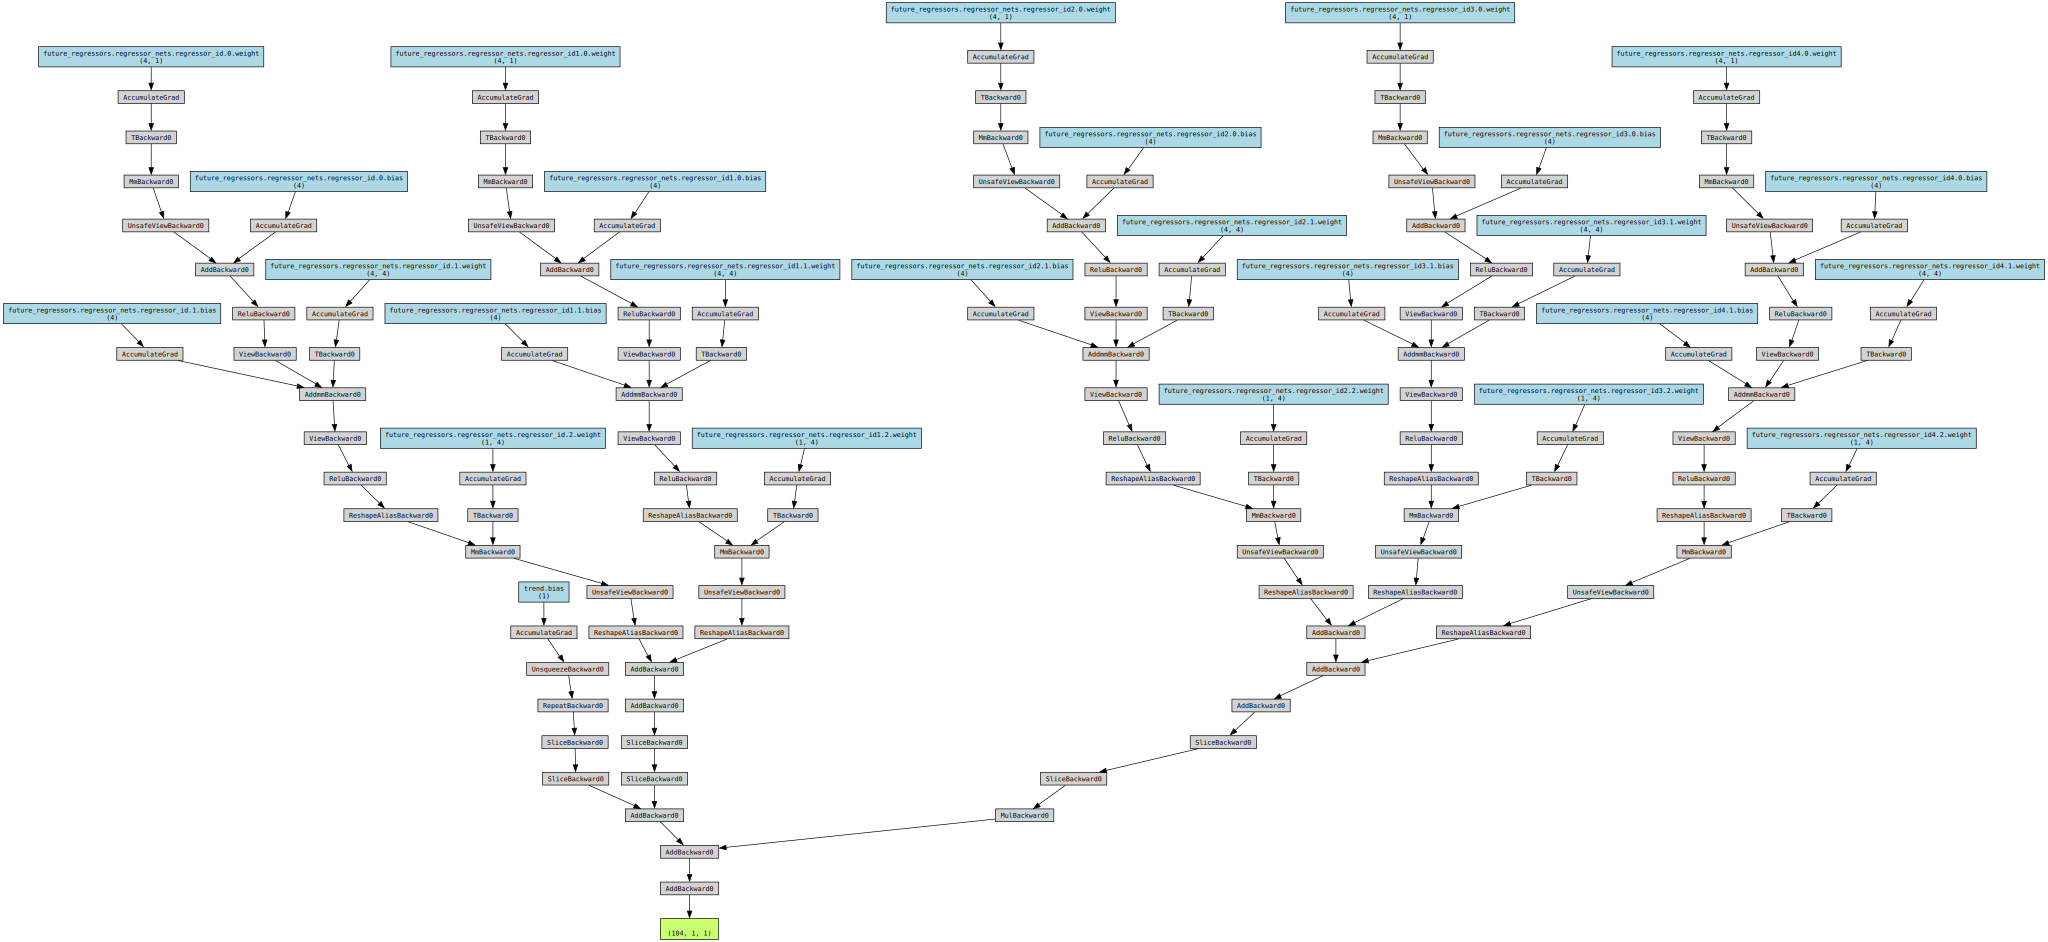

In [ ]:
fig = make_dot(m.model.train_epoch_prediction, params=dict(m.model.named_parameters()))
# fig_glob.render(filename='img/fig_glob')
display(fig)

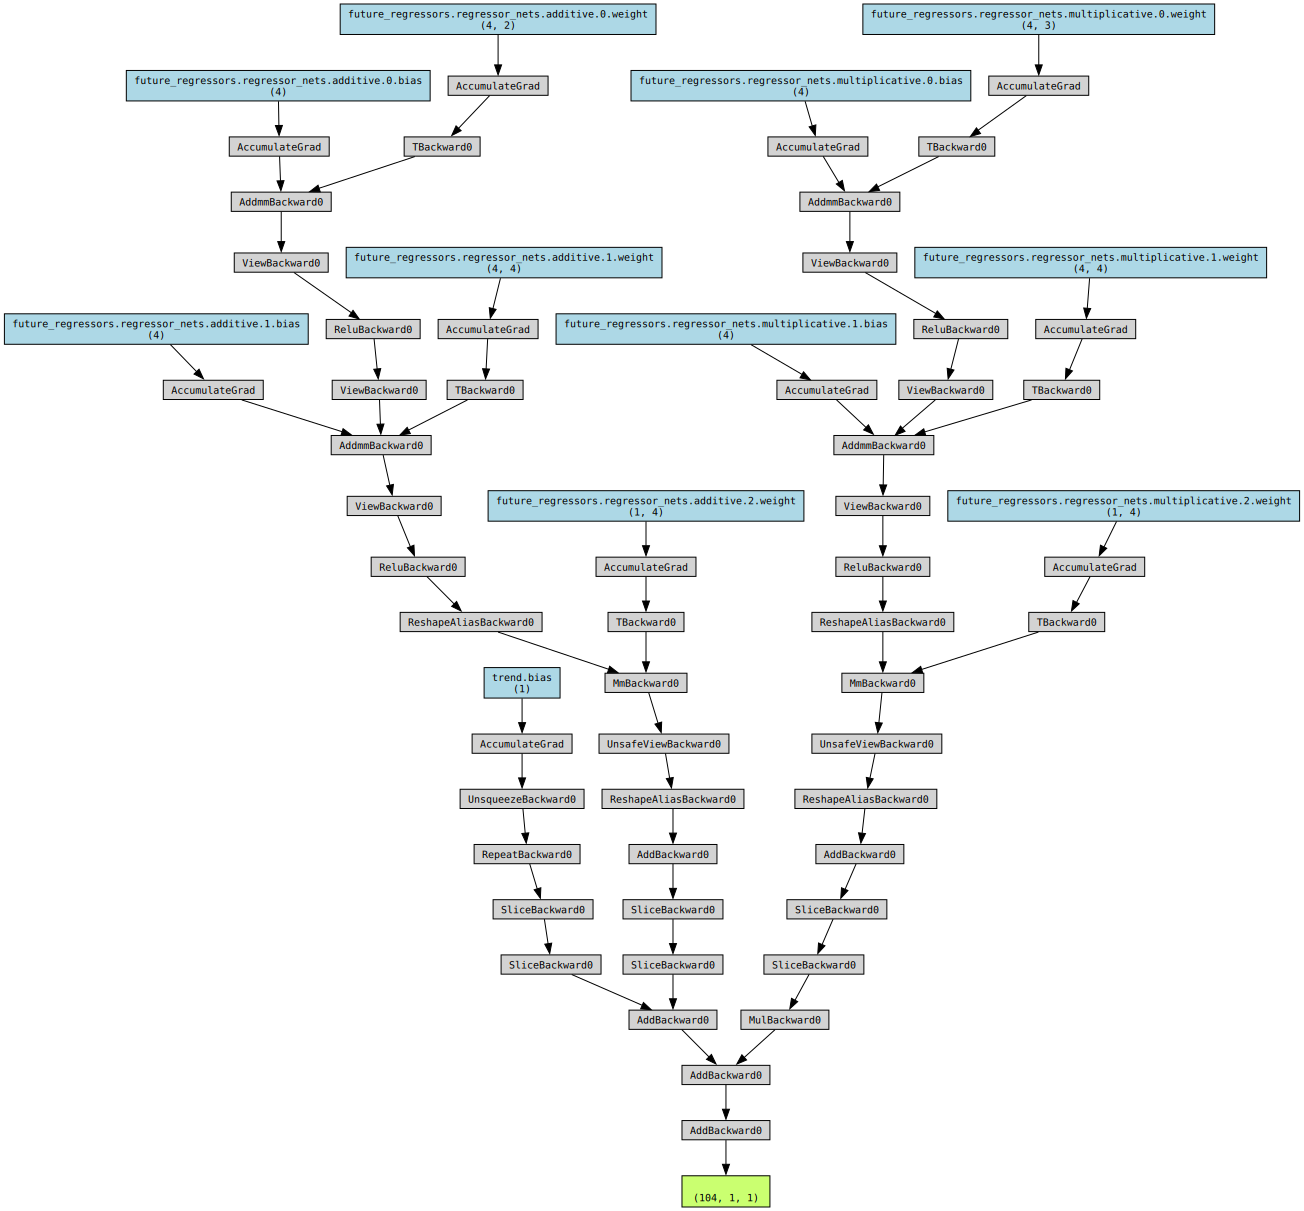

In [ ]:
fig = make_dot(m.model.train_epoch_prediction, params=dict(m.model.named_parameters()))
# fig_glob.render(filename='img/fig_glob')
display(fig)